# Predicción de Series Temporales e-Waste mediante Redes Neuronales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

# PREDICCION POR DEPARTAMENTO

Cargamos nuestro Dataset por Departamento 2015-2020

In [83]:
#Data Original
Name = 'DEPARTAMENTO_GrpConsolidado'
#Carga archivo fuente para la predicción DEPARTAMENTO_GrpConsolidado.csv
datos = pd.read_csv(Name+'.csv',sep=';')
#Se crea una copy of the original data
datos_dep = datos.copy()
datos = datos.drop('DEPARTAMENTO',axis=1)
#Se define el año como indice
datos['ANIO'] = pd.to_datetime(datos['ANIO'], format='%Y')
datos = datos.set_index('ANIO')
datos = datos.sort_index()
datos

,IDDEPARTAMENTO,GENERACION_TOTAL_KG
ANIO,,
2015-01-01,0,470.00
2015-01-01,5,465967.03
2015-01-01,26,16540.01
2015-01-01,25,3922.00
2015-01-01,6,3177.00
...,...,...
2020-01-01,27,49835.43
2020-01-01,19,4676.22
2020-01-01,28,559.70


RECORRIDO, ENTRENAMIENTO Y PROYECCIÓN

In [85]:
columns = datos_dep['DEPARTAMENTO'].unique()
iddepto = datos_dep['IDDEPARTAMENTO'].unique()
# Definir Dataframe necesarios.
val_metodo =  pd.DataFrame()
df = datos.copy()
##range(len(iddepto))
#hasta = range(len(iddepto))
for p in range(len(iddepto)):
    print(p)
    df = datos[datos['IDDEPARTAMENTO'] == iddepto[p]]
    long = len(df)
    PASOS=2
        # convert series to supervised learning
    def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg
    
    # load dataset
    values = df.values
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, PASOS, 1)
    #reframed.head()
    
    # Dividimos en set de Entrenamiento y Validación
    values = reframed.values
    n_train_days = long - (3+PASOS)
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]
    # split into input and outputs
    x_train, y_train = train[:, :-1], train[:, -1]
    x_val, y_val = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
    print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
    
    #Creamos la red neuronal Feedforward
    def crear_modeloFF():
        model = Sequential() 
        model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
        model.add(Flatten())
        model.add(Dense(1, activation='tanh'))
        model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
        model.summary()
        return model
    
    #Entrenamos la red con 40 ciclos
    EPOCHS=40
    model = crear_modeloFF()
    history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)
    
    results=model.predict(x_val)
    
    compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
    compara.columns = ['real', 'prediccion']

    inverted = scaler.inverse_transform(compara.values)

    compara2 = pd.DataFrame(inverted)
    compara2.columns = ['real', 'prediccion']
    compara2['diferencia'] = compara2['real'] - compara2['prediccion']
    #compara2.head()
    
    #A partir de los dos ultimos años (2019-2020) preparamos los datos para Test
    ultimosDias = df['2019-01-01':'2020-01-01']
    ultimosDias
    values = ultimosDias.values
    values = values.astype('float32')
    # normalize features
    values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[2]], axis=1, inplace=True)
    #reframed.head(7)
    
    values = reframed.values
    x_test = values[1:, :]
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

    x_test

    def agregarNuevoValor(x_test,nuevoValor):
        for i in range(x_test.shape[2]-1):
            x_test[0][0][i] = x_test[0][0][i+1]
        x_test[0][0][x_test.shape[2]-1]=nuevoValor
        return x_test
    
    #Pronóstico de los 5 años posteriores (2021-2025)
    results=[]
    for i in range(5):
        parcial=model.predict(x_test)
        results.append(parcial[0])
        print(x_test)
        x_test=agregarNuevoValor(x_test,parcial[0])

    adimen = [x for x in results]    
    print(adimen)
    inverted = scaler.inverse_transform(adimen)
    inverted

    prediccion5años = pd.DataFrame(inverted)
    prediccion5años.columns = ['pronostico']
    prediccion5años =  round(prediccion5años, 2)
    
    #Agregamos el resultado del pronostico en el dataset
    i=0
    for fila in prediccion5años.pronostico:
        i=i+1
        ultimosDias.loc['202' + str(i)+'-01-01'] = fila
        ANIO = '202'+ str(i)+'-01-01'
        datos_dep = datos_dep.append({'DEPARTAMENTO' : columns[p],'IDDEPARTAMENTO' : iddepto[p],'ANIO' : '202' + str(i), 'GENERACION_TOTAL_KG' : round(float(fila),3)}, ignore_index=True)

0
(1, 1, 2) (1,) (9, 1, 2) (9,)
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_114 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_57 (Flatten)        (None, 2)                 0         
                                                                 
 dense_115 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 955ms/step - loss: 1.5633 - mse: 2.4438 - val_loss: 1.0666 - val_mse: 1.2141
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 1.5593 - mse: 2.4315 - val_loss: 1.0638 - val_mse: 1.2076
Epoch 3/40
1/1 [================

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 1.0015 - mse: 1.0029 - val_loss: 0.7196 - val_mse: 0.6139
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 0.9946 - mse: 0.9892 - val_loss: 0.7160 - val_mse: 0.6079
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 0.9877 - mse: 0.9755 - val_loss: 0.7125 - val_mse: 0.6020
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 0.9808 - mse: 0.9619 - val_loss: 0.7089 - val_mse: 0.5961
Epoch 5/40
1/1 [==============================] - 0s 48ms/step - loss: 0.9739 - mse: 0.9484 - val_loss: 0.7053 - val_mse: 0.5902
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.9670 - mse: 0.9350 - val_loss: 0.7018 - val_mse: 0.5843
Epoch 7/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9601 - mse: 0.9218 - val_loss: 0.6982 - val_mse: 0.5785
Epoch 8/40
1/1 [==============================] - 0s 38ms/step - loss: 0.9532 - mse: 0.9086 - val_loss: 0.6946

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 2s 2s/step - loss: 0.1980 - mse: 0.0392 - val_loss: 0.5453 - val_mse: 0.4848
Epoch 2/40
1/1 [==============================] - 0s 38ms/step - loss: 0.1965 - mse: 0.0386 - val_loss: 0.5453 - val_mse: 0.4858
Epoch 3/40
1/1 [==============================] - 0s 36ms/step - loss: 0.1949 - mse: 0.0380 - val_loss: 0.5453 - val_mse: 0.4868
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1934 - mse: 0.0374 - val_loss: 0.5453 - val_mse: 0.4878
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.1919 - mse: 0.0368 - val_loss: 0.5453 - val_mse: 0.4888
Epoch 6/40
1/1 [==============================] - 0s 36ms/step - loss: 0.1904 - mse: 0.0362 - val_loss: 0.5452 - val_mse: 0.4898
Epoch 7/40
1/1 [==============================] - 0s 36ms/step - loss: 0.1889 - mse: 0.0357 - val_loss: 0.5452 - val_mse: 0.4908
Epoch 8/40
1/1 [==============================] - 0s 37ms/step - loss: 0.1874 - mse: 0.0351 - val_loss: 0.5452

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 684ms/step - loss: 0.1908 - mse: 0.0364 - val_loss: 0.3873 - val_mse: 0.2515
Epoch 2/40
1/1 [==============================] - 0s 38ms/step - loss: 0.1895 - mse: 0.0359 - val_loss: 0.3874 - val_mse: 0.2527
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1882 - mse: 0.0354 - val_loss: 0.3874 - val_mse: 0.2540
Epoch 4/40
1/1 [==============================] - 0s 46ms/step - loss: 0.1869 - mse: 0.0349 - val_loss: 0.3874 - val_mse: 0.2552
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.1857 - mse: 0.0345 - val_loss: 0.3874 - val_mse: 0.2564
Epoch 6/40
1/1 [==============================] - 0s 37ms/step - loss: 0.1844 - mse: 0.0340 - val_loss: 0.3874 - val_mse: 0.2577
Epoch 7/40
1/1 [==============================] - 0s 39ms/step - loss: 0.1832 - mse: 0.0335 - val_loss: 0.3875 - val_mse: 0.2589
Epoch 8/40
1/1 [==============================] - 0s 38ms/step - loss: 0.1819 - mse: 0.0331 - val_loss: 0.3

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.4393 - mse: 0.1930 - val_loss: 0.5248 - val_mse: 0.3540
Epoch 2/40
1/1 [==============================] - 0s 53ms/step - loss: 0.4361 - mse: 0.1902 - val_loss: 0.5231 - val_mse: 0.3534
Epoch 3/40
1/1 [==============================] - 0s 37ms/step - loss: 0.4328 - mse: 0.1874 - val_loss: 0.5213 - val_mse: 0.3528
Epoch 4/40
1/1 [==============================] - 0s 37ms/step - loss: 0.4296 - mse: 0.1846 - val_loss: 0.5196 - val_mse: 0.3522
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.4264 - mse: 0.1819 - val_loss: 0.5179 - val_mse: 0.3516
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 0.4233 - mse: 0.1792 - val_loss: 0.5162 - val_mse: 0.3510
Epoch 7/40
1/1 [==============================] - 0s 39ms/step - loss: 0.4201 - mse: 0.1765 - val_loss: 0.5144 - val_mse: 0.3505
Epoch 8/40
1/1 [==============================] - 0s 44ms/step - loss: 0.4170 - mse: 0.1739 - val_loss: 0.5127

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 699ms/step - loss: 1.6211 - mse: 2.6281 - val_loss: 0.9072 - val_mse: 1.2421
Epoch 2/40
1/1 [==============================] - 0s 39ms/step - loss: 1.6183 - mse: 2.6191 - val_loss: 0.9066 - val_mse: 1.2386
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 1.6155 - mse: 2.6100 - val_loss: 0.9061 - val_mse: 1.2351
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6127 - mse: 2.6008 - val_loss: 0.9056 - val_mse: 1.2316
Epoch 5/40
1/1 [==============================] - 0s 55ms/step - loss: 1.6099 - mse: 2.5916 - val_loss: 0.9051 - val_mse: 1.2281
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 1.6070 - mse: 2.5824 - val_loss: 0.9045 - val_mse: 1.2245
Epoch 7/40
1/1 [==============================] - 0s 36ms/step - loss: 1.6041 - mse: 2.5731 - val_loss: 0.9040 - val_mse: 1.2210
Epoch 8/40
1/1 [==============================] - 0s 37ms/step - loss: 1.6012 - mse: 2.5638 - val_loss: 0.9

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 717ms/step - loss: 1.6297 - mse: 2.6561 - val_loss: 1.0218 - val_mse: 1.1610
Epoch 2/40
1/1 [==============================] - 0s 38ms/step - loss: 1.6260 - mse: 2.6440 - val_loss: 1.0187 - val_mse: 1.1536
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6223 - mse: 2.6318 - val_loss: 1.0155 - val_mse: 1.1461
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6185 - mse: 2.6195 - val_loss: 1.0124 - val_mse: 1.1387
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6147 - mse: 2.6072 - val_loss: 1.0092 - val_mse: 1.1313
Epoch 6/40
1/1 [==============================] - 0s 49ms/step - loss: 1.6108 - mse: 2.5948 - val_loss: 1.0060 - val_mse: 1.1238
Epoch 7/40
1/1 [==============================] - 0s 39ms/step - loss: 1.6069 - mse: 2.5822 - val_loss: 1.0028 - val_mse: 1.1164
Epoch 8/40
1/1 [==============================] - 0s 40ms/step - loss: 1.6030 - mse: 2.5696 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.7816 - mse: 0.6110 - val_loss: 0.4941 - val_mse: 0.3038
Epoch 2/40
1/1 [==============================] - 0s 38ms/step - loss: 0.7786 - mse: 0.6062 - val_loss: 0.4924 - val_mse: 0.3018
Epoch 3/40
1/1 [==============================] - 0s 37ms/step - loss: 0.7755 - mse: 0.6014 - val_loss: 0.4906 - val_mse: 0.2999
Epoch 4/40
1/1 [==============================] - 0s 37ms/step - loss: 0.7724 - mse: 0.5966 - val_loss: 0.4889 - val_mse: 0.2979
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 0.7694 - mse: 0.5919 - val_loss: 0.4872 - val_mse: 0.2960
Epoch 6/40
1/1 [==============================] - 0s 36ms/step - loss: 0.7663 - mse: 0.5873 - val_loss: 0.4855 - val_mse: 0.2940
Epoch 7/40
1/1 [==============================] - 0s 37ms/step - loss: 0.7633 - mse: 0.5826 - val_loss: 0.4838 - val_mse: 0.2921
Epoch 8/40
1/1 [==============================] - 0s 38ms/step - loss: 0.7603 - mse: 0.5780 - val_loss: 0.4821

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 712ms/step - loss: 1.7058 - mse: 2.9096 - val_loss: 1.1137 - val_mse: 1.7529
Epoch 2/40
1/1 [==============================] - 0s 37ms/step - loss: 1.7034 - mse: 2.9017 - val_loss: 1.1132 - val_mse: 1.7503
Epoch 3/40
1/1 [==============================] - 0s 36ms/step - loss: 1.7011 - mse: 2.8937 - val_loss: 1.1127 - val_mse: 1.7477
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.6987 - mse: 2.8856 - val_loss: 1.1122 - val_mse: 1.7451
Epoch 5/40
1/1 [==============================] - 0s 36ms/step - loss: 1.6963 - mse: 2.8775 - val_loss: 1.1117 - val_mse: 1.7425
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 1.6939 - mse: 2.8694 - val_loss: 1.1111 - val_mse: 1.7399
Epoch 7/40
1/1 [==============================] - 0s 36ms/step - loss: 1.6915 - mse: 2.8613 - val_loss: 1.1106 - val_mse: 1.7372
Epoch 8/40
1/1 [==============================] - 0s 47ms/step - loss: 1.6891 - mse: 2.8530 - val_loss: 1.1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


9
(1, 1, 2) (1,) (9, 1, 2) (9,)
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_66 (Flatten)        (None, 2)                 0         
                                                                 
 dense_133 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 706ms/step - loss: 1.4103 - mse: 1.9888 - val_loss: 1.1170 - val_mse: 1.3468
Epoch 2/40
1/1 [==============================] - 0s 39ms/step - loss: 1.4077 - mse: 1.9817 - val_loss: 1.1150 - val_mse: 1.3418
Epoch 3/40
1/1 [================

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 864ms/step - loss: 1.1615 - mse: 1.3491 - val_loss: 0.7015 - val_mse: 0.7390
Epoch 2/40
1/1 [==============================] - 0s 39ms/step - loss: 1.1582 - mse: 1.3413 - val_loss: 0.7000 - val_mse: 0.7356
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 1.1548 - mse: 1.3335 - val_loss: 0.6986 - val_mse: 0.7321
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1514 - mse: 1.3258 - val_loss: 0.6971 - val_mse: 0.7286
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.1480 - mse: 1.3180 - val_loss: 0.6956 - val_mse: 0.7252
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 1.1447 - mse: 1.3102 - val_loss: 0.6941 - val_mse: 0.7218
Epoch 7/40
1/1 [==============================] - 0s 36ms/step - loss: 1.1413 - mse: 1.3025 - val_loss: 0.6926 - val_mse: 0.7183
Epoch 8/40
1/1 [==============================] - 0s 37ms/step - loss: 1.1379 - mse: 1.2948 - val_loss: 0.6

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 3s 3s/step - loss: 0.1668 - mse: 0.0278 - val_loss: 0.3397 - val_mse: 0.1716
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1657 - mse: 0.0274 - val_loss: 0.3391 - val_mse: 0.1713
Epoch 3/40
1/1 [==============================] - 0s 36ms/step - loss: 0.1645 - mse: 0.0271 - val_loss: 0.3385 - val_mse: 0.1710
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.1634 - mse: 0.0267 - val_loss: 0.3378 - val_mse: 0.1707
Epoch 5/40
1/1 [==============================] - 0s 36ms/step - loss: 0.1622 - mse: 0.0263 - val_loss: 0.3372 - val_mse: 0.1704
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 0.1611 - mse: 0.0260 - val_loss: 0.3366 - val_mse: 0.1701
Epoch 7/40
1/1 [==============================] - 0s 38ms/step - loss: 0.1600 - mse: 0.0256 - val_loss: 0.3360 - val_mse: 0.1699
Epoch 8/40
1/1 [==============================] - 0s 37ms/step - loss: 0.1589 - mse: 0.0252 - val_loss: 0.3354

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 757ms/step - loss: 0.4014 - mse: 0.1611 - val_loss: 0.5003 - val_mse: 0.3468
Epoch 2/40
1/1 [==============================] - 0s 37ms/step - loss: 0.3989 - mse: 0.1591 - val_loss: 0.4994 - val_mse: 0.3464
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3964 - mse: 0.1571 - val_loss: 0.4985 - val_mse: 0.3460
Epoch 4/40
1/1 [==============================] - 0s 45ms/step - loss: 0.3939 - mse: 0.1551 - val_loss: 0.4977 - val_mse: 0.3457
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.3914 - mse: 0.1532 - val_loss: 0.4968 - val_mse: 0.3454
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 0.3889 - mse: 0.1512 - val_loss: 0.4959 - val_mse: 0.3450
Epoch 7/40
1/1 [==============================] - 0s 35ms/step - loss: 0.3864 - mse: 0.1493 - val_loss: 0.4950 - val_mse: 0.3447
Epoch 8/40
1/1 [==============================] - 0s 35ms/step - loss: 0.3840 - mse: 0.1474 - val_loss: 0.4

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 893ms/step - loss: 1.3010 - mse: 1.6927 - val_loss: 0.8518 - val_mse: 1.0501
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.2964 - mse: 1.6807 - val_loss: 0.8506 - val_mse: 1.0468
Epoch 3/40
1/1 [==============================] - 0s 35ms/step - loss: 1.2918 - mse: 1.6686 - val_loss: 0.8494 - val_mse: 1.0435
Epoch 4/40
1/1 [==============================] - 0s 34ms/step - loss: 1.2871 - mse: 1.6566 - val_loss: 0.8482 - val_mse: 1.0402
Epoch 5/40
1/1 [==============================] - 0s 35ms/step - loss: 1.2824 - mse: 1.6445 - val_loss: 0.8470 - val_mse: 1.0369
Epoch 6/40
1/1 [==============================] - 0s 36ms/step - loss: 1.2777 - mse: 1.6324 - val_loss: 0.8458 - val_mse: 1.0337
Epoch 7/40
1/1 [==============================] - 0s 38ms/step - loss: 1.2729 - mse: 1.6203 - val_loss: 0.8446 - val_mse: 1.0304
Epoch 8/40
1/1 [==============================] - 0s 39ms/step - loss: 1.2682 - mse: 1.6082 - val_loss: 0.8

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 725ms/step - loss: 1.8443 - mse: 3.4016 - val_loss: 1.3298 - val_mse: 2.0641
Epoch 2/40
1/1 [==============================] - 0s 37ms/step - loss: 1.8429 - mse: 3.3963 - val_loss: 1.3283 - val_mse: 2.0594
Epoch 3/40
1/1 [==============================] - 0s 48ms/step - loss: 1.8415 - mse: 3.3910 - val_loss: 1.3268 - val_mse: 2.0546
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.8400 - mse: 3.3857 - val_loss: 1.3253 - val_mse: 2.0498
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 1.8386 - mse: 3.3803 - val_loss: 1.3238 - val_mse: 2.0450
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 1.8371 - mse: 3.3748 - val_loss: 1.3223 - val_mse: 2.0402
Epoch 7/40
1/1 [==============================] - 0s 42ms/step - loss: 1.8356 - mse: 3.3693 - val_loss: 1.3208 - val_mse: 2.0353
Epoch 8/40
1/1 [==============================] - 0s 36ms/step - loss: 1.8341 - mse: 3.3638 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 702ms/step - loss: 1.0276 - mse: 1.0559 - val_loss: 0.6410 - val_mse: 0.5912
Epoch 2/40
1/1 [==============================] - 0s 36ms/step - loss: 1.0257 - mse: 1.0521 - val_loss: 0.6401 - val_mse: 0.5899
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 1.0238 - mse: 1.0483 - val_loss: 0.6393 - val_mse: 0.5885
Epoch 4/40
1/1 [==============================] - 0s 36ms/step - loss: 1.0220 - mse: 1.0444 - val_loss: 0.6385 - val_mse: 0.5872
Epoch 5/40
1/1 [==============================] - 0s 35ms/step - loss: 1.0201 - mse: 1.0406 - val_loss: 0.6377 - val_mse: 0.5859
Epoch 6/40
1/1 [==============================] - 0s 37ms/step - loss: 1.0182 - mse: 1.0368 - val_loss: 0.6368 - val_mse: 0.5845
Epoch 7/40
1/1 [==============================] - 0s 36ms/step - loss: 1.0163 - mse: 1.0329 - val_loss: 0.6360 - val_mse: 0.5832
Epoch 8/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0145 - mse: 1.0291 - val_loss: 0.6

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 798ms/step - loss: 1.3457 - mse: 1.8110 - val_loss: 0.7680 - val_mse: 0.7138
Epoch 2/40
1/1 [==============================] - 0s 37ms/step - loss: 1.3413 - mse: 1.7990 - val_loss: 0.7651 - val_mse: 0.7085
Epoch 3/40
1/1 [==============================] - 0s 36ms/step - loss: 1.3368 - mse: 1.7870 - val_loss: 0.7622 - val_mse: 0.7032
Epoch 4/40
1/1 [==============================] - 0s 37ms/step - loss: 1.3323 - mse: 1.7749 - val_loss: 0.7593 - val_mse: 0.6979
Epoch 5/40
1/1 [==============================] - 0s 36ms/step - loss: 1.3277 - mse: 1.7628 - val_loss: 0.7563 - val_mse: 0.6926
Epoch 6/40
1/1 [==============================] - 0s 36ms/step - loss: 1.3231 - mse: 1.7507 - val_loss: 0.7534 - val_mse: 0.6874
Epoch 7/40
1/1 [==============================] - 0s 37ms/step - loss: 1.3185 - mse: 1.7386 - val_loss: 0.7504 - val_mse: 0.6821
Epoch 8/40
1/1 [==============================] - 0s 37ms/step - loss: 1.3139 - mse: 1.7264 - val_loss: 0.7

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 786ms/step - loss: 0.2287 - mse: 0.0523 - val_loss: 0.4347 - val_mse: 0.3108
Epoch 2/40
1/1 [==============================] - 0s 39ms/step - loss: 0.2247 - mse: 0.0505 - val_loss: 0.4346 - val_mse: 0.3108
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 0.2207 - mse: 0.0487 - val_loss: 0.4345 - val_mse: 0.3107
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.2166 - mse: 0.0469 - val_loss: 0.4345 - val_mse: 0.3107
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2126 - mse: 0.0452 - val_loss: 0.4344 - val_mse: 0.3107
Epoch 6/40
1/1 [==============================] - 0s 36ms/step - loss: 0.2085 - mse: 0.0435 - val_loss: 0.4343 - val_mse: 0.3106
Epoch 7/40
1/1 [==============================] - 0s 37ms/step - loss: 0.2045 - mse: 0.0418 - val_loss: 0.4342 - val_mse: 0.3106
Epoch 8/40
1/1 [==============================] - 0s 37ms/step - loss: 0.2004 - mse: 0.0402 - val_loss: 0.4

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 804ms/step - loss: 0.0213 - mse: 4.5253e-04 - val_loss: 0.4353 - val_mse: 0.5511
Epoch 2/40
1/1 [==============================] - 0s 39ms/step - loss: 0.0211 - mse: 4.4490e-04 - val_loss: 0.4350 - val_mse: 0.5508
Epoch 3/40
1/1 [==============================] - 0s 37ms/step - loss: 0.0209 - mse: 4.3741e-04 - val_loss: 0.4346 - val_mse: 0.5505
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.0207 - mse: 4.3006e-04 - val_loss: 0.4342 - val_mse: 0.5501
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.0206 - mse: 4.2284e-04 - val_loss: 0.4338 - val_mse: 0.5498
Epoch 6/40
1/1 [==============================] - 0s 47ms/step - loss: 0.0204 - mse: 4.1576e-04 - val_loss: 0.4334 - val_mse: 0.5495
Epoch 7/40
1/1 [==============================] - 0s 35ms/step - loss: 0.0202 - mse: 4.0881e-04 - val_loss: 0.4331 - val_mse: 0.5491
Epoch 8/40
1/1 [==============================] - 0s 47ms/step - loss: 0.0200 -

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 824ms/step - loss: 1.7310 - mse: 2.9963 - val_loss: 1.3211 - val_mse: 2.0191
Epoch 2/40
1/1 [==============================] - 0s 36ms/step - loss: 1.7285 - mse: 2.9877 - val_loss: 1.3198 - val_mse: 2.0140
Epoch 3/40
1/1 [==============================] - 0s 37ms/step - loss: 1.7260 - mse: 2.9790 - val_loss: 1.3186 - val_mse: 2.0088
Epoch 4/40
1/1 [==============================] - 0s 37ms/step - loss: 1.7234 - mse: 2.9703 - val_loss: 1.3173 - val_mse: 2.0037
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.7209 - mse: 2.9615 - val_loss: 1.3161 - val_mse: 1.9984
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.7183 - mse: 2.9526 - val_loss: 1.3148 - val_mse: 1.9932
Epoch 7/40
1/1 [==============================] - 0s 37ms/step - loss: 1.7157 - mse: 2.9437 - val_loss: 1.3135 - val_mse: 1.9879
Epoch 8/40
1/1 [==============================] - 0s 38ms/step - loss: 1.7131 - mse: 2.9347 - val_loss: 1.3

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 785ms/step - loss: 1.0695 - mse: 1.1438 - val_loss: 1.1074 - val_mse: 1.3626
Epoch 2/40
1/1 [==============================] - 0s 35ms/step - loss: 1.0666 - mse: 1.1376 - val_loss: 1.1070 - val_mse: 1.3617
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 1.0637 - mse: 1.1314 - val_loss: 1.1066 - val_mse: 1.3608
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 1.0608 - mse: 1.1252 - val_loss: 1.1062 - val_mse: 1.3599
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.0579 - mse: 1.1191 - val_loss: 1.1059 - val_mse: 1.3590
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 1.0549 - mse: 1.1129 - val_loss: 1.1055 - val_mse: 1.3582
Epoch 7/40
1/1 [==============================] - 0s 36ms/step - loss: 1.0520 - mse: 1.1067 - val_loss: 1.1051 - val_mse: 1.3573
Epoch 8/40
1/1 [==============================] - 0s 36ms/step - loss: 1.0491 - mse: 1.1006 - val_loss: 1.1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 833ms/step - loss: 0.8530 - mse: 0.7275 - val_loss: 0.6971 - val_mse: 0.5665
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.8485 - mse: 0.7199 - val_loss: 0.6940 - val_mse: 0.5620
Epoch 3/40
1/1 [==============================] - 0s 37ms/step - loss: 0.8440 - mse: 0.7123 - val_loss: 0.6908 - val_mse: 0.5575
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.8395 - mse: 0.7048 - val_loss: 0.6877 - val_mse: 0.5530
Epoch 5/40
1/1 [==============================] - 0s 35ms/step - loss: 0.8350 - mse: 0.6973 - val_loss: 0.6846 - val_mse: 0.5486
Epoch 6/40
1/1 [==============================] - 0s 37ms/step - loss: 0.8306 - mse: 0.6898 - val_loss: 0.6815 - val_mse: 0.5442
Epoch 7/40
1/1 [==============================] - 0s 38ms/step - loss: 0.8261 - mse: 0.6825 - val_loss: 0.6783 - val_mse: 0.5399
Epoch 8/40
1/1 [==============================] - 0s 41ms/step - loss: 0.8217 - mse: 0.6751 - val_loss: 0.6

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 807ms/step - loss: 0.8529 - mse: 0.7274 - val_loss: 0.8592 - val_mse: 1.0844
Epoch 2/40
1/1 [==============================] - 0s 38ms/step - loss: 0.8491 - mse: 0.7209 - val_loss: 0.8588 - val_mse: 1.0849
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8452 - mse: 0.7144 - val_loss: 0.8584 - val_mse: 1.0853
Epoch 4/40
1/1 [==============================] - 0s 36ms/step - loss: 0.8414 - mse: 0.7080 - val_loss: 0.8580 - val_mse: 1.0857
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 0.8376 - mse: 0.7016 - val_loss: 0.8577 - val_mse: 1.0862
Epoch 6/40
1/1 [==============================] - 0s 36ms/step - loss: 0.8338 - mse: 0.6952 - val_loss: 0.8573 - val_mse: 1.0866
Epoch 7/40
1/1 [==============================] - 0s 36ms/step - loss: 0.8300 - mse: 0.6888 - val_loss: 0.8569 - val_mse: 1.0871
Epoch 8/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8261 - mse: 0.6825 - val_loss: 0.8

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 722ms/step - loss: 1.0902 - mse: 1.1886 - val_loss: 0.9056 - val_mse: 0.8443
Epoch 2/40
1/1 [==============================] - 0s 36ms/step - loss: 1.0859 - mse: 1.1791 - val_loss: 0.9022 - val_mse: 0.8379
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0815 - mse: 1.1696 - val_loss: 0.8988 - val_mse: 0.8315
Epoch 4/40
1/1 [==============================] - 0s 45ms/step - loss: 1.0771 - mse: 1.1601 - val_loss: 0.8953 - val_mse: 0.8251
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.0727 - mse: 1.1507 - val_loss: 0.8919 - val_mse: 0.8188
Epoch 6/40
1/1 [==============================] - 0s 39ms/step - loss: 1.0683 - mse: 1.1413 - val_loss: 0.8885 - val_mse: 0.8126
Epoch 7/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0639 - mse: 1.1320 - val_loss: 0.8850 - val_mse: 0.8063
Epoch 8/40
1/1 [==============================] - 0s 37ms/step - loss: 1.0595 - mse: 1.1226 - val_loss: 0.8

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 732ms/step - loss: 0.4244 - mse: 0.1801 - val_loss: 0.5742 - val_mse: 0.4733
Epoch 2/40
1/1 [==============================] - 0s 37ms/step - loss: 0.4211 - mse: 0.1773 - val_loss: 0.5730 - val_mse: 0.4733
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.4178 - mse: 0.1746 - val_loss: 0.5718 - val_mse: 0.4733
Epoch 4/40
1/1 [==============================] - 0s 37ms/step - loss: 0.4146 - mse: 0.1719 - val_loss: 0.5706 - val_mse: 0.4733
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 0.4113 - mse: 0.1692 - val_loss: 0.5694 - val_mse: 0.4733
Epoch 6/40
1/1 [==============================] - 0s 45ms/step - loss: 0.4081 - mse: 0.1666 - val_loss: 0.5682 - val_mse: 0.4733
Epoch 7/40
1/1 [==============================] - 0s 45ms/step - loss: 0.4049 - mse: 0.1640 - val_loss: 0.5670 - val_mse: 0.4733
Epoch 8/40
1/1 [==============================] - 0s 39ms/step - loss: 0.4018 - mse: 0.1614 - val_loss: 0.5

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 748ms/step - loss: 1.3638 - mse: 1.8600 - val_loss: 1.1469 - val_mse: 1.5144
Epoch 2/40
1/1 [==============================] - 0s 38ms/step - loss: 1.3604 - mse: 1.8507 - val_loss: 1.1453 - val_mse: 1.5100
Epoch 3/40
1/1 [==============================] - 0s 36ms/step - loss: 1.3570 - mse: 1.8414 - val_loss: 1.1437 - val_mse: 1.5056
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 1.3536 - mse: 1.8321 - val_loss: 1.1421 - val_mse: 1.5012
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 1.3501 - mse: 1.8228 - val_loss: 1.1405 - val_mse: 1.4967
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.3467 - mse: 1.8135 - val_loss: 1.1389 - val_mse: 1.4923
Epoch 7/40
1/1 [==============================] - 0s 39ms/step - loss: 1.3432 - mse: 1.8042 - val_loss: 1.1373 - val_mse: 1.4878
Epoch 8/40
1/1 [==============================] - 0s 47ms/step - loss: 1.3397 - mse: 1.7948 - val_loss: 1.1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 718ms/step - loss: 0.5590 - mse: 0.3124 - val_loss: 0.8931 - val_mse: 0.8820
Epoch 2/40
1/1 [==============================] - 0s 38ms/step - loss: 0.5563 - mse: 0.3095 - val_loss: 0.8933 - val_mse: 0.8830
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 0.5537 - mse: 0.3066 - val_loss: 0.8935 - val_mse: 0.8841
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.5511 - mse: 0.3037 - val_loss: 0.8937 - val_mse: 0.8851
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 0.5484 - mse: 0.3008 - val_loss: 0.8938 - val_mse: 0.8862
Epoch 6/40
1/1 [==============================] - 0s 35ms/step - loss: 0.5458 - mse: 0.2979 - val_loss: 0.8940 - val_mse: 0.8873
Epoch 7/40
1/1 [==============================] - 0s 37ms/step - loss: 0.5432 - mse: 0.2951 - val_loss: 0.8941 - val_mse: 0.8883
Epoch 8/40
1/1 [==============================] - 0s 37ms/step - loss: 0.5406 - mse: 0.2923 - val_loss: 0.8

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 710ms/step - loss: 1.7500 - mse: 3.0625 - val_loss: 1.2181 - val_mse: 1.7856
Epoch 2/40
1/1 [==============================] - 0s 35ms/step - loss: 1.7483 - mse: 3.0565 - val_loss: 1.2169 - val_mse: 1.7822
Epoch 3/40
1/1 [==============================] - 0s 36ms/step - loss: 1.7465 - mse: 3.0504 - val_loss: 1.2156 - val_mse: 1.7789
Epoch 4/40
1/1 [==============================] - 0s 35ms/step - loss: 1.7448 - mse: 3.0442 - val_loss: 1.2143 - val_mse: 1.7755
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.7430 - mse: 3.0380 - val_loss: 1.2130 - val_mse: 1.7721
Epoch 6/40
1/1 [==============================] - 0s 36ms/step - loss: 1.7412 - mse: 3.0318 - val_loss: 1.2117 - val_mse: 1.7687
Epoch 7/40
1/1 [==============================] - 0s 37ms/step - loss: 1.7394 - mse: 3.0255 - val_loss: 1.2104 - val_mse: 1.7653
Epoch 8/40
1/1 [==============================] - 0s 37ms/step - loss: 1.7376 - mse: 3.0192 - val_loss: 1.2

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 735ms/step - loss: 0.2126 - mse: 0.0452 - val_loss: 0.4816 - val_mse: 0.4723
Epoch 2/40
1/1 [==============================] - 0s 37ms/step - loss: 0.2107 - mse: 0.0444 - val_loss: 0.4803 - val_mse: 0.4719
Epoch 3/40
1/1 [==============================] - 0s 38ms/step - loss: 0.2087 - mse: 0.0436 - val_loss: 0.4790 - val_mse: 0.4716
Epoch 4/40
1/1 [==============================] - 0s 38ms/step - loss: 0.2068 - mse: 0.0428 - val_loss: 0.4777 - val_mse: 0.4712
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 0.2049 - mse: 0.0420 - val_loss: 0.4764 - val_mse: 0.4708
Epoch 6/40
1/1 [==============================] - 0s 38ms/step - loss: 0.2030 - mse: 0.0412 - val_loss: 0.4752 - val_mse: 0.4705
Epoch 7/40
1/1 [==============================] - 0s 37ms/step - loss: 0.2012 - mse: 0.0405 - val_loss: 0.4739 - val_mse: 0.4701
Epoch 8/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1993 - mse: 0.0397 - val_loss: 0.4

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 874ms/step - loss: 1.5673 - mse: 2.5585 - val_loss: 0.7996 - val_mse: 0.9166
Epoch 2/40
1/1 [==============================] - 0s 37ms/step - loss: 1.5661 - mse: 2.5548 - val_loss: 0.7980 - val_mse: 0.9127
Epoch 3/40
1/1 [==============================] - 0s 33ms/step - loss: 1.5649 - mse: 2.5511 - val_loss: 0.7964 - val_mse: 0.9089
Epoch 4/40
1/1 [==============================] - 0s 34ms/step - loss: 1.5637 - mse: 2.5473 - val_loss: 0.7948 - val_mse: 0.9050
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 1.5624 - mse: 2.5435 - val_loss: 0.7932 - val_mse: 0.9012
Epoch 6/40
1/1 [==============================] - 0s 36ms/step - loss: 1.5612 - mse: 2.5396 - val_loss: 0.7916 - val_mse: 0.8973
Epoch 7/40
1/1 [==============================] - 0s 34ms/step - loss: 1.5599 - mse: 2.5357 - val_loss: 0.7900 - val_mse: 0.8935
Epoch 8/40
1/1 [==============================] - 0s 37ms/step - loss: 1.5587 - mse: 2.5317 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.6133 - mse: 0.3808 - val_loss: 0.5873 - val_mse: 0.4061
Epoch 2/40
1/1 [==============================] - 0s 36ms/step - loss: 0.6100 - mse: 0.3768 - val_loss: 0.5873 - val_mse: 0.4062
Epoch 3/40
1/1 [==============================] - 0s 37ms/step - loss: 0.6067 - mse: 0.3728 - val_loss: 0.5872 - val_mse: 0.4062
Epoch 4/40
1/1 [==============================] - 0s 36ms/step - loss: 0.6034 - mse: 0.3688 - val_loss: 0.5872 - val_mse: 0.4063
Epoch 5/40
1/1 [==============================] - 0s 39ms/step - loss: 0.6002 - mse: 0.3648 - val_loss: 0.5871 - val_mse: 0.4064
Epoch 6/40
1/1 [==============================] - 0s 36ms/step - loss: 0.5970 - mse: 0.3609 - val_loss: 0.5871 - val_mse: 0.4065
Epoch 7/40
1/1 [==============================] - 0s 38ms/step - loss: 0.5937 - mse: 0.3571 - val_loss: 0.5870 - val_mse: 0.4066
Epoch 8/40
1/1 [==============================] - 0s 42ms/step - loss: 0.5905 - mse: 0.3532 - val_loss: 0.5870

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 645ms/step - loss: 1.4024 - mse: 2.1315 - val_loss: 0.8650 - val_mse: 0.8842
Epoch 2/40
1/1 [==============================] - 0s 35ms/step - loss: 1.4007 - mse: 2.1268 - val_loss: 0.8630 - val_mse: 0.8812
Epoch 3/40
1/1 [==============================] - 0s 34ms/step - loss: 1.3990 - mse: 2.1221 - val_loss: 0.8611 - val_mse: 0.8781
Epoch 4/40
1/1 [==============================] - 0s 35ms/step - loss: 1.3973 - mse: 2.1173 - val_loss: 0.8591 - val_mse: 0.8751
Epoch 5/40
1/1 [==============================] - 0s 38ms/step - loss: 1.3956 - mse: 2.1125 - val_loss: 0.8571 - val_mse: 0.8720
Epoch 6/40
1/1 [==============================] - 0s 36ms/step - loss: 1.3939 - mse: 2.1077 - val_loss: 0.8551 - val_mse: 0.8689
Epoch 7/40
1/1 [==============================] - 0s 36ms/step - loss: 1.3921 - mse: 2.1028 - val_loss: 0.8531 - val_mse: 0.8658
Epoch 8/40
1/1 [==============================] - 0s 35ms/step - loss: 1.3903 - mse: 2.0979 - val_loss: 0.8

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 680ms/step - loss: 1.1944 - mse: 1.4267 - val_loss: 0.7188 - val_mse: 0.7402
Epoch 2/40
1/1 [==============================] - 0s 34ms/step - loss: 1.1916 - mse: 1.4200 - val_loss: 0.7188 - val_mse: 0.7376
Epoch 3/40
1/1 [==============================] - 0s 31ms/step - loss: 1.1888 - mse: 1.4133 - val_loss: 0.7188 - val_mse: 0.7349
Epoch 4/40
1/1 [==============================] - 0s 32ms/step - loss: 1.1860 - mse: 1.4065 - val_loss: 0.7188 - val_mse: 0.7323
Epoch 5/40
1/1 [==============================] - 0s 35ms/step - loss: 1.1831 - mse: 1.3998 - val_loss: 0.7188 - val_mse: 0.7296
Epoch 6/40
1/1 [==============================] - 0s 31ms/step - loss: 1.1803 - mse: 1.3931 - val_loss: 0.7188 - val_mse: 0.7270
Epoch 7/40
1/1 [==============================] - 0s 30ms/step - loss: 1.1775 - mse: 1.3864 - val_loss: 0.7188 - val_mse: 0.7244
Epoch 8/40
1/1 [==============================] - 0s 32ms/step - loss: 1.1746 - mse: 1.3797 - val_loss: 0.7

In [94]:
#Se exporta del dataset final donde contiene los pronosticos
datos_dep
#datos_dep.to_csv('DEPARTAMENTO_Pronostico.csv', index=False, sep=';')

,DEPARTAMENTO,IDDEPARTAMENTO,GENERACION_TOTAL_KG,ANIO
0,AMAZONAS,0,470.00,2015
1,AMAZONAS,0,0.00,2016
2,AMAZONAS,0,64.99,2017
3,AMAZONAS,0,45.30,2018
4,AMAZONAS,0,51.10,2019
...,...,...,...,...
358,VICHADA,32,17.25,2021
359,VICHADA,32,8.60,2022
360,VICHADA,32,17.79,2023
361,VICHADA,32,19.56,2024


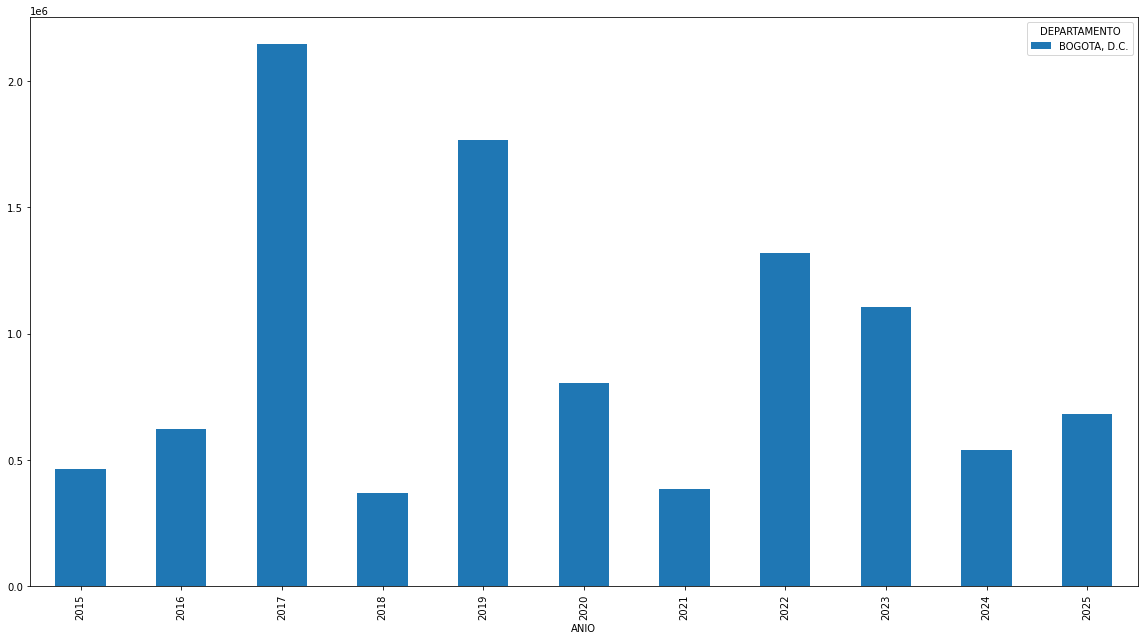

In [98]:
# recupera el peso de cada año, agrupado por sexo:
datosFIL = datos_dep[datos_dep['IDDEPARTAMENTO'] == 5.0]
datos_dep_y = datosFIL.groupby(['ANIO', 'DEPARTAMENTO']).mean()["GENERACION_TOTAL_KG"].unstack()
# genera el gráfico:
datos_dep_y.plot(kind="bar")
plt.tight_layout()  # tip(!)

# PREDICCION POR MUNICIPIO

Cargamos nuestro Dataset por Municipio 2015-2020

In [3]:
Name = 'MUNICIPIO_GrpConsolidado'
#Carga archivo fuente para la predicción
datos = pd.read_csv(Name+'.csv',sep=';')
#Se crea una copy of the original data
#datos = datos[datos['IDDEPARTAMENTO'] == 5.0]
datos_mun = datos.copy()
datos = datos.drop('MUNICIPIO',axis=1)
#Se establece el año como indice
datos['ANIO'] = pd.to_datetime(datos['ANIO'], format='%Y')
datos = datos.set_index('ANIO')
datos = datos.sort_index()
datos

,IDMUNICIPIO,GENERACION_TOTAL_KG
ANIO,,
2015-01-01,0,0.0
2015-01-01,274,0.0
2015-01-01,92,0.0
2015-01-01,275,0.0
2015-01-01,91,0.0
...,...,...
2020-01-01,46,0.0
2020-01-01,333,765.0
2020-01-01,246,0.0


RECORRIDO, ENTRENAMIENTO Y PROYECCIÓN

In [4]:
columns = datos_mun['MUNICIPIO'].unique()
iddepto = datos_mun['IDMUNICIPIO'].unique()
# Definir Dataframe necesarios.
val_metodo =  pd.DataFrame()
df = datos.copy()
for p in range(len(iddepto)):
    print(p)
    df = datos[datos['IDMUNICIPIO'] == iddepto[p]]
    long = len(df)
    PASOS=2
        # convert series to supervised learning
    def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg
    
    # load dataset
    values = df.values
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, PASOS, 1)
    #reframed.head()
    
    # Dividimos en set de Entrenamiento y Validación
    values = reframed.values
    n_train_days = long - (3+PASOS)
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]
    # split into input and outputs
    x_train, y_train = train[:, :-1], train[:, -1]
    x_val, y_val = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
    print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
    
    #Creamos la red neuronal Feedforward
    def crear_modeloFF():
        model = Sequential() 
        model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
        model.add(Flatten())
        model.add(Dense(1, activation='tanh'))
        model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
        model.summary()
        return model
    
    #Entrenamos la red con 40 ciclos
    EPOCHS=40
    model = crear_modeloFF()
    history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)
    
    results=model.predict(x_val)
    
    compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
    compara.columns = ['real', 'prediccion']

    inverted = scaler.inverse_transform(compara.values)

    compara2 = pd.DataFrame(inverted)
    compara2.columns = ['real', 'prediccion']
    compara2['diferencia'] = compara2['real'] - compara2['prediccion']
    #compara2.head()
    
    #A partir de los dos ultimos años (2019-2020) preparamos los datos para Test
    ultimosDias = df['2019-01-01':'2020-01-01']
    ultimosDias
    values = ultimosDias.values
    values = values.astype('float32')
    # normalize features
    values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, PASOS, 1)
    reframed.drop(reframed.columns[[2]], axis=1, inplace=True)
    #reframed.head(7)
    
    values = reframed.values
    x_test = values[1:, :]
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

    x_test

    def agregarNuevoValor(x_test,nuevoValor):
        for i in range(x_test.shape[2]-1):
            x_test[0][0][i] = x_test[0][0][i+1]
        x_test[0][0][x_test.shape[2]-1]=nuevoValor
        return x_test
    
    #Pronóstico de los 5 años posteriores (2021-2025)
    results=[]
    for i in range(5):
        parcial=model.predict(x_test)
        results.append(parcial[0])
        print(x_test)
        x_test=agregarNuevoValor(x_test,parcial[0])

    adimen = [x for x in results]    
    print(adimen)
    inverted = scaler.inverse_transform(adimen)
    inverted

    prediccion5años = pd.DataFrame(inverted)
    prediccion5años.columns = ['pronostico']
    prediccion5años =  round(prediccion5años, 2)
    
    #Agregamos el resultado del pronostico en el dataset
    i=0
    for fila in prediccion5años.pronostico:
        i=i+1
        ultimosDias.loc['202' + str(i)+'-01-01'] = fila
        ANIO = '202'+ str(i)+'-01-01'
        datos_mun = datos_mun.append({'MUNICIPIO' : columns[p],'IDMUNICIPIO' : iddepto[p],'ANIO' : '202' + str(i), 'GENERACION_TOTAL_KG' : round(float(fila),3)}, ignore_index=True)

0
(1, 1, 2) (1,) (9, 1, 2) (9,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 2)              6         
                                                                 
 flatten (Flatten)           (None, 2)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 14s 14s/step - loss: 1.0109 - mse: 1.0219 - val_loss: 0.7281 - val_mse: 0.6348
Epoch 2/40
1/1 [==============================] - 0s 113ms/step - loss: 1.0060 - mse: 1.0120 - val_loss: 0.7258 - val_mse: 0.6320
Epoch 3/40
1/1 [===================

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.8180 - mse: 0.6692 - val_loss: 0.7473 - val_mse: 0.6583
Epoch 2/40
1/1 [==============================] - 0s 74ms/step - loss: 0.8141 - mse: 0.6628 - val_loss: 0.7450 - val_mse: 0.6548
Epoch 3/40
1/1 [==============================] - 0s 80ms/step - loss: 0.8103 - mse: 0.6565 - val_loss: 0.7426 - val_mse: 0.6512
Epoch 4/40
1/1 [==============================] - 0s 110ms/step - loss: 0.8064 - mse: 0.6502 - val_loss: 0.7402 - val_mse: 0.6478
Epoch 5/40
1/1 [==============================] - 0s 85ms/step - loss: 0.8025 - mse: 0.6440 - val_loss: 0.7379 - val_mse: 0.6443
Epoch 6/40
1/1 [==============================] - 0s 78ms/step - loss: 0.7986 - mse: 0.6377 - val_loss: 0.7355 - val_mse: 0.6408
Epoch 7/40
1/1 [==============================] - 0s 87ms/step - loss: 0.7947 - mse: 0.6315 - val_loss: 0.7331 - val_mse: 0.6374
Epoch 8/40
1/1 [==============================] - 0s 110ms/step - loss: 0.7908 - mse: 0.6254 - val

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.6531 - mse: 2.7326 - val_loss: 1.1838 - val_mse: 1.7177
Epoch 2/40
1/1 [==============================] - 0s 71ms/step - loss: 1.6513 - mse: 2.7269 - val_loss: 1.1827 - val_mse: 1.7136
Epoch 3/40
1/1 [==============================] - 0s 82ms/step - loss: 1.6496 - mse: 2.7213 - val_loss: 1.1816 - val_mse: 1.7094
Epoch 4/40
1/1 [==============================] - 0s 81ms/step - loss: 1.6479 - mse: 2.7156 - val_loss: 1.1805 - val_mse: 1.7052
Epoch 5/40
1/1 [==============================] - 0s 98ms/step - loss: 1.6462 - mse: 2.7098 - val_loss: 1.1793 - val_mse: 1.7010
Epoch 6/40
1/1 [==============================] - 0s 93ms/step - loss: 1.6444 - mse: 2.7041 - val_loss: 1.1782 - val_mse: 1.6968
Epoch 7/40
1/1 [==============================] - 0s 79ms/step - loss: 1.6427 - mse: 2.6983 - val_loss: 1.1771 - val_mse: 1.6926
Epoch 8/40
1/1 [==============================] - 0s 84ms/step - loss: 1.6409 - mse: 2.6925 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.1540 - mse: 1.3318 - val_loss: 0.5731 - val_mse: 0.5784
Epoch 2/40
1/1 [==============================] - 0s 81ms/step - loss: 1.1492 - mse: 1.3207 - val_loss: 0.5718 - val_mse: 0.5760
Epoch 3/40
1/1 [==============================] - 0s 85ms/step - loss: 1.1444 - mse: 1.3095 - val_loss: 0.5705 - val_mse: 0.5736
Epoch 4/40
1/1 [==============================] - 0s 81ms/step - loss: 1.1395 - mse: 1.2985 - val_loss: 0.5692 - val_mse: 0.5712
Epoch 5/40
1/1 [==============================] - 0s 91ms/step - loss: 1.1346 - mse: 1.2874 - val_loss: 0.5679 - val_mse: 0.5689
Epoch 6/40
1/1 [==============================] - 0s 88ms/step - loss: 1.1298 - mse: 1.2764 - val_loss: 0.5666 - val_mse: 0.5666
Epoch 7/40
1/1 [====================

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.5220 - mse: 0.2725 - val_loss: 0.7318 - val_mse: 0.6686
Epoch 2/40
1/1 [==============================] - 0s 94ms/step - loss: 0.5195 - mse: 0.2699 - val_loss: 0.7302 - val_mse: 0.6673
Epoch 3/40
1/1 [==============================] - 0s 111ms/step - loss: 0.5171 - mse: 0.2674 - val_loss: 0.7285 - val_mse: 0.6660
Epoch 4/40
1/1 [==============================] - 0s 107ms/step - loss: 0.5146 - mse: 0.2648 - val_loss: 0.7269 - val_mse: 0.6648
Epoch 5/40
1/1 [==============================] - 0s 115ms/step - loss: 0.5122 - mse: 0.2623 - val_loss: 0.7253 - val_mse: 0.6635
Epoch 6/40
1/1 [==============================] - 0s 118ms/step - loss: 0.5098 - mse: 0.2598 - val_loss: 0.7236 - val_mse: 0.6623
Epoch 7/40
1/1 [==============================] - 0s 88ms/step - loss: 0.5073 - mse: 0.2574 - val_loss: 0.7220 - val_mse: 0.6611
Epoch 8/40
1/1 [==============================] - 0s 90ms/step - loss: 0.5049 - mse: 0.2549 - v

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.2954 - mse: 0.0873 - val_loss: 0.9722 - val_mse: 1.1567
Epoch 2/40
1/1 [==============================] - 0s 78ms/step - loss: 0.2925 - mse: 0.0856 - val_loss: 0.9700 - val_mse: 1.1524
Epoch 3/40
1/1 [==============================] - 0s 80ms/step - loss: 0.2897 - mse: 0.0839 - val_loss: 0.9678 - val_mse: 1.1480
Epoch 4/40
1/1 [==============================] - 0s 82ms/step - loss: 0.2869 - mse: 0.0823 - val_loss: 0.9655 - val_mse: 1.1437
Epoch 5/40
1/1 [==============================] - 0s 78ms/step - loss: 0.2841 - mse: 0.0807 - val_loss: 0.9633 - val_mse: 1.1394
Epoch 6/40
1/1 [==============================] - 0s 78ms/step - loss: 0.2813 - mse: 0.0791 - val_loss: 0.9611 - val_mse: 1.1352
Epoch 7/40
1/1 [==============================] - 0s 75ms/step - loss: 0.2786 - mse: 0.0776 - val_loss: 0.9588 - val_mse: 1.1309
Epoch 8/40
1/1 [==============================] - 0s 79ms/step - loss: 0.2758 - mse: 0.0761 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2869 - mse: 0.0823 - val_loss: 0.6025 - val_mse: 0.6754
Epoch 2/40
1/1 [==============================] - 0s 81ms/step - loss: 0.2849 - mse: 0.0812 - val_loss: 0.6012 - val_mse: 0.6751
Epoch 3/40
1/1 [==============================] - 0s 82ms/step - loss: 0.2830 - mse: 0.0801 - val_loss: 0.5998 - val_mse: 0.6748
Epoch 4/40
1/1 [==============================] - 0s 77ms/step - loss: 0.2810 - mse: 0.0790 - val_loss: 0.5984 - val_mse: 0.6744
Epoch 5/40
1/1 [==============================] - 0s 83ms/step - loss: 0.2790 - mse: 0.0779 - val_loss: 0.5971 - val_mse: 0.6741
Epoch 6/40
1/1 [==============================] - 0s 79ms/step - loss: 0.2771 - mse: 0.0768 - val_loss: 0.5957 - val_mse: 0.6738
Epoch 7/40
1/1 [==============================] - 0s 84ms/step - loss: 0.2752 - mse: 0.0757 - val_loss: 0.5944 - val_mse: 0.6735
Epoch 8/40
1/1 [==============================] - 0s 78ms/step - loss: 0.2732 - mse: 0.0747 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.5477 - mse: 0.3000 - val_loss: 0.8204 - val_mse: 0.9201
Epoch 2/40
1/1 [==============================] - 0s 107ms/step - loss: 0.5443 - mse: 0.2963 - val_loss: 0.8186 - val_mse: 0.9163
Epoch 3/40
1/1 [==============================] - 0s 114ms/step - loss: 0.5409 - mse: 0.2926 - val_loss: 0.8169 - val_mse: 0.9125
Epoch 4/40
1/1 [==============================] - 0s 132ms/step - loss: 0.5374 - mse: 0.2889 - val_loss: 0.8151 - val_mse: 0.9086
Epoch 5/40
1/1 [==============================] - 0s 111ms/step - loss: 0.5340 - mse: 0.2852 - val_loss: 0.8133 - val_mse: 0.9048
Epoch 6/40
1/1 [==============================] - 0s 107ms/step - loss: 0.5306 - mse: 0.2815 - val_loss: 0.8115 - val_mse: 0.9009
Epoch 7/40
1/1 [==============================] - 0s 109ms/step - loss: 0.5271 - mse: 0.2778 - val_loss: 0.8097 - val_mse: 0.8971
Epoch 8/40
1/1 [==============================] - 0s 91ms/step - loss: 0.5236 - mse: 0.2742 -

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2545 - mse: 0.0647 - val_loss: 0.8021 - val_mse: 1.2943
Epoch 2/40
1/1 [==============================] - 0s 86ms/step - loss: 0.2485 - mse: 0.0618 - val_loss: 0.8004 - val_mse: 1.2941
Epoch 3/40
1/1 [==============================] - 0s 77ms/step - loss: 0.2425 - mse: 0.0588 - val_loss: 0.7986 - val_mse: 1.2940
Epoch 4/40
1/1 [==============================] - 0s 79ms/step - loss: 0.2365 - mse: 0.0559 - val_loss: 0.7968 - val_mse: 1.2938
Epoch 5/40
1/1 [==============================] - 0s 87ms/step - loss: 0.2305 - mse: 0.0531 - val_loss: 0.7949 - val_mse: 1.2937
Epoch 6/40
1/1 [==============================] - 0s 83ms/step - loss: 0.2244 - mse: 0.0504 - val_loss: 0.7931 - val_mse: 1.2936
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.2183 - mse: 0.0477 - val_loss: 0.7913 - val_mse: 1.2935
Epoch 8/40
1/1 [==============================] - 0s 62ms/step - loss: 0.2122 - mse: 0.0450 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1593 - mse: 0.0254 - val_loss: 0.6361 - val_mse: 0.5759
Epoch 2/40
1/1 [==============================] - 0s 77ms/step - loss: 0.1548 - mse: 0.0240 - val_loss: 0.6341 - val_mse: 0.5746
Epoch 3/40
1/1 [==============================] - 0s 79ms/step - loss: 0.1503 - mse: 0.0226 - val_loss: 0.6321 - val_mse: 0.5733
Epoch 4/40
1/1 [==============================] - 0s 81ms/step - loss: 0.1458 - mse: 0.0213 - val_loss: 0.6302 - val_mse: 0.5721
Epoch 5/40
1/1 [==============================] - 0s 78ms/step - loss: 0.1414 - mse: 0.0200 - val_loss: 0.6282 - val_mse: 0.5709
Epoch 6/40
1/1 [==============================] - 0s 86ms/step - loss: 0.1369 - mse: 0.0187 - val_loss: 0.6262 - val_mse: 0.5697
Epoch 7/40
1/1 [==============================] - 0s 82ms/step - loss: 0.1323 - mse: 0.0175 - val_loss: 0.6242 - val_mse: 0.5685
Epoch 8/40
1/1 [==============================] - 0s 66ms/step - loss: 0.1278 - mse: 0.0163 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.2378 - mse: 1.5322 - val_loss: 0.8317 - val_mse: 0.9019
Epoch 2/40
1/1 [==============================] - 0s 86ms/step - loss: 1.2335 - mse: 1.5216 - val_loss: 0.8297 - val_mse: 0.8975
Epoch 3/40
1/1 [==============================] - 0s 77ms/step - loss: 1.2292 - mse: 1.5110 - val_loss: 0.8276 - val_mse: 0.8932
Epoch 4/40
1/1 [==============================] - 0s 82ms/step - loss: 1.2249 - mse: 1.5004 - val_loss: 0.8256 - val_mse: 0.8888
Epoch 5/40
1/1 [==============================] - 0s 74ms/step - loss: 1.2206 - mse: 1.4898 - val_loss: 0.8235 - val_mse: 0.8845
Epoch 6/40
1/1 [==============================] - 0s 79ms/step - loss: 1.2162 - mse: 1.4792 - val_loss: 0.8215 - val_mse: 0.8801
Epoch 7/40
1/1 [==============================] - 0s 79ms/step - loss: 1.2119 - mse: 1.4686 - val_loss: 0.8194 - val_mse: 0.8758
Epoch 8/40
1/1 [==============================] - 0s 69ms/step - loss: 1.2075 - mse: 1.4580 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.6354 - mse: 0.4037 - val_loss: 0.6248 - val_mse: 0.6727
Epoch 2/40
1/1 [==============================] - 0s 81ms/step - loss: 0.6315 - mse: 0.3988 - val_loss: 0.6232 - val_mse: 0.6706
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 0.6276 - mse: 0.3939 - val_loss: 0.6215 - val_mse: 0.6685
Epoch 4/40
1/1 [==============================] - 0s 83ms/step - loss: 0.6237 - mse: 0.3890 - val_loss: 0.6199 - val_mse: 0.6665
Epoch 5/40
1/1 [==============================] - 0s 81ms/step - loss: 0.6199 - mse: 0.3842 - val_loss: 0.6183 - val_mse: 0.6644
Epoch 6/40
1/1 [==============================] - 0s 85ms/step - loss: 0.6160 - mse: 0.3794 - val_loss: 0.6167 - val_mse: 0.6624
Epoch 7/40
1/1 [==============================] - 0s 76ms/step - loss: 0.6121 - mse: 0.3747 - val_loss: 0.6151 - val_mse: 0.6604
Epoch 8/40
1/1 [==============================] - 0s 79ms/step - loss: 0.6082 - mse: 0.3699 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 1, 2)              6         
                                                                 
 flatten_12 (Flatten)        (None, 2)                 0         
                                                                 
 dense_25 (Dense)            (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.3164 - mse: 0.1001 - val_loss: 0.5092 - val_mse: 0.6462
Epoch 2/40
1/1 [==============================] - 0s 121ms/step - loss: 0.3099 - mse: 0.0960 - val_loss: 0.5069 - val_mse: 0.6454
Epoch 3/40
1/1 [==============================] - 0s 108ms/step - 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.2511 - mse: 1.5652 - val_loss: 1.0416 - val_mse: 1.2307
Epoch 2/40
1/1 [==============================] - 0s 84ms/step - loss: 1.2473 - mse: 1.5557 - val_loss: 1.0391 - val_mse: 1.2240
Epoch 3/40
1/1 [==============================] - 0s 81ms/step - loss: 1.2434 - mse: 1.5461 - val_loss: 1.0365 - val_mse: 1.2174
Epoch 4/40
1/1 [==============================] - 0s 80ms/step - loss: 1.2396 - mse: 1.5365 - val_loss: 1.0339 - val_mse: 1.2107
Epoch 5/40
1/1 [==============================] - 0s 85ms/step - loss: 1.2357 - mse: 1.5269 - val_loss: 1.0313 - val_mse: 1.2041
Epoch 6/40
1/1 [==============================] - 0s 79ms/step - loss: 1.2318 - mse: 1.5173 - val_loss: 1.0287 - val_mse: 1.1974
Epoch 7/40
1/1 [==============================] - 0s 78ms/step - loss: 1.2279 - mse: 1.5076 - val_loss: 1.0261 - val_mse: 1.1907
Epoch 8/40
1/1 [==============================] - 0s 85ms/step - loss: 1.2239 - mse: 1.4980 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 1, 2)              6         
                                                                 
 flatten_14 (Flatten)        (None, 2)                 0         
                                                                 
 dense_29 (Dense)            (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.1499 - mse: 0.0225 - val_loss: 0.1702 - val_mse: 0.0314
Epoch 2/40
1/1 [==============================] - 0s 119ms/step - loss: 0.1490 - mse: 0.0222 - val_loss: 0.1698 - val_mse: 0.0312
Epoch 3/40
1/1 [==============================] - 0s 149ms/step - 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.8158 - mse: 3.2970 - val_loss: 0.9529 - val_mse: 1.3008
Epoch 2/40
1/1 [==============================] - 0s 70ms/step - loss: 1.8145 - mse: 3.2924 - val_loss: 0.9516 - val_mse: 1.2976
Epoch 3/40
1/1 [==============================] - 0s 76ms/step - loss: 1.8132 - mse: 3.2877 - val_loss: 0.9502 - val_mse: 1.2944
Epoch 4/40
1/1 [==============================] - 0s 75ms/step - loss: 1.8119 - mse: 3.2830 - val_loss: 0.9489 - val_mse: 1.2912
Epoch 5/40
1/1 [==============================] - 0s 75ms/step - loss: 1.8106 - mse: 3.2782 - val_loss: 0.9476 - val_mse: 1.2879
Epoch 6/40
1/1 [==============================] - 0s 73ms/step - loss: 1.8093 - mse: 3.2735 - val_loss: 0.9462 - val_mse: 1.2847
Epoch 7/40
1/1 [==============================] - 0s 75ms/step - loss: 1.8079 - mse: 3.2686 - val_loss: 0.9449 - val_mse: 1.2814
Epoch 8/40
1/1 [==============================] - 0s 77ms/step - loss: 1.8066 - mse: 3.2638 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.5072 - mse: 2.2717 - val_loss: 1.2698 - val_mse: 1.9816
Epoch 2/40
1/1 [==============================] - 0s 91ms/step - loss: 1.5029 - mse: 2.2587 - val_loss: 1.2678 - val_mse: 1.9748
Epoch 3/40
1/1 [==============================] - 0s 109ms/step - loss: 1.4985 - mse: 2.2455 - val_loss: 1.2658 - val_mse: 1.9679
Epoch 4/40
1/1 [==============================] - 0s 129ms/step - loss: 1.4941 - mse: 2.2323 - val_loss: 1.2639 - val_mse: 1.9609
Epoch 5/40
1/1 [==============================] - 0s 136ms/step - loss: 1.4896 - mse: 2.2190 - val_loss: 1.2619 - val_mse: 1.9539
Epoch 6/40
1/1 [==============================] - 0s 102ms/step - loss: 1.4851 - mse: 2.2057 - val_loss: 1.2598 - val_mse: 1.9469
Epoch 7/40
1/1 [==============================] - 0s 109ms/step - loss: 1.4806 - mse: 2.1922 - val_loss: 1.2578 - val_mse: 1.9399
Epoch 8/40
1/1 [==============================] - 0s 113ms/step - loss: 1.4760 - mse: 2.1787 -

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.8459 - mse: 0.7156 - val_loss: 0.7794 - val_mse: 0.6552
Epoch 2/40
1/1 [==============================] - 0s 80ms/step - loss: 0.8434 - mse: 0.7113 - val_loss: 0.7774 - val_mse: 0.6526
Epoch 3/40
1/1 [==============================] - 0s 84ms/step - loss: 0.8408 - mse: 0.7070 - val_loss: 0.7755 - val_mse: 0.6500
Epoch 4/40
1/1 [==============================] - 0s 78ms/step - loss: 0.8383 - mse: 0.7028 - val_loss: 0.7736 - val_mse: 0.6475
Epoch 5/40
1/1 [==============================] - 0s 78ms/step - loss: 0.8358 - mse: 0.6985 - val_loss: 0.7717 - val_mse: 0.6449
Epoch 6/40
1/1 [==============================] - 0s 75ms/step - loss: 0.8332 - mse: 0.6943 - val_loss: 0.7697 - val_mse: 0.6424
Epoch 7/40
1/1 [==============================] - 0s 79ms/step - loss: 0.8307 - mse: 0.6901 - val_loss: 0.7678 - val_mse: 0.6399
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 0.8282 - mse: 0.6859 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.2431 - mse: 0.0591 - val_loss: 0.6355 - val_mse: 0.7564
Epoch 2/40
1/1 [==============================] - 0s 94ms/step - loss: 0.2417 - mse: 0.0584 - val_loss: 0.6348 - val_mse: 0.7560
Epoch 3/40
1/1 [==============================] - 0s 79ms/step - loss: 0.2402 - mse: 0.0577 - val_loss: 0.6341 - val_mse: 0.7555
Epoch 4/40
1/1 [==============================] - 0s 83ms/step - loss: 0.2388 - mse: 0.0570 - val_loss: 0.6334 - val_mse: 0.7551
Epoch 5/40
1/1 [==============================] - 0s 83ms/step - loss: 0.2374 - mse: 0.0564 - val_loss: 0.6327 - val_mse: 0.7547
Epoch 6/40
1/1 [==============================] - 0s 84ms/step - loss: 0.2360 - mse: 0.0557 - val_loss: 0.6320 - val_mse: 0.7543
Epoch 7/40
1/1 [==============================] - 0s 82ms/step - loss: 0.2346 - mse: 0.0550 - val_loss: 0.6313 - val_mse: 0.7539
Epoch 8/40
1/1 [==============================] - 0s 72ms/step - loss: 0.2332 - mse: 0.0544 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


 dense_38 (Dense)            (None, 1, 2)              6         
                                                                 
 flatten_19 (Flatten)        (None, 2)                 0         
                                                                 
 dense_39 (Dense)            (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.8089 - mse: 0.6544 - val_loss: 0.8649 - val_mse: 0.7772
Epoch 2/40
1/1 [==============================] - 0s 88ms/step - loss: 0.8042 - mse: 0.6467 - val_loss: 0.8632 - val_mse: 0.7749
Epoch 3/40
1/1 [==============================] - 0s 94ms/step - loss: 0.7994 - mse: 0.6391 - val_loss: 0.8614 - val_mse: 0.7725
Epoch 4/40
1/1 [==============================] - 0s 86ms/step - loss: 0.7947 - mse: 0.6315 -

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.6767 - mse: 0.4579 - val_loss: 0.6896 - val_mse: 0.5970
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 0.6742 - mse: 0.4545 - val_loss: 0.6881 - val_mse: 0.5954
Epoch 3/40
1/1 [==============================] - 0s 76ms/step - loss: 0.6717 - mse: 0.4512 - val_loss: 0.6865 - val_mse: 0.5939
Epoch 4/40
1/1 [==============================] - 0s 75ms/step - loss: 0.6692 - mse: 0.4478 - val_loss: 0.6850 - val_mse: 0.5924
Epoch 5/40
1/1 [==============================] - 0s 74ms/step - loss: 0.6667 - mse: 0.4445 - val_loss: 0.6834 - val_mse: 0.5909
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 0.6642 - mse: 0.4412 - val_loss: 0.6819 - val_mse: 0.5894
Epoch 7/40
1/1 [==============================] - 0s 76ms/step - loss: 0.6617 - mse: 0.4379 - val_loss: 0.6803 - val_mse: 0.5879
Epoch 8/40
1/1 [==============================] - 0s 73ms/step - loss: 0.6593 - mse: 0.4346 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.3339 - mse: 1.7792 - val_loss: 0.7979 - val_mse: 0.9660
Epoch 2/40
1/1 [==============================] - 0s 109ms/step - loss: 1.3310 - mse: 1.7717 - val_loss: 0.7962 - val_mse: 0.9627
Epoch 3/40
1/1 [==============================] - 0s 116ms/step - loss: 1.3282 - mse: 1.7641 - val_loss: 0.7946 - val_mse: 0.9593
Epoch 4/40
1/1 [==============================] - 0s 108ms/step - loss: 1.3253 - mse: 1.7565 - val_loss: 0.7929 - val_mse: 0.9559
Epoch 5/40
1/1 [==============================] - 0s 108ms/step - loss: 1.3224 - mse: 1.7489 - val_loss: 0.7912 - val_mse: 0.9526
Epoch 6/40
1/1 [==============================] - 0s 109ms/step - loss: 1.3196 - mse: 1.7413 - val_loss: 0.7897 - val_mse: 0.9492
Epoch 7/40
1/1 [==============================] - 0s 111ms/step - loss: 1.3167 - mse: 1.7337 - val_loss: 0.7887 - val_mse: 0.9459
Epoch 8/40
1/1 [==============================] - 0s 100ms/step - loss: 1.3138 - mse: 1.7261 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.4827 - mse: 0.2330 - val_loss: 0.6700 - val_mse: 0.7732
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 0.4783 - mse: 0.2287 - val_loss: 0.6688 - val_mse: 0.7722
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4739 - mse: 0.2245 - val_loss: 0.6675 - val_mse: 0.7712
Epoch 4/40
1/1 [==============================] - 0s 80ms/step - loss: 0.4694 - mse: 0.2204 - val_loss: 0.6662 - val_mse: 0.7703
Epoch 5/40
1/1 [==============================] - 0s 74ms/step - loss: 0.4650 - mse: 0.2162 - val_loss: 0.6649 - val_mse: 0.7693
Epoch 6/40
1/1 [==============================] - 0s 78ms/step - loss: 0.4605 - mse: 0.2121 - val_loss: 0.6636 - val_mse: 0.7683
Epoch 7/40
1/1 [==============================] - 0s 85ms/step - loss: 0.4561 - mse: 0.2080 - val_loss: 0.6623 - val_mse: 0.7674
Epoch 8/40
1/1 [==============================] - 0s 79ms/step - loss: 0.4516 - mse: 0.2039 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.8910 - mse: 3.5760 - val_loss: 1.6638 - val_mse: 2.9766
Epoch 2/40
1/1 [==============================] - 0s 90ms/step - loss: 1.8904 - mse: 3.5734 - val_loss: 1.6633 - val_mse: 2.9748
Epoch 3/40
1/1 [==============================] - 0s 96ms/step - loss: 1.8897 - mse: 3.5709 - val_loss: 1.6628 - val_mse: 2.9729
Epoch 4/40
1/1 [==============================] - 0s 88ms/step - loss: 1.8890 - mse: 3.5683 - val_loss: 1.6622 - val_mse: 2.9711
Epoch 5/40
1/1 [==============================] - 0s 115ms/step - loss: 1.8883 - mse: 3.5657 - val_loss: 1.6617 - val_mse: 2.9692
Epoch 6/40
1/1 [==============================] - 0s 98ms/step - loss: 1.8876 - mse: 3.5631 - val_loss: 1.6611 - val_mse: 2.9673
Epoch 7/40
1/1 [==============================] - 0s 100ms/step - loss: 1.8869 - mse: 3.5605 - val_loss: 1.6606 - val_mse: 2.9654
Epoch 8/40
1/1 [==============================] - 0s 89ms/step - loss: 1.8862 - mse: 3.5579 - val

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 1, 2)              6         
                                                                 
 flatten_24 (Flatten)        (None, 2)                 0         
                                                                 
 dense_49 (Dense)            (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.3967 - mse: 0.1574 - val_loss: 0.5804 - val_mse: 0.4366
Epoch 2/40
1/1 [==============================] - 0s 78ms/step - loss: 0.3946 - mse: 0.1557 - val_loss: 0.5788 - val_mse: 0.4356
Epoch 3/40
1/1 [==============================] - 0s 75ms/step - lo

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1717 - mse: 0.0295 - val_loss: 0.8209 - val_mse: 1.3043
Epoch 2/40
1/1 [==============================] - 0s 76ms/step - loss: 0.1702 - mse: 0.0290 - val_loss: 0.8212 - val_mse: 1.3062
Epoch 3/40
1/1 [==============================] - 0s 74ms/step - loss: 0.1686 - mse: 0.0284 - val_loss: 0.8214 - val_mse: 1.3081
Epoch 4/40
1/1 [==============================] - 0s 78ms/step - loss: 0.1671 - mse: 0.0279 - val_loss: 0.8216 - val_mse: 1.3100
Epoch 5/40
1/1 [==============================] - 0s 74ms/step - loss: 0.1656 - mse: 0.0274 - val_loss: 0.8218 - val_mse: 1.3118
Epoch 6/40
1/1 [==============================] - 0s 75ms/step - loss: 0.1641 - mse: 0.0269 - val_loss: 0.8221 - val_mse: 1.3137
Epoch 7/40
1/1 [==============================] - 0s 72ms/step - loss: 0.1626 - mse: 0.0264 - val_loss: 0.8223 - val_mse: 1.3156
Epoch 8/40
1/1 [==============================] - 0s 77ms/step - loss: 0.1611 - mse: 0.0259 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.0321 - mse: 0.0010 - val_loss: 0.4078 - val_mse: 0.3457
Epoch 2/40
1/1 [==============================] - 0s 89ms/step - loss: 0.0283 - mse: 7.9877e-04 - val_loss: 0.4053 - val_mse: 0.3452
Epoch 3/40
1/1 [==============================] - 0s 104ms/step - loss: 0.0244 - mse: 5.9576e-04 - val_loss: 0.4028 - val_mse: 0.3447
Epoch 4/40
1/1 [==============================] - 0s 108ms/step - loss: 0.0206 - mse: 4.2272e-04 - val_loss: 0.4003 - val_mse: 0.3443
Epoch 5/40
1/1 [==============================] - 0s 96ms/step - loss: 0.0167 - mse: 2.7951e-04 - val_loss: 0.3978 - val_mse: 0.3439
Epoch 6/40
1/1 [==============================] - 0s 86ms/step - loss: 0.0129 - mse: 1.6598e-04 - val_loss: 0.3953 - val_mse: 0.3435
Epoch 7/40
1/1 [==============================] - 0s 99ms/step - loss: 0.0091 - mse: 8.1993e-05 - val_loss: 0.3929 - val_mse: 0.3431
Epoch 8/40
1/1 [==============================] - 0s 91ms/step - loss: 0.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.3942 - mse: 1.9439 - val_loss: 0.9983 - val_mse: 1.3215
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 1.3898 - mse: 1.9316 - val_loss: 0.9947 - val_mse: 1.3158
Epoch 3/40
1/1 [==============================] - 0s 74ms/step - loss: 1.3854 - mse: 1.9193 - val_loss: 0.9912 - val_mse: 1.3100
Epoch 4/40
1/1 [==============================] - 0s 77ms/step - loss: 1.3809 - mse: 1.9070 - val_loss: 0.9876 - val_mse: 1.3043
Epoch 5/40
1/1 [==============================] - 0s 73ms/step - loss: 1.3765 - mse: 1.8947 - val_loss: 0.9840 - val_mse: 1.2986
Epoch 6/40
1/1 [==============================] - 0s 83ms/step - loss: 1.3720 - mse: 1.8824 - val_loss: 0.9804 - val_mse: 1.2929
Epoch 7/40
1/1 [==============================] - 0s 82ms/step - loss: 1.3675 - mse: 1.8701 - val_loss: 0.9768 - val_mse: 1.2872
Epoch 8/40
1/1 [==============================] - 0s 92ms/step - loss: 1.3630 - mse: 1.8578 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.0931 - mse: 1.1948 - val_loss: 0.8091 - val_mse: 0.7975
Epoch 2/40
1/1 [==============================] - 0s 83ms/step - loss: 1.0903 - mse: 1.1888 - val_loss: 0.8075 - val_mse: 0.7943
Epoch 3/40
1/1 [==============================] - 0s 85ms/step - loss: 1.0875 - mse: 1.1827 - val_loss: 0.8058 - val_mse: 0.7911
Epoch 4/40
1/1 [==============================] - 0s 74ms/step - loss: 1.0847 - mse: 1.1766 - val_loss: 0.8042 - val_mse: 0.7880
Epoch 5/40
1/1 [==============================] - 0s 85ms/step - loss: 1.0819 - mse: 1.1705 - val_loss: 0.8026 - val_mse: 0.7848
Epoch 6/40
1/1 [==============================] - 0s 88ms/step - loss: 1.0791 - mse: 1.1644 - val_loss: 0.8010 - val_mse: 0.7816
Epoch 7/40
1/1 [==============================] - 0s 89ms/step - loss: 1.0762 - mse: 1.1583 - val_loss: 0.7994 - val_m

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.7768 - mse: 0.6034 - val_loss: 0.9046 - val_mse: 1.0550
Epoch 2/40
1/1 [==============================] - 0s 84ms/step - loss: 0.7716 - mse: 0.5953 - val_loss: 0.9035 - val_mse: 1.0534
Epoch 3/40
1/1 [==============================] - 0s 103ms/step - loss: 0.7664 - mse: 0.5873 - val_loss: 0.9024 - val_mse: 1.0518
Epoch 4/40
1/1 [==============================] - 0s 85ms/step - loss: 0.7612 - mse: 0.5794 - val_loss: 0.9012 - val_mse: 1.0503
Epoch 5/40
1/1 [==============================] - 0s 88ms/step - loss: 0.7560 - mse: 0.5716 - val_loss: 0.9001 - val_mse: 1.0488
Epoch 6/40
1/1 [==============================] - 0s 111ms/step - loss: 0.7509 - mse: 0.5638 - val_loss: 0.8990 - val_mse: 1.0473
Epoch 7/40
1/1 [==============================] - 0s 100ms/step - loss: 0.7457 - mse: 0.5561 - val_loss: 0.8978 - val_mse: 1.0458
Epoch 8/40
1/1 [==============================] - 0s 80ms/step - loss: 0.7406 - mse: 0.5485 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.8699 - mse: 3.4963 - val_loss: 1.2556 - val_mse: 2.0523
Epoch 2/40
1/1 [==============================] - 0s 77ms/step - loss: 1.8687 - mse: 3.4921 - val_loss: 1.2541 - val_mse: 2.0484
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 1.8676 - mse: 3.4878 - val_loss: 1.2527 - val_mse: 2.0444
Epoch 4/40
1/1 [==============================] - 0s 74ms/step - loss: 1.8664 - mse: 3.4834 - val_loss: 1.2512 - val_mse: 2.0404
Epoch 5/40
1/1 [==============================] - 0s 78ms/step - loss: 1.8652 - mse: 3.4790 - val_loss: 1.2497 - val_mse: 2.0364
Epoch 6/40
1/1 [==============================] - 0s 72ms/step - loss: 1.8640 - mse: 3.4746 - val_loss: 1.2482 - val_mse: 2.0323
Epoch 7/40
1/1 [==============================] - 0s 73ms/step - loss: 1.8628 - mse: 3.4701 - val_loss: 1.2467 - val_mse: 2.0282
Epoch 8/40
1/1 [==============================] - 0s 76ms/step - loss: 1.8616 - mse: 3.4656 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.9630 - mse: 0.9273 - val_loss: 0.9441 - val_mse: 0.8944
Epoch 2/40
1/1 [==============================] - 0s 95ms/step - loss: 0.9591 - mse: 0.9200 - val_loss: 0.9421 - val_mse: 0.8904
Epoch 3/40
1/1 [==============================] - 0s 96ms/step - loss: 0.9553 - mse: 0.9126 - val_loss: 0.9400 - val_mse: 0.8864
Epoch 4/40
1/1 [==============================] - 0s 89ms/step - loss: 0.9515 - mse: 0.9053 - val_loss: 0.9379 - val_mse: 0.8824
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 0.9477 - mse: 0.8980 - val_loss: 0.9358 - val_mse: 0.8785
Epoch 6/40
1/1 [==============================] - 0s 79ms/step - loss: 0.9438 - mse: 0.8908 - val_loss: 0.9337 - val_mse: 0.8745
Epoch 7/40
1/1 [==============================] - 0s 100ms/step - loss: 0.9400 - mse: 0.8836 - val_loss: 0.9317 - val_mse: 0.8706
Epoch 8/40
1/1 [==============================] - 0s 187ms/step - loss: 0.9362 - mse: 0.8764 - val

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 3s 3s/step - loss: 1.5500 - mse: 2.4025 - val_loss: 1.5478 - val_mse: 2.3957
Epoch 2/40
1/1 [==============================] - 0s 108ms/step - loss: 1.5460 - mse: 2.3903 - val_loss: 1.5456 - val_mse: 2.3889
Epoch 3/40
1/1 [==============================] - 0s 91ms/step - loss: 1.5421 - mse: 2.3780 - val_loss: 1.5434 - val_mse: 2.3821
Epoch 4/40
1/1 [==============================] - 0s 84ms/step - loss: 1.5381 - mse: 2.3657 - val_loss: 1.5412 - val_mse: 2.3753
Epoch 5/40
1/1 [==============================] - 0s 105ms/step - loss: 1.5341 - mse: 2.3534 - val_loss: 1.5390 - val_mse: 2.3684
Epoch 6/40
1/1 [==============================] - 0s 191ms/step - loss: 1.5300 - mse: 2.3410 - val_loss: 1.5367 - val_mse: 2.3616
Epoch 7/40
1/1 [==============================] - 0s 86ms/step - loss: 1.5260 - mse: 2.3286 - val_loss: 1.5345 - val_mse: 2.3547
Epoch 8/40
1/1 [==============================] - 0s 107ms/step - loss: 1.5219 - mse: 2.3161 - v

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 1, 2)              6         
                                                                 
 flatten_33 (Flatten)        (None, 2)                 0         
                                                                 
 dense_67 (Dense)            (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.2109 - mse: 0.0445 - val_loss: 0.3377 - val_mse: 0.3903
Epoch 2/40
1/1 [==============================] - 0s 121ms/step - loss: 0.2088 - mse: 0.0436 - val_loss: 0.3370 - val_mse: 0.3907
Epoch 3/40
1/1 [==============================] - 0s 99ms/step - l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 1, 2)              6         
                                                                 
 flatten_34 (Flatten)        (None, 2)                 0         
                                                                 
 dense_69 (Dense)            (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.5683 - mse: 2.4595 - val_loss: 1.5436 - val_mse: 2.3847
Epoch 2/40
1/1 [==============================] - 0s 83ms/step - loss: 1.5645 - mse: 2.4478 - val_loss: 1.5414 - val_mse: 2.3781
Epoch 3/40
1/1 [==============================] - 0s 86ms/step - lo

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.9119 - mse: 0.8315 - val_loss: 0.7896 - val_mse: 0.7253
Epoch 2/40
1/1 [==============================] - 0s 107ms/step - loss: 0.9086 - mse: 0.8255 - val_loss: 0.7888 - val_mse: 0.7239
Epoch 3/40
1/1 [==============================] - 0s 91ms/step - loss: 0.9052 - mse: 0.8194 - val_loss: 0.7880 - val_mse: 0.7226
Epoch 4/40
1/1 [==============================] - 0s 111ms/step - loss: 0.9019 - mse: 0.8134 - val_loss: 0.7872 - val_mse: 0.7213
Epoch 5/40
1/1 [==============================] - 0s 91ms/step - loss: 0.8986 - mse: 0.8074 - val_loss: 0.7864 - val_mse: 0.7200
Epoch 6/40
1/1 [==============================] - 0s 112ms/step - loss: 0.8952 - mse: 0.8015 - val_loss: 0.7856 - val_mse: 0.7186
Epoch 7/40
1/1 [==============================] - 0s 93ms/step - loss: 0.8919 - mse: 0.7955 - val_loss: 0.7849 - val_mse: 0.7173
Epoch 8/40
1/1 [==============================] - 0s 83ms/step - loss: 0.8886 - mse: 0.7896 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.3377 - mse: 0.1141 - val_loss: 0.6225 - val_mse: 0.6309
Epoch 2/40
1/1 [==============================] - 0s 105ms/step - loss: 0.3344 - mse: 0.1118 - val_loss: 0.6224 - val_mse: 0.6305
Epoch 3/40
1/1 [==============================] - 0s 109ms/step - loss: 0.3311 - mse: 0.1096 - val_loss: 0.6222 - val_mse: 0.6300
Epoch 4/40
1/1 [==============================] - 0s 116ms/step - loss: 0.3278 - mse: 0.1075 - val_loss: 0.6221 - val_mse: 0.6295
Epoch 5/40
1/1 [==============================] - 0s 198ms/step - loss: 0.3245 - mse: 0.1053 - val_loss: 0.6219 - val_mse: 0.6291
Epoch 6/40
1/1 [==============================] - 0s 101ms/step - loss: 0.3211 - mse: 0.1031 - val_loss: 0.6217 - val_mse: 0.6287
Epoch 7/40
1/1 [==============================] - 0s 103ms/step - loss: 0.3178 - mse: 0.1010 - val_loss: 0.6216 - val_mse: 0.6282
Epoch 8/40
1/1 [==============================] - 0s 141ms/step - loss: 0.3144 - mse: 0.0989 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.3713 - mse: 1.8805 - val_loss: 0.6091 - val_mse: 0.4093
Epoch 2/40
1/1 [==============================] - 0s 99ms/step - loss: 1.3689 - mse: 1.8739 - val_loss: 0.6078 - val_mse: 0.4075
Epoch 3/40
1/1 [==============================] - 0s 105ms/step - loss: 1.3665 - mse: 1.8674 - val_loss: 0.6065 - val_mse: 0.4057
Epoch 4/40
1/1 [==============================] - 0s 96ms/step - loss: 1.3641 - mse: 1.8609 - val_loss: 0.6052 - val_mse: 0.4039
Epoch 5/40
1/1 [==============================] - 0s 105ms/step - loss: 1.3617 - mse: 1.8543 - val_loss: 0.6039 - val_mse: 0.4022
Epoch 6/40
1/1 [==============================] - 0s 73ms/step - loss: 1.3593 - mse: 1.8478 - val_loss: 0.6027 - val_mse: 0.4004
Epoch 7/40
1/1 [==============================] - 0s 86ms/step - loss: 1.3569 - mse: 1.8412 - val_loss: 0.6014 - val_mse: 0.3987
Epoch 8/40
1/1 [==============================] - 0s 128ms/step - loss: 1.3545 - mse: 1.8346 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 3s 3s/step - loss: 1.3820 - mse: 1.9099 - val_loss: 1.3669 - val_mse: 1.9962
Epoch 2/40
1/1 [==============================] - 0s 104ms/step - loss: 1.3777 - mse: 1.8982 - val_loss: 1.3636 - val_mse: 1.9858
Epoch 3/40
1/1 [==============================] - 0s 94ms/step - loss: 1.3735 - mse: 1.8864 - val_loss: 1.3604 - val_mse: 1.9752
Epoch 4/40
1/1 [==============================] - 0s 75ms/step - loss: 1.3692 - mse: 1.8746 - val_loss: 1.3571 - val_mse: 1.9646
Epoch 5/40
1/1 [==============================] - 0s 76ms/step - loss: 1.3648 - mse: 1.8627 - val_loss: 1.3538 - val_mse: 1.9540
Epoch 6/40
1/1 [==============================] - 0s 75ms/step - loss: 1.3604 - mse: 1.8507 - val_loss: 1.3505 - val_mse: 1.9433
Epoch 7/40
1/1 [==============================] - 0s 69ms/step - loss: 1.3560 - mse: 1.8387 - val_loss: 1.3472 - val_mse: 1.9326
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 1.3515 - mse: 1.8267 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.3219 - mse: 0.1036 - val_loss: 0.6957 - val_mse: 0.7514
Epoch 2/40
1/1 [==============================] - 0s 89ms/step - loss: 0.3199 - mse: 0.1023 - val_loss: 0.6955 - val_mse: 0.7515
Epoch 3/40
1/1 [==============================] - 0s 94ms/step - loss: 0.3180 - mse: 0.1011 - val_loss: 0.6952 - val_mse: 0.7516
Epoch 4/40
1/1 [==============================] - 0s 77ms/step - loss: 0.3160 - mse: 0.0999 - val_loss: 0.6950 - val_mse: 0.7517
Epoch 5/40
1/1 [==============================] - 0s 77ms/step - loss: 0.3141 - mse: 0.0987 - val_loss: 0.6948 - val_mse: 0.7517
Epoch 6/40
1/1 [==============================] - 0s 83ms/step - loss: 0.3122 - mse: 0.0975 - val_loss: 0.6945 - val_mse: 0.7518
Epoch 7/40
1/1 [==============================] - 0s 78ms/step - loss: 0.3103 - mse: 0.0963 - val_loss: 0.6943 - val_mse: 0.7519
Epoch 8/40
1/1 [==============================] - 0s 93ms/step - loss: 0.3084 - mse: 0.0951 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.4151 - mse: 2.0024 - val_loss: 1.2392 - val_mse: 1.6957
Epoch 2/40
1/1 [==============================] - 0s 79ms/step - loss: 1.4086 - mse: 1.9841 - val_loss: 1.2356 - val_mse: 1.6844
Epoch 3/40
1/1 [==============================] - 0s 75ms/step - loss: 1.4021 - mse: 1.9658 - val_loss: 1.2321 - val_mse: 1.6731
Epoch 4/40
1/1 [==============================] - 0s 77ms/step - loss: 1.3955 - mse: 1.9475 - val_loss: 1.2285 - val_mse: 1.6617
Epoch 5/40
1/1 [==============================] - 0s 74ms/step - loss: 1.3890 - mse: 1.9292 - val_loss: 1.2249 - val_mse: 1.6503
Epoch 6/40
1/1 [==============================] - 0s 80ms/step - loss: 1.3823 - mse: 1.9108 - val_loss: 1.2212 - val_mse: 1.6389
Epoch 7/40
1/1 [==============================] - 0s 79ms/step - loss: 1.3757 - mse: 1.8924 - val_loss: 1.2176 - val_mse: 1.6275
Epoch 8/40
1/1 [==============================] - 0s 75ms/step - loss: 1.3689 - mse: 1.8740 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7544 - mse: 0.5692 - val_loss: 0.8217 - val_mse: 0.8299
Epoch 2/40
1/1 [==============================] - 0s 83ms/step - loss: 0.7475 - mse: 0.5588 - val_loss: 0.8191 - val_mse: 0.8258
Epoch 3/40
1/1 [==============================] - 0s 77ms/step - loss: 0.7407 - mse: 0.5486 - val_loss: 0.8164 - val_mse: 0.8216
Epoch 4/40
1/1 [==============================] - 0s 76ms/step - loss: 0.7338 - mse: 0.5385 - val_loss: 0.8138 - val_mse: 0.8176
Epoch 5/40
1/1 [==============================] - 0s 72ms/step - loss: 0.7270 - mse: 0.5286 - val_loss: 0.8112 - val_mse: 0.8136
Epoch 6/40
1/1 [==============================] - 0s 79ms/step - loss: 0.7202 - mse: 0.5188 - val_loss: 0.8086 - val_mse: 0.8096
Epoch 7/40
1/1 [==============================] - 0s 98ms/step - loss: 0.7135 - mse: 0.5091 - val_loss: 0.8061 - val_mse: 0.8057
Epoch 8/40
1/1 [==============================] - 0s 76ms/step - loss: 0.7068 - mse: 0.4996 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.5952 - mse: 2.5446 - val_loss: 1.5099 - val_mse: 2.3083
Epoch 2/40
1/1 [==============================] - 0s 98ms/step - loss: 1.5927 - mse: 2.5365 - val_loss: 1.5086 - val_mse: 2.3040
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 1.5901 - mse: 2.5284 - val_loss: 1.5072 - val_mse: 2.2998
Epoch 4/40
1/1 [==============================] - 0s 86ms/step - loss: 1.5875 - mse: 2.5203 - val_loss: 1.5058 - val_mse: 2.2956
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 1.5850 - mse: 2.5121 - val_loss: 1.5044 - val_mse: 2.2914
Epoch 6/40
1/1 [==============================] - 0s 74ms/step - loss: 1.5824 - mse: 2.5039 - val_loss: 1.5031 - val_mse: 2.2871
Epoch 7/40
1/1 [==============================] - 0s 77ms/step - loss: 1.5798 - mse: 2.4957 - val_loss: 1.5017 - val_mse: 2.2828
Epoch 8/40
1/1 [==============================] - 0s 88ms/step - loss: 1.5772 - mse: 2.4874 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.7836 - mse: 0.6140 - val_loss: 1.6479 - val_mse: 2.7526
Epoch 2/40
1/1 [==============================] - 0s 82ms/step - loss: 0.7787 - mse: 0.6063 - val_loss: 1.6472 - val_mse: 2.7500
Epoch 3/40
1/1 [==============================] - 0s 82ms/step - loss: 0.7737 - mse: 0.5987 - val_loss: 1.6464 - val_mse: 2.7475
Epoch 4/40
1/1 [==============================] - 0s 96ms/step - loss: 0.7688 - mse: 0.5911 - val_loss: 1.6457 - val_mse: 2.7449
Epoch 5/40
1/1 [==============================] - 0s 81ms/step - loss: 0.7639 - mse: 0.5836 - val_loss: 1.6450 - val_mse: 2.7423
Epoch 6/40
1/1 [==============================] - 0s 79ms/step - loss: 0.7590 - mse: 0.5761 - val_loss: 1.6443 - val_mse: 2.7397
Epoch 7/40
1/1 [==============================] - 0s 79ms/step - loss: 0.7541 - mse: 0.5687 - val_loss: 1.6436 - val_mse: 2.7371
Epoch 8/40
1/1 [==============================] - 0s 81ms/step - loss: 0.7493 - mse: 0.5614 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1248 - mse: 0.0156 - val_loss: 1.6037 - val_mse: 2.5797
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 0.1239 - mse: 0.0153 - val_loss: 1.6029 - val_mse: 2.5772
Epoch 3/40
1/1 [==============================] - 0s 83ms/step - loss: 0.1230 - mse: 0.0151 - val_loss: 1.6021 - val_mse: 2.5747
Epoch 4/40
1/1 [==============================] - 0s 84ms/step - loss: 0.1220 - mse: 0.0149 - val_loss: 1.6014 - val_mse: 2.5721
Epoch 5/40
1/1 [==============================] - 0s 86ms/step - loss: 0.1211 - mse: 0.0147 - val_loss: 1.6006 - val_mse: 2.5696
Epoch 6/40
1/1 [==============================] - 0s 92ms/step - loss: 0.1201 - mse: 0.0144 - val_loss: 1.5998 - val_mse: 2.5670
Epoch 7/40
1/1 [==============================] - 0s 84ms/step - loss: 0.1192 - mse: 0.0142 - val_loss: 1.5990 - val_mse: 2.5644
Epoch 8/40
1/1 [==============================] - 0s 73ms/step - loss: 0.1182 - mse: 0.0140 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 1, 2)              6         
                                                                 
 flatten_45 (Flatten)        (None, 2)                 0         
                                                                 
 dense_91 (Dense)            (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.1584 - mse: 0.0251 - val_loss: 0.6079 - val_mse: 0.5887
Epoch 2/40
1/1 [==============================] - 0s 79ms/step - loss: 0.1556 - mse: 0.0242 - val_loss: 0.6065 - val_mse: 0.5883
Epoch 3/40
1/1 [==============================] - 0s 86ms/step - loss: 0.1529 - mse: 0.023

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.5012 - mse: 0.2512 - val_loss: 0.5013 - val_mse: 0.2645
Epoch 2/40
1/1 [==============================] - 0s 80ms/step - loss: 0.4982 - mse: 0.2482 - val_loss: 0.4998 - val_mse: 0.2630
Epoch 3/40
1/1 [==============================] - 0s 80ms/step - loss: 0.4951 - mse: 0.2451 - val_loss: 0.4984 - val_mse: 0.2616
Epoch 4/40
1/1 [==============================] - 0s 81ms/step - loss: 0.4921 - mse: 0.2422 - val_loss: 0.4970 - val_mse: 0.2601
Epoch 5/40
1/1 [==============================] - 0s 86ms/step - loss: 0.4891 - mse: 0.2392 - val_loss: 0.4956 - val_mse: 0.2587
Epoch 6/40
1/1 [==============================] - 0s 90ms/step - loss: 0.4861 - mse: 0.2363 - val_loss: 0.4942 - val_mse: 0.2573
Epoch 7/40
1/1 [==============================] - 0s 81ms/step - loss: 0.4831 - mse: 0.2334 - val_loss: 0.4928 - val_mse: 0.2559
Epoch 8/4

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.5245 - mse: 0.2751 - val_loss: 0.6326 - val_mse: 0.4708
Epoch 2/40
1/1 [==============================] - 0s 78ms/step - loss: 0.5216 - mse: 0.2721 - val_loss: 0.6315 - val_mse: 0.4695
Epoch 3/40
1/1 [==============================] - 0s 72ms/step - loss: 0.5188 - mse: 0.2692 - val_loss: 0.6304 - val_mse: 0.4682
Epoch 4/40
1/1 [==============================] - 0s 73ms/step - loss: 0.5161 - mse: 0.2663 - val_loss: 0.6294 - val_mse: 0.4669
Epoch 5/40
1/1 [==============================] - 0s 74ms/step - loss: 0.5133 - mse: 0.2634 - val_loss: 0.6283 - val_mse: 0.4655
Epoch 6/40
1/1 [==============================] - 0s 74ms/step - loss: 0.5105 - mse: 0.2606 - val_loss: 0.6272 - val_mse: 0.4643
Epoch 7/40
1/1 [==============================] - 0s 88ms/step - loss: 0.5077 - mse: 0.2578 - val_loss: 0.6261 - val_mse: 0.4630
Epoch 8/40
1/1 [==============================] - 0s 86ms/step - loss: 0.5050 - mse: 0.2550 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.2879 - mse: 0.0829 - val_loss: 0.6581 - val_mse: 0.7685
Epoch 2/40
1/1 [==============================] - 0s 82ms/step - loss: 0.2857 - mse: 0.0816 - val_loss: 0.6575 - val_mse: 0.7680
Epoch 3/40
1/1 [==============================] - 0s 73ms/step - loss: 0.2835 - mse: 0.0804 - val_loss: 0.6569 - val_mse: 0.7676
Epoch 4/40
1/1 [==============================] - 0s 75ms/step - loss: 0.2813 - mse: 0.0791 - val_loss: 0.6562 - val_mse: 0.7672
Epoch 5/40
1/1 [==============================] - 0s 92ms/step - loss: 0.2791 - mse: 0.0779 - val_loss: 0.6556 - val_mse: 0.7668
Epoch 6/40
1/1 [==============================] - 0s 73ms/step - loss: 0.2768 - mse: 0.0766 - val_loss: 0.6549 - val_mse: 0.7664
Epoch 7/40
1/1 [==============================] - 0s 80ms/step - loss: 0.2746 - mse: 0.0754 - val_loss: 0.6543 - val_mse: 0.7660
Epoch 8/40
1/1 [==============================] - 0s 83ms/step - loss: 0.2723 - mse: 0.0742 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7058 - mse: 0.4981 - val_loss: 0.8518 - val_mse: 0.8349
Epoch 2/40
1/1 [==============================] - 0s 82ms/step - loss: 0.7006 - mse: 0.4908 - val_loss: 0.8517 - val_mse: 0.8348
Epoch 3/40
1/1 [==============================] - 0s 84ms/step - loss: 0.6955 - mse: 0.4837 - val_loss: 0.8516 - val_mse: 0.8347
Epoch 4/40
1/1 [==============================] - 0s 91ms/step - loss: 0.6903 - mse: 0.4766 - val_loss: 0.8515 - val_mse: 0.8346
Epoch 5/40
1/1 [==============================] - 0s 88ms/step - loss: 0.6852 - mse: 0.4695 - val_loss: 0.8514 - val_mse: 0.8346
Epoch 6/40
1/1 [==============================] - 0s 83ms/step - loss: 0.6801 - mse: 0.4625 - val_loss: 0.8513 - val_mse: 0.8345
Epoch 7/40
1/1 [==============================] - 0s 73ms/step - loss: 0.6750 - mse: 0.4556 - val_loss: 0.8512 - val_mse: 0.8345
Epoch 8/40
1/1 [==============================] - 0s 71ms/step - loss: 0.6699 - mse: 0.4488 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_100 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_50 (Flatten)        (None, 2)                 0         
                                                                 
 dense_101 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.4084 - mse: 0.1668 - val_loss: 1.0526 - val_mse: 1.3371
Epoch 2/40
1/1 [==============================] - 0s 96ms/step - loss: 0.4039 - mse: 0.1631 - val_loss: 1.0524 - val_mse: 1.3372
Epoch 3/40
1/1 [==============================] - 0s 107ms/step - l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.0739 - mse: 1.1533 - val_loss: 1.0097 - val_mse: 1.1730
Epoch 2/40
1/1 [==============================] - 0s 76ms/step - loss: 1.0679 - mse: 1.1404 - val_loss: 1.0063 - val_mse: 1.1658
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 1.0619 - mse: 1.1276 - val_loss: 1.0029 - val_mse: 1.1587
Epoch 4/40
1/1 [==============================] - 0s 81ms/step - loss: 1.0559 - mse: 1.1148 - val_loss: 0.9996 - val_mse: 1.1517
Epoch 5/40
1/1 [==============================] - 0s 75ms/step - loss: 1.0498 - mse: 1.1021 - val_loss: 0.9962 - val_mse: 1.1447
Epoch 6/40
1/1 [==============================] - 0s 80ms/step - loss: 1.0438 - mse: 1.0895 - val_loss: 0.9928 - val_mse: 1.1378
Epoch 7/40
1/1 [==============================] - 0s 90ms/step - loss: 1.0377 - mse: 1.0769 - val_loss: 0.9894 - val_mse: 1.1309
Epoch 8/40
1/1 [==============================] - 0s 75ms/step - loss: 1.0316 - mse: 1.0643 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


 dense_104 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_52 (Flatten)        (None, 2)                 0         
                                                                 
 dense_105 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2475 - mse: 0.0613 - val_loss: 0.5989 - val_mse: 0.7468
Epoch 2/40
1/1 [==============================] - 0s 71ms/step - loss: 0.2459 - mse: 0.0605 - val_loss: 0.5993 - val_mse: 0.7477
Epoch 3/40
1/1 [==============================] - 0s 75ms/step - loss: 0.2443 - mse: 0.0597 - val_loss: 0.5997 - val_mse: 0.7486
Epoch 4/40
1/1 [==============================] - 0s 67ms/step - loss: 0.2427 - mse: 0.0589 -

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_106 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_53 (Flatten)        (None, 2)                 0         
                                                                 
 dense_107 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2861 - mse: 0.0819 - val_loss: 0.5809 - val_mse: 0.7900
Epoch 2/40
1/1 [==============================] - 0s 86ms/step - loss: 0.2823 - mse: 0.0797 - val_loss: 0.5790 - val_mse: 0.7899
Epoch 3/40
1/1 [==============================] - 0s 75ms/step - lo

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.0450 - mse: 1.0920 - val_loss: 1.0819 - val_mse: 1.3228
Epoch 2/40
1/1 [==============================] - 0s 77ms/step - loss: 1.0430 - mse: 1.0877 - val_loss: 1.0803 - val_mse: 1.3190
Epoch 3/40
1/1 [==============================] - 0s 84ms/step - loss: 1.0409 - mse: 1.0834 - val_loss: 1.0787 - val_mse: 1.3152
Epoch 4/40
1/1 [==============================] - 0s 83ms/step - loss: 1.0388 - mse: 1.0791 - val_loss: 1.0771 - val_mse: 1.3114
Epoch 5/40
1/1 [==============================] - 0s 83ms/step - loss: 1.0367 - mse: 1.0748 - val_loss: 1.0755 - val_mse: 1.3077
Epoch 6/40
1/1 [==============================] - 0s 81ms/step - loss: 1.0347 - mse: 1.0705 - val_loss: 1.0739 - val_mse: 1.3039
Epoch 7/40
1/1 [==============================] - 0s 84ms/step - loss: 1.0326 - mse: 1.0662 - val_loss: 1.0723 - val_mse: 1.3001
Epoch 8/40
1/1 [==============================] - 0s 79ms/step - loss: 1.0305 - mse: 1.0618 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.8288 - mse: 0.6869 - val_loss: 0.7170 - val_mse: 0.6355
Epoch 2/40
1/1 [==============================] - 0s 92ms/step - loss: 0.8265 - mse: 0.6831 - val_loss: 0.7160 - val_mse: 0.6340
Epoch 3/40
1/1 [==============================] - 0s 87ms/step - loss: 0.8243 - mse: 0.6795 - val_loss: 0.7150 - val_mse: 0.6326
Epoch 4/40
1/1 [==============================] - 0s 99ms/step - loss: 0.8221 - mse: 0.6758 - val_loss: 0.7139 - val_mse: 0.6311
Epoch 5/40
1/1 [==============================] - 0s 89ms/step - loss: 0.8198 - mse: 0.6721 - val_loss: 0.7129 - val_mse: 0.6296
Epoch 6/40
1/1 [==============================] - 0s 89ms/step - loss: 0.8176 - mse: 0.6685 - val_loss: 0.7119 - val_mse: 0.6282
Epoch 7/40
1/1 [==============================] - 0s 87ms/step - loss: 0.8154 - mse: 0.6649 - val_loss: 0.7108 - val_mse: 0.6267
Epoch 8/40
1/1 [==============================] - 0s 85ms/step - loss: 0.8132 - mse: 0.6613 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1673 - mse: 0.0280 - val_loss: 0.6902 - val_mse: 0.6962
Epoch 2/40
1/1 [==============================] - 0s 74ms/step - loss: 0.1632 - mse: 0.0266 - val_loss: 0.6888 - val_mse: 0.6951
Epoch 3/40
1/1 [==============================] - 0s 73ms/step - loss: 0.1592 - mse: 0.0253 - val_loss: 0.6875 - val_mse: 0.6940
Epoch 4/40
1/1 [==============================] - 0s 78ms/step - loss: 0.1552 - mse: 0.0241 - val_loss: 0.6862 - val_mse: 0.6930
Epoch 5/40
1/1 [==============================] - 0s 72ms/step - loss: 0.1512 - mse: 0.0229 - val_loss: 0.6848 - val_mse: 0.6919
Epoch 6/40
1/1 [==============================] - 0s 75ms/step - loss: 0.1473 - mse: 0.0217 - val_loss: 0.6835 - val_mse: 0.6909
Epoch 7/40
1/1 [==============================] - 0s 86ms/step - loss: 0.1434 - mse: 0.0206 - val_loss: 0.6822 - val_mse: 0.6899
Epoch 8/40
1/1 [==============================] - 0s 81ms/step - loss: 0.1395 - mse: 0.0195 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.6440 - mse: 2.7027 - val_loss: 1.3559 - val_mse: 2.0787
Epoch 2/40
1/1 [==============================] - 0s 86ms/step - loss: 1.6412 - mse: 2.6936 - val_loss: 1.3540 - val_mse: 2.0722
Epoch 3/40
1/1 [==============================] - 0s 93ms/step - loss: 1.6384 - mse: 2.6844 - val_loss: 1.3522 - val_mse: 2.0656
Epoch 4/40
1/1 [==============================] - 0s 88ms/step - loss: 1.6356 - mse: 2.6752 - val_loss: 1.3503 - val_mse: 2.0590
Epoch 5/40
1/1 [==============================] - 0s 76ms/step - loss: 1.6328 - mse: 2.6659 - val_loss: 1.3485 - val_mse: 2.0524
Epoch 6/40
1/1 [==============================] - 0s 69ms/step - loss: 1.6299 - mse: 2.6566 - val_loss: 1.3466 - val_mse: 2.0457
Epoch 7/40
1/1 [==============================] - 0s 79ms/step - loss: 1.6270 - mse: 2.6471 - val_loss: 1.3447 - val_mse: 2.0389
Epoch 8/40
1/1 [==============================] - 0s 91ms/step - loss: 1.6241 - mse: 2.6376 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_116 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_58 (Flatten)        (None, 2)                 0         
                                                                 
 dense_117 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.7911 - mse: 0.6259 - val_loss: 0.8022 - val_mse: 0.6853
Epoch 2/40
1/1 [==============================] - 0s 82ms/step - loss: 0.7883 - mse: 0.6215 - val_loss: 0.8017 - val_mse: 0.6845
Epoch 3/40
1/1 [==============================] - 0s 76ms/step - loss: 0.7855 - mse: 0.617

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1551 - mse: 0.0241 - val_loss: 0.2113 - val_mse: 0.0704
Epoch 2/40
1/1 [==============================] - 0s 90ms/step - loss: 0.1542 - mse: 0.0238 - val_loss: 0.2109 - val_mse: 0.0703
Epoch 3/40
1/1 [==============================] - 0s 74ms/step - loss: 0.1533 - mse: 0.0235 - val_loss: 0.2104 - val_mse: 0.0702
Epoch 4/40
1/1 [==============================] - 0s 80ms/step - loss: 0.1524 - mse: 0.0232 - val_loss: 0.2100 - val_mse: 0.0701
Epoch 5/40
1/1 [==============================] - 0s 78ms/step - loss: 0.1516 - mse: 0.0230 - val_loss: 0.2095 - val_mse: 0.0700
Epoch 6/40
1/1 [==============================] - 0s 81ms/step - loss: 0.1507 - mse: 0.0227 - val_loss: 0.2091 - val_mse: 0.0699
Epoch 7/40
1/1 [==============================] - 0s 81ms/step - loss: 0.1499 - mse: 0.0225 - val_loss: 0.2087 - val_mse: 0.0697
Epoch 8/40
1/1 [==============================] - 0s 80ms/step - loss: 0.1490 - mse: 0.0222 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.1523 - mse: 1.3278 - val_loss: 1.0232 - val_mse: 1.0620
Epoch 2/40
1/1 [==============================] - 0s 79ms/step - loss: 1.1489 - mse: 1.3199 - val_loss: 1.0213 - val_mse: 1.0578
Epoch 3/40
1/1 [==============================] - 0s 81ms/step - loss: 1.1454 - mse: 1.3119 - val_loss: 1.0193 - val_mse: 1.0535
Epoch 4/40
1/1 [==============================] - 0s 75ms/step - loss: 1.1419 - mse: 1.3040 - val_loss: 1.0174 - val_mse: 1.0493
Epoch 5/40
1/1 [==============================] - 0s 75ms/step - loss: 1.1385 - mse: 1.2961 - val_loss: 1.0154 - val_mse: 1.0451
Epoch 6/40
1/1 [==============================] - 0s 77ms/step - loss: 1.1350 - mse: 1.2883 - val_loss: 1.0135 - val_mse: 1.0409
Epoch 7/40
1/1 [==============================] - 0s 92ms/step - loss: 1.1315 - mse: 1.2804 - val_loss: 1.0115 - val_mse: 1.0367
Epoch 8/40
1/1 [==============================] - 0s 91ms/step - loss: 1.1281 - mse: 1.2725 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1548 - mse: 0.0240 - val_loss: 0.5674 - val_mse: 0.5071
Epoch 2/40
1/1 [==============================] - 0s 76ms/step - loss: 0.1531 - mse: 0.0234 - val_loss: 0.5656 - val_mse: 0.5057
Epoch 3/40
1/1 [==============================] - 0s 88ms/step - loss: 0.1514 - mse: 0.0229 - val_loss: 0.5637 - val_mse: 0.5043
Epoch 4/40
1/1 [==============================] - 0s 74ms/step - loss: 0.1497 - mse: 0.0224 - val_loss: 0.5619 - val_mse: 0.5030
Epoch 5/40
1/1 [==============================] - 0s 81ms/step - loss: 0.1480 - mse: 0.0219 - val_loss: 0.5601 - val_mse: 0.5016
Epoch 6/40
1/1 [==============================] - 0s 95ms/step - loss: 0.1463 - mse: 0.0214 - val_loss: 0.5583 - val_mse: 0.5003
Epoch 7/40
1/1 [==============================] - 0s 77ms/step - loss: 0.1446 - mse: 0.0209 - val_loss: 0.5565 - val_mse: 0.4989
Epoch 8/40
1/1 [==============================] - 0s 83ms/step - loss: 0.1430 - mse: 0.0204 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.6342 - mse: 2.6707 - val_loss: 1.4365 - val_mse: 2.0892
Epoch 2/40
1/1 [==============================] - 0s 79ms/step - loss: 1.6301 - mse: 2.6573 - val_loss: 1.4330 - val_mse: 2.0789
Epoch 3/40
1/1 [==============================] - 0s 85ms/step - loss: 1.6260 - mse: 2.6439 - val_loss: 1.4295 - val_mse: 2.0685
Epoch 4/40
1/1 [==============================] - 0s 74ms/step - loss: 1.6218 - mse: 2.6303 - val_loss: 1.4260 - val_mse: 2.0581
Epoch 5/40
1/1 [==============================] - 0s 78ms/step - loss: 1.6176 - mse: 2.6167 - val_loss: 1.4225 - val_mse: 2.0477
Epoch 6/40
1/1 [==============================] - 0s 82ms/step - loss: 1.6134 - mse: 2.6030 - val_loss: 1.4189 - val_mse: 2.0373
Epoch 7/40
1/1 [==============================] - 0s 81ms/step - loss: 1.6091 - mse: 2.5892 - val_loss: 1.4153 - val_mse: 2.0268
Epoch 8/40
1/1 [==============================] - 0s 79ms/step - loss: 1.6048 - mse: 2.5753 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.5127 - mse: 2.2884 - val_loss: 1.4099 - val_mse: 2.0385
Epoch 2/40
1/1 [==============================] - 0s 87ms/step - loss: 1.5106 - mse: 2.2819 - val_loss: 1.4089 - val_mse: 2.0355
Epoch 3/40
1/1 [==============================] - 0s 76ms/step - loss: 1.5085 - mse: 2.2754 - val_loss: 1.4079 - val_mse: 2.0326
Epoch 4/40
1/1 [==============================] - 0s 80ms/step - loss: 1.5063 - mse: 2.2690 - val_loss: 1.4069 - val_mse: 2.0296
Epoch 5/40
1/1 [==============================] - 0s 82ms/step - loss: 1.5042 - mse: 2.2625 - val_loss: 1.4059 - val_mse: 2.0266
Epoch 6/40
1/1 [==============================] - 0s 77ms/step - loss: 1.5020 - mse: 2.2560 - val_loss: 1.4049 - val_mse: 2.0237
Epoch 7/40
1/1 [==============================] - 0s 69ms/step - loss: 1.4999 - mse: 2.2496 - val_loss: 1.4039 - val_mse: 2.0207
Epoch 8/40
1/1 [==============================] - 0s 87ms/step - loss: 1.4977 - mse: 2.2431 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.3911 - mse: 1.9351 - val_loss: 1.0217 - val_mse: 1.2425
Epoch 2/40
1/1 [==============================] - 0s 81ms/step - loss: 1.3858 - mse: 1.9205 - val_loss: 1.0181 - val_mse: 1.2350
Epoch 3/40
1/1 [==============================] - 0s 72ms/step - loss: 1.3806 - mse: 1.9060 - val_loss: 1.0145 - val_mse: 1.2275
Epoch 4/40
1/1 [==============================] - 0s 78ms/step - loss: 1.3753 - mse: 1.8914 - val_loss: 1.0109 - val_mse: 1.2201
Epoch 5/40
1/1 [==============================] - 0s 81ms/step - loss: 1.3700 - mse: 1.8768 - val_loss: 1.0073 - val_mse: 1.2126
Epoch 6/40
1/1 [==============================] - 0s 81ms/step - loss: 1.3646 - mse: 1.8622 - val_loss: 1.0036 - val_mse: 1.2052
Epoch 7/40
1/1 [==============================] - 0s 77ms/step - loss: 1.3593 - mse: 1.8476 - val_loss: 1.0000 - val_mse: 1.1978
Epoch 8/40
1/1 [==============================] - 0s 82ms/step - loss: 1.3539 - mse: 1.8330 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.7880 - mse: 3.1971 - val_loss: 1.3885 - val_mse: 2.2707
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 1.7866 - mse: 3.1920 - val_loss: 1.3872 - val_mse: 2.2663
Epoch 3/40
1/1 [==============================] - 0s 79ms/step - loss: 1.7851 - mse: 3.1867 - val_loss: 1.3859 - val_mse: 2.2620
Epoch 4/40
1/1 [==============================] - 0s 78ms/step - loss: 1.7837 - mse: 3.1815 - val_loss: 1.3845 - val_mse: 2.2576
Epoch 5/40
1/1 [==============================] - 0s 77ms/step - loss: 1.7822 - mse: 3.1762 - val_loss: 1.3832 - val_mse: 2.2531
Epoch 6/40
1/1 [==============================] - 0s 74ms/step - loss: 1.7807 - mse: 3.1709 - val_loss: 1.3819 - val_mse: 2.2487
Epoch 7/40
1/1 [==============================] - 0s 73ms/step - loss: 1.7792 - mse: 3.1655 - val_loss: 1.3805 - val_mse: 2.2442
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 1.7777 - mse: 3.1601 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.9683 - mse: 3.8744 - val_loss: 1.9061 - val_mse: 3.6588
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 1.9681 - mse: 3.8734 - val_loss: 1.9059 - val_mse: 3.6581
Epoch 3/40
1/1 [==============================] - 0s 93ms/step - loss: 1.9678 - mse: 3.8723 - val_loss: 1.9057 - val_mse: 3.6573
Epoch 4/40
1/1 [==============================] - 0s 83ms/step - loss: 1.9675 - mse: 3.8712 - val_loss: 1.9055 - val_mse: 3.6566
Epoch 5/40
1/1 [==============================] - 0s 83ms/step - loss: 1.9673 - mse: 3.8701 - val_loss: 1.9053 - val_mse: 3.6558
Epoch 6/40
1/1 [==============================] - 0s 82ms/step - loss: 1.9670 - mse: 3.8690 - val_loss: 1.9051 - val_mse: 3.6550
Epoch 7/40
1/1 [==============================] - 0s 78ms/step - loss: 1.9667 - mse: 3.8679 - val_loss: 1.9049 - val_mse: 3.6542
Epoch 8/40
1/1 [==============================] - 0s 78ms/step - loss: 1.9664 - mse: 3.8668 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2037 - mse: 0.0415 - val_loss: 0.4767 - val_mse: 0.4974
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 0.2009 - mse: 0.0404 - val_loss: 0.4748 - val_mse: 0.4974
Epoch 3/40
1/1 [==============================] - 0s 84ms/step - loss: 0.1982 - mse: 0.0393 - val_loss: 0.4729 - val_mse: 0.4973
Epoch 4/40
1/1 [==============================] - 0s 79ms/step - loss: 0.1954 - mse: 0.0382 - val_loss: 0.4711 - val_mse: 0.4973
Epoch 5/40
1/1 [==============================] - 0s 77ms/step - loss: 0.1927 - mse: 0.0371 - val_loss: 0.4692 - val_mse: 0.4973
Epoch 6/40
1/1 [==============================] - 0s 85ms/step - loss: 0.1901 - mse: 0.0361 - val_loss: 0.4674 - val_mse: 0.4973
Epoch 7/40
1/1 [==============================] - 0s 88ms/step - loss: 0.1874 - mse: 0.0351 - val_loss: 0.4656 - val_mse: 0.4973
Epoch 8/40
1/1 [=================

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.1812 - mse: 1.3952 - val_loss: 1.1903 - val_mse: 1.5631
Epoch 2/40
1/1 [==============================] - 0s 94ms/step - loss: 1.1787 - mse: 1.3894 - val_loss: 1.1891 - val_mse: 1.5598
Epoch 3/40
1/1 [==============================] - 0s 107ms/step - loss: 1.1763 - mse: 1.3836 - val_loss: 1.1879 - val_mse: 1.5565
Epoch 4/40
1/1 [==============================] - 0s 98ms/step - loss: 1.1738 - mse: 1.3778 - val_loss: 1.1868 - val_mse: 1.5532
Epoch 5/40
1/1 [==============================] - 0s 105ms/step - loss: 1.1713 - mse: 1.3720 - val_loss: 1.1856 - val_mse: 1.5499
Epoch 6/40
1/1 [==============================] - 0s 95ms/step - loss: 1.1688 - mse: 1.3662 - val_loss: 1.1844 - val_mse: 1.5466
Epoch 7/40
1/1 [==============================] - 0s 91ms/step - loss: 1.1663 - mse: 1.3603 - val_loss: 1.1831 - val_mse: 1.5433
Epoch 8/40
1/1 [==============================] - 0s 107ms/step - loss: 1.1638 - mse: 1.3545 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.1644 - mse: 1.3559 - val_loss: 1.5741 - val_mse: 2.5029
Epoch 2/40
1/1 [==============================] - 0s 78ms/step - loss: 1.1599 - mse: 1.3454 - val_loss: 1.5731 - val_mse: 2.4996
Epoch 3/40
1/1 [==============================] - 0s 85ms/step - loss: 1.1554 - mse: 1.3349 - val_loss: 1.5721 - val_mse: 2.4963
Epoch 4/40
1/1 [==============================] - 0s 84ms/step - loss: 1.1508 - mse: 1.3245 - val_loss: 1.5711 - val_mse: 2.4930
Epoch 5/40
1/1 [==============================] - 0s 78ms/step - loss: 1.1463 - mse: 1.3140 - val_loss: 1.5701 - val_mse: 2.4897
Epoch 6/40
1/1 [==============================] - 0s 74ms/step - loss: 1.1418 - mse: 1.3036 - val_loss: 1.5691 - val_mse: 2.4863
Epoch 7/40
1/1 [==============================] - 0s 77ms/step - loss: 1.1372 - mse: 1.2933 - val_loss: 1.5681 - val_mse: 2.4829
Epoch 8/40
1/1 [==============================] - 0s 83ms/step - loss: 1.1327 - mse: 1.2829 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.4535 - mse: 2.1127 - val_loss: 1.0648 - val_mse: 1.3937
Epoch 2/40
1/1 [==============================] - 0s 78ms/step - loss: 1.4509 - mse: 2.1051 - val_loss: 1.0636 - val_mse: 1.3907
Epoch 3/40
1/1 [==============================] - 0s 75ms/step - loss: 1.4483 - mse: 2.0975 - val_loss: 1.0624 - val_mse: 1.3878
Epoch 4/40
1/1 [==============================] - 0s 91ms/step - loss: 1.4456 - mse: 2.0898 - val_loss: 1.0612 - val_mse: 1.3848
Epoch 5/40
1/1 [==============================] - 0s 85ms/step - loss: 1.4430 - mse: 2.0822 - val_loss: 1.0600 - val_mse: 1.3818
Epoch 6/40
1/1 [==============================] - 0s 84ms/step - loss: 1.4403 - mse: 2.0745 - val_loss: 1.0587 - val_mse: 1.3789
Epoch 7/40
1/1 [==============================] - 0s 81ms/step - loss: 1.4377 - mse: 2.0669 - val_loss: 1.0575 - val_mse: 1.3759
Epoch 8/40
1/1 [==============================] - 0s 83ms/step - loss: 1.4350 - mse: 2.0592 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.4867 - mse: 2.2104 - val_loss: 0.2610 - val_mse: 0.0697
Epoch 2/40
1/1 [==============================] - 0s 76ms/step - loss: 1.4834 - mse: 2.2005 - val_loss: 0.2609 - val_mse: 0.0697
Epoch 3/40
1/1 [==============================] - 0s 77ms/step - loss: 1.4800 - mse: 2.1905 - val_loss: 0.2608 - val_mse: 0.0696
Epoch 4/40
1/1 [==============================] - 0s 78ms/step - loss: 1.4767 - mse: 2.1805 - val_loss: 0.2607 - val_mse: 0.0695
Epoch 5/40
1/1 [==============================] - 0s 76ms/step - loss: 1.4733 - mse: 2.1705 - val_loss: 0.2606 - val_mse: 0.0695
Epoch 6/40
1/1 [==============================] - 0s 75ms/step - loss: 1.4699 - mse: 2.1605 - val_loss: 0.2605 - val_mse: 0.0694
Epoch 7/40
1/1 [==============================] - 0s 84ms/step - loss: 1.4664 - mse: 2.1504 - val_loss: 0.2604 - val_m

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.6220 - mse: 0.3869 - val_loss: 0.5502 - val_mse: 0.3513
Epoch 2/40
1/1 [==============================] - 0s 84ms/step - loss: 0.6186 - mse: 0.3826 - val_loss: 0.5490 - val_mse: 0.3502
Epoch 3/40
1/1 [==============================] - 0s 96ms/step - loss: 0.6151 - mse: 0.3784 - val_loss: 0.5479 - val_mse: 0.3490
Epoch 4/40
1/1 [==============================] - 0s 74ms/step - loss: 0.6117 - mse: 0.3742 - val_loss: 0.5468 - val_mse: 0.3479
Epoch 5/40
1/1 [==============================] - 0s 75ms/step - loss: 0.6083 - mse: 0.3700 - val_loss: 0.5456 - val_mse: 0.3468
Epoch 6/40
1/1 [==============================] - 0s 73ms/step - loss: 0.6049 - mse: 0.3659 - val_loss: 0.5445 - val_mse: 0.3456
Epoch 7/40
1/1 [==============================] - 0s 82ms/step - loss: 0.6014 - mse: 0.3617 - val_loss: 0.5434 - val_mse: 0.3445
Epoch 8/40
1/1 [==============================] - 0s 83ms/step - loss: 0.5980 - mse: 0.3576 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.9615 - mse: 0.9245 - val_loss: 0.9026 - val_mse: 0.8456
Epoch 2/40
1/1 [==============================] - 0s 93ms/step - loss: 0.9587 - mse: 0.9191 - val_loss: 0.9014 - val_mse: 0.8433
Epoch 3/40
1/1 [==============================] - 0s 110ms/step - loss: 0.9559 - mse: 0.9137 - val_loss: 0.9002 - val_mse: 0.8410
Epoch 4/40
1/1 [==============================] - 0s 86ms/step - loss: 0.9531 - mse: 0.9083 - val_loss: 0.8990 - val_mse: 0.8387
Epoch 5/40
1/1 [==============================] - 0s 84ms/step - loss: 0.9503 - mse: 0.9030 - val_loss: 0.8978 - val_mse: 0.8365
Epoch 6/40
1/1 [==============================] - 0s 90ms/step - loss: 0.9474 - mse: 0.8977 - val_loss: 0.8966 - val_mse: 0.8342
Epoch 7/40
1/1 [==============================] - 0s 84ms/step - loss: 0.9446 - mse: 0.8923 - val_loss: 0.8954 - val_mse: 0.8319
Epoch 8/40
1/1 [==============================] - 0s 91ms/step - loss: 0.9418 - mse: 0.8871 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.0427 - mse: 1.0873 - val_loss: 0.9889 - val_mse: 1.0905
Epoch 2/40
1/1 [==============================] - 0s 88ms/step - loss: 1.0397 - mse: 1.0809 - val_loss: 0.9874 - val_mse: 1.0869
Epoch 3/40
1/1 [==============================] - 0s 90ms/step - loss: 1.0366 - mse: 1.0746 - val_loss: 0.9859 - val_mse: 1.0834
Epoch 4/40
1/1 [==============================] - 0s 91ms/step - loss: 1.0336 - mse: 1.0682 - val_loss: 0.9844 - val_mse: 1.0798
Epoch 5/40
1/1 [==============================] - 0s 84ms/step - loss: 1.0305 - mse: 1.0619 - val_loss: 0.9829 - val_mse: 1.0763
Epoch 6/40
1/1 [==============================] - 0s 94ms/step - loss: 1.0274 - mse: 1.0555 - val_loss: 0.9814 - val_mse: 1.0727
Epoch 7/40
1/1 [==============================] - 0s 107ms/step - loss: 1.0243 - mse: 1.0491 - val_loss: 0.9799 - val_mse: 1.0692
Epoch 8/40
1/1 [==============================] - 0s 102ms/step - loss: 1.0211 - mse: 1.0427 - val

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.9114 - mse: 0.8306 - val_loss: 0.8940 - val_mse: 0.8065
Epoch 2/40
1/1 [==============================] - 0s 76ms/step - loss: 0.9072 - mse: 0.8230 - val_loss: 0.8920 - val_mse: 0.8029
Epoch 3/40
1/1 [==============================] - 0s 82ms/step - loss: 0.9030 - mse: 0.8154 - val_loss: 0.8901 - val_mse: 0.7993
Epoch 4/40
1/1 [==============================] - 0s 75ms/step - loss: 0.8988 - mse: 0.8078 - val_loss: 0.8882 - val_mse: 0.7957
Epoch 5/40
1/1 [==============================] - 0s 80ms/step - loss: 0.8946 - mse: 0.8003 - val_loss: 0.8862 - val_mse: 0.7921
Epoch 6/40
1/1 [==============================] - 0s 80ms/step - loss: 0.8904 - mse: 0.7927 - val_loss: 0.8843 - val_mse: 0.7885
Epoch 7/40
1/1 [==============================] - 0s 80ms/step - loss: 0.8861 - mse: 0.7852 - val_loss: 0.8823 - val_mse: 0.7849
Epoch 8/40
1/1 [==============================] - 0s 88ms/step - loss: 0.8819 - mse: 0.7778 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.7661 - mse: 3.1191 - val_loss: 1.7761 - val_mse: 3.1544
Epoch 2/40
1/1 [==============================] - 0s 86ms/step - loss: 1.7645 - mse: 3.1136 - val_loss: 1.7752 - val_mse: 3.1513
Epoch 3/40
1/1 [==============================] - 0s 81ms/step - loss: 1.7629 - mse: 3.1080 - val_loss: 1.7743 - val_mse: 3.1482
Epoch 4/40
1/1 [==============================] - 0s 80ms/step - loss: 1.7614 - mse: 3.1024 - val_loss: 1.7734 - val_mse: 3.1451
Epoch 5/40
1/1 [==============================] - 0s 78ms/step - loss: 1.7598 - mse: 3.0967 - val_loss: 1.7725 - val_mse: 3.1419
Epoch 6/40
1/1 [==============================] - 0s 78ms/step - loss: 1.7581 - mse: 3.0910 - val_loss: 1.7717 - val_mse: 3.1388
Epoch 7/40
1/1 [==============================] - 0s 76ms/step - loss: 1.7565 - mse: 3.0853 - val_loss

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.5377 - mse: 2.3644 - val_loss: 1.3440 - val_mse: 1.9808
Epoch 2/40
1/1 [==============================] - 0s 77ms/step - loss: 1.5354 - mse: 2.3576 - val_loss: 1.3421 - val_mse: 1.9757
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 1.5332 - mse: 2.3506 - val_loss: 1.3403 - val_mse: 1.9707
Epoch 4/40
1/1 [==============================] - 0s 82ms/step - loss: 1.5309 - mse: 2.3437 - val_loss: 1.3385 - val_mse: 1.9656
Epoch 5/40
1/1 [==============================] - 0s 89ms/step - loss: 1.5287 - mse: 2.3368 - val_loss: 1.3367 - val_mse: 1.9605
Epoch 6/40
1/1 [==============================] - 0s 83ms/step - loss: 1.5264 - mse: 2.3299 - val_loss: 1.3348 - val_mse: 1.9554
Epoch 7/40
1/1 [==============================] - 0s 92ms/step - loss: 1.5241 - mse: 2.3229 - val_loss: 1.3330 - val_mse: 1.9503
Epoch 8/40
1/1 [==============================] - 0s 75ms/step - loss: 1.5218 - mse: 2.3159 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.6475 - mse: 0.4193 - val_loss: 0.6516 - val_mse: 0.4545
Epoch 2/40
1/1 [==============================] - 0s 78ms/step - loss: 0.6422 - mse: 0.4125 - val_loss: 0.6488 - val_mse: 0.4505
Epoch 3/40
1/1 [==============================] - 0s 75ms/step - loss: 0.6370 - mse: 0.4058 - val_loss: 0.6460 - val_mse: 0.4465
Epoch 4/40
1/1 [==============================] - 0s 79ms/step - loss: 0.6318 - mse: 0.3991 - val_loss: 0.6432 - val_mse: 0.4426
Epoch 5/40
1/1 [==============================] - 0s 83ms/step - loss: 0.6265 - mse: 0.3925 - val_loss: 0.6404 - val_mse: 0.4387
Epoch 6/40
1/1 [==============================] - 0s 75ms/step - loss: 0.6213 - mse: 0.3860 - val_loss: 0.6376 - val_mse: 0.4349
Epoch 7/40
1/1 [==============================] - 0s 73ms/step - loss: 0.6161 - mse: 0.3795 - val_loss: 0.6348 - val_mse: 0.4311
Epoch 8/40
1/1 [==============================] - 0s 104ms/step - loss: 0.6108 - mse: 0.3731 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


                                                                 
 dense_159 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.5076 - mse: 2.2729 - val_loss: 1.2754 - val_mse: 2.0105
Epoch 2/40
1/1 [==============================] - 0s 97ms/step - loss: 1.5059 - mse: 2.2678 - val_loss: 1.2744 - val_mse: 2.0070
Epoch 3/40
1/1 [==============================] - 0s 90ms/step - loss: 1.5042 - mse: 2.2628 - val_loss: 1.2734 - val_mse: 2.0035
Epoch 4/40
1/1 [==============================] - 0s 88ms/step - loss: 1.5025 - mse: 2.2577 - val_loss: 1.2724 - val_mse: 2.0000
Epoch 5/40
1/1 [==============================] - 0s 83ms/step - loss: 1.5008 - mse: 2.2525 - val_loss: 1.2713 - val_mse: 1.9965
Epoch 6/40
1/1 [=================

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.3144 - mse: 1.7275 - val_loss: 1.2018 - val_mse: 1.7013
Epoch 2/40
1/1 [==============================] - 0s 79ms/step - loss: 1.3114 - mse: 1.7199 - val_loss: 1.2000 - val_mse: 1.6958
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 1.3085 - mse: 1.7122 - val_loss: 1.1982 - val_mse: 1.6902
Epoch 4/40
1/1 [==============================] - 0s 86ms/step - loss: 1.3055 - mse: 1.7044 - val_loss: 1.1964 - val_mse: 1.6846
Epoch 5/40
1/1 [==============================] - 0s 111ms/step - loss: 1.3026 - mse: 1.6967 - val_loss: 1.1946 - val_mse: 1.6790
Epoch 6/40
1/1 [==============================] - 0s 99ms/step - loss: 1.2996 - mse: 1.6889 - val_loss: 1.1928 - val_mse: 1.6734
Epoch 7/40
1/1 [==============================] - 0s 100ms/step - loss: 1.2966 - mse: 1.6811 - val_loss: 1.1910 - val_mse: 1.6678
Epoch 8/40
1/1 [==============================] - 0s 103ms/step - loss: 1.2936 - mse: 1.6733 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


                                                                 
 flatten_81 (Flatten)        (None, 2)                 0         
                                                                 
 dense_163 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7278 - mse: 0.5297 - val_loss: 0.7400 - val_mse: 0.6059
Epoch 2/40
1/1 [==============================] - 0s 73ms/step - loss: 0.7250 - mse: 0.5257 - val_loss: 0.7382 - val_mse: 0.6034
Epoch 3/40
1/1 [==============================] - 0s 84ms/step - loss: 0.7222 - mse: 0.5216 - val_loss: 0.7364 - val_mse: 0.6009
Epoch 4/40
1/1 [==============================] - 0s 92ms/step - loss: 0.7194 - mse: 0.5176 - val_loss: 0.7346 - val_mse: 0.5984
Epoch 5/40
1/1 [==============

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.0226 - mse: 1.0458 - val_loss: 0.8915 - val_mse: 0.9457
Epoch 2/40
1/1 [==============================] - 0s 96ms/step - loss: 1.0162 - mse: 1.0326 - val_loss: 0.8887 - val_mse: 0.9410
Epoch 3/40
1/1 [==============================] - 0s 87ms/step - loss: 1.0097 - mse: 1.0195 - val_loss: 0.8859 - val_mse: 0.9364
Epoch 4/40
1/1 [==============================] - 0s 96ms/step - loss: 1.0032 - mse: 1.0064 - val_loss: 0.8832 - val_mse: 0.9318
Epoch 5/40
1/1 [==============================] - 0s 82ms/step - loss: 0.9967 - mse: 0.9935 - val_loss: 0.8804 - val_mse: 0.9272
Epoch 6/40
1/1 [==============================] - 0s 102ms/step - loss: 0.9903 - mse: 0.9806 - val_loss: 0.8776 - val_mse: 0.9227
Epoch 7/40
1/1 [==============================] - 0s 91ms/step - loss: 0.9838 - mse: 0.9678 - val_loss: 0.8749 - val_mse: 0.9182
Epoch 8/40
1/1 [==============================] - 0s 74ms/step - loss: 0.9773 - mse: 0.9551 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.6667 - mse: 0.4445 - val_loss: 0.8525 - val_mse: 0.9636
Epoch 2/40
1/1 [==============================] - 0s 140ms/step - loss: 0.6615 - mse: 0.4376 - val_loss: 0.8515 - val_mse: 0.9608
Epoch 3/40
1/1 [==============================] - 0s 157ms/step - loss: 0.6563 - mse: 0.4308 - val_loss: 0.8504 - val_mse: 0.9580
Epoch 4/40
1/1 [==============================] - 0s 135ms/step - loss: 0.6511 - mse: 0.4240 - val_loss: 0.8494 - val_mse: 0.9552
Epoch 5/40
1/1 [==============================] - 0s 152ms/step - loss: 0.6459 - mse: 0.4172 - val_loss: 0.8483 - val_mse: 0.9525
Epoch 6/40
1/1 [==============================] - 0s 112ms/step - loss: 0.6407 - mse: 0.4105 - val_loss: 0.8473 - val_mse: 0.9497
Epoch 7/40
1/1 [==============================] - 0s 131ms/step - loss: 0.6355 - mse: 0.4038 - val_loss: 0.8462 - val_mse: 0.9470
Epoch 8/40
1/1 [==============================] - 0s 124ms/step - loss: 0.6303 - mse: 0.3972 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


                                                                 
 dense_169 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.8431 - mse: 3.3970 - val_loss: 1.8131 - val_mse: 3.2909
Epoch 2/40
1/1 [==============================] - 0s 94ms/step - loss: 1.8417 - mse: 3.3917 - val_loss: 1.8122 - val_mse: 3.2878
Epoch 3/40
1/1 [==============================] - 0s 82ms/step - loss: 1.8402 - mse: 3.3864 - val_loss: 1.8114 - val_mse: 3.2848
Epoch 4/40
1/1 [==============================] - 0s 94ms/step - loss: 1.8387 - mse: 3.3810 - val_loss: 1.8106 - val_mse: 3.2816
Epoch 5/40
1/1 [==============================] - 0s 106ms/step - loss: 1.8373 - mse: 3.3755 - val_loss: 1.8097 - val_mse: 3.2785
Epoch 6/40
1/1 [================

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.1691 - mse: 0.0286 - val_loss: 0.6286 - val_mse: 0.7577
Epoch 2/40
1/1 [==============================] - 0s 99ms/step - loss: 0.1679 - mse: 0.0282 - val_loss: 0.6283 - val_mse: 0.7575
Epoch 3/40
1/1 [==============================] - 0s 107ms/step - loss: 0.1668 - mse: 0.0278 - val_loss: 0.6281 - val_mse: 0.7573
Epoch 4/40
1/1 [==============================] - 0s 96ms/step - loss: 0.1656 - mse: 0.0274 - val_loss: 0.6279 - val_mse: 0.7571
Epoch 5/40
1/1 [==============================] - 0s 93ms/step - loss: 0.1645 - mse: 0.0271 - val_loss: 0.6276 - val_mse: 0.7569
Epoch 6/40
1/1 [==============================] - 0s 86ms/step - loss: 0.1633 - mse: 0.0267 - val_loss: 0.6274 - val_mse: 0.7567
Epoch 7/40
1/1 [==============================] - 0s 82ms/step - loss: 0.1622 - mse: 0.0263 - val_loss: 0.6272 - val_mse: 0.7565
Epoch 8/40
1/1 [==============================] - 0s 89ms/step - loss: 0.1611 - mse: 0.0259 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.6748 - mse: 2.8049 - val_loss: 1.4382 - val_mse: 2.2761
Epoch 2/40
1/1 [==============================] - 0s 78ms/step - loss: 1.6725 - mse: 2.7972 - val_loss: 1.4368 - val_mse: 2.2724
Epoch 3/40
1/1 [==============================] - 0s 86ms/step - loss: 1.6702 - mse: 2.7894 - val_loss: 1.4354 - val_mse: 2.2687
Epoch 4/40
1/1 [==============================] - 0s 87ms/step - loss: 1.6678 - mse: 2.7816 - val_loss: 1.4340 - val_mse: 2.2649
Epoch 5/40
1/1 [==============================] - 0s 76ms/step - loss: 1.6655 - mse: 2.7737 - val_loss: 1.4326 - val_mse: 2.2611
Epoch 6/40
1/1 [==============================] - 0s 81ms/step - loss: 1.6631 - mse: 2.7658 - val_loss: 1.4312 - val_mse: 2.2573
Epoch 7/40
1/1 [==============================] - 0s 83ms/step - loss: 1.6607 - mse: 2.7579 - val_loss: 1.4298 - val_mse: 2.2535
Epoch 8/40
1/1 [==============================] - 0s 86ms/step - loss: 1.6583 - mse: 2.7498 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.8227 - mse: 0.6768 - val_loss: 0.9058 - val_mse: 0.9756
Epoch 2/40
1/1 [==============================] - 0s 87ms/step - loss: 0.8186 - mse: 0.6702 - val_loss: 0.9033 - val_mse: 0.9699
Epoch 3/40
1/1 [==============================] - 0s 89ms/step - loss: 0.8146 - mse: 0.6635 - val_loss: 0.9008 - val_mse: 0.9642
Epoch 4/40
1/1 [==============================] - 0s 77ms/step - loss: 0.8105 - mse: 0.6569 - val_loss: 0.8983 - val_mse: 0.9585
Epoch 5/40
1/1 [==============================] - 0s 74ms/step - loss: 0.8064 - mse: 0.6503 - val_loss: 0.8957 - val_mse: 0.9528
Epoch 6/40
1/1 [==============================] - 0s 73ms/step - loss: 0.8023 - mse: 0.6437 - val_loss: 0.8932 - val_mse: 0.9471
Epoch 7/40
1/1 [==============================] - 0s 79ms/step - loss: 0.7982 - mse: 0.6371 - val_loss: 0.8907 - val_mse: 0.9414
Epoch 8/40
1/1 [==============================] - 0s 75ms/step - loss: 0.7940 - mse: 0.6305 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


 dense_177 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.4696 - mse: 0.2205 - val_loss: 0.7040 - val_mse: 0.6458
Epoch 2/40
1/1 [==============================] - 0s 76ms/step - loss: 0.4667 - mse: 0.2178 - val_loss: 0.7028 - val_mse: 0.6448
Epoch 3/40
1/1 [==============================] - 0s 69ms/step - loss: 0.4638 - mse: 0.2151 - val_loss: 0.7017 - val_mse: 0.6438
Epoch 4/40
1/1 [==============================] - 0s 69ms/step - loss: 0.4608 - mse: 0.2124 - val_loss: 0.7006 - val_mse: 0.6428
Epoch 5/40
1/1 [==============================] - 0s 89ms/step - loss: 0.4580 - mse: 0.2097 - val_loss: 0.6994 - val_mse: 0.6418
Epoch 6/40
1/1 [==============================] - 0s 85ms/step - loss: 0.4551 - mse: 0.2071 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.3392 - mse: 1.7933 - val_loss: 1.3372 - val_mse: 1.7881
Epoch 2/40
1/1 [==============================] - 0s 82ms/step - loss: 1.3354 - mse: 1.7833 - val_loss: 1.3353 - val_mse: 1.7829
Epoch 3/40
1/1 [==============================] - 0s 82ms/step - loss: 1.3316 - mse: 1.7732 - val_loss: 1.3333 - val_mse: 1.7778
Epoch 4/40
1/1 [==============================] - 0s 86ms/step - loss: 1.3278 - mse: 1.7631 - val_loss: 1.3314 - val_mse: 1.7726
Epoch 5/40
1/1 [==============================] - 0s 78ms/step - loss: 1.3240 - mse: 1.7531 - val_loss: 1.3294 - val_mse: 1.7674
Epoch 6/40
1/1 [==============================] - 0s 81ms/step - loss: 1.3203 - mse: 1.7431 - val_loss: 1.3275 - val_mse: 1.7622
Epoch 7/40
1/1 [==============================] - 0s 89ms/step - loss: 1.3165 - mse: 1.7331 - val_loss: 1.3255 - val_mse: 1.7571
Epoch 8/40
1/1 [==============================] - 0s 83ms/step - loss: 1.3126 - mse: 1.7230 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.0039 - mse: 1.0079 - val_loss: 0.9284 - val_mse: 0.8823
Epoch 2/40
1/1 [==============================] - 0s 73ms/step - loss: 1.0013 - mse: 1.0025 - val_loss: 0.9263 - val_mse: 0.8785
Epoch 3/40
1/1 [==============================] - 0s 76ms/step - loss: 0.9986 - mse: 0.9972 - val_loss: 0.9242 - val_mse: 0.8747
Epoch 4/40
1/1 [==============================] - 0s 76ms/step - loss: 0.9959 - mse: 0.9919 - val_loss: 0.9221 - val_mse: 0.8710
Epoch 5/40
1/1 [==============================] - 0s 84ms/step - loss: 0.9933 - mse: 0.9866 - val_loss: 0.9201 - val_mse: 0.8673
Epoch 6/40
1/1 [==============================] - 0s 89ms/step - loss: 0.9906 - mse: 0.9813 - val_loss: 0.9180 - val_mse: 0.8636
Epoch 7/40
1/1 [==============================] - 0s 76ms/step - loss: 0.9880 - mse: 0.9761 - val_loss: 0.9159 - val_mse: 0.8599
Epoch 8/40
1/1 [==============================] - 0s 84ms/step - loss: 0.9853 - mse: 0.9708 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.6543 - mse: 2.7366 - val_loss: 1.4633 - val_mse: 2.2938
Epoch 2/40
1/1 [==============================] - 0s 96ms/step - loss: 1.6525 - mse: 2.7309 - val_loss: 1.4623 - val_mse: 2.2906
Epoch 3/40
1/1 [==============================] - 0s 81ms/step - loss: 1.6508 - mse: 2.7252 - val_loss: 1.4613 - val_mse: 2.2875
Epoch 4/40
1/1 [==============================] - 0s 82ms/step - loss: 1.6491 - mse: 2.7196 - val_loss: 1.4603 - val_mse: 2.2843
Epoch 5/40
1/1 [==============================] - 0s 83ms/step - loss: 1.6474 - mse: 2.7139 - val_loss: 1.4593 - val_mse: 2.2811
Epoch 6/40
1/1 [==============================] - 0s 72ms/step - loss: 1.6456 - mse: 2.7082 - val_loss: 1.4582 - val_mse: 2.2779
Epoch 7/40
1/1 [==============================] - 0s 80ms/step - loss: 1.6439 - mse: 2.7024 - val_loss: 1.4572 - val_mse: 2.2747
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 1.6422 - mse: 2.6967 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.7483 - mse: 3.0566 - val_loss: 1.4254 - val_mse: 2.4325
Epoch 2/40
1/1 [==============================] - 0s 81ms/step - loss: 1.7465 - mse: 3.0502 - val_loss: 1.4245 - val_mse: 2.4299
Epoch 3/40
1/1 [==============================] - 0s 82ms/step - loss: 1.7446 - mse: 3.0437 - val_loss: 1.4236 - val_mse: 2.4273
Epoch 4/40
1/1 [==============================] - 0s 78ms/step - loss: 1.7428 - mse: 3.0372 - val_loss: 1.4227 - val_mse: 2.4247
Epoch 5/40
1/1 [==============================] - 0s 75ms/step - loss: 1.7409 - mse: 3.0307 - val_loss: 1.4218 - val_mse: 2.4220
Epoch 6/40
1/1 [==============================] - 0s 79ms/step - loss: 1.7390 - mse: 3.0241 - val_loss: 1.4209 - val_mse: 2.4194
Epoch 7/40
1/1 [==============================] - 0s 68ms/step - loss: 1.7371 - mse: 3.0174 - val_loss: 1.4199 - val_mse: 2.4167
Epoch 8/40
1/1 [==============================] - 0s 81ms/step - loss: 1.7351 - mse: 3.0107 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


                                                                 
 flatten_93 (Flatten)        (None, 2)                 0         
                                                                 
 dense_187 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.0679 - mse: 1.1404 - val_loss: 1.0360 - val_mse: 1.2452
Epoch 2/40
1/1 [==============================] - 0s 107ms/step - loss: 1.0633 - mse: 1.1305 - val_loss: 1.0333 - val_mse: 1.2388
Epoch 3/40
1/1 [==============================] - 0s 90ms/step - loss: 1.0586 - mse: 1.1206 - val_loss: 1.0307 - val_mse: 1.2324
Epoch 4/40
1/1 [==============================] - 0s 92ms/step - loss: 1.0539 - mse: 1.1108 - val_loss: 1.0280 - val_mse: 1.2260
Epoch 5/40
1/1 [=============

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.8416 - mse: 3.3916 - val_loss: 1.3032 - val_mse: 1.9686
Epoch 2/40
1/1 [==============================] - 0s 84ms/step - loss: 1.8406 - mse: 3.3878 - val_loss: 1.3011 - val_mse: 1.9638
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 1.8396 - mse: 3.3841 - val_loss: 1.2990 - val_mse: 1.9590
Epoch 4/40
1/1 [==============================] - 0s 83ms/step - loss: 1.8385 - mse: 3.3802 - val_loss: 1.2968 - val_mse: 1.9543
Epoch 5/40
1/1 [==============================] - 0s 81ms/step - loss: 1.8375 - mse: 3.3764 - val_loss: 1.2947 - val_mse: 1.9495
Epoch 6/40
1/1 [==============================] - 0s 74ms/step - loss: 1.8364 - mse: 3.3725 - val_loss: 1.2925 - val_mse: 1.9447
Epoch 7/40
1/1 [==============================] - 0s 78ms/step - loss: 1.8354 - mse: 3.3686 - val_loss: 1.2904 - val_mse: 1.9399
Epoch 8/40
1/1 [==============================] - 0s 76ms/step - loss: 1.8343 - mse: 3.3646 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.2313 - mse: 1.5162 - val_loss: 0.9901 - val_mse: 1.1391
Epoch 2/40
1/1 [==============================] - 0s 79ms/step - loss: 1.2278 - mse: 1.5076 - val_loss: 0.9881 - val_mse: 1.1345
Epoch 3/40
1/1 [==============================] - 0s 93ms/step - loss: 1.2243 - mse: 1.4989 - val_loss: 0.9862 - val_mse: 1.1299
Epoch 4/40
1/1 [==============================] - 0s 91ms/step - loss: 1.2208 - mse: 1.4903 - val_loss: 0.9842 - val_mse: 1.1253
Epoch 5/40
1/1 [==============================] - 0s 81ms/step - loss: 1.2172 - mse: 1.4816 - val_loss: 0.9822 - val_mse: 1.1207
Epoch 6/40
1/1 [==============================] - 0s 73ms/step - loss: 1.2136 - mse: 1.4729 - val_loss: 0.9802 - val_mse: 1.1161
Epoch 7/40
1/1 [==============================] - 0s 78ms/step - loss: 1.2101 - mse: 1.4642 - val_loss: 0.9782 - val_mse: 1.1115
Epoch 8/40
1/1 [==============================] - 0s 71ms/step - loss: 1.2065 - mse: 1.4555 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


                                                                 
 flatten_96 (Flatten)        (None, 2)                 0         
                                                                 
 dense_193 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.5296 - mse: 2.3397 - val_loss: 1.1652 - val_mse: 1.4280
Epoch 2/40
1/1 [==============================] - 0s 97ms/step - loss: 1.5276 - mse: 2.3335 - val_loss: 1.1630 - val_mse: 1.4226
Epoch 3/40
1/1 [==============================] - 0s 96ms/step - loss: 1.5255 - mse: 2.3273 - val_loss: 1.1609 - val_mse: 1.4172
Epoch 4/40
1/1 [==============================] - 0s 107ms/step - loss: 1.5235 - mse: 2.3211 - val_loss: 1.1588 - val_mse: 1.4117
Epoch 5/40
1/1 [=============

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.5894 - mse: 0.3473 - val_loss: 0.5754 - val_mse: 0.4411
Epoch 2/40
1/1 [==============================] - 0s 96ms/step - loss: 0.5842 - mse: 0.3413 - val_loss: 0.5725 - val_mse: 0.4388
Epoch 3/40
1/1 [==============================] - 0s 79ms/step - loss: 0.5790 - mse: 0.3352 - val_loss: 0.5697 - val_mse: 0.4366
Epoch 4/40
1/1 [==============================] - 0s 81ms/step - loss: 0.5739 - mse: 0.3293 - val_loss: 0.5669 - val_mse: 0.4345
Epoch 5/40
1/1 [==============================] - 0s 92ms/step - loss: 0.5687 - mse: 0.3235 - val_loss: 0.5642 - val_mse: 0.4324
Epoch 6/40
1/1 [==============================] - 0s 90ms/step - loss: 0.5636 - mse: 0.3177 - val_loss: 0.5614 - val_mse: 0.4304
Epoch 7/40
1/1 [==============================] - 0s 82ms/step - loss: 0.5586 - mse: 0.3120 - val_loss: 0.5587 - val_mse: 0.4285
Epoch 8/40
1/1 [==============================] - 0s 87ms/step - loss: 0.5535 - mse: 0.3064 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.9314 - mse: 0.8675 - val_loss: 0.9144 - val_mse: 0.8417
Epoch 2/40
1/1 [==============================] - 0s 82ms/step - loss: 0.9287 - mse: 0.8624 - val_loss: 0.9123 - val_mse: 0.8380
Epoch 3/40
1/1 [==============================] - 0s 83ms/step - loss: 0.9260 - mse: 0.8574 - val_loss: 0.9103 - val_mse: 0.8344
Epoch 4/40
1/1 [==============================] - 0s 81ms/step - loss: 0.9233 - mse: 0.8525 - val_loss: 0.9082 - val_mse: 0.8309
Epoch 5/40
1/1 [==============================] - 0s 84ms/step - loss: 0.9206 - mse: 0.8475 - val_loss: 0.9061 - val_mse: 0.8273
Epoch 6/40
1/1 [==============================] - 0s 79ms/step - loss: 0.9179 - mse: 0.8426 - val_loss: 0.9040 - val_mse: 0.8238
Epoch 7/40
1/1 [==============================] - 0s 83ms/step - loss: 0.9152 - mse: 0.8376 - val_loss: 0.9020 - val_mse: 0.8202
Epoch 8/40
1/1 [==============================] - 0s 80ms/step - loss: 0.9125 - mse: 0.8327 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


                                                                 
 dense_199 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.1740 - mse: 1.3783 - val_loss: 1.2938 - val_mse: 2.0205
Epoch 2/40
1/1 [==============================] - 0s 76ms/step - loss: 1.1701 - mse: 1.3691 - val_loss: 1.2930 - val_mse: 2.0181
Epoch 3/40
1/1 [==============================] - 0s 67ms/step - loss: 1.1661 - mse: 1.3599 - val_loss: 1.2923 - val_mse: 2.0158
Epoch 4/40
1/1 [==============================] - 0s 75ms/step - loss: 1.1622 - mse: 1.3507 - val_loss: 1.2915 - val_mse: 2.0134
Epoch 5/40
1/1 [==============================] - 0s 77ms/step - loss: 1.1582 - mse: 1.3415 - val_loss: 1.2907 - val_mse: 2.0110
Epoch 6/40
1/1 [=================

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.5319 - mse: 0.2829 - val_loss: 0.5238 - val_mse: 0.2748
Epoch 2/40
1/1 [==============================] - 0s 102ms/step - loss: 0.5275 - mse: 0.2783 - val_loss: 0.5212 - val_mse: 0.2722
Epoch 3/40
1/1 [==============================] - 0s 100ms/step - loss: 0.5232 - mse: 0.2737 - val_loss: 0.5187 - val_mse: 0.2695
Epoch 4/40
1/1 [==============================] - 0s 103ms/step - loss: 0.5188 - mse: 0.2692 - val_loss: 0.5161 - val_mse: 0.2669
Epoch 5/40
1/1 [==============================] - 0s 90ms/step - loss: 0.5145 - mse: 0.2647 - val_loss: 0.5136 - val_mse: 0.2643
Epoch 6/40
1/1 [==============================] - 0s 111ms/step - loss: 0.5102 - mse: 0.2603 - val_loss: 0.5111 - val_mse: 0.2617
Epoch 7/40
1/1 [==============================] - 0s 106ms/step - loss: 0.5060 - mse: 0.2560 - val_loss: 0.5086 - val_mse: 0.2592
Epoch 8/40
1/1 [==============================] - 0s 114ms/step - loss: 0.5018 - mse: 0.2518 -

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.6917 - mse: 0.4785 - val_loss: 0.6793 - val_mse: 0.4629
Epoch 2/40
1/1 [==============================] - 0s 78ms/step - loss: 0.6852 - mse: 0.4695 - val_loss: 0.6758 - val_mse: 0.4580
Epoch 3/40
1/1 [==============================] - 0s 75ms/step - loss: 0.6787 - mse: 0.4606 - val_loss: 0.6723 - val_mse: 0.4532
Epoch 4/40
1/1 [==============================] - 0s 85ms/step - loss: 0.6722 - mse: 0.4518 - val_loss: 0.6688 - val_mse: 0.4485
Epoch 5/40
1/1 [==============================] - 0s 75ms/step - loss: 0.6657 - mse: 0.4432 - val_loss: 0.6653 - val_mse: 0.4438
Epoch 6/40
1/1 [==============================] - 0s 81ms/step - loss: 0.6593 - mse: 0.4347 - val_loss: 0.6618 - val_mse: 0.4392
Epoch 7/40
1/1 [==============================] - 0s 90ms/step - loss: 0.6529 - mse: 0.4263 - val_loss: 0.6584 - val_mse: 0.4346
Epoch 8/40
1/1 [==============================] - 0s 84ms/step - loss: 0.6466 - mse: 0.4181 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.0384 - mse: 1.0783 - val_loss: 1.0082 - val_mse: 1.0246
Epoch 2/40
1/1 [==============================] - 0s 77ms/step - loss: 1.0333 - mse: 1.0676 - val_loss: 1.0054 - val_mse: 1.0189
Epoch 3/40
1/1 [==============================] - 0s 76ms/step - loss: 1.0281 - mse: 1.0570 - val_loss: 1.0027 - val_mse: 1.0133
Epoch 4/40
1/1 [==============================] - 0s 77ms/step - loss: 1.0230 - mse: 1.0465 - val_loss: 1.0000 - val_mse: 1.0077
Epoch 5/40
1/1 [==============================] - 0s 74ms/step - loss: 1.0178 - mse: 1.0360 - val_loss: 0.9973 - val_mse: 1.0021
Epoch 6/40
1/1 [==============================] - 0s 79ms/step - loss: 1.0127 - mse: 1.0256 - val_loss: 0.9946 - val_mse: 0.9965
Epoch 7/40
1/1 [==============================] - 0s 80ms/step - loss: 1.0076 - mse: 1.0152 - val_loss: 0.9918 - val_mse: 0.9909
Epoch 8/40
1/1 [==============================] - 0s 79ms/step - loss: 1.0024 - mse: 1.0049 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.3438 - mse: 1.8057 - val_loss: 1.0469 - val_mse: 1.2339
Epoch 2/40
1/1 [==============================] - 0s 99ms/step - loss: 1.3409 - mse: 1.7980 - val_loss: 1.0458 - val_mse: 1.2308
Epoch 3/40
1/1 [==============================] - 0s 94ms/step - loss: 1.3380 - mse: 1.7903 - val_loss: 1.0448 - val_mse: 1.2277
Epoch 4/40
1/1 [==============================] - 0s 102ms/step - loss: 1.3351 - mse: 1.7825 - val_loss: 1.0438 - val_mse: 1.2246
Epoch 5/40
1/1 [==============================] - 0s 110ms/step - loss: 1.3322 - mse: 1.7748 - val_loss: 1.0428 - val_mse: 1.2215
Epoch 6/40
1/1 [==============================] - 0s 116ms/step - loss: 1.3293 - mse: 1.7671 - val_loss: 1.0417 - val_mse: 1.2184
Epoch 7/40
1/1 [==============================] - 0s 106ms/step - loss: 1.3264 - mse: 1.7594 - val_loss: 1.0407 - val_mse: 1.2153
Epoch 8/40
1/1 [==============================] - 0s 96ms/step - loss: 1.3235 - mse: 1.7517 - v

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1911 - mse: 0.0365 - val_loss: 0.5664 - val_mse: 0.4716
Epoch 2/40
1/1 [==============================] - 0s 85ms/step - loss: 0.1876 - mse: 0.0352 - val_loss: 0.5641 - val_mse: 0.4706
Epoch 3/40
1/1 [==============================] - 0s 75ms/step - loss: 0.1842 - mse: 0.0339 - val_loss: 0.5619 - val_mse: 0.4696
Epoch 4/40
1/1 [==============================] - 0s 90ms/step - loss: 0.1807 - mse: 0.0327 - val_loss: 0.5596 - val_mse: 0.4686
Epoch 5/40
1/1 [==============================] - 0s 77ms/step - loss: 0.1773 - mse: 0.0314 - val_loss: 0.5573 - val_mse: 0.4676
Epoch 6/40
1/1 [==============================] - 0s 74ms/step - loss: 0.1739 - mse: 0.0302 - val_loss: 0.5551 - val_mse: 0.4667
Epoch 7/40
1/1 [==============================] - 0s 73ms/step - loss: 0.1705 - mse: 0.0291 - val_loss: 0.5529 - val_mse: 0.4658
Epoch 8/40
1/1 [==============================] - 0s 76ms/step - loss: 0.1671 - mse: 0.0279 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_105"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_210 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_105 (Flatten)       (None, 2)                 0         
                                                                 
 dense_211 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.5232 - mse: 2.3202 - val_loss: 1.3554 - val_mse: 1.9882
Epoch 2/40
1/1 [==============================] - 0s 115ms/step - loss: 1.5199 - mse: 2.3100 - val_loss: 1.3529 - val_mse: 1.9814
Epoch 3/40
1/1 [==============================] - 0s 88ms/step - 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.5687 - mse: 2.4607 - val_loss: 1.2429 - val_mse: 1.7544
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 1.5665 - mse: 2.4539 - val_loss: 1.2417 - val_mse: 1.7513
Epoch 3/40
1/1 [==============================] - 0s 87ms/step - loss: 1.5643 - mse: 2.4471 - val_loss: 1.2406 - val_mse: 1.7482
Epoch 4/40
1/1 [==============================] - 0s 78ms/step - loss: 1.5621 - mse: 2.4403 - val_loss: 1.2394 - val_mse: 1.7451
Epoch 5/40
1/1 [==============================] - 0s 73ms/step - loss: 1.5599 - mse: 2.4334 - val_loss: 1.2382 - val_mse: 1.7419
Epoch 6/40
1/1 [==============================] - 0s 82ms/step - loss: 1.5577 - mse: 2.4265 - val_loss: 1.2371 - val_mse: 1.7388
Epoch 7/40
1/1 [==============================] - 0s 88ms/step - loss: 1.5555 - mse: 2.4196 - val_loss: 1.2359 - val_mse: 1.7356
Epoch 8/40
1/1 [==============================] - 0s 78ms/step - loss: 1.5533 - mse: 2.4127 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7119 - mse: 0.5068 - val_loss: 0.7394 - val_mse: 0.6382
Epoch 2/40
1/1 [==============================] - 0s 77ms/step - loss: 0.7090 - mse: 0.5027 - val_loss: 0.7382 - val_mse: 0.6361
Epoch 3/40
1/1 [==============================] - 0s 77ms/step - loss: 0.7061 - mse: 0.4986 - val_loss: 0.7369 - val_mse: 0.6341
Epoch 4/40
1/1 [==============================] - 0s 87ms/step - loss: 0.7032 - mse: 0.4944 - val_loss: 0.7357 - val_mse: 0.6320
Epoch 5/40
1/1 [==============================] - 0s 80ms/step - loss: 0.7002 - mse: 0.4903 - val_loss: 0.7345 - val_mse: 0.6300
Epoch 6/40
1/1 [==============================] - 0s 79ms/step - loss: 0.6972 - mse: 0.4861 - val_loss: 0.7333 - val_mse: 0.6279
Epoch 7/40
1/1 [==============================] - 0s 92ms/step - loss: 0.6943 - mse: 0.4820 - val_loss: 0.7321 - val_mse: 0.6258
Epoch 8/40
1/1 [==============================] - 0s 85ms/step - loss: 0.6913 - mse: 0.4778 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.0151 - mse: 2.2882e-04 - val_loss: 0.6174 - val_mse: 0.5195
Epoch 2/40
1/1 [==============================] - 0s 82ms/step - loss: 0.0134 - mse: 1.7878e-04 - val_loss: 0.6180 - val_mse: 0.5200
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 0.0116 - mse: 1.3474e-04 - val_loss: 0.6187 - val_mse: 0.5205
Epoch 4/40
1/1 [==============================] - 0s 74ms/step - loss: 0.0098 - mse: 9.6777e-05 - val_loss: 0.6194 - val_mse: 0.5210
Epoch 5/40
1/1 [==============================] - 0s 74ms/step - loss: 0.0081 - mse: 6.4963e-05 - val_loss: 0.6201 - val_mse: 0.5215
Epoch 6/40
1/1 [==============================] - 0s 83ms/step - loss: 0.0063 - mse: 3.9372e-05 - val_loss: 0.6207 - val_mse: 0.5220
Epoch 7/40
1/1 [==============================] - 0s 76ms/step - loss: 0.0045 - mse: 2.0088e-05 - val_loss: 0.6214 - val_mse: 0.5225
Epoch 8/40
1/1 [==============================] - 0s 72ms/step - loss: 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.3878 - mse: 1.9259 - val_loss: 1.2286 - val_mse: 1.5712
Epoch 2/40
1/1 [==============================] - 0s 80ms/step - loss: 1.3824 - mse: 1.9111 - val_loss: 1.2239 - val_mse: 1.5582
Epoch 3/40
1/1 [==============================] - 0s 87ms/step - loss: 1.3770 - mse: 1.8963 - val_loss: 1.2192 - val_mse: 1.5451
Epoch 4/40
1/1 [==============================] - 0s 92ms/step - loss: 1.3716 - mse: 1.8814 - val_loss: 1.2145 - val_mse: 1.5320
Epoch 5/40
1/1 [==============================] - 0s 88ms/step - loss: 1.3662 - mse: 1.8664 - val_loss: 1.2097 - val_mse: 1.5189
Epoch 6/40
1/1 [==============================] - 0s 84ms/step - loss: 1.3607 - mse: 1.8514 - val_loss: 1.2050 - val_mse: 1.5058
Epoch 7/40
1/1 [==============================] - 0s 77ms/step - loss: 1.3551 - mse: 1.8364 - val_loss: 1.2001 - val_mse: 1.4927
Epoch 8/40
1/1 [==============================] - 0s 79ms/step - loss: 1.3495 - mse: 1.8212 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.0717 - mse: 0.0051 - val_loss: 0.0826 - val_mse: 0.0074
Epoch 2/40
1/1 [==============================] - 0s 108ms/step - loss: 0.0711 - mse: 0.0050 - val_loss: 0.0823 - val_mse: 0.0073
Epoch 3/40
1/1 [==============================] - 0s 101ms/step - loss: 0.0704 - mse: 0.0050 - val_loss: 0.0819 - val_mse: 0.0073
Epoch 4/40
1/1 [==============================] - 0s 104ms/step - loss: 0.0698 - mse: 0.0049 - val_loss: 0.0816 - val_mse: 0.0072
Epoch 5/40
1/1 [==============================] - 0s 95ms/step - loss: 0.0692 - mse: 0.0048 - val_loss: 0.0812 - val_mse: 0.0072
Epoch 6/40
1/1 [==============================] - 0s 115ms/step - loss: 0.0686 - mse: 0.0047 - val_loss: 0.0809 - val_mse: 0.0071
Epoch 7/40
1/1 [==============================] - 0s 102ms/step - loss: 0.0680 - mse: 0.0046 - val_loss: 0.0806 - val_mse: 0.0071
Epoch 8/40
1/1 [==============================] - 0s 94ms/step - loss: 0.0675 - mse: 0.0046 - 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


 Layer (type)                Output Shape              Param #   
 dense_222 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_111 (Flatten)       (None, 2)                 0         
                                                                 
 dense_223 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7724 - mse: 0.5966 - val_loss: 1.4222 - val_mse: 2.0359
Epoch 2/40
1/1 [==============================] - 0s 74ms/step - loss: 0.7662 - mse: 0.5871 - val_loss: 1.4190 - val_mse: 2.0272
Epoch 3/40
1/1 [==============================] - 0s 82ms/step - loss: 0.7601 - mse: 0.5777 - val_loss: 1.4157 - val_mse: 2.0185
Epoch 4/40
1/1 [===========

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7230 - mse: 0.5228 - val_loss: 0.7083 - val_mse: 0.5592
Epoch 2/40
1/1 [==============================] - 0s 97ms/step - loss: 0.7200 - mse: 0.5184 - val_loss: 0.7072 - val_mse: 0.5576
Epoch 3/40
1/1 [==============================] - 0s 88ms/step - loss: 0.7170 - mse: 0.5140 - val_loss: 0.7061 - val_mse: 0.5560
Epoch 4/40
1/1 [==============================] - 0s 86ms/step - loss: 0.7139 - mse: 0.5097 - val_loss: 0.7050 - val_mse: 0.5544
Epoch 5/40
1/1 [==============================] - 0s 110ms/step - loss: 0.7109 - mse: 0.5054 - val_loss: 0.7039 - val_mse: 0.5528
Epoch 6/40
1/1 [==============================] - 0s 98ms/step - loss: 0.7079 - mse: 0.5011 - val_loss: 0.7028 - val_mse: 0.5513
Epoch 7/40
1/1 [==============================] - 0s 101ms/step - loss: 0.7049 - mse: 0.4968 - val_loss: 0.7017 - val_mse: 0.5497
Epoch 8/40
1/1 [==============================] - 0s 97ms/step - loss: 0.7018 - mse: 0.4926 - val

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.5615 - mse: 2.4382 - val_loss: 1.1781 - val_mse: 1.6567
Epoch 2/40
1/1 [==============================] - 0s 92ms/step - loss: 1.5577 - mse: 2.4265 - val_loss: 1.1771 - val_mse: 1.6539
Epoch 3/40
1/1 [==============================] - 0s 80ms/step - loss: 1.5539 - mse: 2.4147 - val_loss: 1.1761 - val_mse: 1.6511
Epoch 4/40
1/1 [==============================] - 0s 81ms/step - loss: 1.5501 - mse: 2.4028 - val_loss: 1.1752 - val_mse: 1.6483
Epoch 5/40
1/1 [==============================] - 0s 96ms/step - loss: 1.5463 - mse: 2.3910 - val_loss: 1.1742 - val_mse: 1.6454
Epoch 6/40
1/1 [==============================] - 0s 98ms/step - loss: 1.5424 - mse: 2.3790 - val_loss: 1.1732 - val_mse: 1.6426
Epoch 7/40
1/1 [==============================] - 0s 91ms/step - loss: 1.5385 - mse: 2.3670 - val_loss: 1.1721 - val_mse: 1.6397
Epoch 8/40
1/1 [==============================] - 0s 92ms/step - loss: 1.5346 - mse: 2.3549 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.8859 - mse: 0.7848 - val_loss: 0.8321 - val_mse: 0.7877
Epoch 2/40
1/1 [==============================] - 0s 91ms/step - loss: 0.8808 - mse: 0.7759 - val_loss: 0.8287 - val_mse: 0.7824
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 0.8758 - mse: 0.7671 - val_loss: 0.8253 - val_mse: 0.7771
Epoch 4/40
1/1 [==============================] - 0s 75ms/step - loss: 0.8708 - mse: 0.7583 - val_loss: 0.8219 - val_mse: 0.7719
Epoch 5/40
1/1 [==============================] - 0s 79ms/step - loss: 0.8658 - mse: 0.7497 - val_loss: 0.8185 - val_mse: 0.7667
Epoch 6/40
1/1 [==============================] - 0s 90ms/step - loss: 0.8608 - mse: 0.7410 - val_loss: 0.8151 - val_mse: 0.7616
Epoch 7/40
1/1 [==============================] - 0s 83ms/step - loss: 0.8559 - mse: 0.7325 - val_loss: 0.8118 - val_mse: 0.7565
Epoch 8/40
1/1 [==============================] - 0s 82ms/step - loss: 0.8509 - mse: 0.7240 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_230 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_115 (Flatten)       (None, 2)                 0         
                                                                 
 dense_231 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.3951 - mse: 1.9462 - val_loss: 0.7981 - val_mse: 0.8975
Epoch 2/40
1/1 [==============================] - 0s 89ms/step - loss: 1.3902 - mse: 1.9328 - val_loss: 0.7970 - val_mse: 0.8953
Epoch 3/40
1/1 [==============================] - 0s 73ms/step - l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.0982 - mse: 0.0096 - val_loss: 0.0876 - val_mse: 0.0085
Epoch 2/40
1/1 [==============================] - 0s 77ms/step - loss: 0.0972 - mse: 0.0094 - val_loss: 0.0871 - val_mse: 0.0084
Epoch 3/40
1/1 [==============================] - 0s 73ms/step - loss: 0.0962 - mse: 0.0093 - val_loss: 0.0865 - val_mse: 0.0083
Epoch 4/40
1/1 [==============================] - 0s 76ms/step - loss: 0.0953 - mse: 0.0091 - val_loss: 0.0860 - val_mse: 0.0082
Epoch 5/40
1/1 [==============================] - 0s 76ms/step - loss: 0.0944 - mse: 0.0089 - val_loss: 0.0855 - val_mse: 0.0081
Epoch 6/40
1/1 [==============================] - 0s 74ms/step - loss: 0.0934 - mse: 0.0087 - val_loss: 0.0849 - val_mse: 0.0080
Epoch 7/40
1/1 [==============================] - 0s 90ms/step - loss: 0.0925 - mse: 0.0086 - val_loss: 0.0844 - val_mse: 0.0079
Epoch 8/40
1/1 [==============================] - 0s 79ms/step - loss: 0.0916 - mse: 0.0084 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.0881 - mse: 0.0078 - val_loss: 0.1959 - val_mse: 0.0768
Epoch 2/40
1/1 [==============================] - 0s 85ms/step - loss: 0.0869 - mse: 0.0075 - val_loss: 0.1950 - val_mse: 0.0764
Epoch 3/40
1/1 [==============================] - 0s 96ms/step - loss: 0.0857 - mse: 0.0073 - val_loss: 0.1942 - val_mse: 0.0761
Epoch 4/40
1/1 [==============================] - 0s 88ms/step - loss: 0.0845 - mse: 0.0071 - val_loss: 0.1933 - val_mse: 0.0757
Epoch 5/40
1/1 [==============================] - 0s 87ms/step - loss: 0.0834 - mse: 0.0070 - val_loss: 0.1925 - val_mse: 0.0754
Epoch 6/40
1/1 [==============================] - 0s 79ms/step - loss: 0.0823 - mse: 0.0068 - val_loss: 0.1917 - val_mse: 0.0751
Epoch 7/40
1/1 [==============================] - 0s 96ms/step - loss: 0.0812 - mse: 0.0066 - val_loss: 0.1909 - val_mse: 0.0747
Epoch 8/40
1/1 [==============================] - 0s 99ms/step - loss: 0.0801 - mse: 0.0064 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.4207 - mse: 0.1770 - val_loss: 0.4185 - val_mse: 0.1752
Epoch 2/40
1/1 [==============================] - 0s 93ms/step - loss: 0.4169 - mse: 0.1738 - val_loss: 0.4163 - val_mse: 0.1733
Epoch 3/40
1/1 [==============================] - 0s 110ms/step - loss: 0.4130 - mse: 0.1706 - val_loss: 0.4141 - val_mse: 0.1715
Epoch 4/40
1/1 [==============================] - 0s 79ms/step - loss: 0.4092 - mse: 0.1674 - val_loss: 0.4120 - val_mse: 0.1697
Epoch 5/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4054 - mse: 0.1644 - val_loss: 0.4098 - val_mse: 0.1680
Epoch 6/40
1/1 [==============================] - 0s 76ms/step - loss: 0.4017 - mse: 0.1613 - val_loss: 0.4077 - val_mse: 0.1663
Epoch 7/40
1/1 [==============================] - 0s 88ms/step - loss: 0.3979 - mse: 0.1584 - val_loss: 0.4055 - val_mse: 0.1646
Epoch 8/40
1/1 [==============================] - 0s 75ms/step - loss: 0.3943 - mse: 0.1554 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_238 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_119 (Flatten)       (None, 2)                 0         
                                                                 
 dense_239 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.0161 - mse: 2.6023e-04 - val_loss: 0.3901 - val_mse: 0.3105
Epoch 2/40
1/1 [==============================] - 0s 96ms/step - loss: 0.0130 - mse: 1.6900e-04 - val_loss: 0.3882 - val_mse: 0.3098
Epoch 3/40
1/1 [==============================] - 0s 82ms/

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


 Layer (type)                Output Shape              Param #   
 dense_240 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_120 (Flatten)       (None, 2)                 0         
                                                                 
 dense_241 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.4769 - mse: 2.1813 - val_loss: 0.8938 - val_mse: 1.1994
Epoch 2/40
1/1 [==============================] - 0s 92ms/step - loss: 1.4763 - mse: 2.1794 - val_loss: 0.8928 - val_mse: 1.1969
Epoch 3/40
1/1 [==============================] - 0s 106ms/step - loss: 1.4756 - mse: 2.1775 - val_loss: 0.8918 - val_mse: 1.1944
Epoch 4/40
1/1 [==========

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7568 - mse: 0.5727 - val_loss: 0.6193 - val_mse: 0.5278
Epoch 2/40
1/1 [==============================] - 0s 80ms/step - loss: 0.7543 - mse: 0.5690 - val_loss: 0.6190 - val_mse: 0.5267
Epoch 3/40
1/1 [==============================] - 0s 82ms/step - loss: 0.7519 - mse: 0.5654 - val_loss: 0.6188 - val_mse: 0.5256
Epoch 4/40
1/1 [==============================] - 0s 88ms/step - loss: 0.7495 - mse: 0.5617 - val_loss: 0.6185 - val_mse: 0.5245
Epoch 5/40
1/1 [==============================] - 0s 76ms/step - loss: 0.7471 - mse: 0.5581 - val_loss: 0.6183 - val_mse: 0.5234
Epoch 6/40
1/1 [==============================] - 0s 88ms/step - loss: 0.7446 - mse: 0.5545 - val_loss: 0.6180 - val_mse: 0.5223
Epoch 7/40
1/1 [==============================] - 0s 81ms/step - loss: 0.7422 - mse: 0.5509 - val_loss: 0.6177 - val_mse: 0.5213
Epoch 8/40
1/1 [==============================] - 0s 80ms/step - loss: 0.7398 - mse: 0.5473 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.0823 - mse: 0.0068 - val_loss: 0.5567 - val_mse: 0.5447
Epoch 2/40
1/1 [==============================] - 0s 77ms/step - loss: 0.0791 - mse: 0.0063 - val_loss: 0.5563 - val_mse: 0.5461
Epoch 3/40
1/1 [==============================] - 0s 93ms/step - loss: 0.0760 - mse: 0.0058 - val_loss: 0.5558 - val_mse: 0.5475
Epoch 4/40
1/1 [==============================] - 0s 89ms/step - loss: 0.0728 - mse: 0.0053 - val_loss: 0.5558 - val_mse: 0.5489
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 0.0696 - mse: 0.0048 - val_loss: 0.5560 - val_mse: 0.5503
Epoch 6/40
1/1 [==============================] - 0s 77ms/step - loss: 0.0664 - mse: 0.0044 - val_loss: 0.5561 - val_mse: 0.5517
Epoch 7/40
1/1 [==============================] - 0s 75ms/step - loss: 0.0632 - mse: 0.0040 - val_loss: 0.5563 - val_mse: 0.5531
Epoch 8/40
1/1 [==============================] - 0s 85ms/step - loss: 0.0600 - mse: 0.0036 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_246 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_123 (Flatten)       (None, 2)                 0         
                                                                 
 dense_247 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.4953 - mse: 0.2453 - val_loss: 0.6627 - val_mse: 0.7123
Epoch 2/40
1/1 [==============================] - 0s 76ms/step - loss: 0.4915 - mse: 0.2416 - val_loss: 0.6618 - val_mse: 0.7111
Epoch 3/40
1/1 [==============================] - 0s 73ms/step - l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.6204 - mse: 0.3849 - val_loss: 0.5415 - val_mse: 0.2935
Epoch 2/40
1/1 [==============================] - 0s 92ms/step - loss: 0.6146 - mse: 0.3777 - val_loss: 0.5385 - val_mse: 0.2902
Epoch 3/40
1/1 [==============================] - 0s 77ms/step - loss: 0.6088 - mse: 0.3706 - val_loss: 0.5355 - val_mse: 0.2870
Epoch 4/40
1/1 [==============================] - 0s 77ms/step - loss: 0.6031 - mse: 0.3637 - val_loss: 0.5325 - val_mse: 0.2838
Epoch 5/40
1/1 [==============================] - 0s 79ms/step - loss: 0.5973 - mse: 0.3568 - val_loss: 0.5295 - val_mse: 0.2806
Epoch 6/40
1/1 [==============================] - 0s 74ms/step - loss: 0.5917 - mse: 0.3501 - val_loss: 0.5266 - val_mse: 0.2775
Epoch 7/40
1/1 [==============================] - 0s 75ms/step - loss: 0.5860 - mse: 0.3434 - val_loss: 0.5236 - val_mse: 0.2745
Epoch 8/40
1/1 [==============================] - 0s 75ms/step - loss: 0.5805 - mse: 0.3369 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1946 - mse: 0.0379 - val_loss: 0.1904 - val_mse: 0.0364
Epoch 2/40
1/1 [==============================] - 0s 90ms/step - loss: 0.1925 - mse: 0.0370 - val_loss: 0.1893 - val_mse: 0.0359
Epoch 3/40
1/1 [==============================] - 0s 90ms/step - loss: 0.1904 - mse: 0.0363 - val_loss: 0.1881 - val_mse: 0.0355
Epoch 4/40
1/1 [==============================] - 0s 90ms/step - loss: 0.1884 - mse: 0.0355 - val_loss: 0.1869 - val_mse: 0.0351
Epoch 5/40
1/1 [==============================] - 0s 80ms/step - loss: 0.1863 - mse: 0.0347 - val_loss: 0.1858 - val_mse: 0.0346
Epoch 6/40
1/1 [==============================] - 0s 92ms/step - loss: 0.1843 - mse: 0.0340 - val_loss: 0.1847 - val_mse: 0.0342
Epoch 7/40
1/1 [==============================] - 0s 97ms/step - loss: 0.1824 - mse: 0.0333 - val_loss: 0.1835 - val_mse: 0.0338
Epoch 8/40
1/1 [==============================] - 0s 76ms/step - loss: 0.1804 - mse: 0.0325 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2566 - mse: 0.0658 - val_loss: 0.3718 - val_mse: 0.3810
Epoch 2/40
1/1 [==============================] - 0s 80ms/step - loss: 0.2553 - mse: 0.0652 - val_loss: 0.3714 - val_mse: 0.3811
Epoch 3/40
1/1 [==============================] - 0s 89ms/step - loss: 0.2540 - mse: 0.0645 - val_loss: 0.3709 - val_mse: 0.3813
Epoch 4/40
1/1 [==============================] - 0s 78ms/step - loss: 0.2527 - mse: 0.0639 - val_loss: 0.3705 - val_mse: 0.3814
Epoch 5/40
1/1 [==============================] - 0s 78ms/step - loss: 0.2515 - mse: 0.0632 - val_loss: 0.3700 - val_mse: 0.3815
Epoch 6/40
1/1 [==============================] - 0s 86ms/step - loss: 0.2502 - mse: 0.0626 - val_loss: 0.3696 - val_mse: 0.3816
Epoch 7/40
1/1 [==============================] - 0s 99ms/step - loss: 0.2490 - mse: 0.0620 - val_loss: 0.3692 - val_mse: 0.3818
Epoch 8/40
1/1 [==============================] - 0s 83ms/step - loss: 0.2478 - mse: 0.0614 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.3454 - mse: 1.8101 - val_loss: 1.1538 - val_mse: 1.4797
Epoch 2/40
1/1 [==============================] - 0s 78ms/step - loss: 1.3427 - mse: 1.8027 - val_loss: 1.1523 - val_mse: 1.4759
Epoch 3/40
1/1 [==============================] - 0s 84ms/step - loss: 1.3399 - mse: 1.7953 - val_loss: 1.1507 - val_mse: 1.4722
Epoch 4/40
1/1 [==============================] - 0s 72ms/step - loss: 1.3372 - mse: 1.7880 - val_loss: 1.1491 - val_mse: 1.4684
Epoch 5/40
1/1 [==============================] - 0s 87ms/step - loss: 1.3344 - mse: 1.7806 - val_loss: 1.1475 - val_mse: 1.4646
Epoch 6/40
1/1 [==============================] - 0s 74ms/step - loss: 1.3316 - mse: 1.7732 - val_loss: 1.1460 - val_mse: 1.4608
Epoch 7/40
1/1 [==============================] - 0s 85ms/step - loss: 1.3289 - mse: 1.7658 - val_loss: 1.1444 - val_mse: 1.4571
Epoch 8/40
1/1 [==============================] - 0s 84ms/step - loss: 1.3261 - mse: 1.7585 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.8924 - mse: 0.7964 - val_loss: 0.6398 - val_mse: 0.5681
Epoch 2/40
1/1 [==============================] - 0s 91ms/step - loss: 0.8901 - mse: 0.7923 - val_loss: 0.6382 - val_mse: 0.5664
Epoch 3/40
1/1 [==============================] - 0s 92ms/step - loss: 0.8878 - mse: 0.7882 - val_loss: 0.6367 - val_mse: 0.5646
Epoch 4/40
1/1 [==============================] - 0s 97ms/step - loss: 0.8856 - mse: 0.7842 - val_loss: 0.6352 - val_mse: 0.5629
Epoch 5/40
1/1 [==============================] - 0s 87ms/step - loss: 0.8833 - mse: 0.7802 - val_loss: 0.6336 - val_mse: 0.5611
Epoch 6/40
1/1 [==============================] - 0s 116ms/step - loss: 0.8810 - mse: 0.7762 - val_loss: 0.6321 - val_mse: 0.5594
Epoch 7/40
1/1 [==============================] - 0s 89ms/step - loss: 0.8788 - mse: 0.7722 - val_loss: 0.6306 - val_mse: 0.5577
Epoch 8/40
1/1 [==============================] - 0s 105ms/step - loss: 0.8765 - mse: 0.7683 - val

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.0859 - mse: 0.0074 - val_loss: 0.2504 - val_mse: 0.0845
Epoch 2/40
1/1 [==============================] - 0s 120ms/step - loss: 0.0849 - mse: 0.0072 - val_loss: 0.2496 - val_mse: 0.0842
Epoch 3/40
1/1 [==============================] - 0s 103ms/step - loss: 0.0840 - mse: 0.0071 - val_loss: 0.2488 - val_mse: 0.0839
Epoch 4/40
1/1 [==============================] - 0s 111ms/step - loss: 0.0830 - mse: 0.0069 - val_loss: 0.2480 - val_mse: 0.0836
Epoch 5/40
1/1 [==============================] - 0s 92ms/step - loss: 0.0821 - mse: 0.0067 - val_loss: 0.2472 - val_mse: 0.0834
Epoch 6/40
1/1 [==============================] - 0s 95ms/step - loss: 0.0812 - mse: 0.0066 - val_loss: 0.2464 - val_mse: 0.0831
Epoch 7/40
1/1 [==============================] - 0s 107ms/step - loss: 0.0803 - mse: 0.0065 - val_loss: 0.2457 - val_mse: 0.0829
Epoch 8/40
1/1 [==============================] - 0s 111ms/step - loss: 0.0795 - mse: 0.0063 - 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_260 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_130 (Flatten)       (None, 2)                 0         
                                                                 
 dense_261 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.3424 - mse: 1.8020 - val_loss: 1.0110 - val_mse: 1.2009
Epoch 2/40
1/1 [==============================] - 0s 82ms/step - loss: 1.3396 - mse: 1.7946 - val_loss: 1.0094 - val_mse: 1.1961
Epoch 3/40
1/1 [==============================] - 0s 94ms/step - l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7392 - mse: 0.5464 - val_loss: 0.7148 - val_mse: 0.5186
Epoch 2/40
1/1 [==============================] - 0s 77ms/step - loss: 0.7355 - mse: 0.5409 - val_loss: 0.7127 - val_mse: 0.5156
Epoch 3/40
1/1 [==============================] - 0s 75ms/step - loss: 0.7317 - mse: 0.5354 - val_loss: 0.7106 - val_mse: 0.5126
Epoch 4/40
1/1 [==============================] - 0s 80ms/step - loss: 0.7280 - mse: 0.5300 - val_loss: 0.7086 - val_mse: 0.5096
Epoch 5/40
1/1 [==============================] - 0s 75ms/step - loss: 0.7243 - mse: 0.5245 - val_loss: 0.7065 - val_mse: 0.5067
Epoch 6/40
1/1 [==============================] - 0s 78ms/step - loss: 0.7205 - mse: 0.5192 - val_loss: 0.7044 - val_mse: 0.5038
Epoch 7/40
1/1 [==============================] - 0s 77ms/step - loss: 0.7168 - mse: 0.5138 - val_loss: 0.7024 - val_mse: 0.5009
Epoch 8/40
1/1 [==============================] - 0s 85ms/step - loss: 0.7131 - mse: 0.5085 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.5210 - mse: 2.3135 - val_loss: 1.4476 - val_mse: 2.1113
Epoch 2/40
1/1 [==============================] - 0s 82ms/step - loss: 1.5184 - mse: 2.3057 - val_loss: 1.4460 - val_mse: 2.1067
Epoch 3/40
1/1 [==============================] - 0s 86ms/step - loss: 1.5159 - mse: 2.2978 - val_loss: 1.4445 - val_mse: 2.1020
Epoch 4/40
1/1 [==============================] - 0s 95ms/step - loss: 1.5133 - mse: 2.2900 - val_loss: 1.4429 - val_mse: 2.0973
Epoch 5/40
1/1 [==============================] - 0s 80ms/step - loss: 1.5106 - mse: 2.2821 - val_loss: 1.4413 - val_mse: 2.0926
Epoch 6/40
1/1 [==============================] - 0s 78ms/step - loss: 1.5080 - mse: 2.2741 - val_loss: 1.4397 - val_mse: 2.0878
Epoch 7/40
1/1 [==============================] - 0s 73ms/step - loss: 1.5054 - mse: 2.2662 - val_loss: 1.4381 - val_mse: 2.0831
Epoch 8/40
1/1 [==============================] - 0s 72ms/step - loss: 1.5027 - mse: 2.2582 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.2303 - mse: 0.0530 - val_loss: 0.5420 - val_mse: 0.4913
Epoch 2/40
1/1 [==============================] - 0s 71ms/step - loss: 0.2262 - mse: 0.0512 - val_loss: 0.5408 - val_mse: 0.4903
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.2221 - mse: 0.0493 - val_loss: 0.5396 - val_mse: 0.4893
Epoch 4/40
1/1 [==============================] - 0s 71ms/step - loss: 0.2180 - mse: 0.0475 - val_loss: 0.5383 - val_mse: 0.4883
Epoch 5/40
1/1 [==============================] - 0s 80ms/step - loss: 0.2138 - mse: 0.0457 - val_loss: 0.5371 - val_mse: 0.4874
Epoch 6/40
1/1 [==============================] - 0s 70ms/step - loss: 0.2096 - mse: 0.0439 - val_loss: 0.5358 - val_mse: 0.4864
Epoch 7/40
1/1 [==============================] - 0s 69ms/step - loss: 0.2054 - mse: 0.0422 - val_loss: 0.5345 - val_mse: 0.4855
Epoch 8/40
1/1 [==============================] - 0s 65ms/step - loss: 0.2011 - mse: 0.0404 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.1190 - mse: 1.2522 - val_loss: 1.0461 - val_mse: 1.1337
Epoch 2/40
1/1 [==============================] - 0s 66ms/step - loss: 1.1129 - mse: 1.2386 - val_loss: 1.0429 - val_mse: 1.1272
Epoch 3/40
1/1 [==============================] - 0s 63ms/step - loss: 1.1068 - mse: 1.2251 - val_loss: 1.0398 - val_mse: 1.1207
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 1.1007 - mse: 1.2116 - val_loss: 1.0366 - val_mse: 1.1142
Epoch 5/40
1/1 [==============================] - 0s 69ms/step - loss: 1.0946 - mse: 1.1982 - val_loss: 1.0334 - val_mse: 1.1078
Epoch 6/40
1/1 [==============================] - 0s 67ms/step - loss: 1.0885 - mse: 1.1848 - val_loss: 1.0303 - val_mse: 1.1013
Epoch 7/40
1/1 [==============================] - 0s 63ms/step - loss: 1.0824 - mse: 1.1715 - val_loss: 1.0271 - val_mse: 1.0950
Epoch 8/40
1/1 [==============================] - 0s 64ms/step - loss: 1.0762 - mse: 1.1583 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2080 - mse: 0.0433 - val_loss: 0.4078 - val_mse: 0.3912
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 0.2047 - mse: 0.0419 - val_loss: 0.4067 - val_mse: 0.3909
Epoch 3/40
1/1 [==============================] - 0s 63ms/step - loss: 0.2013 - mse: 0.0405 - val_loss: 0.4055 - val_mse: 0.3905
Epoch 4/40
1/1 [==============================] - 0s 62ms/step - loss: 0.1980 - mse: 0.0392 - val_loss: 0.4044 - val_mse: 0.3902
Epoch 5/40
1/1 [==============================] - 0s 64ms/step - loss: 0.1946 - mse: 0.0379 - val_loss: 0.4033 - val_mse: 0.3899
Epoch 6/40
1/1 [==============================] - 0s 76ms/step - loss: 0.1913 - mse: 0.0366 - val_loss: 0.4022 - val_mse: 0.3896
Epoch 7/40
1/1 [==============================] - 0s 68ms/step - loss: 0.1879 - mse: 0.0353 - val_loss: 0.4011 - val_mse: 0.3893
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 0.1846 - mse: 0.0341 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.2424 - mse: 1.5436 - val_loss: 0.7032 - val_mse: 0.5519
Epoch 2/40
1/1 [==============================] - 0s 66ms/step - loss: 1.2368 - mse: 1.5296 - val_loss: 0.7013 - val_mse: 0.5485
Epoch 3/40
1/1 [==============================] - 0s 65ms/step - loss: 1.2311 - mse: 1.5157 - val_loss: 0.6994 - val_mse: 0.5451
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 1.2255 - mse: 1.5018 - val_loss: 0.6974 - val_mse: 0.5417
Epoch 5/40
1/1 [==============================] - 0s 65ms/step - loss: 1.2198 - mse: 1.4878 - val_loss: 0.6955 - val_mse: 0.5384
Epoch 6/40
1/1 [==============================] - 0s 63ms/step - loss: 1.2140 - mse: 1.4739 - val_loss: 0.6936 - val_mse: 0.5350
Epoch 7/40
1/1 [==============================] - 0s 63ms/step - loss: 1.2083 - mse: 1.4599 - val_loss: 0.6917 - val_mse: 0.5317
Epoch 8/40
1/1 [==============================] - 0s 63ms/step - loss: 1.2025 - mse: 1.4459 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.0669 - mse: 1.1383 - val_loss: 0.8070 - val_mse: 0.7638
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 1.0638 - mse: 1.1316 - val_loss: 0.8049 - val_mse: 0.7603
Epoch 3/40
1/1 [==============================] - 0s 64ms/step - loss: 1.0606 - mse: 1.1248 - val_loss: 0.8029 - val_mse: 0.7569
Epoch 4/40
1/1 [==============================] - 0s 67ms/step - loss: 1.0574 - mse: 1.1181 - val_loss: 0.8009 - val_mse: 0.7534
Epoch 5/40
1/1 [==============================] - 0s 62ms/step - loss: 1.0543 - mse: 1.1115 - val_loss: 0.7989 - val_mse: 0.7500
Epoch 6/40
1/1 [==============================] - 0s 69ms/step - loss: 1.0511 - mse: 1.1049 - val_loss: 0.7969 - val_mse: 0.7466
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 1.0480 - mse: 1.0982 - val_loss: 0.7948 - val_mse: 0.7432
Epoch 8/40
1/1 [==============================] - 0s 62ms/step - loss: 1.0448 - mse: 1.0917 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.6350 - mse: 0.4032 - val_loss: 0.5698 - val_mse: 0.4202
Epoch 2/40
1/1 [==============================] - 0s 89ms/step - loss: 0.6316 - mse: 0.3989 - val_loss: 0.5678 - val_mse: 0.4182
Epoch 3/40
1/1 [==============================] - 0s 86ms/step - loss: 0.6281 - mse: 0.3946 - val_loss: 0.5658 - val_mse: 0.4163
Epoch 4/40
1/1 [==============================] - 0s 68ms/step - loss: 0.6247 - mse: 0.3903 - val_loss: 0.5638 - val_mse: 0.4143
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.6213 - mse: 0.3861 - val_loss: 0.5617 - val_mse: 0.4124
Epoch 6/40
1/1 [==============================] - 0s 76ms/step - loss: 0.6179 - mse: 0.3819 - val_loss: 0.5597 - val_mse: 0.4105
Epoch 7/40
1/1 [==============================] - 0s 72ms/step - loss: 0.6146 - mse: 0.3777 - val_loss: 0.5577 - val_mse: 0.4086
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 0.6112 - mse: 0.3736 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.9836 - mse: 0.9674 - val_loss: 0.8365 - val_mse: 0.7496
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 0.9794 - mse: 0.9592 - val_loss: 0.8347 - val_mse: 0.7461
Epoch 3/40
1/1 [==============================] - 0s 67ms/step - loss: 0.9752 - mse: 0.9510 - val_loss: 0.8328 - val_mse: 0.7426
Epoch 4/40
1/1 [==============================] - 0s 63ms/step - loss: 0.9710 - mse: 0.9429 - val_loss: 0.8310 - val_mse: 0.7390
Epoch 5/40
1/1 [==============================] - 0s 63ms/step - loss: 0.9668 - mse: 0.9347 - val_loss: 0.8292 - val_mse: 0.7355
Epoch 6/40
1/1 [==============================] - 0s 66ms/step - loss: 0.9626 - mse: 0.9267 - val_loss: 0.8273 - val_mse: 0.7321
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 0.9584 - mse: 0.9186 - val_loss: 0.8255 - val_mse: 0.7286
Epoch 8/40
1/1 [==============================] - 0s 62ms/step - loss: 0.9543 - mse: 0.9106 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.5391 - mse: 2.3688 - val_loss: 1.4257 - val_mse: 2.0879
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 1.5344 - mse: 2.3545 - val_loss: 1.4235 - val_mse: 2.0812
Epoch 3/40
1/1 [==============================] - 0s 71ms/step - loss: 1.5297 - mse: 2.3400 - val_loss: 1.4213 - val_mse: 2.0744
Epoch 4/40
1/1 [==============================] - 0s 64ms/step - loss: 1.5250 - mse: 2.3255 - val_loss: 1.4191 - val_mse: 2.0676
Epoch 5/40
1/1 [==============================] - 0s 66ms/step - loss: 1.5202 - mse: 2.3109 - val_loss: 1.4168 - val_mse: 2.0607
Epoch 6/40
1/1 [==============================] - 0s 68ms/step - loss: 1.5154 - mse: 2.2963 - val_loss: 1.4146 - val_mse: 2.0539
Epoch 7/40
1/1 [==============================] - 0s 71ms/step - loss: 1.5105 - mse: 2.2816 - val_loss: 1.4123 - val_mse: 2.0470
Epoch 8/40
1/1 [==============================] - 0s 75ms/step - loss: 1.5056 - mse: 2.2669 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7352 - mse: 0.5405 - val_loss: 0.7817 - val_mse: 0.7228
Epoch 2/40
1/1 [==============================] - 0s 69ms/step - loss: 0.7315 - mse: 0.5351 - val_loss: 0.7795 - val_mse: 0.7195
Epoch 3/40
1/1 [==============================] - 0s 81ms/step - loss: 0.7278 - mse: 0.5297 - val_loss: 0.7773 - val_mse: 0.7161
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 0.7241 - mse: 0.5243 - val_loss: 0.7751 - val_mse: 0.7128
Epoch 5/40
1/1 [==============================] - 0s 66ms/step - loss: 0.7204 - mse: 0.5190 - val_loss: 0.7729 - val_mse: 0.7095
Epoch 6/40
1/1 [==============================] - 0s 68ms/step - loss: 0.7167 - mse: 0.5137 - val_loss: 0.7707 - val_mse: 0.7062
Epoch 7/40
1/1 [==============================] - 0s 64ms/step - loss: 0.7130 - mse: 0.5084 - val_loss: 0.7685 - val_mse: 0.7030
Epoch 8/40
1/1 [==============================] - 0s 75ms/step - loss: 0.7093 - mse: 0.5031 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.7943 - mse: 3.2194 - val_loss: 1.4078 - val_mse: 2.1351
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 1.7932 - mse: 3.2156 - val_loss: 1.4068 - val_mse: 2.1319
Epoch 3/40
1/1 [==============================] - 0s 69ms/step - loss: 1.7921 - mse: 3.2117 - val_loss: 1.4057 - val_mse: 2.1287
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 1.7910 - mse: 3.2078 - val_loss: 1.4047 - val_mse: 2.1255
Epoch 5/40
1/1 [==============================] - 0s 82ms/step - loss: 1.7899 - mse: 3.2038 - val_loss: 1.4036 - val_mse: 2.1223
Epoch 6/40
1/1 [==============================] - 0s 76ms/step - loss: 1.7888 - mse: 3.1998 - val_loss: 1.4025 - val_mse: 2.1191
Epoch 7/40
1/1 [==============================] - 0s 69ms/step - loss: 1.7877 - mse: 3.1958 - val_loss: 1.4014 - val_mse: 2.1159
Epoch 8/40
1/1 [==============================] - 0s 64ms/step - loss: 1.7866 - mse: 3.1918 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.0210 - mse: 4.4078e-04 - val_loss: 0.3228 - val_mse: 0.4539
Epoch 2/40
1/1 [==============================] - 0s 67ms/step - loss: 0.0207 - mse: 4.2799e-04 - val_loss: 0.3228 - val_mse: 0.4541
Epoch 3/40
1/1 [==============================] - 0s 63ms/step - loss: 0.0204 - mse: 4.1549e-04 - val_loss: 0.3227 - val_mse: 0.4543
Epoch 4/40
1/1 [==============================] - 0s 63ms/step - loss: 0.0201 - mse: 4.0326e-04 - val_loss: 0.3226 - val_mse: 0.4545
Epoch 5/40
1/1 [==============================] - 0s 61ms/step - loss: 0.0198 - mse: 3.9133e-04 - val_loss: 0.3225 - val_mse: 0.4547
Epoch 6/40
1/1 [==============================] - 0s 66ms/step - loss: 0.0195 - mse: 3.7967e-04 - val_loss: 0.3225 - val_mse: 0.4549
Epoch 7/40
1/1 [==============================] - 0s 65ms/step - loss: 0.0192 - mse: 3.6829e-04 - val_loss: 0.3224 - val_mse: 0.4551
Epoch 8/40
1/1 [==============================] - 0s 66ms/step - loss: 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.5624 - mse: 2.4412 - val_loss: 1.2360 - val_mse: 1.7668
Epoch 2/40
1/1 [==============================] - 0s 83ms/step - loss: 1.5600 - mse: 2.4337 - val_loss: 1.2346 - val_mse: 1.7633
Epoch 3/40
1/1 [==============================] - 0s 106ms/step - loss: 1.5576 - mse: 2.4262 - val_loss: 1.2332 - val_mse: 1.7597
Epoch 4/40
1/1 [==============================] - 0s 90ms/step - loss: 1.5552 - mse: 2.4186 - val_loss: 1.2319 - val_mse: 1.7561
Epoch 5/40
1/1 [==============================] - 0s 86ms/step - loss: 1.5528 - mse: 2.4110 - val_loss: 1.2305 - val_mse: 1.7525
Epoch 6/40
1/1 [==============================] - 0s 89ms/step - loss: 1.5503 - mse: 2.4034 - val_loss: 1.2291 - val_mse: 1.7489
Epoch 7/40
1/1 [==============================] - 0s 80ms/step - loss: 1.5478 - mse: 2.3958 - val_loss: 1.2277 - val_mse: 1.7453
Epoch 8/40
1/1 [==============================] - 0s 81ms/step - loss: 1.5454 - mse: 2.3881 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.7062 - mse: 0.4988 - val_loss: 0.8179 - val_mse: 0.8508
Epoch 2/40
1/1 [==============================] - 0s 70ms/step - loss: 0.7009 - mse: 0.4912 - val_loss: 0.8148 - val_mse: 0.8472
Epoch 3/40
1/1 [==============================] - 0s 73ms/step - loss: 0.6956 - mse: 0.4838 - val_loss: 0.8118 - val_mse: 0.8437
Epoch 4/40
1/1 [==============================] - 0s 76ms/step - loss: 0.6903 - mse: 0.4765 - val_loss: 0.8088 - val_mse: 0.8402
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.6850 - mse: 0.4692 - val_loss: 0.8058 - val_mse: 0.8368
Epoch 6/40
1/1 [==============================] - 0s 72ms/step - loss: 0.6797 - mse: 0.4621 - val_loss: 0.8028 - val_mse: 0.8334
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.6745 - mse: 0.4550 - val_loss: 0.7998 - val_mse: 0.8301
Epoch 8/40
1/1 [==============================] - 0s 72ms/step - loss: 0.6693 - mse: 0.4480 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.3719 - mse: 0.1383 - val_loss: 0.3560 - val_mse: 0.1307
Epoch 2/40
1/1 [==============================] - 0s 76ms/step - loss: 0.3696 - mse: 0.1366 - val_loss: 0.3547 - val_mse: 0.1298
Epoch 3/40
1/1 [==============================] - 0s 77ms/step - loss: 0.3673 - mse: 0.1349 - val_loss: 0.3535 - val_mse: 0.1289
Epoch 4/40
1/1 [==============================] - 0s 86ms/step - loss: 0.3650 - mse: 0.1332 - val_loss: 0.3523 - val_mse: 0.1280
Epoch 5/40
1/1 [==============================] - 0s 79ms/step - loss: 0.3628 - mse: 0.1316 - val_loss: 0.3511 - val_mse: 0.1271
Epoch 6/40
1/1 [==============================] - 0s 80ms/step - loss: 0.3605 - mse: 0.1300 - val_loss: 0.3498 - val_mse: 0.1263
Epoch 7/40
1/1 [====================

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.5406 - mse: 0.2922 - val_loss: 0.7371 - val_mse: 0.6942
Epoch 2/40
1/1 [==============================] - 0s 77ms/step - loss: 0.5370 - mse: 0.2883 - val_loss: 0.7358 - val_mse: 0.6935
Epoch 3/40
1/1 [==============================] - 0s 91ms/step - loss: 0.5334 - mse: 0.2845 - val_loss: 0.7346 - val_mse: 0.6928
Epoch 4/40
1/1 [==============================] - 0s 74ms/step - loss: 0.5299 - mse: 0.2808 - val_loss: 0.7334 - val_mse: 0.6921
Epoch 5/40
1/1 [==============================] - 0s 74ms/step - loss: 0.5264 - mse: 0.2771 - val_loss: 0.7322 - val_mse: 0.6914
Epoch 6/40
1/1 [==============================] - 0s 67ms/step - loss: 0.5229 - mse: 0.2734 - val_loss: 0.7309 - val_mse: 0.6907
Epoch 7/40
1/1 [==============================] - 0s 73ms/step - loss: 0.5194 - mse: 0.2698 - val_loss: 0.7297 - val_mse: 0.6901
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 0.5159 - mse: 0.2662 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_296 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_148 (Flatten)       (None, 2)                 0         
                                                                 
 dense_297 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.6926 - mse: 2.8647 - val_loss: 1.1232 - val_mse: 1.3535
Epoch 2/40
1/1 [==============================] - 0s 71ms/step - loss: 1.6902 - mse: 2.8567 - val_loss: 1.1228 - val_mse: 1.3527
Epoch 3/40
1/1 [==============================] - 0s 75ms/step - loss: 1.6878 - mse: 2.848

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2018 - mse: 0.0407 - val_loss: 1.2897 - val_mse: 1.6901
Epoch 2/40
1/1 [==============================] - 0s 67ms/step - loss: 0.2004 - mse: 0.0402 - val_loss: 1.2891 - val_mse: 1.6885
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.1992 - mse: 0.0397 - val_loss: 1.2884 - val_mse: 1.6869
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 0.1979 - mse: 0.0391 - val_loss: 1.2877 - val_mse: 1.6852
Epoch 5/40
1/1 [==============================] - 0s 64ms/step - loss: 0.1966 - mse: 0.0386 - val_loss: 1.2871 - val_mse: 1.6836
Epoch 6/40
1/1 [==============================] - 0s 63ms/step - loss: 0.1953 - mse: 0.0381 - val_loss: 1.2864 - val_mse: 1.6819
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.1941 - mse: 0.0377 - val_loss: 1.2857 - val_mse: 1.6803
Epoch 8/40
1/1 [==============================] - 0s 64ms/step - loss: 0.1928 - mse: 0.0372 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_300 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_150 (Flatten)       (None, 2)                 0         
                                                                 
 dense_301 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.3876 - mse: 0.1502 - val_loss: 0.5368 - val_mse: 0.4283
Epoch 2/40
1/1 [==============================] - 0s 74ms/step - loss: 0.3850 - mse: 0.1482 - val_loss: 0.5360 - val_mse: 0.4274
Epoch 3/40
1/1 [==============================] - 0s 83ms/step - loss: 0.3825 - mse: 0.146

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2556 - mse: 0.0653 - val_loss: 0.2477 - val_mse: 0.0617
Epoch 2/40
1/1 [==============================] - 0s 79ms/step - loss: 0.2538 - mse: 0.0644 - val_loss: 0.2468 - val_mse: 0.0613
Epoch 3/40
1/1 [==============================] - 0s 65ms/step - loss: 0.2521 - mse: 0.0636 - val_loss: 0.2459 - val_mse: 0.0608
Epoch 4/40
1/1 [==============================] - 0s 62ms/step - loss: 0.2504 - mse: 0.0627 - val_loss: 0.2449 - val_mse: 0.0604
Epoch 5/40
1/1 [==============================] - 0s 67ms/step - loss: 0.2487 - mse: 0.0619 - val_loss: 0.2440 - val_mse: 0.0599
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.2470 - mse: 0.0610 - val_loss: 0.2431 - val_mse: 0.0595
Epoch 7/40
1/1 [==============================] - 0s 70ms/step - loss: 0.2454 - mse: 0.0602 - val_loss: 0.2422 - val_mse: 0.0590
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 0.2437 - mse: 0.0594 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.5458 - mse: 0.2979 - val_loss: 0.7961 - val_mse: 0.7212
Epoch 2/40
1/1 [==============================] - 0s 70ms/step - loss: 0.5429 - mse: 0.2947 - val_loss: 0.7953 - val_mse: 0.7205
Epoch 3/40
1/1 [==============================] - 0s 62ms/step - loss: 0.5399 - mse: 0.2915 - val_loss: 0.7945 - val_mse: 0.7199
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 0.5370 - mse: 0.2884 - val_loss: 0.7936 - val_mse: 0.7192
Epoch 5/40
1/1 [==============================] - 0s 72ms/step - loss: 0.5341 - mse: 0.2852 - val_loss: 0.7928 - val_mse: 0.7185
Epoch 6/40
1/1 [==============================] - 0s 75ms/step - loss: 0.5312 - mse: 0.2821 - val_loss: 0.7920 - val_mse: 0.7179
Epoch 7/40
1/1 [==============================] - 0s 69ms/step - loss: 0.5282 - mse: 0.2790 - val_loss: 0.7912 - val_mse: 0.7173
Epoch 8/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5253 - mse: 0.2760 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.4758 - mse: 2.1779 - val_loss: 1.3180 - val_mse: 1.8321
Epoch 2/40
1/1 [==============================] - 0s 66ms/step - loss: 1.4717 - mse: 2.1658 - val_loss: 1.3159 - val_mse: 1.8265
Epoch 3/40
1/1 [==============================] - 0s 66ms/step - loss: 1.4676 - mse: 2.1538 - val_loss: 1.3137 - val_mse: 1.8209
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 1.4634 - mse: 2.1416 - val_loss: 1.3116 - val_mse: 1.8154
Epoch 5/40
1/1 [==============================] - 0s 65ms/step - loss: 1.4593 - mse: 2.1295 - val_loss: 1.3095 - val_mse: 1.8098
Epoch 6/40
1/1 [==============================] - 0s 67ms/step - loss: 1.4551 - mse: 2.1173 - val_loss: 1.3073 - val_mse: 1.8042
Epoch 7/40
1/1 [==============================] - 0s 73ms/step - loss: 1.4509 - mse: 2.1051 - val_loss: 1.3051 - val_mse: 1.7986
Epoch 8/40
1/1 [==============================] - 0s 71ms/step - loss: 1.4467 - mse: 2.0929 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.8340 - mse: 3.3635 - val_loss: 1.1596 - val_mse: 1.8812
Epoch 2/40
1/1 [==============================] - 0s 67ms/step - loss: 1.8330 - mse: 3.3598 - val_loss: 1.1593 - val_mse: 1.8797
Epoch 3/40
1/1 [==============================] - 0s 63ms/step - loss: 1.8319 - mse: 3.3560 - val_loss: 1.1590 - val_mse: 1.8783
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 1.8309 - mse: 3.3522 - val_loss: 1.1586 - val_mse: 1.8768
Epoch 5/40
1/1 [==============================] - 0s 63ms/step - loss: 1.8299 - mse: 3.3484 - val_loss: 1.1583 - val_mse: 1.8754
Epoch 6/40
1/1 [==============================] - 0s 66ms/step - loss: 1.8288 - mse: 3.3445 - val_loss: 1.1580 - val_mse: 1.8739
Epoch 7/40
1/1 [==============================] - 0s 69ms/step - loss: 1.8277 - mse: 3.3406 - val_loss: 1.1576 - val_mse: 1.8725
Epoch 8/40
1/1 [==============================] - 0s 63ms/step - loss: 1.8266 - mse: 3.3366 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1037 - mse: 0.0108 - val_loss: 0.4857 - val_mse: 0.4800
Epoch 2/40
1/1 [==============================] - 0s 67ms/step - loss: 0.0997 - mse: 0.0099 - val_loss: 0.4842 - val_mse: 0.4798
Epoch 3/40
1/1 [==============================] - 0s 64ms/step - loss: 0.0957 - mse: 0.0092 - val_loss: 0.4828 - val_mse: 0.4797
Epoch 4/40
1/1 [==============================] - 0s 69ms/step - loss: 0.0918 - mse: 0.0084 - val_loss: 0.4814 - val_mse: 0.4796
Epoch 5/40
1/1 [==============================] - 0s 68ms/step - loss: 0.0878 - mse: 0.0077 - val_loss: 0.4799 - val_mse: 0.4796
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.0838 - mse: 0.0070 - val_loss: 0.4785 - val_mse: 0.4795
Epoch 7/40
1/1 [==============================] - 0s 64ms/step - loss: 0.0799 - mse: 0.0064 - val_loss: 0.4771 - val_mse: 0.4794
Epoch 8/40
1/1 [==============================] - 0s 64ms/step - loss: 0.0759 - mse: 0.0058 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.1823 - mse: 1.3978 - val_loss: 1.1484 - val_mse: 1.5088
Epoch 2/40
1/1 [==============================] - 0s 74ms/step - loss: 1.1772 - mse: 1.3859 - val_loss: 1.1462 - val_mse: 1.5027
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 1.1722 - mse: 1.3740 - val_loss: 1.1439 - val_mse: 1.4967
Epoch 4/40
1/1 [==============================] - 0s 77ms/step - loss: 1.1671 - mse: 1.3622 - val_loss: 1.1416 - val_mse: 1.4906
Epoch 5/40
1/1 [==============================] - 0s 79ms/step - loss: 1.1620 - mse: 1.3503 - val_loss: 1.1394 - val_mse: 1.4846
Epoch 6/40
1/1 [==============================] - 0s 82ms/step - loss: 1.1569 - mse: 1.3385 - val_loss: 1.1371 - val_mse: 1.4785
Epoch 7/40
1/1 [==============================] - 0s 69ms/step - loss: 1.1518 - mse: 1.3267 - val_loss: 1.1348 - val_mse: 1.4725
Epoch 8/40
1/1 [==============================] - 0s 72ms/step - loss: 1.1467 - mse: 1.3150 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.2075 - mse: 1.4581 - val_loss: 0.8437 - val_mse: 0.9060
Epoch 2/40
1/1 [==============================] - 0s 67ms/step - loss: 1.2040 - mse: 1.4497 - val_loss: 0.8423 - val_mse: 0.9025
Epoch 3/40
1/1 [==============================] - 0s 71ms/step - loss: 1.2005 - mse: 1.4412 - val_loss: 0.8410 - val_mse: 0.8989
Epoch 4/40
1/1 [==============================] - 0s 68ms/step - loss: 1.1970 - mse: 1.4327 - val_loss: 0.8396 - val_mse: 0.8954
Epoch 5/40
1/1 [==============================] - 0s 66ms/step - loss: 1.1934 - mse: 1.4243 - val_loss: 0.8382 - val_mse: 0.8918
Epoch 6/40
1/1 [==============================] - 0s 70ms/step - loss: 1.1899 - mse: 1.4159 - val_loss: 0.8368 - val_mse: 0.8883
Epoch 7/40
1/1 [==============================] - 0s 70ms/step - loss: 1.1863 - mse: 1.4074 - val_loss: 0.8354 - val_mse: 0.8847
Epoch 8/40
1/1 [==============================] - 0s 71ms/step - loss: 1.1828 - mse: 1.3990 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.5417 - mse: 0.2935 - val_loss: 0.6340 - val_mse: 0.5257
Epoch 2/40
1/1 [==============================] - 0s 63ms/step - loss: 0.5367 - mse: 0.2881 - val_loss: 0.6324 - val_mse: 0.5240
Epoch 3/40
1/1 [==============================] - 0s 64ms/step - loss: 0.5317 - mse: 0.2827 - val_loss: 0.6308 - val_mse: 0.5224
Epoch 4/40
1/1 [==============================] - 0s 62ms/step - loss: 0.5267 - mse: 0.2775 - val_loss: 0.6293 - val_mse: 0.5208
Epoch 5/40
1/1 [==============================] - 0s 65ms/step - loss: 0.5218 - mse: 0.2722 - val_loss: 0.6277 - val_mse: 0.5192
Epoch 6/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5168 - mse: 0.2671 - val_loss: 0.6262 - val_mse: 0.5176
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5118 - mse: 0.2620 - val_loss: 0.6246 - val_mse: 0.5161
Epoch 8/40
1/1 [==============================] - 0s 64ms/step - loss: 0.5069 - mse: 0.2569 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.5481 - mse: 0.3004 - val_loss: 0.7352 - val_mse: 0.6955
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 0.5451 - mse: 0.2971 - val_loss: 0.7352 - val_mse: 0.6946
Epoch 3/40
1/1 [==============================] - 0s 72ms/step - loss: 0.5421 - mse: 0.2939 - val_loss: 0.7352 - val_mse: 0.6937
Epoch 4/40
1/1 [==============================] - 0s 89ms/step - loss: 0.5391 - mse: 0.2906 - val_loss: 0.7353 - val_mse: 0.6929
Epoch 5/40
1/1 [==============================] - 0s 73ms/step - loss: 0.5360 - mse: 0.2873 - val_loss: 0.7353 - val_mse: 0.6920
Epoch 6/40
1/1 [==============================] - 0s 74ms/step - loss: 0.5329 - mse: 0.2840 - val_loss: 0.7353 - val_mse: 0.6911
Epoch 7/40
1/1 [==============================] - 0s 76ms/step - loss: 0.5298 - mse: 0.2807 - val_loss: 0.7353 - val_mse: 0.6903
Epoch 8/40
1/1 [==============================] - 0s 74ms/step - loss: 0.5267 - mse: 0.2774 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


 flatten_160 (Flatten)       (None, 2)                 0         
                                                                 
 dense_321 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.5030 - mse: 2.2591 - val_loss: 1.2256 - val_mse: 1.6833
Epoch 2/40
1/1 [==============================] - 0s 86ms/step - loss: 1.4982 - mse: 2.2447 - val_loss: 1.2236 - val_mse: 1.6776
Epoch 3/40
1/1 [==============================] - 0s 83ms/step - loss: 1.4934 - mse: 2.2303 - val_loss: 1.2217 - val_mse: 1.6718
Epoch 4/40
1/1 [==============================] - 0s 70ms/step - loss: 1.4886 - mse: 2.2159 - val_loss: 1.2197 - val_mse: 1.6660
Epoch 5/40
1/1 [==============================] - 0s 74ms/step - loss: 1.4837 - mse: 2.2014 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.8571 - mse: 0.7346 - val_loss: 0.8543 - val_mse: 0.7298
Epoch 2/40
1/1 [==============================] - 0s 65ms/step - loss: 0.8536 - mse: 0.7286 - val_loss: 0.8526 - val_mse: 0.7270
Epoch 3/40
1/1 [==============================] - 0s 67ms/step - loss: 0.8500 - mse: 0.7226 - val_loss: 0.8510 - val_mse: 0.7242
Epoch 4/40
1/1 [==============================] - 0s 92ms/step - loss: 0.8465 - mse: 0.7166 - val_loss: 0.8493 - val_mse: 0.7214
Epoch 5/40
1/1 [==============================] - 0s 72ms/step - loss: 0.8430 - mse: 0.7106 - val_loss: 0.8477 - val_mse: 0.7186
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 0.8394 - mse: 0.7046 - val_loss: 0.8460 - val_mse: 0.7159
Epoch 7/40
1/1 [==============================] - 0s 70ms/step - loss: 0.8359 - mse: 0.6987 - val_loss: 0.8444 - val_mse: 0.7131
Epoch 8/40
1/1 [==============================] - 0s 71ms/step - loss: 0.8323 - mse: 0.6928 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2606 - mse: 0.0679 - val_loss: 0.6128 - val_mse: 0.5771
Epoch 2/40
1/1 [==============================] - 0s 66ms/step - loss: 0.2578 - mse: 0.0664 - val_loss: 0.6119 - val_mse: 0.5772
Epoch 3/40
1/1 [==============================] - 0s 63ms/step - loss: 0.2549 - mse: 0.0650 - val_loss: 0.6109 - val_mse: 0.5774
Epoch 4/40
1/1 [==============================] - 0s 64ms/step - loss: 0.2521 - mse: 0.0636 - val_loss: 0.6100 - val_mse: 0.5775
Epoch 5/40
1/1 [==============================] - 0s 65ms/step - loss: 0.2493 - mse: 0.0622 - val_loss: 0.6091 - val_mse: 0.5776
Epoch 6/40
1/1 [==============================] - 0s 67ms/step - loss: 0.2465 - mse: 0.0608 - val_loss: 0.6082 - val_mse: 0.5778
Epoch 7/40
1/1 [==============================] - 0s 71ms/step - loss: 0.2438 - mse: 0.0594 - val_loss: 0.6072 - val_mse: 0.5780
Epoch 8/40
1/1 [==============================] - 0s 66ms/step - loss: 0.2411 - mse: 0.0581 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.9610 - mse: 3.8454 - val_loss: 1.9308 - val_mse: 3.7311
Epoch 2/40
1/1 [==============================] - 0s 77ms/step - loss: 1.9605 - mse: 3.8435 - val_loss: 1.9305 - val_mse: 3.7299
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 1.9600 - mse: 3.8416 - val_loss: 1.9302 - val_mse: 3.7287
Epoch 4/40
1/1 [==============================] - 0s 76ms/step - loss: 1.9595 - mse: 3.8396 - val_loss: 1.9299 - val_mse: 3.7275
Epoch 5/40
1/1 [==============================] - 0s 72ms/step - loss: 1.9590 - mse: 3.8376 - val_loss: 1.9295 - val_mse: 3.7262
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 1.9585 - mse: 3.8356 - val_loss: 1.9292 - val_mse: 3.7249
Epoch 7/40
1/1 [==============================] - 0s 64ms/step - loss: 1.9579 - mse: 3.8335 - val_loss: 1.9289 - val_mse: 3.7236
Epoch 8/40
1/1 [==============================] - 0s 66ms/step - loss: 1.9574 - mse: 3.8314 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.5149 - mse: 0.2651 - val_loss: 0.6170 - val_mse: 0.4462
Epoch 2/40
1/1 [==============================] - 0s 63ms/step - loss: 0.5111 - mse: 0.2612 - val_loss: 0.6153 - val_mse: 0.4434
Epoch 3/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5072 - mse: 0.2573 - val_loss: 0.6136 - val_mse: 0.4407
Epoch 4/40
1/1 [==============================] - 0s 79ms/step - loss: 0.5034 - mse: 0.2534 - val_loss: 0.6118 - val_mse: 0.4380
Epoch 5/40
1/1 [==============================] - 0s 87ms/step - loss: 0.4996 - mse: 0.2496 - val_loss: 0.6101 - val_mse: 0.4353
Epoch 6/40
1/1 [==============================] - 0s 70ms/step - loss: 0.4957 - mse: 0.2457 - val_loss: 0.6084 - val_mse: 0.4326
Epoch 7/40
1/1 [==============================] - 0s 72ms/step - loss: 0.4919 - mse: 0.2419 - val_loss: 0.6067 - val_mse: 0.4300
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 0.4880 - mse: 0.2381 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7041 - mse: 0.4957 - val_loss: 0.7188 - val_mse: 0.5290
Epoch 2/40
1/1 [==============================] - 0s 68ms/step - loss: 0.7011 - mse: 0.4915 - val_loss: 0.7175 - val_mse: 0.5272
Epoch 3/40
1/1 [==============================] - 0s 74ms/step - loss: 0.6981 - mse: 0.4874 - val_loss: 0.7162 - val_mse: 0.5254
Epoch 4/40
1/1 [==============================] - 0s 69ms/step - loss: 0.6951 - mse: 0.4832 - val_loss: 0.7150 - val_mse: 0.5236
Epoch 5/40
1/1 [==============================] - 0s 73ms/step - loss: 0.6922 - mse: 0.4791 - val_loss: 0.7137 - val_mse: 0.5219
Epoch 6/40
1/1 [==============================] - 0s 73ms/step - loss: 0.6892 - mse: 0.4750 - val_loss: 0.7124 - val_mse: 0.5201
Epoch 7/40
1/1 [==============================] - 0s 70ms/step - loss: 0.6862 - mse: 0.4709 - val_loss: 0.7111 - val_mse: 0.5183
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 0.6832 - mse: 0.4668 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.8146 - mse: 0.6635 - val_loss: 0.9521 - val_mse: 1.0856
Epoch 2/40
1/1 [==============================] - 0s 79ms/step - loss: 0.8121 - mse: 0.6595 - val_loss: 0.9509 - val_mse: 1.0822
Epoch 3/40
1/1 [==============================] - 0s 79ms/step - loss: 0.8096 - mse: 0.6555 - val_loss: 0.9497 - val_mse: 1.0789
Epoch 4/40
1/1 [==============================] - 0s 67ms/step - loss: 0.8072 - mse: 0.6515 - val_loss: 0.9485 - val_mse: 1.0756
Epoch 5/40
1/1 [==============================] - 0s 63ms/step - loss: 0.8047 - mse: 0.6475 - val_loss: 0.9473 - val_mse: 1.0722
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.8022 - mse: 0.6435 - val_loss: 0.9461 - val_mse: 1.0689
Epoch 7/40
1/1 [==============================] - 0s 64ms/step - loss: 0.7996 - mse: 0.6394 - val_loss: 0.9449 - val_mse: 1.0655
Epoch 8/40
1/1 [==============================] - 0s 65ms/step - loss: 0.7971 - mse: 0.6354 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7686 - mse: 0.5908 - val_loss: 0.6809 - val_mse: 0.5699
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 0.7639 - mse: 0.5835 - val_loss: 0.6805 - val_mse: 0.5691
Epoch 3/40
1/1 [==============================] - 0s 71ms/step - loss: 0.7592 - mse: 0.5763 - val_loss: 0.6801 - val_mse: 0.5684
Epoch 4/40
1/1 [==============================] - 0s 71ms/step - loss: 0.7544 - mse: 0.5692 - val_loss: 0.6798 - val_mse: 0.5678
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.7497 - mse: 0.5621 - val_loss: 0.6794 - val_mse: 0.5671
Epoch 6/40
1/1 [==============================] - 0s 73ms/step - loss: 0.7450 - mse: 0.5551 - val_loss: 0.6790 - val_mse: 0.5665
Epoch 7/40
1/1 [==============================] - 0s 70ms/step - loss: 0.7404 - mse: 0.5481 - val_loss: 0.6787 - val_mse: 0.5659
Epoch 8/40
1/1 [==============================] - 0s 77ms/step - loss: 0.7357 - mse: 0.5412 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.6792 - mse: 0.4613 - val_loss: 0.5257 - val_mse: 0.3901
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 0.6780 - mse: 0.4597 - val_loss: 0.5250 - val_mse: 0.3894
Epoch 3/40
1/1 [==============================] - 0s 64ms/step - loss: 0.6768 - mse: 0.4581 - val_loss: 0.5243 - val_mse: 0.3887
Epoch 4/40
1/1 [==============================] - 0s 73ms/step - loss: 0.6756 - mse: 0.4565 - val_loss: 0.5237 - val_mse: 0.3881
Epoch 5/40
1/1 [==============================] - 0s 69ms/step - loss: 0.6744 - mse: 0.4549 - val_loss: 0.5230 - val_mse: 0.3874
Epoch 6/40
1/1 [==============================] - 0s 75ms/step - loss: 0.6732 - mse: 0.4532 - val_loss: 0.5223 - val_mse: 0.3868
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 0.6720 - mse: 0.4516 - val_loss: 0.5216 - val_mse: 0.3862
Epoch 8/40
1/1 [==============================] - 0s 66ms/step - loss: 0.6708 - mse: 0.4499 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.5912 - mse: 2.5318 - val_loss: 1.5705 - val_mse: 2.4677
Epoch 2/40
1/1 [==============================] - 0s 74ms/step - loss: 1.5888 - mse: 2.5244 - val_loss: 1.5692 - val_mse: 2.4636
Epoch 3/40
1/1 [==============================] - 0s 83ms/step - loss: 1.5865 - mse: 2.5170 - val_loss: 1.5679 - val_mse: 2.4594
Epoch 4/40
1/1 [==============================] - 0s 89ms/step - loss: 1.5842 - mse: 2.5096 - val_loss: 1.5666 - val_mse: 2.4552
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 1.5818 - mse: 2.5021 - val_loss: 1.5652 - val_mse: 2.4511
Epoch 6/40
1/1 [==============================] - 0s 69ms/step - loss: 1.5794 - mse: 2.4947 - val_loss: 1.5639 - val_mse: 2.4469
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 1.5771 - mse: 2.4872 - val_loss: 1.5626 - val_mse: 2.4427
Epoch 8/40
1/1 [==============================] - 0s 71ms/step - loss: 1.5747 - mse: 2.4797 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.9860 - mse: 0.9722 - val_loss: 1.0051 - val_mse: 1.0104
Epoch 2/40
1/1 [==============================] - 0s 74ms/step - loss: 0.9798 - mse: 0.9600 - val_loss: 1.0015 - val_mse: 1.0034
Epoch 3/40
1/1 [==============================] - 0s 73ms/step - loss: 0.9736 - mse: 0.9479 - val_loss: 0.9980 - val_mse: 0.9963
Epoch 4/40
1/1 [==============================] - 0s 71ms/step - loss: 0.9674 - mse: 0.9358 - val_loss: 0.9944 - val_mse: 0.9893
Epoch 5/40
1/1 [==============================] - 0s 72ms/step - loss: 0.9612 - mse: 0.9239 - val_loss: 0.9909 - val_mse: 0.9824
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 0.9550 - mse: 0.9120 - val_loss: 0.9874 - val_mse: 0.9755
Epoch 7/40
1/1 [==============================] - 0s 86ms/step - loss: 0.9488 - mse: 0.9002 - val_loss: 0.9838 - val_mse: 0.9686
Epoch 8/40
1/1 [==============================] - 0s 78ms/step - loss: 0.9426 - mse: 0.8885 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.6669 - mse: 2.7785 - val_loss: 1.6668 - val_mse: 2.7798
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 1.6637 - mse: 2.7680 - val_loss: 1.6651 - val_mse: 2.7741
Epoch 3/40
1/1 [==============================] - 0s 66ms/step - loss: 1.6606 - mse: 2.7574 - val_loss: 1.6634 - val_mse: 2.7683
Epoch 4/40
1/1 [==============================] - 0s 79ms/step - loss: 1.6574 - mse: 2.7468 - val_loss: 1.6616 - val_mse: 2.7625
Epoch 5/40
1/1 [==============================] - 0s 73ms/step - loss: 1.6541 - mse: 2.7362 - val_loss: 1.6599 - val_mse: 2.7567
Epoch 6/40
1/1 [==============================] - 0s 67ms/step - loss: 1.6509 - mse: 2.7254 - val_loss: 1.6581 - val_mse: 2.7509
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 1.6476 - mse: 2.7146 - val_loss: 1.6564 - val_mse: 2.7450
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 1.6443 - mse: 2.7037 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.0753 - mse: 0.0057 - val_loss: 0.4413 - val_mse: 0.3715
Epoch 2/40
1/1 [==============================] - 0s 65ms/step - loss: 0.0706 - mse: 0.0050 - val_loss: 0.4387 - val_mse: 0.3713
Epoch 3/40
1/1 [==============================] - 0s 71ms/step - loss: 0.0660 - mse: 0.0044 - val_loss: 0.4361 - val_mse: 0.3710
Epoch 4/40
1/1 [==============================] - 0s 63ms/step - loss: 0.0614 - mse: 0.0038 - val_loss: 0.4335 - val_mse: 0.3708
Epoch 5/40
1/1 [==============================] - 0s 65ms/step - loss: 0.0567 - mse: 0.0032 - val_loss: 0.4308 - val_mse: 0.3706
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.0521 - mse: 0.0027 - val_loss: 0.4282 - val_mse: 0.3705
Epoch 7/40
1/1 [==============================] - 0s 64ms/step - loss: 0.0475 - mse: 0.0023 - val_loss: 0.4256 - val_mse: 0.3703
Epoch 8/40
1/1 [==============================] - 0s 67ms/step - loss: 0.0430 - mse: 0.0018 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.4874 - mse: 2.2124 - val_loss: 1.2626 - val_mse: 1.7811
Epoch 2/40
1/1 [==============================] - 0s 80ms/step - loss: 1.4818 - mse: 2.1957 - val_loss: 1.2596 - val_mse: 1.7723
Epoch 3/40
1/1 [==============================] - 0s 93ms/step - loss: 1.4762 - mse: 2.1791 - val_loss: 1.2565 - val_mse: 1.7636
Epoch 4/40
1/1 [==============================] - 0s 76ms/step - loss: 1.4705 - mse: 2.1623 - val_loss: 1.2534 - val_mse: 1.7549
Epoch 5/40
1/1 [==============================] - 0s 80ms/step - loss: 1.4648 - mse: 2.1456 - val_loss: 1.2503 - val_mse: 1.7462
Epoch 6/40
1/1 [==============================] - 0s 77ms/step - loss: 1.4590 - mse: 2.1288 - val_loss: 1.2472 - val_mse: 1.7374
Epoch 7/40
1/1 [==============================] - 0s 80ms/step - loss: 1.4532 - mse: 2.1119 - val_loss: 1.2441 - val_mse: 1.7287
Epoch 8/40
1/1 [==============================] - 0s 79ms/step - loss: 1.4474 - mse: 2.0950 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.4204 - mse: 0.1768 - val_loss: 0.3969 - val_mse: 0.1799
Epoch 2/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4186 - mse: 0.1752 - val_loss: 0.3958 - val_mse: 0.1790
Epoch 3/40
1/1 [==============================] - 0s 73ms/step - loss: 0.4167 - mse: 0.1737 - val_loss: 0.3948 - val_mse: 0.1781
Epoch 4/40
1/1 [==============================] - 0s 64ms/step - loss: 0.4149 - mse: 0.1721 - val_loss: 0.3937 - val_mse: 0.1773
Epoch 5/40
1/1 [==============================] - 0s 63ms/step - loss: 0.4131 - mse: 0.1706 - val_loss: 0.3927 - val_mse: 0.1764
Epoch 6/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4112 - mse: 0.1691 - val_loss: 0.3916 - val_mse: 0.1755
Epoch 7/40
1/1 [==============================] - 0s 86ms/step - loss: 0.4094 - mse: 0.1676 - val_loss: 0.3906 - val_mse: 0.1747
Epoch 8/40
1/1 [==============================] - 0s 73ms/step - loss: 0.4076 - mse: 0.1661 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.7028 - mse: 2.8995 - val_loss: 1.6745 - val_mse: 2.8075
Epoch 2/40
1/1 [==============================] - 0s 65ms/step - loss: 1.7011 - mse: 2.8938 - val_loss: 1.6737 - val_mse: 2.8046
Epoch 3/40
1/1 [==============================] - 0s 69ms/step - loss: 1.6994 - mse: 2.8881 - val_loss: 1.6728 - val_mse: 2.8018
Epoch 4/40
1/1 [==============================] - 0s 64ms/step - loss: 1.6978 - mse: 2.8824 - val_loss: 1.6720 - val_mse: 2.7989
Epoch 5/40
1/1 [==============================] - 0s 67ms/step - loss: 1.6961 - mse: 2.8766 - val_loss: 1.6711 - val_mse: 2.7961
Epoch 6/40
1/1 [==============================] - 0s 66ms/step - loss: 1.6943 - mse: 2.8708 - val_loss: 1.6702 - val_mse: 2.7932
Epoch 7/40
1/1 [==============================] - 0s 64ms/step - loss: 1.6926 - mse: 2.8649 - val_loss: 1.6694 - val_mse: 2.7902
Epoch 8/40
1/1 [==============================] - 0s 64ms/step - loss: 1.6909 - mse: 2.8590 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.1757 - mse: 0.0309 - val_loss: 0.3423 - val_mse: 0.2164
Epoch 2/40
1/1 [==============================] - 0s 81ms/step - loss: 0.1745 - mse: 0.0305 - val_loss: 0.3416 - val_mse: 0.2158
Epoch 3/40
1/1 [==============================] - 0s 66ms/step - loss: 0.1733 - mse: 0.0300 - val_loss: 0.3408 - val_mse: 0.2152
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 0.1721 - mse: 0.0296 - val_loss: 0.3401 - val_mse: 0.2147
Epoch 5/40
1/1 [==============================] - 0s 66ms/step - loss: 0.1710 - mse: 0.0292 - val_loss: 0.3393 - val_mse: 0.2141
Epoch 6/40
1/1 [==============================] - 0s 62ms/step - loss: 0.1698 - mse: 0.0288 - val_loss: 0.3386 - val_mse: 0.2135
Epoch 7/40
1/1 [==============================] - 0s 64ms/step - loss: 0.1687 - mse: 0.0284 - val_loss

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2549 - mse: 0.0650 - val_loss: 0.3679 - val_mse: 0.2026
Epoch 2/40
1/1 [==============================] - 0s 73ms/step - loss: 0.2530 - mse: 0.0640 - val_loss: 0.3668 - val_mse: 0.2021
Epoch 3/40
1/1 [==============================] - 0s 71ms/step - loss: 0.2510 - mse: 0.0630 - val_loss: 0.3657 - val_mse: 0.2016
Epoch 4/40
1/1 [==============================] - 0s 73ms/step - loss: 0.2491 - mse: 0.0621 - val_loss: 0.3647 - val_mse: 0.2011
Epoch 5/40
1/1 [==============================] - 0s 72ms/step - loss: 0.2472 - mse: 0.0611 - val_loss: 0.3636 - val_mse: 0.2006
Epoch 6/40
1/1 [==============================] - 0s 74ms/step - loss: 0.2454 - mse: 0.0602 - val_loss: 0.3625 - val_mse: 0.2002
Epoch 7/40
1/1 [==============================] - 0s 72ms/step - loss: 0.2435 - mse: 0.0593 - val_loss: 0.3615 - val_mse: 0.1997
Epoch 8/40
1/1 [==============================] - 0s 72ms/step - loss: 0.2417 - mse: 0.0584 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1502 - mse: 0.0226 - val_loss: 0.4773 - val_mse: 0.5652
Epoch 2/40
1/1 [==============================] - 0s 71ms/step - loss: 0.1483 - mse: 0.0220 - val_loss: 0.4773 - val_mse: 0.5649
Epoch 3/40
1/1 [==============================] - 0s 65ms/step - loss: 0.1465 - mse: 0.0215 - val_loss: 0.4773 - val_mse: 0.5646
Epoch 4/40
1/1 [==============================] - 0s 71ms/step - loss: 0.1446 - mse: 0.0209 - val_loss: 0.4773 - val_mse: 0.5643
Epoch 5/40
1/1 [==============================] - 0s 66ms/step - loss: 0.1428 - mse: 0.0204 - val_loss: 0.4772 - val_mse: 0.5641
Epoch 6/40
1/1 [==============================] - 0s 67ms/step - loss: 0.1409 - mse: 0.0199 - val_loss: 0.4772 - val_mse: 0.5638
Epoch 7/40
1/1 [==============================] - 0s 68ms/step - loss: 0.1390 - mse: 0.0193 - val_loss: 0.4772 - val_mse: 0.5635
Epoch 8/40
1/1 [==============================] - 0s 73ms/step - loss: 0.1371 - mse: 0.0188 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.1438 - mse: 1.3082 - val_loss: 1.1390 - val_mse: 1.2974
Epoch 2/40
1/1 [==============================] - 0s 71ms/step - loss: 1.1388 - mse: 1.2968 - val_loss: 1.1363 - val_mse: 1.2912
Epoch 3/40
1/1 [==============================] - 0s 75ms/step - loss: 1.1337 - mse: 1.2854 - val_loss: 1.1335 - val_mse: 1.2850
Epoch 4/40
1/1 [==============================] - 0s 79ms/step - loss: 1.1287 - mse: 1.2740 - val_loss: 1.1308 - val_mse: 1.2787
Epoch 5/40
1/1 [==============================] - 0s 76ms/step - loss: 1.1237 - mse: 1.2627 - val_loss: 1.1280 - val_mse: 1.2725
Epoch 6/40
1/1 [==============================] - 0s 81ms/step - loss: 1.1186 - mse: 1.2514 - val_loss: 1.1253 - val_mse: 1.2663
Epoch 7/40
1/1 [==============================] - 0s 84ms/step - loss: 1.1136 - mse: 1.2401 - val_loss: 1.1225 - val_mse: 1.2602
Epoch 8/40
1/1 [==============================] - 0s 77ms/step - loss: 1.1085 - mse: 1.2289 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.1382 - mse: 0.0191 - val_loss: 0.6668 - val_mse: 0.5439
Epoch 2/40
1/1 [==============================] - 0s 79ms/step - loss: 0.1357 - mse: 0.0184 - val_loss: 0.6666 - val_mse: 0.5434
Epoch 3/40
1/1 [==============================] - 0s 66ms/step - loss: 0.1333 - mse: 0.0178 - val_loss: 0.6664 - val_mse: 0.5428
Epoch 4/40
1/1 [==============================] - 0s 78ms/step - loss: 0.1308 - mse: 0.0171 - val_loss: 0.6661 - val_mse: 0.5423
Epoch 5/40
1/1 [==============================] - 0s 105ms/step - loss: 0.1284 - mse: 0.0165 - val_loss: 0.6659 - val_mse: 0.5417
Epoch 6/40
1/1 [==============================] - 0s 76ms/step - loss: 0.1259 - mse: 0.0158 - val_loss: 0.6657 - val_mse: 0.5411
Epoch 7/40
1/1 [==============================] - 0s 99ms/step - loss: 0.1234 - mse: 0.0152 - val_loss: 0.6655 - val_mse: 0.5406
Epoch 8/40
1/1 [==============================] - 0s 123ms/step - loss: 0.1210 - mse: 0.0146 - val

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.4197 - mse: 0.1762 - val_loss: 0.3980 - val_mse: 0.1629
Epoch 2/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4165 - mse: 0.1734 - val_loss: 0.3962 - val_mse: 0.1614
Epoch 3/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4132 - mse: 0.1708 - val_loss: 0.3943 - val_mse: 0.1598
Epoch 4/40
1/1 [==============================] - 0s 62ms/step - loss: 0.4100 - mse: 0.1681 - val_loss: 0.3925 - val_mse: 0.1583
Epoch 5/40
1/1 [==============================] - 0s 62ms/step - loss: 0.4068 - mse: 0.1655 - val_loss: 0.3907 - val_mse: 0.1568
Epoch 6/40
1/1 [==============================] - 0s 62ms/step - loss: 0.4036 - mse: 0.1629 - val_loss: 0.3889 - val_mse: 0.1554
Epoch 7/40
1/1 [==============================] - 0s 64ms/step - loss: 0.4005 - mse: 0.1604 - val_loss: 0.3872 - val_mse: 0.1539
Epoch 8/40
1/1 [==============================] - 0s 71ms/step - loss: 0.3974 - mse: 0.1579 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_182"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_364 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_182 (Flatten)       (None, 2)                 0         
                                                                 
 dense_365 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.3805 - mse: 0.1448 - val_loss: 0.3637 - val_mse: 0.1361
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 0.3782 - mse: 0.1431 - val_loss: 0.3624 - val_mse: 0.1351
Epoch 3/40
1/1 [==============================] - 0s 76ms/step - l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.5275 - mse: 2.3331 - val_loss: 1.3861 - val_mse: 2.0136
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 1.5247 - mse: 2.3247 - val_loss: 1.3845 - val_mse: 2.0094
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 1.5219 - mse: 2.3162 - val_loss: 1.3830 - val_mse: 2.0052
Epoch 4/40
1/1 [==============================] - 0s 81ms/step - loss: 1.5191 - mse: 2.3077 - val_loss: 1.3814 - val_mse: 2.0010
Epoch 5/40
1/1 [==============================] - 0s 77ms/step - loss: 1.5163 - mse: 2.2992 - val_loss: 1.3799 - val_mse: 1.9968
Epoch 6/40
1/1 [==============================] - 0s 111ms/step - loss: 1.5135 - mse: 2.2906 - val_loss: 1.3783 - val_mse: 1.9926
Epoch 7/40
1/1 [==============================] - 0s 82ms/step - loss: 1.5106 - mse: 2.2820 - val_loss: 1.3767 - val_mse: 1.9883
Epoch 8/40
1/1 [==============================] - 0s 75ms/step - loss: 1.5078 - mse: 2.2734 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_184"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_368 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_184 (Flatten)       (None, 2)                 0         
                                                                 
 dense_369 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.7385 - mse: 3.0224 - val_loss: 1.7152 - val_mse: 2.9453
Epoch 2/40
1/1 [==============================] - 0s 78ms/step - loss: 1.7368 - mse: 3.0165 - val_loss: 1.7143 - val_mse: 2.9423
Epoch 3/40
1/1 [==============================] - 0s 72ms/step - l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.4873 - mse: 0.2374 - val_loss: 0.4611 - val_mse: 0.2164
Epoch 2/40
1/1 [==============================] - 0s 86ms/step - loss: 0.4832 - mse: 0.2335 - val_loss: 0.4587 - val_mse: 0.2142
Epoch 3/40
1/1 [==============================] - 0s 84ms/step - loss: 0.4792 - mse: 0.2297 - val_loss: 0.4563 - val_mse: 0.2119
Epoch 4/40
1/1 [==============================] - 0s 87ms/step - loss: 0.4752 - mse: 0.2259 - val_loss: 0.4540 - val_mse: 0.2097
Epoch 5/40
1/1 [==============================] - 0s 82ms/step - loss: 0.4713 - mse: 0.2221 - val_loss: 0.4517 - val_mse: 0.2075
Epoch 6/40
1/1 [==============================] - 0s 92ms/step - loss: 0.4674 - mse: 0.2184 - val_loss: 0.4494 - val_mse: 0.2054
Epoch 7/40
1/1 [==============================] - 0s 89ms/step - loss: 0.4634 - mse: 0.2148 - val_loss: 0.4470 - val_mse: 0.2033
Epoch 8/40
1/1 [==============================] - 0s 88ms/step - loss: 0.4596 - mse: 0.2112 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7656 - mse: 0.5862 - val_loss: 0.7478 - val_mse: 0.5626
Epoch 2/40
1/1 [==============================] - 0s 81ms/step - loss: 0.7629 - mse: 0.5819 - val_loss: 0.7464 - val_mse: 0.5605
Epoch 3/40
1/1 [==============================] - 0s 77ms/step - loss: 0.7601 - mse: 0.5777 - val_loss: 0.7450 - val_mse: 0.5584
Epoch 4/40
1/1 [==============================] - 0s 73ms/step - loss: 0.7573 - mse: 0.5735 - val_loss: 0.7436 - val_mse: 0.5564
Epoch 5/40
1/1 [==============================] - 0s 79ms/step - loss: 0.7545 - mse: 0.5692 - val_loss: 0.7423 - val_mse: 0.5543
Epoch 6/40
1/1 [==============================] - 0s 76ms/step - loss: 0.7517 - mse: 0.5650 - val_loss: 0.7409 - val_mse: 0.5522
Epoch 7/40
1/1 [==============================] - 0s 74ms/step - loss: 0.7489 - mse: 0.5609 - val_loss: 0.7395 - val_mse: 0.5501
Epoch 8/40
1/1 [==============================] - 0s 79ms/step - loss: 0.7461 - mse: 0.5567 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.1071 - mse: 1.2256 - val_loss: 0.7052 - val_mse: 0.5108
Epoch 2/40
1/1 [==============================] - 0s 80ms/step - loss: 1.1026 - mse: 1.2158 - val_loss: 0.7047 - val_mse: 0.5101
Epoch 3/40
1/1 [==============================] - 0s 79ms/step - loss: 1.0982 - mse: 1.2061 - val_loss: 0.7042 - val_mse: 0.5094
Epoch 4/40
1/1 [==============================] - 0s 75ms/step - loss: 1.0938 - mse: 1.1963 - val_loss: 0.7037 - val_mse: 0.5087
Epoch 5/40
1/1 [==============================] - 0s 84ms/step - loss: 1.0893 - mse: 1.1866 - val_loss: 0.7031 - val_mse: 0.5080
Epoch 6/40
1/1 [==============================] - 0s 78ms/step - loss: 1.0849 - mse: 1.1770 - val_loss: 0.7026 - val_mse: 0.5074
Epoch 7/40
1/1 [==============================] - 0s 72ms/step - loss: 1.0804 - mse: 1.1673 - val_loss: 0.7021 - val_mse: 0.5067
Epoch 8/40
1/1 [==============================] - 0s 78ms/step - loss: 1.0760 - mse: 1.1577 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.5480 - mse: 0.3003 - val_loss: 0.5202 - val_mse: 0.3422
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 0.5425 - mse: 0.2943 - val_loss: 0.5176 - val_mse: 0.3396
Epoch 3/40
1/1 [==============================] - 0s 75ms/step - loss: 0.5371 - mse: 0.2885 - val_loss: 0.5150 - val_mse: 0.3370
Epoch 4/40
1/1 [==============================] - 0s 73ms/step - loss: 0.5318 - mse: 0.2828 - val_loss: 0.5124 - val_mse: 0.3345
Epoch 5/40
1/1 [==============================] - 0s 93ms/step - loss: 0.5265 - mse: 0.2772 - val_loss: 0.5098 - val_mse: 0.3321
Epoch 6/40
1/1 [==============================] - 0s 91ms/step - loss: 0.5212 - mse: 0.2716 - val_loss: 0.5073 - val_mse: 0.3297
Epoch 7/40
1/1 [==============================] - 0s 93ms/step - loss: 0.5160 - mse: 0.2662 - val_loss: 0.5050 - val_mse: 0.3274
Epoch 8/40
1/1 [==============================] - 0s 83ms/step - loss: 0.5107 - mse: 0.2609 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_378 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_189 (Flatten)       (None, 2)                 0         
                                                                 
 dense_379 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.6070 - mse: 0.3684 - val_loss: 0.5658 - val_mse: 0.3208
Epoch 2/40
1/1 [==============================] - 0s 107ms/step - loss: 0.6006 - mse: 0.3607 - val_loss: 0.5624 - val_mse: 0.3170
Epoch 3/40
1/1 [==============================] - 0s 113ms/step - loss: 0.5943 - mse: 0.3

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.9600 - mse: 0.9217 - val_loss: 0.8765 - val_mse: 0.8216
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 0.9566 - mse: 0.9151 - val_loss: 0.8748 - val_mse: 0.8185
Epoch 3/40
1/1 [==============================] - 0s 74ms/step - loss: 0.9531 - mse: 0.9085 - val_loss: 0.8731 - val_mse: 0.8153
Epoch 4/40
1/1 [==============================] - 0s 75ms/step - loss: 0.9497 - mse: 0.9019 - val_loss: 0.8715 - val_mse: 0.8122
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 0.9462 - mse: 0.8954 - val_loss: 0.8698 - val_mse: 0.8091
Epoch 6/40
1/1 [==============================] - 0s 81ms/step - loss: 0.9428 - mse: 0.8889 - val_loss: 0.8681 - val_mse: 0.8060
Epoch 7/40
1/1 [==============================] - 0s 71ms/step - loss: 0.9394 - mse: 0.8824 - val_loss: 0.8665 - val_mse: 0.8029
Epoch 8/40
1/1 [==============================] - 0s 83ms/step - loss: 0.9359 - mse: 0.8759 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.4483 - mse: 2.0977 - val_loss: 1.3982 - val_mse: 1.9649
Epoch 2/40
1/1 [==============================] - 0s 87ms/step - loss: 1.4446 - mse: 2.0870 - val_loss: 1.3961 - val_mse: 1.9592
Epoch 3/40
1/1 [==============================] - 0s 84ms/step - loss: 1.4409 - mse: 2.0763 - val_loss: 1.3941 - val_mse: 1.9534
Epoch 4/40
1/1 [==============================] - 0s 87ms/step - loss: 1.4372 - mse: 2.0655 - val_loss: 1.3920 - val_mse: 1.9475
Epoch 5/40
1/1 [==============================] - 0s 93ms/step - loss: 1.4334 - mse: 2.0547 - val_loss: 1.3900 - val_mse: 1.9417
Epoch 6/40
1/1 [==============================] - 0s 83ms/step - loss: 1.4297 - mse: 2.0439 - val_loss: 1.3879 - val_mse: 1.9359
Epoch 7/40
1/1 [==============================] - 0s 86ms/step - loss: 1.4259 - mse: 2.0331 - val_loss: 1.3858 - val_mse: 1.9300
Epoch 8/40
1/1 [==============================] - 0s 87ms/step - loss: 1.4220 - mse: 2.0222 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1568 - mse: 0.0246 - val_loss: 0.5403 - val_mse: 0.5527
Epoch 2/40
1/1 [==============================] - 0s 85ms/step - loss: 0.1554 - mse: 0.0241 - val_loss: 0.5394 - val_mse: 0.5529
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 0.1540 - mse: 0.0237 - val_loss: 0.5385 - val_mse: 0.5530
Epoch 4/40
1/1 [==============================] - 0s 84ms/step - loss: 0.1525 - mse: 0.0233 - val_loss: 0.5375 - val_mse: 0.5532
Epoch 5/40
1/1 [==============================] - 0s 79ms/step - loss: 0.1511 - mse: 0.0228 - val_loss: 0.5366 - val_mse: 0.5534
Epoch 6/40
1/1 [==============================] - 0s 79ms/step - loss: 0.1498 - mse: 0.0224 - val_loss: 0.5357 - val_mse: 0.5535
Epoch 7/40
1/1 [==============================] - 0s 85ms/step - loss: 0.1484 - mse: 0.0220 - val_loss: 0.5348 - val_mse: 0.5537
Epoch 8/40
1/1 [==============================] - 0s 88ms/step - loss: 0.1470 - mse: 0.0216 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_386 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_193 (Flatten)       (None, 2)                 0         
                                                                 
 dense_387 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.0153 - mse: 2.3300e-04 - val_loss: 0.6518 - val_mse: 0.7783
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 0.0124 - mse: 1.5416e-04 - val_loss: 0.6508 - val_mse: 0.7790
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 0.0096 - ms

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.0548 - mse: 0.0030 - val_loss: 0.1205 - val_mse: 0.0232
Epoch 2/40
1/1 [==============================] - 0s 84ms/step - loss: 0.0543 - mse: 0.0030 - val_loss: 0.1201 - val_mse: 0.0231
Epoch 3/40
1/1 [==============================] - 0s 102ms/step - loss: 0.0538 - mse: 0.0029 - val_loss: 0.1198 - val_mse: 0.0231
Epoch 4/40
1/1 [==============================] - 0s 104ms/step - loss: 0.0534 - mse: 0.0028 - val_loss: 0.1195 - val_mse: 0.0230
Epoch 5/40
1/1 [==============================] - 0s 81ms/step - loss: 0.0529 - mse: 0.0028 - val_loss: 0.1192 - val_mse: 0.0230
Epoch 6/40
1/1 [==============================] - 0s 77ms/step - loss: 0.0524 - mse: 0.0027 - val_loss: 0.1189 - val_mse: 0.0229
Epoch 7/40
1/1 [==============================] - 0s 81ms/step - loss: 0.0519 - mse: 0.0027 - val_loss: 0.1186 - val_mse: 0.0229
Epoch 8/40
1/1 [==============================] - 0s 84ms/step - loss: 0.0515 - mse: 0.0027 - val

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_195"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_390 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_195 (Flatten)       (None, 2)                 0         
                                                                 
 dense_391 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.4271 - mse: 2.0367 - val_loss: 1.1086 - val_mse: 1.4818
Epoch 2/40
1/1 [==============================] - 0s 81ms/step - loss: 1.4238 - mse: 2.0272 - val_loss: 1.1063 - val_mse: 1.4760
Epoch 3/40
1/1 [==============================] - 0s 90ms/step - l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_196"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_392 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_196 (Flatten)       (None, 2)                 0         
                                                                 
 dense_393 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.2022 - mse: 0.0409 - val_loss: 0.5727 - val_mse: 0.5806
Epoch 2/40
1/1 [==============================] - 0s 92ms/step - loss: 0.1994 - mse: 0.0398 - val_loss: 0.5717 - val_mse: 0.5804
Epoch 3/40
1/1 [==============================] - 0s 95ms/step - l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.5284 - mse: 0.2792 - val_loss: 0.5215 - val_mse: 0.3271
Epoch 2/40
1/1 [==============================] - 0s 76ms/step - loss: 0.5246 - mse: 0.2752 - val_loss: 0.5199 - val_mse: 0.3257
Epoch 3/40
1/1 [==============================] - 0s 73ms/step - loss: 0.5208 - mse: 0.2712 - val_loss: 0.5183 - val_mse: 0.3242
Epoch 4/40
1/1 [==============================] - 0s 69ms/step - loss: 0.5170 - mse: 0.2673 - val_loss: 0.5168 - val_mse: 0.3227
Epoch 5/40
1/1 [==============================] - 0s 73ms/step - loss: 0.5133 - mse: 0.2635 - val_loss: 0.5152 - val_mse: 0.3213
Epoch 6/40
1/1 [==============================] - 0s 72ms/step - loss: 0.5096 - mse: 0.2596 - val_loss: 0.5137 - val_mse: 0.3199
Epoch 7/40
1/1 [==============================] - 0s 82ms/step - loss: 0.5058 - mse: 0.2559 - val_loss: 0.5121 - val_mse: 0.3185
Epoch 8/4

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_396 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_198 (Flatten)       (None, 2)                 0         
                                                                 
 dense_397 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.9078 - mse: 0.8241 - val_loss: 0.9545 - val_mse: 0.9216
Epoch 2/40
1/1 [==============================] - 0s 91ms/step - loss: 0.9025 - mse: 0.8145 - val_loss: 0.9502 - val_mse: 0.9132
Epoch 3/40
1/1 [==============================] - 0s 75ms/step - loss: 0.8972 - mse: 0.805

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_199"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_398 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_199 (Flatten)       (None, 2)                 0         
                                                                 
 dense_399 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.5476 - mse: 0.2999 - val_loss: 0.7360 - val_mse: 0.7615
Epoch 2/40
1/1 [==============================] - 0s 81ms/step - loss: 0.5446 - mse: 0.2966 - val_loss: 0.7347 - val_mse: 0.7580
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.5403 - mse: 2.3726 - val_loss: 1.5127 - val_mse: 2.2896
Epoch 2/40
1/1 [==============================] - 0s 81ms/step - loss: 1.5356 - mse: 2.3581 - val_loss: 1.5101 - val_mse: 2.2816
Epoch 3/40
1/1 [==============================] - 0s 84ms/step - loss: 1.5308 - mse: 2.3435 - val_loss: 1.5075 - val_mse: 2.2736
Epoch 4/40
1/1 [==============================] - 0s 80ms/step - loss: 1.5261 - mse: 2.3288 - val_loss: 1.5049 - val_mse: 2.2656
Epoch 5/40
1/1 [==============================] - 0s 88ms/step - loss: 1.5212 - mse: 2.3141 - val_loss: 1.5022 - val_mse: 2.2576
Epoch 6/40
1/1 [==============================] - 0s 85ms/step - loss: 1.5164 - mse: 2.2994 - val_loss: 1.4995 - val_mse: 2.2495
Epoch 7/40
1/1 [==============================] - 0s 84ms/step - loss: 1.5115 - mse: 2.2846 - val_loss: 1.4968 - val_mse: 2.2414
Epoch 8/40
1/1 [==============================] - 0s 89ms/step - loss: 1.5065 - mse: 2.2697 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.7805 - mse: 3.1701 - val_loss: 1.2922 - val_mse: 1.9754
Epoch 2/40
1/1 [==============================] - 0s 98ms/step - loss: 1.7794 - mse: 3.1664 - val_loss: 1.2913 - val_mse: 1.9725
Epoch 3/40
1/1 [==============================] - 0s 87ms/step - loss: 1.7784 - mse: 3.1626 - val_loss: 1.2905 - val_mse: 1.9696
Epoch 4/40
1/1 [==============================] - 0s 90ms/step - loss: 1.7773 - mse: 3.1589 - val_loss: 1.2896 - val_mse: 1.9668
Epoch 5/40
1/1 [==============================] - 0s 81ms/step - loss: 1.7763 - mse: 3.1551 - val_loss: 1.2887 - val_mse: 1.9639
Epoch 6/40
1/1 [==============================] - 0s 82ms/step - loss: 1.7752 - mse: 3.1513 - val_loss: 1.2879 - val_mse: 1.9610
Epoch 7/40
1/1 [==============================] - 0s 78ms/step - loss: 1.7741 - mse: 3.1475 - val_loss: 1.2870 - val_mse: 1.9581
Epoch 8/40
1/1 [==============================] - 0s 90ms/step - loss: 1.7730 - mse: 3.1437 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1983 - mse: 0.0393 - val_loss: 0.2348 - val_mse: 0.0625
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 0.1961 - mse: 0.0385 - val_loss: 0.2334 - val_mse: 0.0618
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 0.1940 - mse: 0.0376 - val_loss: 0.2321 - val_mse: 0.0611
Epoch 4/40
1/1 [==============================] - 0s 68ms/step - loss: 0.1919 - mse: 0.0368 - val_loss: 0.2308 - val_mse: 0.0604
Epoch 5/40
1/1 [==============================] - 0s 79ms/step - loss: 0.1898 - mse: 0.0360 - val_loss: 0.2295 - val_mse: 0.0597
Epoch 6/40
1/1 [==============================] - 0s 76ms/step - loss: 0.1877 - mse: 0.0352 - val_loss: 0.2282 - val_mse: 0.0591
Epoch 7/40
1/1 [==============================] - 0s 77ms/step - loss: 0.1857 - mse: 0.0345 - val_loss: 0.2270 - val_mse: 0.0584
Epoch 8/40
1/1 [==============================] - 0s 76ms/step - loss: 0.1836 - mse: 0.0337 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7783 - mse: 0.6057 - val_loss: 0.7717 - val_mse: 0.5956
Epoch 2/40
1/1 [==============================] - 0s 76ms/step - loss: 0.7739 - mse: 0.5988 - val_loss: 0.7692 - val_mse: 0.5919
Epoch 3/40
1/1 [==============================] - 0s 72ms/step - loss: 0.7695 - mse: 0.5921 - val_loss: 0.7668 - val_mse: 0.5882
Epoch 4/40
1/1 [==============================] - 0s 69ms/step - loss: 0.7651 - mse: 0.5854 - val_loss: 0.7644 - val_mse: 0.5845
Epoch 5/40
1/1 [==============================] - 0s 68ms/step - loss: 0.7607 - mse: 0.5787 - val_loss: 0.7620 - val_mse: 0.5808
Epoch 6/40
1/1 [==============================] - 0s 68ms/step - loss: 0.7564 - mse: 0.5721 - val_loss: 0.7596 - val_mse: 0.5772
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.7520 - mse: 0.5656 - val_loss: 0.7572 - val_mse: 0.5736
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 0.7477 - mse: 0.5591 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.8324 - mse: 0.6928 - val_loss: 0.8908 - val_mse: 0.8404
Epoch 2/40
1/1 [==============================] - 0s 71ms/step - loss: 0.8299 - mse: 0.6887 - val_loss: 0.8897 - val_mse: 0.8384
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 0.8273 - mse: 0.6845 - val_loss: 0.8886 - val_mse: 0.8365
Epoch 4/40
1/1 [==============================] - 0s 76ms/step - loss: 0.8248 - mse: 0.6803 - val_loss: 0.8875 - val_mse: 0.8345
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.8223 - mse: 0.6762 - val_loss: 0.8864 - val_mse: 0.8326
Epoch 6/40
1/1 [==============================] - 0s 70ms/step - loss: 0.8198 - mse: 0.6721 - val_loss: 0.8854 - val_mse: 0.8307
Epoch 7/40
1/1 [==============================] - 0s 80ms/step - loss: 0.8173 - mse: 0.6680 - val_loss: 0.8843 - val_mse: 0.8287
Epoch 8/40
1/1 [==============================] - 0s 77ms/step - loss: 0.8148 - mse: 0.6639 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.6191 - mse: 0.3832 - val_loss: 0.5373 - val_mse: 0.3189
Epoch 2/40
1/1 [==============================] - 0s 73ms/step - loss: 0.6161 - mse: 0.3796 - val_loss: 0.5358 - val_mse: 0.3170
Epoch 3/40
1/1 [==============================] - 0s 80ms/step - loss: 0.6132 - mse: 0.3760 - val_loss: 0.5343 - val_mse: 0.3151
Epoch 4/40
1/1 [==============================] - 0s 78ms/step - loss: 0.6103 - mse: 0.3725 - val_loss: 0.5328 - val_mse: 0.3132
Epoch 5/40
1/1 [==============================] - 0s 76ms/step - loss: 0.6074 - mse: 0.3690 - val_loss: 0.5313 - val_mse: 0.3114
Epoch 6/40
1/1 [==============================] - 0s 65ms/step - loss: 0.6045 - mse: 0.3654 - val_loss: 0.5298 - val_mse: 0.3095
Epoch 7/40
1/1 [==============================] - 0s 69ms/step - loss: 0.6016 - mse: 0.3620 - val_loss: 0.5283 - val_mse: 0.3076
Epoch 8/40
1/1 [==============================] - 0s 72ms/step - loss: 0.5988 - mse: 0.3585 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.9329 - mse: 0.8702 - val_loss: 0.7646 - val_mse: 0.7904
Epoch 2/40
1/1 [==============================] - 0s 89ms/step - loss: 0.9296 - mse: 0.8641 - val_loss: 0.7637 - val_mse: 0.7883
Epoch 3/40
1/1 [==============================] - 0s 82ms/step - loss: 0.9263 - mse: 0.8579 - val_loss: 0.7628 - val_mse: 0.7862
Epoch 4/40
1/1 [==============================] - 0s 79ms/step - loss: 0.9229 - mse: 0.8518 - val_loss: 0.7619 - val_mse: 0.7842
Epoch 5/40
1/1 [==============================] - 0s 77ms/step - loss: 0.9196 - mse: 0.8457 - val_loss: 0.7610 - val_mse: 0.7821
Epoch 6/40
1/1 [==============================] - 0s 85ms/step - loss: 0.9163 - mse: 0.8395 - val_loss: 0.7600 - val_mse: 0.7800
Epoch 7/40
1/1 [==============================] - 0s 83ms/step - loss: 0.9129 - mse: 0.8334 - val_loss: 0.7591 - val_mse: 0.7780
Epoch 8/40
1/1 [==============================] - 0s 81ms/step - loss: 0.9096 - mse: 0.8273 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.6680 - mse: 0.4463 - val_loss: 0.6518 - val_mse: 0.4277
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 0.6641 - mse: 0.4410 - val_loss: 0.6494 - val_mse: 0.4246
Epoch 3/40
1/1 [==============================] - 0s 73ms/step - loss: 0.6601 - mse: 0.4357 - val_loss: 0.6471 - val_mse: 0.4215
Epoch 4/40
1/1 [==============================] - 0s 78ms/step - loss: 0.6562 - mse: 0.4306 - val_loss: 0.6447 - val_mse: 0.4184
Epoch 5/40
1/1 [==============================] - 0s 64ms/step - loss: 0.6522 - mse: 0.4254 - val_loss: 0.6424 - val_mse: 0.4153
Epoch 6/40
1/1 [==============================] - 0s 80ms/step - loss: 0.6483 - mse: 0.4203 - val_loss: 0.6400 - val_mse: 0.4123
Epoch 7/40
1/1 [==============================] - 0s 73ms/step - loss: 0.6444 - mse: 0.4153 - val_loss: 0.6377 - val_mse: 0.4093
Epoch 8/40
1/1 [==============================] - 0s 77ms/step - loss: 0.6406 - mse: 0.4103 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.4700 - mse: 0.2209 - val_loss: 0.7675 - val_mse: 0.7559
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 0.4658 - mse: 0.2170 - val_loss: 0.7663 - val_mse: 0.7549
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4616 - mse: 0.2130 - val_loss: 0.7650 - val_mse: 0.7539
Epoch 4/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4573 - mse: 0.2091 - val_loss: 0.7638 - val_mse: 0.7529
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 0.4531 - mse: 0.2053 - val_loss: 0.7625 - val_mse: 0.7519
Epoch 6/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4488 - mse: 0.2014 - val_loss: 0.7612 - val_mse: 0.7510
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4446 - mse: 0.1976 - val_loss: 0.7600 - val_mse: 0.7500
Epoch 8/40
1/1 [==============================] - 0s 74ms/step - loss: 0.4403 - mse: 0.1939 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.6225 - mse: 0.3876 - val_loss: 0.5506 - val_mse: 0.3398
Epoch 2/40
1/1 [==============================] - 0s 84ms/step - loss: 0.6184 - mse: 0.3824 - val_loss: 0.5483 - val_mse: 0.3371
Epoch 3/40
1/1 [==============================] - 0s 99ms/step - loss: 0.6142 - mse: 0.3772 - val_loss: 0.5461 - val_mse: 0.3345
Epoch 4/40
1/1 [==============================] - 0s 80ms/step - loss: 0.6101 - mse: 0.3722 - val_loss: 0.5439 - val_mse: 0.3319
Epoch 5/40
1/1 [==============================] - 0s 77ms/step - loss: 0.6059 - mse: 0.3672 - val_loss: 0.5416 - val_mse: 0.3293
Epoch 6/40
1/1 [==============================] - 0s 88ms/step - loss: 0.6018 - mse: 0.3622 - val_loss: 0.5394 - val_mse: 0.3267
Epoch 7/40
1/1 [==============================] - 0s 83ms/step - loss: 0.5978 - mse: 0.3573 - val_loss: 0.5372 - val_mse: 0.3242
Epoch 8/40
1/1 [==============================] - 0s 75ms/step - loss: 0.5937 - mse: 0.3525 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.3687 - mse: 1.8733 - val_loss: 1.1613 - val_mse: 1.4626
Epoch 2/40
1/1 [==============================] - 0s 73ms/step - loss: 1.3645 - mse: 1.8618 - val_loss: 1.1583 - val_mse: 1.4546
Epoch 3/40
1/1 [==============================] - 0s 69ms/step - loss: 1.3603 - mse: 1.8504 - val_loss: 1.1553 - val_mse: 1.4466
Epoch 4/40
1/1 [==============================] - 0s 75ms/step - loss: 1.3561 - mse: 1.8389 - val_loss: 1.1522 - val_mse: 1.4386
Epoch 5/40
1/1 [==============================] - 0s 68ms/step - loss: 1.3518 - mse: 1.8274 - val_loss: 1.1492 - val_mse: 1.4306
Epoch 6/40
1/1 [==============================] - 0s 78ms/step - loss: 1.3476 - mse: 1.8160 - val_loss: 1.1461 - val_mse: 1.4227
Epoch 7/40
1/1 [==============================] - 0s 74ms/step - loss: 1.3433 - mse: 1.8045 - val_loss: 1.1431 - val_mse: 1.4147
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 1.3390 - mse: 1.7930 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.7975 - mse: 3.2309 - val_loss: 1.6032 - val_mse: 2.6783
Epoch 2/40
1/1 [==============================] - 0s 71ms/step - loss: 1.7961 - mse: 3.2258 - val_loss: 1.6022 - val_mse: 2.6751
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 1.7946 - mse: 3.2207 - val_loss: 1.6013 - val_mse: 2.6719
Epoch 4/40
1/1 [==============================] - 0s 71ms/step - loss: 1.7932 - mse: 3.2155 - val_loss: 1.6003 - val_mse: 2.6686
Epoch 5/40
1/1 [==============================] - 0s 77ms/step - loss: 1.7917 - mse: 3.2103 - val_loss: 1.5993 - val_mse: 2.6654
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 1.7903 - mse: 3.2051 - val_loss: 1.5983 - val_mse: 2.6621
Epoch 7/40
1/1 [==============================] - 0s 76ms/step - loss: 1.7888 - mse: 3.1998 - val_loss: 1.5973 - val_mse: 2.6588
Epoch 8/40
1/1 [==============================] - 0s 75ms/step - loss: 1.7873 - mse: 3.1945 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.3740 - mse: 1.8879 - val_loss: 0.7451 - val_mse: 0.7886
Epoch 2/40
1/1 [==============================] - 0s 74ms/step - loss: 1.3694 - mse: 1.8751 - val_loss: 0.7443 - val_mse: 0.7850
Epoch 3/40
1/1 [==============================] - 0s 73ms/step - loss: 1.3647 - mse: 1.8623 - val_loss: 0.7435 - val_mse: 0.7815
Epoch 4/40
1/1 [==============================] - 0s 71ms/step - loss: 1.3599 - mse: 1.8494 - val_loss: 0.7427 - val_mse: 0.7780
Epoch 5/40
1/1 [==============================] - 0s 78ms/step - loss: 1.3552 - mse: 1.8365 - val_loss: 0.7419 - val_mse: 0.7745
Epoch 6/40
1/1 [==============================] - 0s 72ms/step - loss: 1.3504 - mse: 1.8236 - val_loss: 0.7411 - val_mse: 0.7710
Epoch 7/40
1/1 [==============================] - 0s 77ms/step - loss: 1.3456 - mse: 1.8106 - val_loss: 0.7403 - val_mse: 0.7675
Epoch 8/40
1/1 [==============================] - 0s 74ms/step - loss: 1.3407 - mse: 1.7976 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.4503 - mse: 2.1035 - val_loss: 1.3093 - val_mse: 1.7719
Epoch 2/40
1/1 [==============================] - 0s 86ms/step - loss: 1.4471 - mse: 2.0941 - val_loss: 1.3072 - val_mse: 1.7665
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 1.4439 - mse: 2.0848 - val_loss: 1.3052 - val_mse: 1.7612
Epoch 4/40
1/1 [==============================] - 0s 72ms/step - loss: 1.4407 - mse: 2.0755 - val_loss: 1.3031 - val_mse: 1.7558
Epoch 5/40
1/1 [==============================] - 0s 68ms/step - loss: 1.4374 - mse: 2.0661 - val_loss: 1.3010 - val_mse: 1.7504
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 1.4341 - mse: 2.0567 - val_loss: 1.2989 - val_mse: 1.7450
Epoch 7/40
1/1 [==============================] - 0s 68ms/step - loss: 1.4308 - mse: 2.0473 - val_loss: 1.2968 - val_mse: 1.7396
Epoch 8/40
1/1 [==============================] - 0s 77ms/step - loss: 1.4275 - mse: 2.0379 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7763 - mse: 0.6027 - val_loss: 0.7620 - val_mse: 0.5864
Epoch 2/40
1/1 [==============================] - 0s 70ms/step - loss: 0.7723 - mse: 0.5965 - val_loss: 0.7599 - val_mse: 0.5832
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 0.7683 - mse: 0.5903 - val_loss: 0.7578 - val_mse: 0.5801
Epoch 4/40
1/1 [==============================] - 0s 68ms/step - loss: 0.7643 - mse: 0.5841 - val_loss: 0.7557 - val_mse: 0.5769
Epoch 5/40
1/1 [==============================] - 0s 69ms/step - loss: 0.7603 - mse: 0.5780 - val_loss: 0.7536 - val_mse: 0.5738
Epoch 6/40
1/1 [==============================] - 0s 76ms/step - loss: 0.7563 - mse: 0.5720 - val_loss: 0.7515 - val_mse: 0.5708
Epoch 7/40
1/1 [==============================] - 0s 70ms/step - loss: 0.7523 - mse: 0.5660 - val_loss: 0.7494 - val_m

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


                                                                 
 dense_431 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.3803 - mse: 1.9052 - val_loss: 1.1772 - val_mse: 1.8293
Epoch 2/40
1/1 [==============================] - 0s 78ms/step - loss: 1.3791 - mse: 1.9020 - val_loss: 1.1769 - val_mse: 1.8280
Epoch 3/40
1/1 [==============================] - 0s 76ms/step - loss: 1.3780 - mse: 1.8988 - val_loss: 1.1765 - val_mse: 1.8267
Epoch 4/40
1/1 [==============================] - 0s 69ms/step - loss: 1.3768 - mse: 1.8956 - val_loss: 1.1762 - val_mse: 1.8254
Epoch 5/40
1/1 [==============================] - 0s 72ms/step - loss: 1.3756 - mse: 1.8924 - val_loss: 1.1758 - val_mse: 1.8241
Epoch 6/40
1/1 [=================

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.0134 - mse: 1.0270 - val_loss: 0.9350 - val_mse: 0.9628
Epoch 2/40
1/1 [==============================] - 0s 100ms/step - loss: 1.0092 - mse: 1.0184 - val_loss: 0.9324 - val_mse: 0.9574
Epoch 3/40
1/1 [==============================] - 0s 101ms/step - loss: 1.0049 - mse: 1.0099 - val_loss: 0.9298 - val_mse: 0.9520
Epoch 4/40
1/1 [==============================] - 0s 88ms/step - loss: 1.0007 - mse: 1.0013 - val_loss: 0.9272 - val_mse: 0.9466
Epoch 5/40
1/1 [==============================] - 0s 86ms/step - loss: 0.9964 - mse: 0.9928 - val_loss: 0.9245 - val_mse: 0.9413
Epoch 6/40
1/1 [==============================] - 0s 106ms/step - loss: 0.9922 - mse: 0.9844 - val_loss: 0.9219 - val_mse: 0.9360
Epoch 7/40
1/1 [==============================] - 0s 116ms/step - loss: 0.9879 - mse: 0.9759 - val_loss: 0.9193 - val_mse: 0.9308
Epoch

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.8615 - mse: 0.7422 - val_loss: 0.7706 - val_mse: 0.6580
Epoch 2/40
1/1 [==============================] - 0s 82ms/step - loss: 0.8588 - mse: 0.7376 - val_loss: 0.7697 - val_mse: 0.6567
Epoch 3/40
1/1 [==============================] - 0s 94ms/step - loss: 0.8562 - mse: 0.7330 - val_loss: 0.7688 - val_mse: 0.6553
Epoch 4/40
1/1 [==============================] - 0s 87ms/step - loss: 0.8535 - mse: 0.7285 - val_loss: 0.7679 - val_mse: 0.6540
Epoch 5/40
1/1 [==============================] - 0s 85ms/step - loss: 0.8509 - mse: 0.7240 - val_loss: 0.7671 - val_mse: 0.6527
Epoch 6/40
1/1 [==============================] - 0s 103ms/step - loss: 0.8482 - mse: 0.7195 - val_loss: 0.7662 - val_mse: 0.6514
Epoch 7/40
1/1 [==============================] - 0s 85ms/step - loss: 0.8456 - mse: 0.7150 - val_loss: 0.7653 - val_mse: 0.6501
Epoch 8/40
1/1 [==============================] - 0s 91ms/step - loss: 0.8430 - mse: 0.7106 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2028 - mse: 0.0411 - val_loss: 0.5793 - val_mse: 0.4635
Epoch 2/40
1/1 [==============================] - 0s 81ms/step - loss: 0.1993 - mse: 0.0397 - val_loss: 0.5794 - val_mse: 0.4633
Epoch 3/40
1/1 [==============================] - 0s 71ms/step - loss: 0.1958 - mse: 0.0383 - val_loss: 0.5795 - val_mse: 0.4631
Epoch 4/40
1/1 [==============================] - 0s 67ms/step - loss: 0.1922 - mse: 0.0370 - val_loss: 0.5796 - val_mse: 0.4628
Epoch 5/40
1/1 [==============================] - 0s 79ms/step - loss: 0.1887 - mse: 0.0356 - val_loss: 0.5796 - val_mse: 0.4626
Epoch 6/40
1/1 [==============================] - 0s 76ms/step - loss: 0.1851 - mse: 0.0343 - val_loss: 0.5797 - val_mse: 0.4624
Epoch 7/40
1/1 [==============================] - 0s 76ms/step - loss: 0.1815 - mse: 0.0330 - val_loss: 0.5798 - val_mse: 0.4622
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 0.1779 - mse: 0.0317 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.6962 - mse: 0.4846 - val_loss: 0.7561 - val_mse: 0.9703
Epoch 2/40
1/1 [==============================] - 0s 69ms/step - loss: 0.6904 - mse: 0.4766 - val_loss: 0.7532 - val_mse: 0.9654
Epoch 3/40
1/1 [==============================] - 0s 72ms/step - loss: 0.6846 - mse: 0.4687 - val_loss: 0.7503 - val_mse: 0.9606
Epoch 4/40
1/1 [==============================] - 0s 80ms/step - loss: 0.6789 - mse: 0.4609 - val_loss: 0.7473 - val_mse: 0.9557
Epoch 5/40
1/1 [==============================] - 0s 73ms/step - loss: 0.6732 - mse: 0.4532 - val_loss: 0.7443 - val_mse: 0.9509
Epoch 6/40
1/1 [==============================] - 0s 89ms/step - loss: 0.6675 - mse: 0.4456 - val_loss: 0.7414 - val_mse: 0.9461
Epoch 7/40
1/1 [==============================] - 0s 73ms/step - loss: 0.6619 - mse: 0.4381 - val_loss: 0.7384 - val_mse: 0.9413
Epoch 8/40
1/1 [==============================] - 0s 76ms/step - loss: 0.6562 - mse: 0.4307 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.3986 - mse: 0.1589 - val_loss: 0.6962 - val_mse: 0.8793
Epoch 2/40
1/1 [==============================] - 0s 77ms/step - loss: 0.3928 - mse: 0.1543 - val_loss: 0.6953 - val_mse: 0.8791
Epoch 3/40
1/1 [==============================] - 0s 74ms/step - loss: 0.3871 - mse: 0.1498 - val_loss: 0.6944 - val_mse: 0.8790
Epoch 4/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3814 - mse: 0.1454 - val_loss: 0.6935 - val_mse: 0.8788
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 0.3757 - mse: 0.1411 - val_loss: 0.6926 - val_mse: 0.8787
Epoch 6/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3700 - mse: 0.1369 - val_loss: 0.6918 - val_mse: 0.8786
Epoch 7/40
1/1 [==============================] - 0s 71ms/step - loss: 0.3643 - mse: 0.1327 - val_loss

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.0602 - mse: 1.1240 - val_loss: 1.0410 - val_mse: 1.0866
Epoch 2/40
1/1 [==============================] - 0s 89ms/step - loss: 1.0574 - mse: 1.1181 - val_loss: 1.0398 - val_mse: 1.0840
Epoch 3/40
1/1 [==============================] - 0s 93ms/step - loss: 1.0547 - mse: 1.1123 - val_loss: 1.0385 - val_mse: 1.0814
Epoch 4/40
1/1 [==============================] - 0s 90ms/step - loss: 1.0519 - mse: 1.1065 - val_loss: 1.0373 - val_mse: 1.0788
Epoch 5/40
1/1 [==============================] - 0s 80ms/step - loss: 1.0492 - mse: 1.1008 - val_loss: 1.0361 - val_mse: 1.0762
Epoch 6/40
1/1 [==============================] - 0s 67ms/step - loss: 1.0464 - mse: 1.0951 - val_loss: 1.0348 - val_mse: 1.0737
Epoch 7/40
1/1 [==============================] - 0s 71ms/step - loss: 1.0437 - mse: 1.0894 - val_loss: 1.0336 - val_mse: 1.0711
Epoch 8/40
1/1 [==============================] - 0s 90ms/step - loss: 1.0410 - mse: 1.0837 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1074 - mse: 0.0115 - val_loss: 0.5109 - val_mse: 0.5814
Epoch 2/40
1/1 [==============================] - 0s 83ms/step - loss: 0.1056 - mse: 0.0111 - val_loss: 0.5103 - val_mse: 0.5822
Epoch 3/40
1/1 [==============================] - 0s 74ms/step - loss: 0.1038 - mse: 0.0108 - val_loss: 0.5097 - val_mse: 0.5830
Epoch 4/40
1/1 [==============================] - 0s 68ms/step - loss: 0.1020 - mse: 0.0104 - val_loss: 0.5092 - val_mse: 0.5839
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.1002 - mse: 0.0100 - val_loss: 0.5086 - val_mse: 0.5847
Epoch 6/40
1/1 [==============================] - 0s 73ms/step - loss: 0.0984 - mse: 0.0097 - val_loss: 0.5080 - val_mse: 0.5856
Epoch 7/40
1/1 [==============================] - 0s 69ms/step - loss: 0.0967 - mse: 0.0093 - val_loss: 0.5074 - val_mse: 0.5864
Epoch 8/40
1/1 [==============================] - 0s 71ms/step - loss: 0.0950 - mse: 0.0090 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.2578 - mse: 0.0665 - val_loss: 0.3407 - val_mse: 0.2384
Epoch 2/40
1/1 [==============================] - 0s 87ms/step - loss: 0.2562 - mse: 0.0656 - val_loss: 0.3400 - val_mse: 0.2381
Epoch 3/40
1/1 [==============================] - 0s 80ms/step - loss: 0.2546 - mse: 0.0648 - val_loss: 0.3393 - val_mse: 0.2378
Epoch 4/40
1/1 [==============================] - 0s 77ms/step - loss: 0.2530 - mse: 0.0640 - val_loss: 0.3386 - val_mse: 0.2375
Epoch 5/40
1/1 [==============================] - 0s 79ms/step - loss: 0.2514 - mse: 0.0632 - val_loss: 0.3380 - val_mse: 0.2372
Epoch 6/40
1/1 [==============================] - 0s 77ms/step - loss: 0.2498 - mse: 0.0624 - val_loss: 0.3373 - val_mse: 0.2369
Epoch 7/40
1/1 [==============================] - 0s 92ms/step - loss: 0.2482 - mse: 0.0616 - val_loss: 0.3366 - val_mse: 0.2366
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 0.2467 - mse: 0.0608 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.5838 - mse: 0.3408 - val_loss: 0.6150 - val_mse: 0.5016
Epoch 2/40
1/1 [==============================] - 0s 71ms/step - loss: 0.5806 - mse: 0.3371 - val_loss: 0.6133 - val_mse: 0.4995
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 0.5773 - mse: 0.3333 - val_loss: 0.6115 - val_mse: 0.4975
Epoch 4/40
1/1 [==============================] - 0s 71ms/step - loss: 0.5741 - mse: 0.3295 - val_loss: 0.6097 - val_mse: 0.4954
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 0.5708 - mse: 0.3258 - val_loss: 0.6080 - val_mse: 0.4934
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 0.5675 - mse: 0.3220 - val_loss: 0.6062 - val_mse: 0.4914
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5642 - mse: 0.3183 - val_loss: 0.6044 - val_mse: 0.4894
Epoch 8/40
1/1 [==============================] - 0s 71ms/step - loss: 0.5609 - mse: 0.3146 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.0478 - mse: 0.0023 - val_loss: 0.0448 - val_mse: 0.0021
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 0.0475 - mse: 0.0023 - val_loss: 0.0446 - val_mse: 0.0021
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.0471 - mse: 0.0022 - val_loss: 0.0444 - val_mse: 0.0020
Epoch 4/40
1/1 [==============================] - 0s 72ms/step - loss: 0.0468 - mse: 0.0022 - val_loss: 0.0441 - val_mse: 0.0020
Epoch 5/40
1/1 [==============================] - 0s 72ms/step - loss: 0.0464 - mse: 0.0022 - val_loss: 0.0439 - val_mse: 0.0020
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 0.0461 - mse: 0.0021 - val_loss: 0.0437 - val_mse: 0.0020
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 0.0457 - mse: 0.0021 - val_loss: 0.0435 - val_mse: 0.0020
Epoch 8/40
1/1 [==============================] - 0s 105ms/step - loss: 0.0454 - mse: 0.0021 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.6051 - mse: 0.3662 - val_loss: 0.5413 - val_mse: 0.2933
Epoch 2/40
1/1 [==============================] - 0s 74ms/step - loss: 0.6000 - mse: 0.3600 - val_loss: 0.5385 - val_mse: 0.2902
Epoch 3/40
1/1 [==============================] - 0s 72ms/step - loss: 0.5948 - mse: 0.3538 - val_loss: 0.5356 - val_mse: 0.2872
Epoch 4/40
1/1 [==============================] - 0s 73ms/step - loss: 0.5897 - mse: 0.3477 - val_loss: 0.5328 - val_mse: 0.2842
Epoch 5/40
1/1 [==============================] - 0s 67ms/step - loss: 0.5846 - mse: 0.3418 - val_loss: 0.5300 - val_mse: 0.2812
Epoch 6/40
1/1 [==============================] - 0s 69ms/step - loss: 0.5796 - mse: 0.3359 - val_loss: 0.5272 - val_mse: 0.2783
Epoch 7/40
1/1 [==============================] - 0s 75ms/step - loss: 0.5745 - mse: 0.3301 - val_loss: 0.5244 - val_mse: 0.2754
Epoch 8/40
1/1 [==============================] - 0s 71ms/step - loss: 0.5695 - mse: 0.3244 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.7595 - mse: 3.0960 - val_loss: 1.1524 - val_mse: 1.8025
Epoch 2/40
1/1 [==============================] - 0s 73ms/step - loss: 1.7585 - mse: 3.0925 - val_loss: 1.1511 - val_mse: 1.7993
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 1.7575 - mse: 3.0890 - val_loss: 1.1498 - val_mse: 1.7960
Epoch 4/40
1/1 [==============================] - 0s 72ms/step - loss: 1.7565 - mse: 3.0854 - val_loss: 1.1485 - val_mse: 1.7927
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 1.7555 - mse: 3.0818 - val_loss: 1.1472 - val_mse: 1.7894
Epoch 6/40
1/1 [==============================] - 0s 73ms/step - loss: 1.7545 - mse: 3.0782 - val_loss: 1.1459 - val_mse: 1.7860
Epoch 7/40
1/1 [==============================] - 0s 71ms/step - loss: 1.7534 - mse: 3.0745 - val_loss: 1.1446 - val_mse: 1.7827
Epoch 8/40
1/1 [==============================] - 0s 83ms/step - loss: 1.7524 - mse: 3.0708 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.0382 - mse: 0.0015 - val_loss: 0.3954 - val_mse: 0.3426
Epoch 2/40
1/1 [==============================] - 0s 77ms/step - loss: 0.0332 - mse: 0.0011 - val_loss: 0.3957 - val_mse: 0.3432
Epoch 3/40
1/1 [==============================] - 0s 69ms/step - loss: 0.0280 - mse: 7.8570e-04 - val_loss: 0.3959 - val_mse: 0.3438
Epoch 4/40
1/1 [==============================] - 0s 71ms/step - loss: 0.0229 - mse: 5.2233e-04 - val_loss: 0.3961 - val_mse: 0.3445
Epoch 5/40
1/1 [==============================] - 0s 69ms/step - loss: 0.0176 - mse: 3.1082e-04 - val_loss: 0.3963 - val_mse: 0.3451
Epoch 6/40
1/1 [==============================] - 0s 67ms/step - loss: 0.0124 - mse: 1.5267e-04 - val_loss: 0.3965 - val_mse: 0.3458
Epoch 7/40
1/1 [==============================] - 0s 70ms/step - loss: 0.0070 - mse: 4.9443e-05 - val_loss: 0.3967 - val_mse: 0.3466
Epoch 8/40
1/1 [==============================] - 0s 66ms/step - loss: 0.0017 -

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7823 - mse: 0.6121 - val_loss: 1.0423 - val_mse: 1.2607
Epoch 2/40
1/1 [==============================] - 0s 76ms/step - loss: 0.7790 - mse: 0.6069 - val_loss: 1.0422 - val_mse: 1.2604
Epoch 3/40
1/1 [==============================] - 0s 71ms/step - loss: 0.7758 - mse: 0.6018 - val_loss: 1.0420 - val_mse: 1.2601
Epoch 4/40
1/1 [==============================] - 0s 74ms/step - loss: 0.7725 - mse: 0.5967 - val_loss: 1.0418 - val_mse: 1.2598
Epoch 5/40
1/1 [==============================] - 0s 69ms/step - loss: 0.7692 - mse: 0.5917 - val_loss: 1.0417 - val_mse: 1.2596
Epoch 6/40
1/1 [==============================] - 0s 79ms/step - loss: 0.7659 - mse: 0.5866 - val_loss: 1.0415 - val_mse: 1.2593
Epoch 7/40
1/1 [==============================] - 0s 75ms/step - loss: 0.7626 - mse: 0.5816 - val_loss: 1.0413 - val_mse: 1.2590
Epoch 8/40
1/1 [==============================] - 0s 73ms/step - loss: 0.7594 - mse: 0.5766 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


 dense_460 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_230 (Flatten)       (None, 2)                 0         
                                                                 
 dense_461 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.5673 - mse: 2.4564 - val_loss: 1.3417 - val_mse: 1.9394
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 1.5648 - mse: 2.4486 - val_loss: 1.3403 - val_mse: 1.9354
Epoch 3/40
1/1 [==============================] - 0s 77ms/step - loss: 1.5623 - mse: 2.4408 - val_loss: 1.3389 - val_mse: 1.9313
Epoch 4/40
1/1 [==============================] - 0s 77ms/step - loss: 1.5598 - mse: 2.4329 -

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_462 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_231 (Flatten)       (None, 2)                 0         
                                                                 
 dense_463 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 3s 3s/step - loss: 0.1379 - mse: 0.0190 - val_loss: 0.1328 - val_mse: 0.0177
Epoch 2/40
1/1 [==============================] - 0s 70ms/step - loss: 0.1365 - mse: 0.0186 - val_loss: 0.1319 - val_mse: 0.0174
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 0.1351 - mse: 0.018

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.4666 - mse: 2.1510 - val_loss: 0.8904 - val_mse: 1.0001
Epoch 2/40
1/1 [==============================] - 0s 71ms/step - loss: 1.4616 - mse: 2.1364 - val_loss: 0.8864 - val_mse: 0.9922
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 1.4566 - mse: 2.1217 - val_loss: 0.8827 - val_mse: 0.9843
Epoch 4/40
1/1 [==============================] - 0s 70ms/step - loss: 1.4516 - mse: 2.1070 - val_loss: 0.8797 - val_mse: 0.9765
Epoch 5/40
1/1 [==============================] - 0s 88ms/step - loss: 1.4465 - mse: 2.0922 - val_loss: 0.8767 - val_mse: 0.9688
Epoch 6/40
1/1 [==============================] - 0s 75ms/step - loss: 1.4413 - mse: 2.0774 - val_loss: 0.8737 - val_mse: 0.9611
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 1.4362 - mse: 2.0626 - val_loss: 0.8706 - val_mse: 0.9535
Epoch 8/40
1/1 [==============================] - 0s 67ms/step - loss: 1.4310 - mse: 2.0476 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.6496 - mse: 2.7211 - val_loss: 1.6432 - val_mse: 2.7003
Epoch 2/40
1/1 [==============================] - 0s 73ms/step - loss: 1.6456 - mse: 2.7081 - val_loss: 1.6409 - val_mse: 2.6927
Epoch 3/40
1/1 [==============================] - 0s 65ms/step - loss: 1.6417 - mse: 2.6950 - val_loss: 1.6386 - val_mse: 2.6851
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 1.6376 - mse: 2.6818 - val_loss: 1.6362 - val_mse: 2.6774
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 1.6336 - mse: 2.6685 - val_loss: 1.6339 - val_mse: 2.6697
Epoch 6/40
1/1 [==============================] - 0s 73ms/step - loss: 1.6295 - mse: 2.6551 - val_loss: 1.6315 - val_mse: 2.6619
Epoch 7/40
1/1 [==============================] - 0s 74ms/step - loss: 1.6253 - mse: 2.6416 - val_loss: 1.6291 - val_mse: 2.6541
Epoch 8/40
1/1 [==============================] - 0s 67ms/step - loss: 1.6211 - mse: 2.6280 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.1390 - mse: 1.2974 - val_loss: 0.9373 - val_mse: 0.9233
Epoch 2/40
1/1 [==============================] - 0s 79ms/step - loss: 1.1333 - mse: 1.2844 - val_loss: 0.9345 - val_mse: 0.9172
Epoch 3/40
1/1 [==============================] - 0s 102ms/step - loss: 1.1276 - mse: 1.2716 - val_loss: 0.9317 - val_mse: 0.9112
Epoch 4/40
1/1 [==============================] - 0s 108ms/step - loss: 1.1219 - mse: 1.2587 - val_loss: 0.9290 - val_mse: 0.9052
Epoch 5/40
1/1 [==============================] - 0s 80ms/step - loss: 1.1162 - mse: 1.2459 - val_loss: 0.9262 - val_mse: 0.8993
Epoch 6/40
1/1 [==============================] - 0s 88ms/step - loss: 1.1105 - mse: 1.2332 - val_loss: 0.9234 - val_mse: 0.8933
Epoch 7/40
1/1 [==============================] - 0s 123ms/step - loss: 1.1047 - mse: 1.2205 - val_loss: 0.9207 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.7234 - mse: 2.9701 - val_loss: 1.6256 - val_mse: 2.6591
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 1.7216 - mse: 2.9640 - val_loss: 1.6245 - val_mse: 2.6554
Epoch 3/40
1/1 [==============================] - 0s 65ms/step - loss: 1.7199 - mse: 2.9579 - val_loss: 1.6234 - val_mse: 2.6517
Epoch 4/40
1/1 [==============================] - 0s 70ms/step - loss: 1.7181 - mse: 2.9518 - val_loss: 1.6222 - val_mse: 2.6480
Epoch 5/40
1/1 [==============================] - 0s 74ms/step - loss: 1.7163 - mse: 2.9457 - val_loss: 1.6211 - val_mse: 2.6443
Epoch 6/40
1/1 [==============================] - 0s 73ms/step - loss: 1.7145 - mse: 2.9395 - val_loss: 1.6200 - val_mse: 2.6406
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 1.7127 - mse: 2.9333 - val_loss: 1.6189 - val_mse: 2.6368
Epoch 8/40
1/1 [==============================] - 0s 66ms/step - loss: 1.7109 - mse: 2.9271 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_236"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_472 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_236 (Flatten)       (None, 2)                 0         
                                                                 
 dense_473 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.7115 - mse: 0.5063 - val_loss: 0.7345 - val_mse: 0.7522
Epoch 2/40
1/1 [==============================] - 0s 69ms/step - loss: 0.7053 - mse: 0.4974 - val_loss: 0.7336 - val_mse: 0.7501
Epoch 3/40
1/1 [==============================] - 0s 74ms/step - l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.5354 - mse: 0.2866 - val_loss: 0.5765 - val_mse: 0.3732
Epoch 2/40
1/1 [==============================] - 0s 68ms/step - loss: 0.5322 - mse: 0.2832 - val_loss: 0.5750 - val_mse: 0.3715
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.5291 - mse: 0.2799 - val_loss: 0.5735 - val_mse: 0.3698
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 0.5259 - mse: 0.2766 - val_loss: 0.5720 - val_mse: 0.3682
Epoch 5/40
1/1 [==============================] - 0s 63ms/step - loss: 0.5228 - mse: 0.2733 - val_loss: 0.5705 - val_mse: 0.3665
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.5197 - mse: 0.2700 - val_loss: 0.5690 - val_mse: 0.3649
Epoch 7/40
1/1 [==============================] - 0s 62ms/step - loss: 0.5166 - mse: 0.2668 - val_loss: 0.5675 - val_mse: 0.3633
Epoch 8/40
1/1 [==============================] - 0s 63ms/step - loss: 0.5135 - mse: 0.2636 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.6506 - mse: 0.4232 - val_loss: 0.7560 - val_mse: 0.7906
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 0.6460 - mse: 0.4174 - val_loss: 0.7546 - val_mse: 0.7890
Epoch 3/40
1/1 [==============================] - 0s 91ms/step - loss: 0.6415 - mse: 0.4115 - val_loss: 0.7532 - val_mse: 0.7874
Epoch 4/40
1/1 [==============================] - 0s 87ms/step - loss: 0.6370 - mse: 0.4057 - val_loss: 0.7517 - val_mse: 0.7857
Epoch 5/40
1/1 [==============================] - 0s 98ms/step - loss: 0.6324 - mse: 0.3999 - val_loss: 0.7503 - val_mse: 0.7841
Epoch 6/40
1/1 [==============================] - 0s 115ms/step - loss: 0.6278 - mse: 0.3942 - val_loss: 0.7489 - val_mse: 0.7825
Epoch 7/40
1/1 [==============================] - 0s 83ms/step - loss: 0.6233 - mse: 0.3885 - val_loss: 0.7475 - val_mse: 0.7809
Epoch 8/40
1/1 [==============================] - 0s 84ms/step - loss: 0.6187 - mse: 0.3828 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.0913 - mse: 1.1909 - val_loss: 0.6986 - val_mse: 0.7572
Epoch 2/40
1/1 [==============================] - 0s 73ms/step - loss: 1.0862 - mse: 1.1799 - val_loss: 0.6971 - val_mse: 0.7551
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 1.0812 - mse: 1.1689 - val_loss: 0.6956 - val_mse: 0.7531
Epoch 4/40
1/1 [==============================] - 0s 71ms/step - loss: 1.0761 - mse: 1.1580 - val_loss: 0.6941 - val_mse: 0.7511
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 1.0710 - mse: 1.1471 - val_loss: 0.6926 - val_mse: 0.7491
Epoch 6/40
1/1 [==============================] - 0s 74ms/step - loss: 1.0660 - mse: 1.1363 - val_loss: 0.6911 - val_mse: 0.7471
Epoch 7/40
1/1 [==============================] - 0s 72ms/step - loss: 1.0609 - mse: 1.1255 - val_loss: 0.6896 - val_mse: 0.7451
Epoch 8/40
1/1 [==============================] - 0s 69ms/step - loss: 1.0558 - mse: 1.1148 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 3s 3s/step - loss: 0.7336 - mse: 0.5382 - val_loss: 0.7334 - val_mse: 0.5981
Epoch 2/40
1/1 [==============================] - 0s 103ms/step - loss: 0.7314 - mse: 0.5350 - val_loss: 0.7341 - val_mse: 0.5993
Epoch 3/40
1/1 [==============================] - 0s 81ms/step - loss: 0.7292 - mse: 0.5318 - val_loss: 0.7348 - val_mse: 0.6006
Epoch 4/40
1/1 [==============================] - 0s 70ms/step - loss: 0.7270 - mse: 0.5286 - val_loss: 0.7355 - val_mse: 0.6019
Epoch 5/40
1/1 [==============================] - 0s 67ms/step - loss: 0.7248 - mse: 0.5254 - val_loss: 0.7361 - val_mse: 0.6031
Epoch 6/40
1/1 [==============================] - 0s 70ms/step - loss: 0.7226 - mse: 0.5221 - val_loss: 0.7368 - val_mse: 0.6044
Epoch 7/40
1/1 [==============================] - 0s 69ms/step - loss: 0.7204 - mse: 0.5189 - val_loss: 0.7375 - val_mse: 0.6057
Epoch 8/40
1/1 [==============================] - 0s 73ms/step - loss: 0.7181 - mse: 0.5157 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.9833 - mse: 0.9670 - val_loss: 0.9824 - val_mse: 0.9650
Epoch 2/40
1/1 [==============================] - 0s 69ms/step - loss: 0.9808 - mse: 0.9621 - val_loss: 0.9815 - val_mse: 0.9633
Epoch 3/40
1/1 [==============================] - 0s 67ms/step - loss: 0.9783 - mse: 0.9572 - val_loss: 0.9806 - val_mse: 0.9615
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 0.9758 - mse: 0.9523 - val_loss: 0.9797 - val_mse: 0.9598
Epoch 5/40
1/1 [==============================] - 0s 67ms/step - loss: 0.9733 - mse: 0.9474 - val_loss: 0.9788 - val_mse: 0.9580
Epoch 6/40
1/1 [==============================] - 0s 70ms/step - loss: 0.9709 - mse: 0.9426 - val_loss: 0.9779 - val_mse: 0.9563
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 0.9684 - mse: 0.9377 - val_loss: 0.9770 - val_mse: 0.9546
Epoch 8/40
1/1 [==============================] - 0s 71ms/step - loss: 0.9659 - mse: 0.9329 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.9677 - mse: 0.9365 - val_loss: 0.8457 - val_mse: 0.8324
Epoch 2/40
1/1 [==============================] - 0s 68ms/step - loss: 0.9625 - mse: 0.9263 - val_loss: 0.8426 - val_mse: 0.8279
Epoch 3/40
1/1 [==============================] - 0s 74ms/step - loss: 0.9572 - mse: 0.9162 - val_loss: 0.8395 - val_mse: 0.8234
Epoch 4/40
1/1 [==============================] - 0s 85ms/step - loss: 0.9519 - mse: 0.9060 - val_loss: 0.8364 - val_mse: 0.8189
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.9465 - mse: 0.8959 - val_loss: 0.8332 - val_mse: 0.8145
Epoch 6/40
1/1 [==============================] - 0s 66ms/step - loss: 0.9412 - mse: 0.8858 - val_loss: 0.8301 - val_mse: 0.8101
Epoch 7/40
1/1 [==============================] - 0s 68ms/step - loss: 0.9358 - mse: 0.8757 - val_loss: 0.8270 - val_mse: 0.8057
Epoch 8/40
1/1 [==============================] - 0s 74ms/step - loss: 0.9304 - mse: 0.8656 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_243"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_486 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_243 (Flatten)       (None, 2)                 0         
                                                                 
 dense_487 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7875 - mse: 0.6201 - val_loss: 1.0330 - val_mse: 1.4220
Epoch 2/40
1/1 [==============================] - 0s 79ms/step - loss: 0.7816 - mse: 0.6109 - val_loss: 1.0309 - val_mse: 1.4187
Epoch 3/40
1/1 [==============================] - 0s 79ms/step - l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.3750 - mse: 0.1407 - val_loss: 0.3640 - val_mse: 0.1337
Epoch 2/40
1/1 [==============================] - 0s 73ms/step - loss: 0.3730 - mse: 0.1391 - val_loss: 0.3628 - val_mse: 0.1328
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 0.3710 - mse: 0.1376 - val_loss: 0.3616 - val_mse: 0.1319
Epoch 4/40
1/1 [==============================] - 0s 70ms/step - loss: 0.3689 - mse: 0.1361 - val_loss: 0.3603 - val_mse: 0.1310
Epoch 5/40
1/1 [==============================] - 0s 73ms/step - loss: 0.3669 - mse: 0.1346 - val_loss: 0.3591 - val_mse: 0.1301
Epoch 6/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3649 - mse: 0.1332 - val_loss: 0.3579 - val_mse: 0.1292
Epoch 7/40
1/1 [==============================] - 0s 79ms/step - loss: 0.3629 - mse: 0.1317 - val_loss: 0.3567 - val_mse: 0.1283
Epoch 8/40
1/1 [==============================] - 0s 74ms/step - loss: 0.3609 - mse: 0.1303 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.6791 - mse: 2.8194 - val_loss: 1.0293 - val_mse: 1.4599
Epoch 2/40
1/1 [==============================] - 0s 81ms/step - loss: 1.6784 - mse: 2.8170 - val_loss: 1.0281 - val_mse: 1.4572
Epoch 3/40
1/1 [==============================] - 0s 84ms/step - loss: 1.6777 - mse: 2.8146 - val_loss: 1.0269 - val_mse: 1.4545
Epoch 4/40
1/1 [==============================] - 0s 78ms/step - loss: 1.6770 - mse: 2.8122 - val_loss: 1.0256 - val_mse: 1.4517
Epoch 5/40
1/1 [==============================] - 0s 82ms/step - loss: 1.6763 - mse: 2.8098 - val_loss: 1.0244 - val_mse: 1.4490
Epoch 6/40
1/1 [==============================] - 0s 105ms/step - loss: 1.6755 - mse: 2.8074 - val_loss: 1.0232 - val_mse: 1.4462
Epoch 7/40
1/1 [==============================] - 0s 106ms/step - loss: 1.6748 - mse: 2.8049 - val_loss: 1.0219 - val_mse: 1.4435
Epoch 8/40
1/1 [==============================] - 0s 157ms/step - loss: 1.6740 - mse: 2.8024 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_492 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_246 (Flatten)       (None, 2)                 0         
                                                                 
 dense_493 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.8323 - mse: 3.3574 - val_loss: 1.8124 - val_mse: 3.2867
Epoch 2/40
1/1 [==============================] - 0s 73ms/step - loss: 1.8307 - mse: 3.3513 - val_loss: 1.8114 - val_mse: 3.2831
Epoch 3/40
1/1 [==============================] - 0s 69ms/step - loss: 1.8290 - mse: 3.345

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.5515 - mse: 2.4071 - val_loss: 1.5421 - val_mse: 2.3786
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 1.5493 - mse: 2.4003 - val_loss: 1.5410 - val_mse: 2.3749
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 1.5471 - mse: 2.3935 - val_loss: 1.5398 - val_mse: 2.3712
Epoch 4/40
1/1 [==============================] - 0s 69ms/step - loss: 1.5449 - mse: 2.3866 - val_loss: 1.5386 - val_mse: 2.3676
Epoch 5/40
1/1 [==============================] - 0s 78ms/step - loss: 1.5426 - mse: 2.3797 - val_loss: 1.5374 - val_mse: 2.3638
Epoch 6/40
1/1 [==============================] - 0s 68ms/step - loss: 1.5404 - mse: 2.3728 - val_loss: 1.5362 - val_mse: 2.3601
Epoch 7/40
1/1 [==============================] - 0s 81ms/step - loss: 1.5381 - mse: 2.3659 - val_loss: 1.5349 - val_mse: 2.3564
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 1.5359 - mse: 2.3589 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.6867 - mse: 0.4715 - val_loss: 0.6674 - val_mse: 0.4475
Epoch 2/40
1/1 [==============================] - 0s 74ms/step - loss: 0.6819 - mse: 0.4650 - val_loss: 0.6648 - val_mse: 0.4439
Epoch 3/40
1/1 [==============================] - 0s 85ms/step - loss: 0.6772 - mse: 0.4586 - val_loss: 0.6622 - val_mse: 0.4404
Epoch 4/40
1/1 [==============================] - 0s 70ms/step - loss: 0.6725 - mse: 0.4523 - val_loss: 0.6596 - val_mse: 0.4369
Epoch 5/40
1/1 [==============================] - 0s 79ms/step - loss: 0.6678 - mse: 0.4460 - val_loss: 0.6570 - val_mse: 0.4334
Epoch 6/40
1/1 [==============================] - 0s 81ms/step - loss: 0.6632 - mse: 0.4398 - val_loss: 0.6544 - val_mse: 0.4299
Epoch 7/40
1/1 [==============================] - 0s 94ms/step - loss: 0.6585 - mse: 0.4337 - val_loss: 0.6518 - val_mse: 0.4265
Epoch 8/40
1/1 [==============================] - 0s 78ms/step - loss: 0.6539 - mse: 0.4276 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.7913 - mse: 0.6261 - val_loss: 0.7663 - val_mse: 0.6212
Epoch 2/40
1/1 [==============================] - 0s 82ms/step - loss: 0.7854 - mse: 0.6168 - val_loss: 0.7632 - val_mse: 0.6167
Epoch 3/40
1/1 [==============================] - 0s 82ms/step - loss: 0.7795 - mse: 0.6076 - val_loss: 0.7602 - val_mse: 0.6122
Epoch 4/40
1/1 [==============================] - 0s 80ms/step - loss: 0.7736 - mse: 0.5985 - val_loss: 0.7571 - val_mse: 0.6078
Epoch 5/40
1/1 [==============================] - 0s 90ms/step - loss: 0.7678 - mse: 0.5895 - val_loss: 0.7541 - val_mse: 0.6034
Epoch 6/40
1/1 [==============================] - 0s 84ms/step - loss: 0.7619 - mse: 0.5805 - val_loss: 0.7510 - val_mse: 0.5991
Epoch 7/40
1/1 [==============================] - 0s 96ms/step - loss: 0.7561 - mse: 0.5717 - val_loss: 0.7480 - val_mse: 0.5947
Epoch 8/40
1/1 [==============================] - 0s 85ms/step - loss: 0.7503 - mse: 0.5629 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.6013 - mse: 0.3616 - val_loss: 0.5901 - val_mse: 0.3526
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 0.5974 - mse: 0.3569 - val_loss: 0.5880 - val_mse: 0.3502
Epoch 3/40
1/1 [==============================] - 0s 71ms/step - loss: 0.5934 - mse: 0.3522 - val_loss: 0.5858 - val_mse: 0.3477
Epoch 4/40
1/1 [==============================] - 0s 73ms/step - loss: 0.5895 - mse: 0.3475 - val_loss: 0.5837 - val_mse: 0.3453
Epoch 5/40
1/1 [==============================] - 0s 92ms/step - loss: 0.5856 - mse: 0.3429 - val_loss: 0.5816 - val_mse: 0.3429
Epoch 6/40
1/1 [==============================] - 0s 97ms/step - loss: 0.5817 - mse: 0.3384 - val_loss: 0.5795 - val_mse: 0.3405
Epoch 7/40
1/1 [==============================] - 0s 89ms/step - loss: 0.5778 - mse: 0.3339 - val_loss: 0.5774 - val_mse: 0.3381
Epoch 8/40
1/1 [==============================] - 0s 86ms/step - loss: 0.5739 - mse: 0.3294 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_502 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_251 (Flatten)       (None, 2)                 0         
                                                                 
 dense_503 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.6053 - mse: 0.3664 - val_loss: 0.7598 - val_mse: 0.7137
Epoch 2/40
1/1 [==============================] - 0s 95ms/step - loss: 0.6017 - mse: 0.3621 - val_loss: 0.7578 - val_mse: 0.7115
Epoch 3/40
1/1 [==============================] - 0s 90ms/step - loss: 0.5981 - mse: 0.357

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.5865 - mse: 0.3440 - val_loss: 0.7009 - val_mse: 0.5505
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 0.5828 - mse: 0.3396 - val_loss: 0.6986 - val_mse: 0.5477
Epoch 3/40
1/1 [==============================] - 0s 75ms/step - loss: 0.5791 - mse: 0.3353 - val_loss: 0.6964 - val_mse: 0.5450
Epoch 4/40
1/1 [==============================] - 0s 77ms/step - loss: 0.5753 - mse: 0.3310 - val_loss: 0.6942 - val_mse: 0.5423
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.5716 - mse: 0.3268 - val_loss: 0.6920 - val_mse: 0.5396
Epoch 6/40
1/1 [==============================] - 0s 72ms/step - loss: 0.5679 - mse: 0.3225 - val_loss: 0.6898 - val_mse: 0.5370
Epoch 7/40
1/1 [==============================] - 0s 74ms/step - loss: 0.5642 - mse: 0.3183 - val_loss: 0.6876 - val_mse: 0.5343
Epoch 8/40
1/1 [==============================] - 0s 167ms/step - loss: 0.5605 - mse: 0.3142 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1955 - mse: 0.0382 - val_loss: 0.6839 - val_mse: 0.6236
Epoch 2/40
1/1 [==============================] - 0s 74ms/step - loss: 0.1930 - mse: 0.0373 - val_loss: 0.6833 - val_mse: 0.6229
Epoch 3/40
1/1 [==============================] - 0s 77ms/step - loss: 0.1905 - mse: 0.0363 - val_loss: 0.6827 - val_mse: 0.6222
Epoch 4/40
1/1 [==============================] - 0s 73ms/step - loss: 0.1879 - mse: 0.0353 - val_loss: 0.6820 - val_mse: 0.6216
Epoch 5/40
1/1 [==============================] - 0s 72ms/step - loss: 0.1853 - mse: 0.0343 - val_loss: 0.6814 - val_mse: 0.6209
Epoch 6/40
1/1 [==============================] - 0s 68ms/step - loss: 0.1827 - mse: 0.0334 - val_loss: 0.6808 - val_mse: 0.6203
Epoch 7/40
1/1 [==============================] - 0s 79ms/step - loss: 0.1801 - mse: 0.0324 - val_loss: 0.6802 - val_mse: 0.6197
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 0.1775 - mse: 0.0315 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.8135 - mse: 0.6618 - val_loss: 0.7959 - val_mse: 0.7233
Epoch 2/40
1/1 [==============================] - 0s 79ms/step - loss: 0.8113 - mse: 0.6582 - val_loss: 0.7947 - val_mse: 0.7211
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.8090 - mse: 0.6546 - val_loss: 0.7935 - val_mse: 0.7189
Epoch 4/40
1/1 [==============================] - 0s 72ms/step - loss: 0.8068 - mse: 0.6509 - val_loss: 0.7924 - val_mse: 0.7167
Epoch 5/40
1/1 [==============================] - 0s 77ms/step - loss: 0.8046 - mse: 0.6473 - val_loss: 0.7912 - val_mse: 0.7145
Epoch 6/40
1/1 [==============================] - 0s 84ms/step - loss: 0.8023 - mse: 0.6437 - val_loss: 0.7900 - val_mse: 0.7124
Epoch 7/40
1/1 [==============================] - 0s 75ms/step - loss: 0.8001 - mse: 0.6401 - val_loss: 0.7889 - val_mse: 0.7102
Epoch 8/40
1/1 [==============================] - 0s 72ms/step - loss: 0.7978 - mse: 0.6365 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7070 - mse: 0.4998 - val_loss: 0.6843 - val_mse: 0.4714
Epoch 2/40
1/1 [==============================] - 0s 69ms/step - loss: 0.7021 - mse: 0.4930 - val_loss: 0.6817 - val_mse: 0.4678
Epoch 3/40
1/1 [==============================] - 0s 71ms/step - loss: 0.6973 - mse: 0.4862 - val_loss: 0.6791 - val_mse: 0.4642
Epoch 4/40
1/1 [==============================] - 0s 75ms/step - loss: 0.6925 - mse: 0.4795 - val_loss: 0.6765 - val_mse: 0.4606
Epoch 5/40
1/1 [==============================] - 0s 73ms/step - loss: 0.6877 - mse: 0.4729 - val_loss: 0.6739 - val_mse: 0.4571
Epoch 6/40
1/1 [==============================] - 0s 68ms/step - loss: 0.6829 - mse: 0.4663 - val_loss: 0.6713 - val_mse: 0.4535
Epoch 7/40
1/1 [==============================] - 0s 73ms/step - loss: 0.6781 - mse: 0.4598 - val_loss: 0.6687 - val_mse: 0.4501
Epoch 8/40
1/1 [==============================] - 0s 72ms/step - loss: 0.6733 - mse: 0.4534 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.0692 - mse: 0.0048 - val_loss: 0.5050 - val_mse: 0.4124
Epoch 2/40
1/1 [==============================] - 0s 113ms/step - loss: 0.0671 - mse: 0.0045 - val_loss: 0.5045 - val_mse: 0.4117
Epoch 3/40
1/1 [==============================] - 0s 100ms/step - loss: 0.0649 - mse: 0.0042 - val_loss: 0.5041 - val_mse: 0.4110
Epoch 4/40
1/1 [==============================] - 0s 79ms/step - loss: 0.0627 - mse: 0.0039 - val_loss: 0.5036 - val_mse: 0.4103
Epoch 5/40
1/1 [==============================] - 0s 79ms/step - loss: 0.0606 - mse: 0.0037 - val_loss: 0.5032 - val_mse: 0.4096
Epoch 6/40
1/1 [==============================] - 0s 73ms/step - loss: 0.0585 - mse: 0.0034 - val_loss: 0.5028 - val_mse: 0.4089
Epoch 7/40
1/1 [==============================] - 0s 75ms/step - loss: 0.0563 - mse: 0.0032 - val_loss: 0.5023 - val_mse: 0.4082
Epoch 8/40
1/1 [==============================] - 0s 80ms/step - loss: 0.0542 - mse: 0.0029 - val

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1762 - mse: 0.0310 - val_loss: 0.7835 - val_mse: 0.7334
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 0.1745 - mse: 0.0304 - val_loss: 0.7823 - val_mse: 0.7318
Epoch 3/40
1/1 [==============================] - 0s 61ms/step - loss: 0.1728 - mse: 0.0299 - val_loss: 0.7810 - val_mse: 0.7302
Epoch 4/40
1/1 [==============================] - 0s 75ms/step - loss: 0.1711 - mse: 0.0293 - val_loss: 0.7797 - val_mse: 0.7286
Epoch 5/40
1/1 [==============================] - 0s 68ms/step - loss: 0.1694 - mse: 0.0287 - val_loss: 0.7785 - val_mse: 0.7270
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.1677 - mse: 0.0281 - val_loss: 0.7772 - val_mse: 0.7254
Epoch 7/40
1/1 [==============================] - 0s 64ms/step - loss: 0.1661 - mse: 0.0276 - val_loss: 0.7759 - val_mse: 0.7239
Epoch 8/40
1/1 [==============================] - 0s 63ms/step - loss: 0.1644 - mse: 0.0270 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.5260 - mse: 0.2767 - val_loss: 0.7214 - val_mse: 0.6204
Epoch 2/40
1/1 [==============================] - 0s 82ms/step - loss: 0.5246 - mse: 0.2752 - val_loss: 0.7221 - val_mse: 0.6205
Epoch 3/40
1/1 [==============================] - 0s 82ms/step - loss: 0.5232 - mse: 0.2737 - val_loss: 0.7228 - val_mse: 0.6206
Epoch 4/40
1/1 [==============================] - 0s 95ms/step - loss: 0.5218 - mse: 0.2722 - val_loss: 0.7235 - val_mse: 0.6208
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.5203 - mse: 0.2707 - val_loss: 0.7242 - val_mse: 0.6209
Epoch 6/40
1/1 [==============================] - 0s 85ms/step - loss: 0.5189 - mse: 0.2692 - val_loss: 0.7249 - val_mse: 0.6211
Epoch 7/40
1/1 [==============================] - 0s 106ms/step - loss: 0.5174 - mse: 0.2677 - val_loss: 0.7256 - val_mse: 0.6213
Epoch 8/40
1/1 [==============================] - 0s 71ms/step - loss: 0.5159 - mse: 0.2662 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.4007 - mse: 0.1606 - val_loss: 0.9067 - val_mse: 0.9793
Epoch 2/40
1/1 [==============================] - 0s 71ms/step - loss: 0.3961 - mse: 0.1569 - val_loss: 0.9045 - val_mse: 0.9757
Epoch 3/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3915 - mse: 0.1533 - val_loss: 0.9022 - val_mse: 0.9722
Epoch 4/40
1/1 [==============================] - 0s 95ms/step - loss: 0.3869 - mse: 0.1497 - val_loss: 0.9000 - val_mse: 0.9687
Epoch 5/40
1/1 [==============================] - 0s 84ms/step - loss: 0.3823 - mse: 0.1461 - val_loss: 0.8977 - val_mse: 0.9652
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 0.3777 - mse: 0.1427 - val_loss: 0.8955 - val_mse: 0.9617
Epoch 7/40
1/1 [==============================] - 0s 94ms/step - loss: 0.3731 - mse: 0.1392 - val_loss: 0.8932 - val_mse: 0.9582
Epoch 8/40
1/1 [==============================] - 0s 96ms/step - loss: 0.3686 - mse: 0.1358 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.4271 - mse: 0.1824 - val_loss: 0.4235 - val_mse: 0.2064
Epoch 2/40
1/1 [==============================] - 0s 82ms/step - loss: 0.4240 - mse: 0.1798 - val_loss: 0.4220 - val_mse: 0.2051
Epoch 3/40
1/1 [==============================] - 0s 81ms/step - loss: 0.4209 - mse: 0.1772 - val_loss: 0.4205 - val_mse: 0.2039
Epoch 4/40
1/1 [==============================] - 0s 70ms/step - loss: 0.4179 - mse: 0.1746 - val_loss: 0.4191 - val_mse: 0.2027
Epoch 5/40
1/1 [==============================] - 0s 73ms/step - loss: 0.4149 - mse: 0.1721 - val_loss: 0.4176 - val_mse: 0.2014
Epoch 6/40
1/1 [==============================] - 0s 73ms/step - loss: 0.4119 - mse: 0.1696 - val_loss: 0.4162 - val_mse: 0.2002
Epoch 7/40
1/1 [==============================] - 0s 75ms/step - loss: 0.4089 - mse: 0.1672 - val_loss: 0.4148 - val_mse: 0.1990
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 0.4059 - mse: 0.1648 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.8238 - mse: 0.6787 - val_loss: 0.7971 - val_mse: 0.6423
Epoch 2/40
1/1 [==============================] - 0s 79ms/step - loss: 0.8192 - mse: 0.6711 - val_loss: 0.7946 - val_mse: 0.6382
Epoch 3/40
1/1 [==============================] - 0s 69ms/step - loss: 0.8146 - mse: 0.6635 - val_loss: 0.7921 - val_mse: 0.6342
Epoch 4/40
1/1 [==============================] - 0s 68ms/step - loss: 0.8099 - mse: 0.6560 - val_loss: 0.7896 - val_mse: 0.6302
Epoch 5/40
1/1 [==============================] - 0s 68ms/step - loss: 0.8053 - mse: 0.6485 - val_loss: 0.7871 - val_mse: 0.6262
Epoch 6/40
1/1 [==============================] - 0s 70ms/step - loss: 0.8007 - mse: 0.6412 - val_loss: 0.7846 - val_mse: 0.6222
Epoch 7/40
1/1 [==============================] - 0s 70ms/step - loss: 0.7961 - mse: 0.6338 - val_loss: 0.7821 - val_mse: 0.6183
Epoch 8/40
1/1 [==============================] - 0s 66ms/step - loss: 0.7916 - mse: 0.6266 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


 flatten_262 (Flatten)       (None, 2)                 0         
                                                                 
 dense_525 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.6031 - mse: 0.3637 - val_loss: 0.7316 - val_mse: 0.8648
Epoch 2/40
1/1 [==============================] - 0s 96ms/step - loss: 0.5995 - mse: 0.3593 - val_loss: 0.7310 - val_mse: 0.8633
Epoch 3/40
1/1 [==============================] - 0s 92ms/step - loss: 0.5958 - mse: 0.3550 - val_loss: 0.7305 - val_mse: 0.8619
Epoch 4/40
1/1 [==============================] - 0s 85ms/step - loss: 0.5921 - mse: 0.3506 - val_loss: 0.7299 - val_mse: 0.8604
Epoch 5/40
1/1 [==============================] - 0s 88ms/step - loss: 0.5884 - mse: 0.3463 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2741 - mse: 0.0751 - val_loss: 0.9185 - val_mse: 0.8644
Epoch 2/40
1/1 [==============================] - 0s 77ms/step - loss: 0.2710 - mse: 0.0735 - val_loss: 0.9173 - val_mse: 0.8622
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 0.2680 - mse: 0.0718 - val_loss: 0.9161 - val_mse: 0.8600
Epoch 4/40
1/1 [==============================] - 0s 70ms/step - loss: 0.2650 - mse: 0.0702 - val_loss: 0.9149 - val_mse: 0.8579
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.2620 - mse: 0.0687 - val_loss: 0.9137 - val_mse: 0.8557
Epoch 6/40
1/1 [==============================] - 0s 78ms/step - loss: 0.2590 - mse: 0.0671 - val_loss: 0.9125 - val_mse: 0.8535
Epoch 7/40
1/1 [==============================] - 0s 72ms/step - loss: 0.2561 - mse: 0.0656 - val_loss: 0.9113 - val_mse: 0.8514
Epoch 8/40
1/1 [==============================] - 0s 67ms/step - loss: 0.2531 - mse: 0.0641 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.4935 - mse: 2.2306 - val_loss: 1.4342 - val_mse: 2.0659
Epoch 2/40
1/1 [==============================] - 0s 83ms/step - loss: 1.4887 - mse: 2.2162 - val_loss: 1.4315 - val_mse: 2.0581
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 1.4838 - mse: 2.2018 - val_loss: 1.4288 - val_mse: 2.0503
Epoch 4/40
1/1 [==============================] - 0s 72ms/step - loss: 1.4789 - mse: 2.1873 - val_loss: 1.4261 - val_mse: 2.0426
Epoch 5/40
1/1 [==============================] - 0s 76ms/step - loss: 1.4740 - mse: 2.1727 - val_loss: 1.4234 - val_mse: 2.0348
Epoch 6/40
1/1 [==============================] - 0s 69ms/step - loss: 1.4691 - mse: 2.1582 - val_loss: 1.4207 - val_mse: 2.0270
Epoch 7/40
1/1 [==============================] - 0s 74ms/step - loss: 1.4641 - mse: 2.1435 - val_loss: 1.4179 - val_mse: 2.0191
Epoch 8/40
1/1 [==============================] - 0s 78ms/step - loss: 1.4591 - mse: 2.1289 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.5571 - mse: 0.3103 - val_loss: 0.6444 - val_mse: 0.4523
Epoch 2/40
1/1 [==============================] - 0s 81ms/step - loss: 0.5543 - mse: 0.3072 - val_loss: 0.6429 - val_mse: 0.4506
Epoch 3/40
1/1 [==============================] - 0s 67ms/step - loss: 0.5515 - mse: 0.3041 - val_loss: 0.6414 - val_mse: 0.4490
Epoch 4/40
1/1 [==============================] - 0s 83ms/step - loss: 0.5487 - mse: 0.3011 - val_loss: 0.6399 - val_mse: 0.4474
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 0.5460 - mse: 0.2981 - val_loss: 0.6384 - val_mse: 0.4458
Epoch 6/40
1/1 [==============================] - 0s 69ms/step - loss: 0.5432 - mse: 0.2951 - val_loss: 0.6369 - val_mse: 0.4443
Epoch 7/40
1/1 [==============================] - 0s 68ms/step - loss: 0.5405 - mse: 0.2921 - val_loss: 0.6354 - val_mse: 0.4427
Epoch 8/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5377 - mse: 0.2892 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.4455 - mse: 0.1985 - val_loss: 0.6085 - val_mse: 0.7343
Epoch 2/40
1/1 [==============================] - 0s 80ms/step - loss: 0.4396 - mse: 0.1932 - val_loss: 0.6061 - val_mse: 0.7330
Epoch 3/40
1/1 [==============================] - 0s 69ms/step - loss: 0.4337 - mse: 0.1881 - val_loss: 0.6036 - val_mse: 0.7317
Epoch 4/40
1/1 [==============================] - 0s 76ms/step - loss: 0.4278 - mse: 0.1830 - val_loss: 0.6012 - val_mse: 0.7304
Epoch 5/40
1/1 [==============================] - 0s 77ms/step - loss: 0.4218 - mse: 0.1780 - val_loss: 0.5988 - val_mse: 0.7291
Epoch 6/40
1/1 [==============================] - 0s 76ms/step - loss: 0.4160 - mse: 0.1730 - val_loss: 0.5964 - val_mse: 0.7279
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4101 - mse: 0.1682 - val_loss: 0.5940 - val_mse: 0.7267
Epoch 8/40
1/1 [==============================] - 0s 77ms/step - loss: 0.4042 - mse: 0.1634 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.1170 - mse: 1.2476 - val_loss: 1.0991 - val_mse: 1.2094
Epoch 2/40
1/1 [==============================] - 0s 91ms/step - loss: 1.1132 - mse: 1.2391 - val_loss: 1.0971 - val_mse: 1.2050
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 1.1094 - mse: 1.2307 - val_loss: 1.0951 - val_mse: 1.2006
Epoch 4/40
1/1 [==============================] - 0s 80ms/step - loss: 1.1055 - mse: 1.2222 - val_loss: 1.0931 - val_mse: 1.1962
Epoch 5/40
1/1 [==============================] - 0s 77ms/step - loss: 1.1017 - mse: 1.2138 - val_loss: 1.0911 - val_mse: 1.1919
Epoch 6/40
1/1 [==============================] - 0s 82ms/step - loss: 1.0979 - mse: 1.2054 - val_loss: 1.0891 - val_mse: 1.1875
Epoch 7/40
1/1 [==============================] - 0s 79ms/step - loss: 1.0941 - mse: 1.1971 - val_loss: 1.0871 - val_mse: 1.1831
Epoch 8/40
1/1 [==============================] - 0s 75ms/step - loss: 1.0903 - mse: 1.1887 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7052 - mse: 0.4974 - val_loss: 0.7933 - val_mse: 0.7907
Epoch 2/40
1/1 [==============================] - 0s 76ms/step - loss: 0.7019 - mse: 0.4927 - val_loss: 0.7922 - val_mse: 0.7897
Epoch 3/40
1/1 [==============================] - 0s 72ms/step - loss: 0.6986 - mse: 0.4881 - val_loss: 0.7910 - val_mse: 0.7887
Epoch 4/40
1/1 [==============================] - 0s 67ms/step - loss: 0.6953 - mse: 0.4834 - val_loss: 0.7899 - val_mse: 0.7876
Epoch 5/40
1/1 [==============================] - 0s 66ms/step - loss: 0.6919 - mse: 0.4788 - val_loss: 0.7887 - val_mse: 0.7866
Epoch 6/40
1/1 [==============================] - 0s 68ms/step - loss: 0.6885 - mse: 0.4741 - val_loss: 0.7876 - val_mse: 0.7856
Epoch 7/40
1/1 [==============================] - 0s 72ms/step - loss: 0.6852 - mse: 0.4694 - val_loss: 0.7864 - val_mse: 0.7846
Epoch 8/40
1/1 [==============================] - 0s 72ms/step - loss: 0.6818 - mse: 0.4648 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.5858 - mse: 0.3432 - val_loss: 0.8340 - val_mse: 0.7778
Epoch 2/40
1/1 [==============================] - 0s 74ms/step - loss: 0.5823 - mse: 0.3390 - val_loss: 0.8318 - val_mse: 0.7734
Epoch 3/40
1/1 [==============================] - 0s 67ms/step - loss: 0.5787 - mse: 0.3349 - val_loss: 0.8296 - val_mse: 0.7691
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 0.5752 - mse: 0.3308 - val_loss: 0.8274 - val_mse: 0.7647
Epoch 5/40
1/1 [==============================] - 0s 73ms/step - loss: 0.5716 - mse: 0.3267 - val_loss: 0.8252 - val_mse: 0.7604
Epoch 6/40
1/1 [==============================] - 0s 70ms/step - loss: 0.5679 - mse: 0.3226 - val_loss: 0.8229 - val_mse: 0.7561
Epoch 7/40
1/1 [==============================] - 0s 68ms/step - loss: 0.5643 - mse: 0.3184 - val_loss: 0.8207 - val_mse: 0.7518
Epoch 8/40
1/1 [==============================] - 0s 69ms/step - loss: 0.5606 - mse: 0.3143 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.8472 - mse: 0.7178 - val_loss: 0.9441 - val_mse: 1.0670
Epoch 2/40
1/1 [==============================] - 0s 83ms/step - loss: 0.8446 - mse: 0.7133 - val_loss: 0.9424 - val_mse: 1.0631
Epoch 3/40
1/1 [==============================] - 0s 83ms/step - loss: 0.8420 - mse: 0.7089 - val_loss: 0.9408 - val_mse: 1.0591
Epoch 4/40
1/1 [==============================] - 0s 87ms/step - loss: 0.8393 - mse: 0.7045 - val_loss: 0.9391 - val_mse: 1.0552
Epoch 5/40
1/1 [==============================] - 0s 78ms/step - loss: 0.8367 - mse: 0.7000 - val_loss: 0.9374 - val_mse: 1.0512
Epoch 6/40
1/1 [==============================] - 0s 77ms/step - loss: 0.8340 - mse: 0.6956 - val_loss: 0.9358 - val_mse: 1.0472
Epoch 7/40
1/1 [==============================] - 0s 74ms/step - loss: 0.8314 - mse: 0.6912 - val_loss: 0.9341 - val_mse: 1.0433
Epoch 8/40
1/1 [==============================] - 0s 84ms/step - loss: 0.8287 - mse: 0.6868 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.4826 - mse: 0.2329 - val_loss: 0.4711 - val_mse: 0.2228
Epoch 2/40
1/1 [==============================] - 0s 66ms/step - loss: 0.4786 - mse: 0.2291 - val_loss: 0.4689 - val_mse: 0.2207
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 0.4747 - mse: 0.2253 - val_loss: 0.4667 - val_mse: 0.2187
Epoch 4/40
1/1 [==============================] - 0s 71ms/step - loss: 0.4707 - mse: 0.2216 - val_loss: 0.4646 - val_mse: 0.2167
Epoch 5/40
1/1 [==============================] - 0s 76ms/step - loss: 0.4668 - mse: 0.2179 - val_loss: 0.4625 - val_mse: 0.2147
Epoch 6/40
1/1 [==============================] - 0s 85ms/step - loss: 0.4629 - mse: 0.2143 - val_loss: 0.4603 - val_mse: 0.2127
Epoch 7/40
1/1 [==============================] - 0s 71ms/step - loss: 0.4591 - mse: 0.2107 - val_loss: 0.4582 - val_mse: 0.2108
Epoch 8/40
1/1 [==============================] - 0s 71ms/step - loss: 0.4552 - mse: 0.2072 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.7334 - mse: 3.0045 - val_loss: 1.7141 - val_mse: 2.9397
Epoch 2/40
1/1 [==============================] - 0s 71ms/step - loss: 1.7309 - mse: 2.9960 - val_loss: 1.7128 - val_mse: 2.9350
Epoch 3/40
1/1 [==============================] - 0s 79ms/step - loss: 1.7284 - mse: 2.9874 - val_loss: 1.7114 - val_mse: 2.9303
Epoch 4/40
1/1 [==============================] - 0s 68ms/step - loss: 1.7259 - mse: 2.9787 - val_loss: 1.7100 - val_mse: 2.9256
Epoch 5/40
1/1 [==============================] - 0s 68ms/step - loss: 1.7234 - mse: 2.9700 - val_loss: 1.7086 - val_mse: 2.9208
Epoch 6/40
1/1 [==============================] - 0s 68ms/step - loss: 1.7208 - mse: 2.9613 - val_loss: 1.7072 - val_mse: 2.9160
Epoch 7/40
1/1 [==============================] - 0s 73ms/step - loss: 1.7183 - mse: 2.9524 - val_loss: 1.7058 - val_mse: 2.9112
Epoch 8/40
1/1 [==============================] - 0s 69ms/step - loss: 1.7157 - mse: 2.9436 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.9187 - mse: 0.8440 - val_loss: 0.7468 - val_mse: 0.6410
Epoch 2/40
1/1 [==============================] - 0s 73ms/step - loss: 0.9130 - mse: 0.8336 - val_loss: 0.7442 - val_mse: 0.6366
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.9074 - mse: 0.8233 - val_loss: 0.7417 - val_mse: 0.6323
Epoch 4/40
1/1 [==============================] - 0s 80ms/step - loss: 0.9017 - mse: 0.8131 - val_loss: 0.7391 - val_mse: 0.6280
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.8961 - mse: 0.8030 - val_loss: 0.7366 - val_mse: 0.6237
Epoch 6/40
1/1 [==============================] - 0s 72ms/step - loss: 0.8905 - mse: 0.7929 - val_loss: 0.7340 - val_mse: 0.6194
Epoch 7/40
1/1 [==============================] - 0s 71ms/step - loss: 0.8848 - mse: 0.7829 - val_loss: 0.7315 - val_mse: 0.6152
Epoch 8/40
1/1 [==============================] - 0s 77ms/step - loss: 0.8792 - mse: 0.7730 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.5410 - mse: 0.2927 - val_loss: 0.7122 - val_mse: 0.6817
Epoch 2/40
1/1 [==============================] - 0s 77ms/step - loss: 0.5378 - mse: 0.2892 - val_loss: 0.7105 - val_mse: 0.6800
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.5346 - mse: 0.2858 - val_loss: 0.7088 - val_mse: 0.6783
Epoch 4/40
1/1 [==============================] - 0s 73ms/step - loss: 0.5313 - mse: 0.2823 - val_loss: 0.7070 - val_mse: 0.6766
Epoch 5/40
1/1 [==============================] - 0s 72ms/step - loss: 0.5281 - mse: 0.2789 - val_loss: 0.7053 - val_mse: 0.6750
Epoch 6/40
1/1 [==============================] - 0s 70ms/step - loss: 0.5249 - mse: 0.2755 - val_loss: 0.7036 - val_mse: 0.6733
Epoch 7/40
1/1 [==============================] - 0s 68ms/step - loss: 0.5217 - mse: 0.2722 - val_loss: 0.7019 - val_mse: 0.6717
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 0.5185 - mse: 0.2688 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.3547 - mse: 0.1258 - val_loss: 0.6212 - val_mse: 0.5375
Epoch 2/40
1/1 [==============================] - 0s 74ms/step - loss: 0.3510 - mse: 0.1232 - val_loss: 0.6203 - val_mse: 0.5372
Epoch 3/40
1/1 [==============================] - 0s 72ms/step - loss: 0.3473 - mse: 0.1206 - val_loss: 0.6194 - val_mse: 0.5368
Epoch 4/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3436 - mse: 0.1181 - val_loss: 0.6185 - val_mse: 0.5365
Epoch 5/40
1/1 [==============================] - 0s 67ms/step - loss: 0.3399 - mse: 0.1156 - val_loss: 0.6177 - val_mse: 0.5361
Epoch 6/40
1/1 [==============================] - 0s 70ms/step - loss: 0.3362 - mse: 0.1131 - val_loss: 0.6169 - val_mse: 0.5358
Epoch 7/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3325 - mse: 0.1106 - val_loss: 0.6161 - val_mse: 0.5355
Epoch 8/40
1/1 [==============================] - 0s 73ms/step - loss: 0.3288 - mse: 0.1081 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.3834 - mse: 0.1470 - val_loss: 0.5619 - val_mse: 0.4008
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 0.3791 - mse: 0.1437 - val_loss: 0.5598 - val_mse: 0.3981
Epoch 3/40
1/1 [==============================] - 0s 73ms/step - loss: 0.3748 - mse: 0.1405 - val_loss: 0.5576 - val_mse: 0.3955
Epoch 4/40
1/1 [==============================] - 0s 91ms/step - loss: 0.3705 - mse: 0.1373 - val_loss: 0.5555 - val_mse: 0.3930
Epoch 5/40
1/1 [==============================] - 0s 67ms/step - loss: 0.3662 - mse: 0.1341 - val_loss: 0.5534 - val_mse: 0.3904
Epoch 6/40
1/1 [==============================] - 0s 74ms/step - loss: 0.3619 - mse: 0.1310 - val_loss: 0.5512 - val_mse: 0.3879
Epoch 7/40
1/1 [==============================] - 0s 88ms/step - loss: 0.3576 - mse: 0.1279 - val_loss: 0.5491 - val_mse: 0.3854
Epoch 8/40
1/1 [==============================] - 0s 76ms/step - loss: 0.3533 - mse: 0.1248 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1056 - mse: 0.0112 - val_loss: 0.9492 - val_mse: 1.2795
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 0.1037 - mse: 0.0108 - val_loss: 0.9482 - val_mse: 1.2780
Epoch 3/40
1/1 [==============================] - 0s 61ms/step - loss: 0.1018 - mse: 0.0104 - val_loss: 0.9473 - val_mse: 1.2764
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 0.1000 - mse: 0.0100 - val_loss: 0.9463 - val_mse: 1.2749
Epoch 5/40
1/1 [==============================] - 0s 64ms/step - loss: 0.0981 - mse: 0.0096 - val_loss: 0.9453 - val_mse: 1.2733
Epoch 6/40
1/1 [==============================] - 0s 61ms/step - loss: 0.0963 - mse: 0.0093 - val_loss: 0.9443 - val_mse: 1.2718
Epoch 7/40
1/1 [==============================] - 0s 62ms/step - loss: 0.0945 - mse: 0.0089 - val_loss: 0.9434 - val_mse: 1.2703
Epoch 8/40
1/1 [==============================] - 0s 63ms/step - loss: 0.0927 - mse: 0.0086 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.8596 - mse: 3.4583 - val_loss: 1.7552 - val_mse: 3.1154
Epoch 2/40
1/1 [==============================] - 0s 92ms/step - loss: 1.8581 - mse: 3.4527 - val_loss: 1.7541 - val_mse: 3.1116
Epoch 3/40
1/1 [==============================] - 0s 63ms/step - loss: 1.8566 - mse: 3.4470 - val_loss: 1.7530 - val_mse: 3.1078
Epoch 4/40
1/1 [==============================] - 0s 81ms/step - loss: 1.8551 - mse: 3.4413 - val_loss: 1.7519 - val_mse: 3.1040
Epoch 5/40
1/1 [==============================] - 0s 66ms/step - loss: 1.8535 - mse: 3.4356 - val_loss: 1.7508 - val_mse: 3.1001
Epoch 6/40
1/1 [==============================] - 0s 59ms/step - loss: 1.8520 - mse: 3.4298 - val_loss: 1.7496 - val_mse: 3.0962
Epoch 7/40
1/1 [==============================] - 0s 65ms/step - loss: 1.8504 - mse: 3.4239 - val_loss: 1.7485 - val_mse: 3.0923
Epoch 8/40
1/1 [==============================] - 0s 77ms/step - loss: 1.8488 - mse: 3.4179 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.9139 - mse: 0.8352 - val_loss: 0.8062 - val_mse: 0.6808
Epoch 2/40
1/1 [==============================] - 0s 78ms/step - loss: 0.9095 - mse: 0.8271 - val_loss: 0.8045 - val_mse: 0.6779
Epoch 3/40
1/1 [==============================] - 0s 80ms/step - loss: 0.9050 - mse: 0.8191 - val_loss: 0.8029 - val_mse: 0.6751
Epoch 4/40
1/1 [==============================] - 0s 72ms/step - loss: 0.9006 - mse: 0.8111 - val_loss: 0.8013 - val_mse: 0.6723
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.8962 - mse: 0.8031 - val_loss: 0.7996 - val_mse: 0.6695
Epoch 6/40
1/1 [==============================] - 0s 72ms/step - loss: 0.8917 - mse: 0.7952 - val_loss: 0.7980 - val_mse: 0.6667
Epoch 7/40
1/1 [==============================] - 0s 76ms/step - loss: 0.8873 - mse: 0.7873 - val_loss: 0.7964 - val_mse: 0.6640
Epoch 8/40
1/1 [==============================] - 0s 64ms/step - loss: 0.8829 - mse: 0.7795 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.2435 - mse: 1.5462 - val_loss: 0.8860 - val_mse: 0.9702
Epoch 2/40
1/1 [==============================] - 0s 69ms/step - loss: 1.2413 - mse: 1.5409 - val_loss: 0.8856 - val_mse: 0.9687
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 1.2392 - mse: 1.5356 - val_loss: 0.8851 - val_mse: 0.9673
Epoch 4/40
1/1 [==============================] - 0s 75ms/step - loss: 1.2371 - mse: 1.5303 - val_loss: 0.8847 - val_mse: 0.9659
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 1.2349 - mse: 1.5250 - val_loss: 0.8842 - val_mse: 0.9645
Epoch 6/40
1/1 [==============================] - 0s 72ms/step - loss: 1.2328 - mse: 1.5197 - val_loss: 0.8838 - val_mse: 0.9631
Epoch 7/40
1/1 [==============================] - 0s 70ms/step - loss: 1.2306 - mse: 1.5144 - val_loss: 0.8833 - val_mse: 0.9617
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 1.2285 - mse: 1.5092 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.4510 - mse: 2.1054 - val_loss: 1.2921 - val_mse: 1.7425
Epoch 2/40
1/1 [==============================] - 0s 82ms/step - loss: 1.4465 - mse: 2.0922 - val_loss: 1.2897 - val_mse: 1.7367
Epoch 3/40
1/1 [==============================] - 0s 83ms/step - loss: 1.4419 - mse: 2.0791 - val_loss: 1.2873 - val_mse: 1.7308
Epoch 4/40
1/1 [==============================] - 0s 97ms/step - loss: 1.4373 - mse: 2.0659 - val_loss: 1.2849 - val_mse: 1.7250
Epoch 5/40
1/1 [==============================] - 0s 79ms/step - loss: 1.4327 - mse: 2.0526 - val_loss: 1.2825 - val_mse: 1.7191
Epoch 6/40
1/1 [==============================] - 0s 76ms/step - loss: 1.4281 - mse: 2.0394 - val_loss: 1.2800 - val_mse: 1.7133
Epoch 7/40
1/1 [==============================] - 0s 86ms/step - loss: 1.4234 - mse: 2.0261 - val_loss: 1.2776 - val_mse: 1.7075
Epoch 8/40
1/1 [==============================] - 0s 88ms/step - loss: 1.4188 - mse: 2.0129 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.3283 - mse: 0.1078 - val_loss: 0.2990 - val_mse: 0.0934
Epoch 2/40
1/1 [==============================] - 0s 73ms/step - loss: 0.3262 - mse: 0.1064 - val_loss: 0.2979 - val_mse: 0.0927
Epoch 3/40
1/1 [==============================] - 0s 66ms/step - loss: 0.3242 - mse: 0.1051 - val_loss: 0.2968 - val_mse: 0.0920
Epoch 4/40
1/1 [==============================] - 0s 73ms/step - loss: 0.3221 - mse: 0.1037 - val_loss: 0.2957 - val_mse: 0.0912
Epoch 5/40
1/1 [==============================] - 0s 77ms/step - loss: 0.3200 - mse: 0.1024 - val_loss: 0.2946 - val_mse: 0.0905
Epoch 6/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3180 - mse: 0.1011 - val_loss: 0.2935 - val_mse: 0.0898
Epoch 7/40
1/1 [==============================] - 0s 68ms/step - loss: 0.3159 - mse: 0.0998 - val_loss: 0.2924 - val_mse: 0.0891
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 0.3139 - mse: 0.0985 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.5818 - mse: 0.3385 - val_loss: 0.5400 - val_mse: 0.3469
Epoch 2/40
1/1 [==============================] - 0s 85ms/step - loss: 0.5784 - mse: 0.3345 - val_loss: 0.5382 - val_mse: 0.3446
Epoch 3/40
1/1 [==============================] - 0s 74ms/step - loss: 0.5750 - mse: 0.3306 - val_loss: 0.5365 - val_mse: 0.3423
Epoch 4/40
1/1 [==============================] - 0s 93ms/step - loss: 0.5716 - mse: 0.3267 - val_loss: 0.5347 - val_mse: 0.3400
Epoch 5/40
1/1 [==============================] - 0s 73ms/step - loss: 0.5682 - mse: 0.3229 - val_loss: 0.5329 - val_mse: 0.3378
Epoch 6/40
1/1 [==============================] - 0s 78ms/step - loss: 0.5649 - mse: 0.3191 - val_loss: 0.5312 - val_mse: 0.3356
Epoch 7/40
1/1 [==============================] - 0s 79ms/step - loss: 0.5615 - mse: 0.3153 - val_loss: 0.5294 - val_mse: 0.3333
Epoch 8/40
1/1 [==============================] - 0s 73ms/step - loss: 0.5582 - mse: 0.3116 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


                                                                 
 dense_569 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.4431 - mse: 0.1963 - val_loss: 0.4378 - val_mse: 0.1917
Epoch 2/40
1/1 [==============================] - 0s 79ms/step - loss: 0.4405 - mse: 0.1940 - val_loss: 0.4363 - val_mse: 0.1903
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 0.4379 - mse: 0.1918 - val_loss: 0.4348 - val_mse: 0.1890
Epoch 4/40
1/1 [==============================] - 0s 76ms/step - loss: 0.4353 - mse: 0.1895 - val_loss: 0.4333 - val_mse: 0.1877
Epoch 5/40
1/1 [==============================] - 0s 75ms/step - loss: 0.4328 - mse: 0.1873 - val_loss: 0.4318 - val_mse: 0.1864
Epoch 6/40
1/1 [=================

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.5002 - mse: 0.2502 - val_loss: 0.5068 - val_mse: 0.2805
Epoch 2/40
1/1 [==============================] - 0s 82ms/step - loss: 0.4945 - mse: 0.2446 - val_loss: 0.5042 - val_mse: 0.2777
Epoch 3/40
1/1 [==============================] - 0s 73ms/step - loss: 0.4889 - mse: 0.2390 - val_loss: 0.5016 - val_mse: 0.2749
Epoch 4/40
1/1 [==============================] - 0s 78ms/step - loss: 0.4833 - mse: 0.2336 - val_loss: 0.4990 - val_mse: 0.2722
Epoch 5/40
1/1 [==============================] - 0s 77ms/step - loss: 0.4777 - mse: 0.2282 - val_loss: 0.4964 - val_mse: 0.2696
Epoch 6/40
1/1 [==============================] - 0s 76ms/step - loss: 0.4722 - mse: 0.2230 - val_loss: 0.4939 - val_mse: 0.2669
Epoch 7/40
1/1 [==============================] - 0s 79ms/step - loss: 0.4668 - mse: 0.2179 - val_loss: 0.4913 - val_mse: 0.2644
Epoch 8/40
1/1 [==============================] - 0s 75ms/step - loss: 0.4613 - mse: 0.2128 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.4284 - mse: 0.1835 - val_loss: 0.8032 - val_mse: 0.8693
Epoch 2/40
1/1 [==============================] - 0s 77ms/step - loss: 0.4253 - mse: 0.1809 - val_loss: 0.8027 - val_mse: 0.8702
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 0.4221 - mse: 0.1782 - val_loss: 0.8022 - val_mse: 0.8711
Epoch 4/40
1/1 [==============================] - 0s 73ms/step - loss: 0.4190 - mse: 0.1755 - val_loss: 0.8018 - val_mse: 0.8720
Epoch 5/40
1/1 [==============================] - 0s 72ms/step - loss: 0.4158 - mse: 0.1729 - val_loss: 0.8013 - val_mse: 0.8729
Epoch 6/40
1/1 [==============================] - 0s 76ms/step - loss: 0.4127 - mse: 0.1703 - val_loss: 0.8008 - val_mse: 0.8738
Epoch 7/40
1/1 [==============================] - 0s 77ms/step - loss: 0.4095 - mse: 0.1677 - val_loss: 0.8004 - val_mse: 0.8747
Epoch 8/40
1/1 [==============================] - 0s 82ms/step - loss: 0.4063 - mse: 0.1651 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


 dense_575 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1182 - mse: 0.0140 - val_loss: 0.4315 - val_mse: 0.3527
Epoch 2/40
1/1 [==============================] - 0s 88ms/step - loss: 0.1149 - mse: 0.0132 - val_loss: 0.4310 - val_mse: 0.3528
Epoch 3/40
1/1 [==============================] - 0s 76ms/step - loss: 0.1117 - mse: 0.0125 - val_loss: 0.4304 - val_mse: 0.3529
Epoch 4/40
1/1 [==============================] - 0s 76ms/step - loss: 0.1084 - mse: 0.0117 - val_loss: 0.4298 - val_mse: 0.3531
Epoch 5/40
1/1 [==============================] - 0s 67ms/step - loss: 0.1051 - mse: 0.0110 - val_loss: 0.4292 - val_mse: 0.3533
Epoch 6/40
1/1 [==============================] - 0s 93ms/step - loss: 0.1018 - mse: 0.0104 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.7726 - mse: 0.5969 - val_loss: 0.7586 - val_mse: 0.5769
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 0.7697 - mse: 0.5924 - val_loss: 0.7571 - val_mse: 0.5745
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 0.7667 - mse: 0.5879 - val_loss: 0.7555 - val_mse: 0.5722
Epoch 4/40
1/1 [==============================] - 0s 73ms/step - loss: 0.7638 - mse: 0.5833 - val_loss: 0.7540 - val_mse: 0.5699
Epoch 5/40
1/1 [==============================] - 0s 65ms/step - loss: 0.7608 - mse: 0.5789 - val_loss: 0.7525 - val_mse: 0.5675
Epoch 6/40
1/1 [==============================] - 0s 69ms/step - loss: 0.7579 - mse: 0.5744 - val_loss: 0.7509 - val_mse: 0.5652
Epoch 7/40
1/1 [==============================] - 0s 67ms/step - loss: 0.7549 - mse: 0.5699 - val_loss: 0.7494 - val_mse: 0.5629
Epoch 8/40
1/1 [==============================] - 0s 66ms/step - loss: 0.7520 - mse: 0.5655 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.0581 - mse: 0.0034 - val_loss: 0.4333 - val_mse: 0.5629
Epoch 2/40
1/1 [==============================] - 0s 92ms/step - loss: 0.0563 - mse: 0.0032 - val_loss: 0.4330 - val_mse: 0.5632
Epoch 3/40
1/1 [==============================] - 0s 75ms/step - loss: 0.0545 - mse: 0.0030 - val_loss: 0.4327 - val_mse: 0.5635
Epoch 4/40
1/1 [==============================] - 0s 77ms/step - loss: 0.0528 - mse: 0.0028 - val_loss: 0.4324 - val_mse: 0.5638
Epoch 5/40
1/1 [==============================] - 0s 75ms/step - loss: 0.0510 - mse: 0.0026 - val_loss: 0.4321 - val_mse: 0.5641
Epoch 6/40
1/1 [==============================] - 0s 87ms/step - loss: 0.0492 - mse: 0.0024 - val_loss: 0.4319 - val_mse: 0.5644
Epoch 7/40
1/1 [==============================] - 0s 82ms/step - loss: 0.0475 - mse: 0.0023 - val_loss: 0.4316 - val_mse: 0.5647
Epoch 8/40
1/1 [==============================] - 0s 100ms/step - loss: 0.0458 - mse: 0.0021 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.8751 - mse: 3.5159 - val_loss: 1.6896 - val_mse: 2.9283
Epoch 2/40
1/1 [==============================] - 0s 86ms/step - loss: 1.8738 - mse: 3.5113 - val_loss: 1.6886 - val_mse: 2.9249
Epoch 3/40
1/1 [==============================] - 0s 71ms/step - loss: 1.8726 - mse: 3.5065 - val_loss: 1.6875 - val_mse: 2.9215
Epoch 4/40
1/1 [==============================] - 0s 73ms/step - loss: 1.8713 - mse: 3.5018 - val_loss: 1.6865 - val_mse: 2.9181
Epoch 5/40
1/1 [==============================] - 0s 77ms/step - loss: 1.8700 - mse: 3.4969 - val_loss: 1.6855 - val_mse: 2.9146
Epoch 6/40
1/1 [==============================] - 0s 79ms/step - loss: 1.8687 - mse: 3.4921 - val_loss: 1.6844 - val_mse: 2.9112
Epoch 7/40
1/1 [==============================] - 0s 71ms/step - loss: 1.8674 - mse: 3.4871 - val_loss: 1.6833 - val_mse: 2.9077
Epoch 8/40
1/1 [==============================] - 0s 71ms/step - loss: 1.8661 - mse: 3.4822 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.9917 - mse: 0.9835 - val_loss: 0.9780 - val_mse: 0.9582
Epoch 2/40
1/1 [==============================] - 0s 76ms/step - loss: 0.9892 - mse: 0.9786 - val_loss: 0.9772 - val_mse: 0.9566
Epoch 3/40
1/1 [==============================] - 0s 66ms/step - loss: 0.9867 - mse: 0.9737 - val_loss: 0.9764 - val_mse: 0.9550
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 0.9842 - mse: 0.9687 - val_loss: 0.9755 - val_mse: 0.9533
Epoch 5/40
1/1 [==============================] - 0s 71ms/step - loss: 0.9817 - mse: 0.9638 - val_loss: 0.9747 - val_mse: 0.9517
Epoch 6/40
1/1 [==============================] - 0s 72ms/step - loss: 0.9792 - mse: 0.9589 - val_loss: 0.9738 - val_mse: 0.9500
Epoch 7/40
1/1 [==============================] - 0s 75ms/step - loss: 0.9767 - mse: 0.9539 - val_loss: 0.9729 - val_mse: 0.9483
Epoch 8/40
1/1 [==============================] - 0s 74ms/step - loss: 0.9742 - mse: 0.9490 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.2977 - mse: 0.0886 - val_loss: 0.5658 - val_mse: 0.4259
Epoch 2/40
1/1 [==============================] - 0s 82ms/step - loss: 0.2945 - mse: 0.0868 - val_loss: 0.5654 - val_mse: 0.4264
Epoch 3/40
1/1 [==============================] - 0s 89ms/step - loss: 0.2914 - mse: 0.0849 - val_loss: 0.5650 - val_mse: 0.4269
Epoch 4/40
1/1 [==============================] - 0s 80ms/step - loss: 0.2882 - mse: 0.0830 - val_loss: 0.5646 - val_mse: 0.4275
Epoch 5/40
1/1 [==============================] - 0s 89ms/step - loss: 0.2850 - mse: 0.0812 - val_loss: 0.5641 - val_mse: 0.4280
Epoch 6/40
1/1 [==============================] - 0s 83ms/step - loss: 0.2818 - mse: 0.0794 - val_loss: 0.5637 - val_mse: 0.4286
Epoch 7/40
1/1 [==============================] - 0s 75ms/step - loss: 0.2786 - mse: 0.0776 - val_loss: 0.5633 - val_mse: 0.4291
Epoch 8/40
1/1 [==============================] - 0s 80ms/step - loss: 0.2753 - mse: 0.0758 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2414 - mse: 0.0583 - val_loss: 0.2289 - val_mse: 0.0538
Epoch 2/40
1/1 [==============================] - 0s 74ms/step - loss: 0.2401 - mse: 0.0576 - val_loss: 0.2281 - val_mse: 0.0534
Epoch 3/40
1/1 [==============================] - 0s 74ms/step - loss: 0.2387 - mse: 0.0570 - val_loss: 0.2273 - val_mse: 0.0530
Epoch 4/40
1/1 [==============================] - 0s 70ms/step - loss: 0.2374 - mse: 0.0563 - val_loss: 0.2264 - val_mse: 0.0526
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.2360 - mse: 0.0557 - val_loss: 0.2256 - val_mse: 0.0522
Epoch 6/40
1/1 [==============================] - 0s 70ms/step - loss: 0.2347 - mse: 0.0551 - val_loss: 0.2248 - val_mse: 0.0518
Epoch 7/40
1/1 [==============================] - 0s 77ms/step - loss: 0.2334 - mse: 0.0545 - val_loss: 0.2240 - val_mse: 0.0515
Epoch 8/40
1/1 [==============================] - 0s 71ms/step - loss: 0.2320 - mse: 0.0538 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.0091 - mse: 1.0184 - val_loss: 0.9766 - val_mse: 0.9582
Epoch 2/40
1/1 [==============================] - 0s 84ms/step - loss: 1.0046 - mse: 1.0092 - val_loss: 0.9741 - val_mse: 0.9534
Epoch 3/40
1/1 [==============================] - 0s 76ms/step - loss: 1.0001 - mse: 1.0002 - val_loss: 0.9716 - val_mse: 0.9486
Epoch 4/40
1/1 [==============================] - 0s 91ms/step - loss: 0.9956 - mse: 0.9911 - val_loss: 0.9691 - val_mse: 0.9437
Epoch 5/40
1/1 [==============================] - 0s 81ms/step - loss: 0.9910 - mse: 0.9821 - val_loss: 0.9667 - val_mse: 0.9390
Epoch 6/40
1/1 [==============================] - 0s 72ms/step - loss: 0.9865 - mse: 0.9732 - val_loss: 0.9642 - val_mse: 0.9342
Epoch 7/40
1/1 [==============================] - 0s 74ms/step - loss: 0.9820 - mse: 0.9643 - val_loss: 0.9617 - val_mse: 0.9295
Epoch 8/40
1/1 [==============================] - 0s 73ms/step - loss: 0.9775 - mse: 0.9555 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.6514 - mse: 2.7271 - val_loss: 1.6492 - val_mse: 2.7199
Epoch 2/40
1/1 [==============================] - 0s 92ms/step - loss: 1.6486 - mse: 2.7179 - val_loss: 1.6476 - val_mse: 2.7146
Epoch 3/40
1/1 [==============================] - 0s 91ms/step - loss: 1.6458 - mse: 2.7088 - val_loss: 1.6460 - val_mse: 2.7093
Epoch 4/40
1/1 [==============================] - 0s 76ms/step - loss: 1.6430 - mse: 2.6995 - val_loss: 1.6444 - val_mse: 2.7039
Epoch 5/40
1/1 [==============================] - 0s 79ms/step - loss: 1.6402 - mse: 2.6903 - val_loss: 1.6427 - val_mse: 2.6986
Epoch 6/40
1/1 [==============================] - 0s 88ms/step - loss: 1.6374 - mse: 2.6810 - val_loss: 1.6411 - val_mse: 2.6932
Epoch 7/40
1/1 [==============================] - 0s 76ms/step - loss: 1.6345 - mse: 2.6716 - val_loss

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.9435 - mse: 0.8902 - val_loss: 0.9307 - val_mse: 0.8675
Epoch 2/40
1/1 [==============================] - 0s 78ms/step - loss: 0.9414 - mse: 0.8861 - val_loss: 0.9299 - val_mse: 0.8660
Epoch 3/40
1/1 [==============================] - 0s 69ms/step - loss: 0.9392 - mse: 0.8821 - val_loss: 0.9291 - val_mse: 0.8645
Epoch 4/40
1/1 [==============================] - 0s 70ms/step - loss: 0.9370 - mse: 0.8780 - val_loss: 0.9283 - val_mse: 0.8630
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.9349 - mse: 0.8740 - val_loss: 0.9275 - val_mse: 0.8615
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 0.9327 - mse: 0.8700 - val_loss: 0.9267 - val_mse: 0.8601
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 0.9306 - mse: 0.8660 - val_loss: 0.9259 - val_mse: 0.8586
Epoch 8/40
1/1 [==============================] - 0s 74ms/step - loss: 0.9284 - mse: 0.8620 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.0483 - mse: 0.0023 - val_loss: 0.0512 - val_mse: 0.0027
Epoch 2/40
1/1 [==============================] - 0s 69ms/step - loss: 0.0478 - mse: 0.0023 - val_loss: 0.0509 - val_mse: 0.0026
Epoch 3/40
1/1 [==============================] - 0s 69ms/step - loss: 0.0474 - mse: 0.0022 - val_loss: 0.0507 - val_mse: 0.0026
Epoch 4/40
1/1 [==============================] - 0s 65ms/step - loss: 0.0469 - mse: 0.0022 - val_loss: 0.0504 - val_mse: 0.0026
Epoch 5/40
1/1 [==============================] - 0s 74ms/step - loss: 0.0465 - mse: 0.0022 - val_loss: 0.0502 - val_mse: 0.0026
Epoch 6/40
1/1 [==============================] - 0s 70ms/step - loss: 0.0461 - mse: 0.0021 - val_loss: 0.0499 - val_mse: 0.0025
Epoch 7/40
1/1 [==============================] - 0s 80ms/step - loss: 0.0456 - mse: 0.0021 - val_loss: 0.0497 - val_mse: 0.0025
Epoch 8/40
1/1 [==============================] - 0s 77ms/step - loss: 0.0452 - mse: 0.0020 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_298"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_596 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_298 (Flatten)       (None, 2)                 0         
                                                                 
 dense_597 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.9145 - mse: 0.8362 - val_loss: 1.1912 - val_mse: 1.6509
Epoch 2/40
1/1 [==============================] - 0s 73ms/step - loss: 0.9121 - mse: 0.8319 - val_loss: 1.1898 - val_mse: 1.6474
Epoch 3/40
1/1 [==============================] - 0s 76ms/step - l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.4096 - mse: 1.9871 - val_loss: 1.3911 - val_mse: 1.9364
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 1.4064 - mse: 1.9778 - val_loss: 1.3894 - val_mse: 1.9317
Epoch 3/40
1/1 [==============================] - 0s 77ms/step - loss: 1.4031 - mse: 1.9686 - val_loss: 1.3877 - val_mse: 1.9269
Epoch 4/40
1/1 [==============================] - 0s 74ms/step - loss: 1.3998 - mse: 1.9594 - val_loss: 1.3860 - val_mse: 1.9221
Epoch 5/40
1/1 [==============================] - 0s 101ms/step - loss: 1.3965 - mse: 1.9501 - val_loss: 1.3843 - val_mse: 1.9173
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 1.3932 - mse: 1.9409 - val_loss: 1.3825 - val_mse: 1.9126
Epoch 7/40
1/1 [==============================] - 0s 87ms/step - loss: 1.3898 - mse: 1.9317 - val_loss: 1.3808 - val_mse: 1.9078
Epoch 8/40
1/1 [==============================] - 0s 86ms/step - loss: 1.3865 - mse: 1.9224 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2929 - mse: 0.0858 - val_loss: 0.5536 - val_mse: 0.6181
Epoch 2/40
1/1 [==============================] - 0s 83ms/step - loss: 0.2915 - mse: 0.0850 - val_loss: 0.5530 - val_mse: 0.6175
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 0.2900 - mse: 0.0841 - val_loss: 0.5524 - val_mse: 0.6168
Epoch 4/40
1/1 [==============================] - 0s 80ms/step - loss: 0.2885 - mse: 0.0832 - val_loss: 0.5519 - val_mse: 0.6161
Epoch 5/40
1/1 [==============================] - 0s 92ms/step - loss: 0.2870 - mse: 0.0824 - val_loss: 0.5513 - val_mse: 0.6154
Epoch 6/40
1/1 [==============================] - 0s 79ms/step - loss: 0.2855 - mse: 0.0815 - val_loss: 0.5507 - val_mse: 0.6148
Epoch 7/40
1/1 [==============================] - 0s 85ms/step - loss: 0.2840 - mse: 0.0806 - val_loss: 0.5501 - val_mse: 0.6141
Epoch 8/40
1/1 [==============================] - 0s 92ms/step - loss: 0.2824 - mse: 0.0798 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.8076 - mse: 3.2676 - val_loss: 1.6551 - val_mse: 2.7610
Epoch 2/40
1/1 [==============================] - 0s 83ms/step - loss: 1.8051 - mse: 3.2582 - val_loss: 1.6533 - val_mse: 2.7550
Epoch 3/40
1/1 [==============================] - 0s 71ms/step - loss: 1.8024 - mse: 3.2488 - val_loss: 1.6515 - val_mse: 2.7490
Epoch 4/40
1/1 [==============================] - 0s 73ms/step - loss: 1.7998 - mse: 3.2392 - val_loss: 1.6497 - val_mse: 2.7429
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 1.7971 - mse: 3.2295 - val_loss: 1.6479 - val_mse: 2.7368
Epoch 6/40
1/1 [==============================] - 0s 75ms/step - loss: 1.7943 - mse: 3.2197 - val_loss: 1.6461 - val_mse: 2.7306
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 1.7916 - mse: 3.2098 - val_loss: 1.6442 - val_mse: 2.7244
Epoch 8/40
1/1 [==============================] - 0s 69ms/step - loss: 1.7888 - mse: 3.1997 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1198 - mse: 0.0144 - val_loss: 0.5752 - val_mse: 0.6201
Epoch 2/40
1/1 [==============================] - 0s 72ms/step - loss: 0.1168 - mse: 0.0137 - val_loss: 0.5736 - val_mse: 0.6196
Epoch 3/40
1/1 [==============================] - 0s 73ms/step - loss: 0.1139 - mse: 0.0130 - val_loss: 0.5721 - val_mse: 0.6191
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 0.1109 - mse: 0.0123 - val_loss: 0.5706 - val_mse: 0.6185
Epoch 5/40
1/1 [==============================] - 0s 66ms/step - loss: 0.1080 - mse: 0.0117 - val_loss: 0.5691 - val_mse: 0.6180
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 0.1051 - mse: 0.0110 - val_loss: 0.5675 - val_mse: 0.6176
Epoch 7/40
1/1 [==============================] - 0s 80ms/step - loss: 0.1023 - mse: 0.0105 - val_loss: 0.5660 - val_mse: 0.6171
Epoch 8/40
1/1 [==============================] - 0s 83ms/step - loss: 0.0994 - mse: 0.0099 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.6568 - mse: 0.4314 - val_loss: 0.6192 - val_mse: 0.3870
Epoch 2/40
1/1 [==============================] - 0s 88ms/step - loss: 0.6537 - mse: 0.4273 - val_loss: 0.6173 - val_mse: 0.3846
Epoch 3/40
1/1 [==============================] - 0s 101ms/step - loss: 0.6506 - mse: 0.4232 - val_loss: 0.6154 - val_mse: 0.3822
Epoch 4/40
1/1 [==============================] - 0s 78ms/step - loss: 0.6475 - mse: 0.4192 - val_loss: 0.6135 - val_mse: 0.3798
Epoch 5/40
1/1 [==============================] - 0s 88ms/step - loss: 0.6444 - mse: 0.4152 - val_loss: 0.6116 - val_mse: 0.3774
Epoch 6/40
1/1 [==============================] - 0s 89ms/step - loss: 0.6413 - mse: 0.4112 - val_loss: 0.6098 - val_mse: 0.3751
Epoch 7/40
1/1 [==============================] - 0s 69ms/step - loss: 0.6382 - mse: 0.4073 - val_los

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.1901 - mse: 0.0361 - val_loss: 0.1660 - val_mse: 0.0312
Epoch 2/40
1/1 [==============================] - 0s 70ms/step - loss: 0.1886 - mse: 0.0356 - val_loss: 0.1652 - val_mse: 0.0309
Epoch 3/40
1/1 [==============================] - 0s 74ms/step - loss: 0.1870 - mse: 0.0350 - val_loss: 0.1644 - val_mse: 0.0305
Epoch 4/40
1/1 [==============================] - 0s 81ms/step - loss: 0.1855 - mse: 0.0344 - val_loss: 0.1636 - val_mse: 0.0302
Epoch 5/40
1/1 [==============================] - 0s 76ms/step - loss: 0.1840 - mse: 0.0339 - val_loss: 0.1628 - val_mse: 0.0299
Epoch 6/40
1/1 [==============================] - 0s 73ms/step - loss: 0.1825 - mse: 0.0333 - val_loss: 0.1621 - val_mse: 0.0296
Epoch 7/40
1/1 [==============================] - 0s 70ms/step - loss: 0.1810 - mse: 0.0328 - val_loss: 0.1613 - val_mse: 0.0294
Epoch 8/40
1/1 [==============================] - 0s 83ms/step - loss: 0.1795 - mse: 0.0322 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.9091 - mse: 3.6445 - val_loss: 1.8802 - val_mse: 3.5404
Epoch 2/40
1/1 [==============================] - 0s 73ms/step - loss: 1.9084 - mse: 3.6419 - val_loss: 1.8798 - val_mse: 3.5388
Epoch 3/40
1/1 [==============================] - 0s 80ms/step - loss: 1.9077 - mse: 3.6393 - val_loss: 1.8794 - val_mse: 3.5372
Epoch 4/40
1/1 [==============================] - 0s 70ms/step - loss: 1.9070 - mse: 3.6367 - val_loss: 1.8790 - val_mse: 3.5356
Epoch 5/40
1/1 [==============================] - 0s 84ms/step - loss: 1.9063 - mse: 3.6340 - val_loss: 1.8785 - val_mse: 3.5340
Epoch 6/40
1/1 [==============================] - 0s 80ms/step - loss: 1.9056 - mse: 3.6314 - val_loss: 1.8781 - val_mse: 3.5323
Epoch 7/40
1/1 [==============================] - 0s 74ms/step - loss: 1.9049 - mse: 3.6287 - val_loss: 1.8777 - val_mse: 3.5307
Epoch 8/40
1/1 [==============================] - 0s 82ms/step - loss: 1.9042 - mse: 3.6260 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.4524 - mse: 0.2047 - val_loss: 0.4408 - val_mse: 0.1956
Epoch 2/40
1/1 [==============================] - 0s 91ms/step - loss: 0.4495 - mse: 0.2020 - val_loss: 0.4390 - val_mse: 0.1940
Epoch 3/40
1/1 [==============================] - 0s 92ms/step - loss: 0.4466 - mse: 0.1995 - val_loss: 0.4372 - val_mse: 0.1924
Epoch 4/40
1/1 [==============================] - 0s 81ms/step - loss: 0.4438 - mse: 0.1969 - val_loss: 0.4355 - val_mse: 0.1909
Epoch 5/40
1/1 [==============================] - 0s 82ms/step - loss: 0.4409 - mse: 0.1944 - val_loss: 0.4338 - val_mse: 0.1894
Epoch 6/40
1/1 [==============================] - 0s 84ms/step - loss: 0.4381 - mse: 0.1919 - val_loss: 0.4320 - val_mse: 0.1878
Epoch 7/40
1/1 [==============================] - 0s 80ms/step - loss: 0.4353 - mse: 0.1895 - val_loss: 0.4303 - val_mse: 0.1863
Epoch 8/40
1/1 [==============================] - 0s 74ms/step - loss: 0.4325 - mse: 0.1871 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.8673 - mse: 0.7522 - val_loss: 0.8024 - val_mse: 0.7619
Epoch 2/40
1/1 [==============================] - 0s 81ms/step - loss: 0.8637 - mse: 0.7459 - val_loss: 0.8010 - val_mse: 0.7591
Epoch 3/40
1/1 [==============================] - 0s 82ms/step - loss: 0.8600 - mse: 0.7397 - val_loss: 0.7997 - val_mse: 0.7564
Epoch 4/40
1/1 [==============================] - 0s 69ms/step - loss: 0.8564 - mse: 0.7334 - val_loss: 0.7983 - val_mse: 0.7536
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 0.8528 - mse: 0.7272 - val_loss: 0.7969 - val_mse: 0.7508
Epoch 6/40
1/1 [==============================] - 0s 75ms/step - loss: 0.8492 - mse: 0.7211 - val_loss: 0.7956 - val_mse: 0.7481
Epoch 7/40
1/1 [==============================] - 0s 82ms/step - loss: 0.8456 - mse: 0.7150 - val_loss: 0.7942 - val_mse: 0.7454
Epoch 8/40
1/1 [==============================] - 0s 88ms/step - loss: 0.8419 - mse: 0.7089 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.4993 - mse: 0.2493 - val_loss: 0.6106 - val_mse: 0.5482
Epoch 2/40
1/1 [==============================] - 0s 90ms/step - loss: 0.4943 - mse: 0.2444 - val_loss: 0.6088 - val_mse: 0.5467
Epoch 3/40
1/1 [==============================] - 0s 78ms/step - loss: 0.4893 - mse: 0.2395 - val_loss: 0.6070 - val_mse: 0.5452
Epoch 4/40
1/1 [==============================] - 0s 92ms/step - loss: 0.4844 - mse: 0.2346 - val_loss: 0.6053 - val_mse: 0.5438
Epoch 5/40
1/1 [==============================] - 0s 89ms/step - loss: 0.4794 - mse: 0.2299 - val_loss: 0.6035 - val_mse: 0.5424
Epoch 6/40
1/1 [==============================] - 0s 78ms/step - loss: 0.4745 - mse: 0.2251 - val_loss: 0.6018 - val_mse: 0.5411
Epoch 7/40
1/1 [==============================] - 0s 100ms/step - loss: 0.4696 - mse: 0.2205 - val_loss: 0.6000 - val_mse: 0.5398
Epoch 8/40
1/1 [==============================] - 0s 79ms/step - loss: 0.4647 - mse: 0.2159 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.8233 - mse: 0.6779 - val_loss: 0.6679 - val_mse: 0.6782
Epoch 2/40
1/1 [==============================] - 0s 70ms/step - loss: 0.8197 - mse: 0.6719 - val_loss: 0.6665 - val_mse: 0.6760
Epoch 3/40
1/1 [==============================] - 0s 67ms/step - loss: 0.8161 - mse: 0.6659 - val_loss: 0.6651 - val_mse: 0.6739
Epoch 4/40
1/1 [==============================] - 0s 79ms/step - loss: 0.8124 - mse: 0.6600 - val_loss: 0.6637 - val_mse: 0.6717
Epoch 5/40
1/1 [==============================] - 0s 67ms/step - loss: 0.8088 - mse: 0.6541 - val_loss: 0.6623 - val_mse: 0.6696
Epoch 6/40
1/1 [==============================] - 0s 69ms/step - loss: 0.8052 - mse: 0.6483 - val_loss: 0.6609 - val_mse: 0.6675
Epoch 7/40
1/1 [==============================] - 0s 70ms/step - loss: 0.8015 - mse: 0.6424 - val_loss: 0.6595 - val_mse: 0.6653
Epoch 8/40
1/1 [==============================] - 0s 68ms/step - loss: 0.7979 - mse: 0.6366 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.7934 - mse: 3.2164 - val_loss: 1.7019 - val_mse: 2.9030
Epoch 2/40
1/1 [==============================] - 0s 83ms/step - loss: 1.7922 - mse: 3.2119 - val_loss: 1.7012 - val_mse: 2.9006
Epoch 3/40
1/1 [==============================] - 0s 70ms/step - loss: 1.7910 - mse: 3.2075 - val_loss: 1.7005 - val_mse: 2.8981
Epoch 4/40
1/1 [==============================] - 0s 75ms/step - loss: 1.7897 - mse: 3.2030 - val_loss: 1.6998 - val_mse: 2.8956
Epoch 5/40
1/1 [==============================] - 0s 80ms/step - loss: 1.7884 - mse: 3.1985 - val_loss: 1.6990 - val_mse: 2.8931
Epoch 6/40
1/1 [==============================] - 0s 74ms/step - loss: 1.7872 - mse: 3.1940 - val_loss: 1.6983 - val_mse: 2.8905
Epoch 7/40
1/1 [==============================] - 0s 71ms/step - loss: 1.7859 - mse: 3.1894 - val_loss: 1.6976 - val_mse: 2.8880
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 1.7846 - mse: 3.1847 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.3442 - mse: 0.1185 - val_loss: 0.3424 - val_mse: 0.1172
Epoch 2/40
1/1 [==============================] - 0s 79ms/step - loss: 0.3411 - mse: 0.1163 - val_loss: 0.3406 - val_mse: 0.1160
Epoch 3/40
1/1 [==============================] - 0s 73ms/step - loss: 0.3380 - mse: 0.1142 - val_loss: 0.3388 - val_mse: 0.1148
Epoch 4/40
1/1 [==============================] - 0s 72ms/step - loss: 0.3349 - mse: 0.1122 - val_loss: 0.3371 - val_mse: 0.1136
Epoch 5/40
1/1 [==============================] - 0s 74ms/step - loss: 0.3319 - mse: 0.1101 - val_loss: 0.3353 - val_mse: 0.1125
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 0.3289 - mse: 0.1082 - val_loss: 0.3336 - val_mse: 0.1113
Epoch 7/40
1/1 [==============================] - 0s 73ms/step - loss: 0.3259 - mse: 0.1062 - val_loss: 0.3318 - val_mse: 0.1102
Epoch 8/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3229 - mse: 0.1043 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.3755 - mse: 0.1410 - val_loss: 0.5181 - val_mse: 0.3855
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 0.3727 - mse: 0.1389 - val_loss: 0.5170 - val_mse: 0.3848
Epoch 3/40
1/1 [==============================] - 0s 74ms/step - loss: 0.3700 - mse: 0.1369 - val_loss: 0.5159 - val_mse: 0.3841
Epoch 4/40
1/1 [==============================] - 0s 88ms/step - loss: 0.3672 - mse: 0.1348 - val_loss: 0.5149 - val_mse: 0.3835
Epoch 5/40
1/1 [==============================] - 0s 69ms/step - loss: 0.3644 - mse: 0.1328 - val_loss: 0.5138 - val_mse: 0.3828
Epoch 6/40
1/1 [==============================] - 0s 83ms/step - loss: 0.3617 - mse: 0.1308 - val_loss: 0.5127 - val_mse: 0.3821
Epoch 7/40
1/1 [==============================] - 0s 79ms/step - loss: 0.3589 - mse: 0.1288 - val_loss: 0.5116 - val_mse: 0.3814
Epoch 8/40
1/1 [==============================] - 0s 74ms/step - loss: 0.3561 - mse: 0.1268 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.9022 - mse: 0.8139 - val_loss: 0.7938 - val_mse: 0.6677
Epoch 2/40
1/1 [==============================] - 0s 100ms/step - loss: 0.8983 - mse: 0.8069 - val_loss: 0.7914 - val_mse: 0.6638
Epoch 3/40
1/1 [==============================] - 0s 86ms/step - loss: 0.8944 - mse: 0.7999 - val_loss: 0.7891 - val_mse: 0.6598
Epoch 4/40
1/1 [==============================] - 0s 72ms/step - loss: 0.8905 - mse: 0.7929 - val_loss: 0.7868 - val_mse: 0.6559
Epoch 5/40
1/1 [==============================] - 0s 90ms/step - loss: 0.8866 - mse: 0.7860 - val_loss: 0.7845 - val_mse: 0.6520
Epoch 6/40
1/1 [==============================] - 0s 92ms/step - loss: 0.8827 - mse: 0.7791 - val_loss: 0.7822 - val_mse: 0.6481
Epoch 7/40
1/1 [==============================] - 0s 77ms/step - loss: 0.8788 - mse: 0.7723 - val_loss: 0.7799 - val_mse: 0.6442
Epoch 8/40
1/1 [==============================] - 0s 80ms/step - loss: 0.8749 - mse: 0.7654 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.2476 - mse: 1.5564 - val_loss: 1.2374 - val_mse: 1.5317
Epoch 2/40
1/1 [==============================] - 0s 80ms/step - loss: 1.2417 - mse: 1.5419 - val_loss: 1.2342 - val_mse: 1.5239
Epoch 3/40
1/1 [==============================] - 0s 75ms/step - loss: 1.2358 - mse: 1.5273 - val_loss: 1.2310 - val_mse: 1.5162
Epoch 4/40
1/1 [==============================] - 0s 79ms/step - loss: 1.2300 - mse: 1.5128 - val_loss: 1.2279 - val_mse: 1.5084
Epoch 5/40
1/1 [==============================] - 0s 82ms/step - loss: 1.2241 - mse: 1.4984 - val_loss: 1.2247 - val_mse: 1.5008
Epoch 6/40
1/1 [==============================] - 0s 71ms/step - loss: 1.2182 - mse: 1.4840 - val_loss: 1.2215 - val_mse: 1.4931
Epoch 7/40
1/1 [==============================] - 0s 71ms/step - loss: 1.2123 - mse: 1.4696 - val_loss: 1.2184 - val_mse: 1.4855
Epoch 8/40
1/1 [==============================] - 0s 73ms/step - loss: 1.2064 - mse: 1.4553 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.6751 - mse: 0.4557 - val_loss: 0.7444 - val_mse: 0.6034
Epoch 2/40
1/1 [==============================] - 0s 80ms/step - loss: 0.6734 - mse: 0.4535 - val_loss: 0.7436 - val_mse: 0.6024
Epoch 3/40
1/1 [==============================] - 0s 80ms/step - loss: 0.6718 - mse: 0.4513 - val_loss: 0.7429 - val_mse: 0.6015
Epoch 4/40
1/1 [==============================] - 0s 64ms/step - loss: 0.6701 - mse: 0.4490 - val_loss: 0.7422 - val_mse: 0.6005
Epoch 5/40
1/1 [==============================] - 0s 66ms/step - loss: 0.6684 - mse: 0.4468 - val_loss: 0.7415 - val_mse: 0.5995
Epoch 6/40
1/1 [==============================] - 0s 70ms/step - loss: 0.6667 - mse: 0.4445 - val_loss: 0.7407 - val_mse: 0.5986
Epoch 7/40
1/1 [==============================] - 0s 78ms/step - loss: 0.6650 - mse: 0.4423 - val_loss: 0.7400 - val_mse: 0.5976
Epoch 8/40
1/1 [==============================] - 0s 72ms/step - loss: 0.6633 - mse: 0.4400 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.3302 - mse: 1.7693 - val_loss: 1.3246 - val_mse: 1.7546
Epoch 2/40
1/1 [==============================] - 0s 80ms/step - loss: 1.3264 - mse: 1.7593 - val_loss: 1.3226 - val_mse: 1.7494
Epoch 3/40
1/1 [==============================] - 0s 71ms/step - loss: 1.3226 - mse: 1.7493 - val_loss: 1.3206 - val_mse: 1.7441
Epoch 4/40
1/1 [==============================] - 0s 75ms/step - loss: 1.3188 - mse: 1.7393 - val_loss: 1.3186 - val_mse: 1.7389
Epoch 5/40
1/1 [==============================] - 0s 73ms/step - loss: 1.3150 - mse: 1.7293 - val_loss: 1.3166 - val_mse: 1.7336
Epoch 6/40
1/1 [==============================] - 0s 83ms/step - loss: 1.3112 - mse: 1.7193 - val_loss: 1.3146 - val_mse: 1.7284
Epoch 7/40
1/1 [==============================] - 0s 73ms/step - loss: 1.3074 - mse: 1.7093 - val_loss: 1.3127 - val_mse: 1.7232
Epoch 8/40
1/1 [==============================] - 0s 76ms/step - loss: 1.3036 - mse: 1.6994 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2755 - mse: 0.0759 - val_loss: 0.6497 - val_mse: 0.5498
Epoch 2/40
1/1 [==============================] - 0s 73ms/step - loss: 0.2721 - mse: 0.0740 - val_loss: 0.6475 - val_mse: 0.5483
Epoch 3/40
1/1 [==============================] - 0s 74ms/step - loss: 0.2687 - mse: 0.0722 - val_loss: 0.6452 - val_mse: 0.5469
Epoch 4/40
1/1 [==============================] - 0s 105ms/step - loss: 0.2654 - mse: 0.0704 - val_loss: 0.6430 - val_mse: 0.5454
Epoch 5/40
1/1 [==============================] - 0s 80ms/step - loss: 0.2620 - mse: 0.0687 - val_loss: 0.6408 - val_mse: 0.5440
Epoch 6/40
1/1 [==============================] - 0s 69ms/step - loss: 0.2587 - mse: 0.0669 - val_loss: 0.6386 - val_mse: 0.5426
Epoch 7/40
1/1 [==============================] - 0s 76ms/step - loss: 0.2554 - mse: 0.0652 - val_loss: 0.6364 - val_mse: 0.5412
Epoch 8/40
1/1 [==============================] - 0s 69ms/step - loss: 0.2520 - mse: 0.0635 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 1.0688 - mse: 1.1423 - val_loss: 0.7186 - val_mse: 0.6036
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 1.0651 - mse: 1.1344 - val_loss: 0.7176 - val_mse: 0.6011
Epoch 3/40
1/1 [==============================] - 0s 66ms/step - loss: 1.0614 - mse: 1.1266 - val_loss: 0.7166 - val_mse: 0.5987
Epoch 4/40
1/1 [==============================] - 0s 71ms/step - loss: 1.0577 - mse: 1.1188 - val_loss: 0.7155 - val_mse: 0.5963
Epoch 5/40
1/1 [==============================] - 0s 82ms/step - loss: 1.0541 - mse: 1.1111 - val_loss: 0.7145 - val_mse: 0.5939
Epoch 6/40
1/1 [==============================] - 0s 100ms/step - loss: 1.0504 - mse: 1.1034 - val_loss: 0.7136 - val_mse: 0.5915
Epoch 7/40
1/1 [==============================] - 0s 83ms/step - loss: 1.0468 - mse: 1.0957 - val_loss: 0.7126 - val_mse: 0.5892
Epoch 8/40
1/1 [==============================] - 0s 96ms/step - loss: 1.0431 - mse: 1.0881 - val_

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


 dense_638 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_319 (Flatten)       (None, 2)                 0         
                                                                 
 dense_639 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 0.3723 - mse: 0.1386 - val_loss: 0.7321 - val_mse: 0.6307
Epoch 2/40
1/1 [==============================] - 0s 85ms/step - loss: 0.3702 - mse: 0.1371 - val_loss: 0.7314 - val_mse: 0.6303
Epoch 3/40
1/1 [==============================] - 0s 84ms/step - loss: 0.3681 - mse: 0.1355 - val_loss: 0.7307 - val_mse: 0.6299
Epoch 4/40
1/1 [==============================] - 0s 120ms/step - loss: 0.3661 - mse: 0.1340 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.8957 - mse: 0.8023 - val_loss: 0.8889 - val_mse: 0.7904
Epoch 2/40
1/1 [==============================] - 0s 88ms/step - loss: 0.8929 - mse: 0.7973 - val_loss: 0.8874 - val_mse: 0.7878
Epoch 3/40
1/1 [==============================] - 0s 84ms/step - loss: 0.8901 - mse: 0.7923 - val_loss: 0.8860 - val_mse: 0.7852
Epoch 4/40
1/1 [==============================] - 0s 78ms/step - loss: 0.8873 - mse: 0.7873 - val_loss: 0.8846 - val_mse: 0.7827
Epoch 5/40
1/1 [==============================] - 0s 69ms/step - loss: 0.8845 - mse: 0.7824 - val_loss: 0.8831 - val_mse: 0.7802
Epoch 6/40
1/1 [==============================] - 0s 64ms/step - loss: 0.8817 - mse: 0.7775 - val_loss: 0.8817 - val_mse: 0.7777
Epoch 7/40
1/1 [==============================] - 0s 74ms/step - loss: 0.8789 - mse: 0.7726 - val_loss: 0.8803 - val_mse: 0.7752
Epoch 8/40
1/1 [==============================] - 0s 67ms/step - loss: 0.8762 - mse: 0.7677 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.3728 - mse: 1.8846 - val_loss: 0.8745 - val_mse: 0.8385
Epoch 2/40
1/1 [==============================] - 0s 77ms/step - loss: 1.3701 - mse: 1.8772 - val_loss: 0.8727 - val_mse: 0.8349
Epoch 3/40
1/1 [==============================] - 0s 73ms/step - loss: 1.3674 - mse: 1.8699 - val_loss: 0.8708 - val_mse: 0.8314
Epoch 4/40
1/1 [==============================] - 0s 67ms/step - loss: 1.3647 - mse: 1.8625 - val_loss: 0.8689 - val_mse: 0.8279
Epoch 5/40
1/1 [==============================] - 0s 70ms/step - loss: 1.3620 - mse: 1.8551 - val_loss: 0.8671 - val_mse: 0.8244
Epoch 6/40
1/1 [==============================] - 0s 72ms/step - loss: 1.3593 - mse: 1.8477 - val_loss: 0.8652 - val_mse: 0.8209
Epoch 7/40
1/1 [==============================] - 0s 73ms/step - loss: 1.3566 - mse: 1.8403 - val_loss: 0.8633 - val_mse: 0.8174
Epoch 8/40
1/1 [==============================] - 0s 72ms/step - loss: 1.3539 - mse: 1.8329 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.6612 - mse: 0.4372 - val_loss: 0.6583 - val_mse: 0.4333
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 0.6564 - mse: 0.4309 - val_loss: 0.6555 - val_mse: 0.4297
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.6516 - mse: 0.4246 - val_loss: 0.6528 - val_mse: 0.4262
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 0.6468 - mse: 0.4184 - val_loss: 0.6501 - val_mse: 0.4226
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 0.6421 - mse: 0.4123 - val_loss: 0.6473 - val_mse: 0.4191
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.6373 - mse: 0.4062 - val_loss: 0.6446 - val_mse: 0.4157
Epoch 7/40
1/1 [==============================] - 0s 47ms/step - loss: 0.6326 - mse: 0.4002 - val_loss: 0.6419 - val_mse: 0.4123
Epoch 8/4

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 765ms/step - loss: 0.1713 - mse: 0.0294 - val_loss: 0.1585 - val_mse: 0.0257
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 0.1699 - mse: 0.0289 - val_loss: 0.1577 - val_mse: 0.0254
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1686 - mse: 0.0284 - val_loss: 0.1570 - val_mse: 0.0252
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.1672 - mse: 0.0280 - val_loss: 0.1562 - val_mse: 0.0250
Epoch 5/40
1/1 [==============================] - 0s 46ms/step - loss: 0.1659 - mse: 0.0275 - val_loss: 0.1555 - val_mse: 0.0247
Epoch 6/40
1/1 [==============================] - 0s 48ms/step - loss: 0.1645 - mse: 0.0271 - val_loss: 0.1547 - val_mse: 0.0245
Epoch 7/40
1/1 [==============================] - 0s 48ms/step - loss: 0.1632 - mse: 0.0266 - val_loss: 0.1540 - val_mse: 0.0242
Epoch 8/40
1/1 [==============================] - 0s 44ms/step - loss: 0.1619 - mse: 0.0262 - val_loss: 0.1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 762ms/step - loss: 1.5273 - mse: 2.3327 - val_loss: 1.2670 - val_mse: 1.7678
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 1.5244 - mse: 2.3239 - val_loss: 1.2651 - val_mse: 1.7617
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 1.5216 - mse: 2.3152 - val_loss: 1.2632 - val_mse: 1.7555
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 1.5187 - mse: 2.3064 - val_loss: 1.2613 - val_mse: 1.7494
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 1.5158 - mse: 2.2975 - val_loss: 1.2594 - val_mse: 1.7433
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 1.5128 - mse: 2.2887 - val_loss: 1.2575 - val_mse: 1.7371
Epoch 7/40
1/1 [==============================] - 0s 43ms/step - loss: 1.5099 - mse: 2.2798 - val_loss: 1.2555 - val_mse: 1.7309
Epoch 8/40
1/1 [==============================] - 0s 65ms/step - loss: 1.5070 - mse: 2.2709 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 784ms/step - loss: 0.7675 - mse: 0.5890 - val_loss: 0.6604 - val_mse: 0.5064
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 0.7640 - mse: 0.5837 - val_loss: 0.6589 - val_mse: 0.5040
Epoch 3/40
1/1 [==============================] - 0s 48ms/step - loss: 0.7606 - mse: 0.5785 - val_loss: 0.6575 - val_mse: 0.5016
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.7572 - mse: 0.5733 - val_loss: 0.6560 - val_mse: 0.4992
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 0.7537 - mse: 0.5681 - val_loss: 0.6546 - val_mse: 0.4968
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.7503 - mse: 0.5630 - val_loss: 0.6531 - val_mse: 0.4945
Epoch 7/40
1/1 [==============================] - 0s 45ms/step - loss: 0.7469 - mse: 0.5579 - val_loss: 0.6517 - val_mse: 0.4921
Epoch 8/40
1/1 [==============================] - 0s 45ms/step - loss: 0.7435 - mse: 0.5528 - val_loss: 0.6

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 784ms/step - loss: 1.7161 - mse: 2.9451 - val_loss: 1.0434 - val_mse: 1.4169
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.7146 - mse: 2.9397 - val_loss: 1.0425 - val_mse: 1.4135
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.7130 - mse: 2.9344 - val_loss: 1.0416 - val_mse: 1.4101
Epoch 4/40
1/1 [==============================] - 0s 45ms/step - loss: 1.7114 - mse: 2.9290 - val_loss: 1.0407 - val_mse: 1.4066
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.7098 - mse: 2.9235 - val_loss: 1.0398 - val_mse: 1.4031
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 1.7082 - mse: 2.9181 - val_loss: 1.0389 - val_mse: 1.3997
Epoch 7/40
1/1 [==============================] - 0s 45ms/step - loss: 1.7066 - mse: 2.9125 - val_loss: 1.0380 - val_mse: 1.3962
Epoch 8/40
1/1 [==============================] - 0s 44ms/step - loss: 1.7050 - mse: 2.9070 - val_loss: 1.0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 986ms/step - loss: 0.9597 - mse: 0.9211 - val_loss: 1.2332 - val_mse: 1.7894
Epoch 2/40
1/1 [==============================] - 0s 53ms/step - loss: 0.9588 - mse: 0.9193 - val_loss: 1.2321 - val_mse: 1.7857
Epoch 3/40
1/1 [==============================] - 0s 48ms/step - loss: 0.9578 - mse: 0.9175 - val_loss: 1.2311 - val_mse: 1.7820
Epoch 4/40
1/1 [==============================] - 0s 49ms/step - loss: 0.9569 - mse: 0.9156 - val_loss: 1.2300 - val_mse: 1.7783
Epoch 5/40
1/1 [==============================] - 0s 61ms/step - loss: 0.9559 - mse: 0.9138 - val_loss: 1.2290 - val_mse: 1.7745
Epoch 6/40
1/1 [==============================] - 0s 55ms/step - loss: 0.9550 - mse: 0.9119 - val_loss: 1.2279 - val_mse: 1.7708
Epoch 7/40
1/1 [==============================] - 0s 57ms/step - loss: 0.9540 - mse: 0.9101 - val_loss: 1.2268 - val_mse: 1.7669
Epoch 8/40
1/1 [==============================] - 0s 62ms/step - loss: 0.9530 - mse: 0.9082 - val_loss: 1.2

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_328"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_656 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_328 (Flatten)       (None, 2)                 0         
                                                                 
 dense_657 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 770ms/step - loss: 0.7899 - mse: 0.6240 - val_loss: 0.7688 - val_mse: 0.5944
Epoch 2/40
1/1 [==============================] - 0s 50ms/step - loss: 0.7873 - mse: 0.6199 - val_loss: 0.7674 - val_mse: 0.5921
Epoch 3/40
1/1 [==============================] - 0s 48ms/step 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 798ms/step - loss: 0.2929 - mse: 0.0858 - val_loss: 0.3346 - val_mse: 0.1311
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.2894 - mse: 0.0837 - val_loss: 0.3327 - val_mse: 0.1296
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2859 - mse: 0.0817 - val_loss: 0.3308 - val_mse: 0.1280
Epoch 4/40
1/1 [==============================] - 0s 56ms/step - loss: 0.2824 - mse: 0.0798 - val_loss: 0.3289 - val_mse: 0.1265
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 0.2790 - mse: 0.0778 - val_loss: 0.3270 - val_mse: 0.1250
Epoch 6/40
1/1 [==============================] - 0s 45ms/step - loss: 0.2756 - mse: 0.0760 - val_loss: 0.3252 - val_mse: 0.1236
Epoch 7/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2723 - mse: 0.0741 - val_loss: 0.3234 - val_mse: 0.1221
Epoch 8/40
1/1 [==============================] - 0s 44ms/step - loss: 0.2690 - mse: 0.0724 - val_loss: 0.3

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 748ms/step - loss: 1.3931 - mse: 1.9409 - val_loss: 1.3340 - val_mse: 1.8042
Epoch 2/40
1/1 [==============================] - 0s 51ms/step - loss: 1.3874 - mse: 1.9248 - val_loss: 1.3306 - val_mse: 1.7949
Epoch 3/40
1/1 [==============================] - 0s 58ms/step - loss: 1.3816 - mse: 1.9087 - val_loss: 1.3272 - val_mse: 1.7856
Epoch 4/40
1/1 [==============================] - 0s 57ms/step - loss: 1.3757 - mse: 1.8926 - val_loss: 1.3237 - val_mse: 1.7763
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.3698 - mse: 1.8764 - val_loss: 1.3203 - val_mse: 1.7670
Epoch 6/40
1/1 [==============================] - 0s 41ms/step - loss: 1.3639 - mse: 1.8603 - val_loss: 1.3168 - val_mse: 1.7577
Epoch 7/40
1/1 [==============================] - 0s 51ms/step - loss: 1.3580 - mse: 1.8441 - val_loss: 1.3133 - val_mse: 1.7484
Epoch 8/40
1/1 [==============================] - 0s 55ms/step - loss: 1.3520 - mse: 1.8279 - val_loss: 1.3

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 832ms/step - loss: 0.5628 - mse: 0.3167 - val_loss: 0.7890 - val_mse: 0.7025
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 0.5602 - mse: 0.3139 - val_loss: 0.7883 - val_mse: 0.7023
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.5577 - mse: 0.3110 - val_loss: 0.7875 - val_mse: 0.7020
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 0.5552 - mse: 0.3082 - val_loss: 0.7868 - val_mse: 0.7018
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 0.5526 - mse: 0.3054 - val_loss: 0.7860 - val_mse: 0.7016
Epoch 6/40
1/1 [==============================] - 0s 42ms/step - loss: 0.5501 - mse: 0.3026 - val_loss: 0.7853 - val_mse: 0.7014
Epoch 7/40
1/1 [==============================] - 0s 49ms/step - loss: 0.5475 - mse: 0.2998 - val_loss: 0.7845 - val_mse: 0.7011
Epoch 8/40
1/1 [==============================] - 0s 49ms/step - loss: 0.5450 - mse: 0.2970 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 773ms/step - loss: 1.0445 - mse: 1.0910 - val_loss: 1.1282 - val_mse: 1.5819
Epoch 2/40
1/1 [==============================] - 0s 45ms/step - loss: 1.0387 - mse: 1.0789 - val_loss: 1.1278 - val_mse: 1.5812
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 1.0329 - mse: 1.0668 - val_loss: 1.1273 - val_mse: 1.5805
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 1.0270 - mse: 1.0548 - val_loss: 1.1268 - val_mse: 1.5798
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 1.0212 - mse: 1.0429 - val_loss: 1.1263 - val_mse: 1.5791
Epoch 6/40
1/1 [==============================] - 0s 46ms/step - loss: 1.0154 - mse: 1.0310 - val_loss: 1.1259 - val_mse: 1.5783
Epoch 7/40
1/1 [==============================] - 0s 43ms/step - loss: 1.0095 - mse: 1.0191 - val_loss: 1.1254 - val_mse: 1.5776
Epoch 8/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0037 - mse: 1.0074 - val_loss: 1.1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 884ms/step - loss: 0.5399 - mse: 0.2915 - val_loss: 0.9011 - val_mse: 0.9617
Epoch 2/40
1/1 [==============================] - 0s 40ms/step - loss: 0.5374 - mse: 0.2888 - val_loss: 0.8991 - val_mse: 0.9577
Epoch 3/40
1/1 [==============================] - 0s 51ms/step - loss: 0.5348 - mse: 0.2861 - val_loss: 0.8971 - val_mse: 0.9538
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.5323 - mse: 0.2833 - val_loss: 0.8951 - val_mse: 0.9499
Epoch 5/40
1/1 [==============================] - 0s 46ms/step - loss: 0.5297 - mse: 0.2806 - val_loss: 0.8930 - val_mse: 0.9459
Epoch 6/40
1/1 [==============================] - 0s 40ms/step - loss: 0.5272 - mse: 0.2779 - val_loss: 0.8910 - val_mse: 0.9420
Epoch 7/40
1/1 [==============================] - 0s 46ms/step - loss: 0.5246 - mse: 0.2752 - val_loss: 0.8890 - val_mse: 0.9381
Epoch 8/40
1/1 [==============================] - 0s 42ms/step - loss: 0.5220 - mse: 0.2725 - val_loss: 0.8

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 867ms/step - loss: 0.2494 - mse: 0.0622 - val_loss: 0.4499 - val_mse: 0.3263
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2465 - mse: 0.0607 - val_loss: 0.4492 - val_mse: 0.3259
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.2435 - mse: 0.0593 - val_loss: 0.4485 - val_mse: 0.3256
Epoch 4/40
1/1 [==============================] - 0s 59ms/step - loss: 0.2405 - mse: 0.0578 - val_loss: 0.4478 - val_mse: 0.3253
Epoch 5/40
1/1 [==============================] - 0s 49ms/step - loss: 0.2375 - mse: 0.0564 - val_loss: 0.4471 - val_mse: 0.3249
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2346 - mse: 0.0550 - val_loss: 0.4463 - val_mse: 0.3246
Epoch 7/40
1/1 [==============================] - 0s 41ms/step - loss: 0.2316 - mse: 0.0536 - val_loss: 0.4456 - val_mse: 0.3243
Epoch 8/40
1/1 [==============================] - 0s 38ms/step - loss: 0.2286 - mse: 0.0523 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 925ms/step - loss: 0.4871 - mse: 0.2373 - val_loss: 0.6492 - val_mse: 0.9207
Epoch 2/40
1/1 [==============================] - 0s 67ms/step - loss: 0.4834 - mse: 0.2337 - val_loss: 0.6480 - val_mse: 0.9193
Epoch 3/40
1/1 [==============================] - 0s 54ms/step - loss: 0.4797 - mse: 0.2302 - val_loss: 0.6468 - val_mse: 0.9179
Epoch 4/40
1/1 [==============================] - 0s 57ms/step - loss: 0.4760 - mse: 0.2266 - val_loss: 0.6457 - val_mse: 0.9165
Epoch 5/40
1/1 [==============================] - 0s 50ms/step - loss: 0.4723 - mse: 0.2231 - val_loss: 0.6445 - val_mse: 0.9151
Epoch 6/40
1/1 [==============================] - 0s 54ms/step - loss: 0.4685 - mse: 0.2195 - val_loss: 0.6432 - val_mse: 0.9138
Epoch 7/40
1/1 [==============================] - 0s 48ms/step - loss: 0.4648 - mse: 0.2160 - val_loss: 0.6420 - val_mse: 0.9124
Epoch 8/40
1/1 [==============================] - 0s 54ms/step - loss: 0.4610 - mse: 0.2125 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 841ms/step - loss: 1.2687 - mse: 1.6097 - val_loss: 1.2357 - val_mse: 1.5292
Epoch 2/40
1/1 [==============================] - 0s 43ms/step - loss: 1.2653 - mse: 1.6009 - val_loss: 1.2340 - val_mse: 1.5249
Epoch 3/40
1/1 [==============================] - 0s 53ms/step - loss: 1.2618 - mse: 1.5922 - val_loss: 1.2323 - val_mse: 1.5207
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 1.2583 - mse: 1.5834 - val_loss: 1.2307 - val_mse: 1.5165
Epoch 5/40
1/1 [==============================] - 0s 50ms/step - loss: 1.2549 - mse: 1.5747 - val_loss: 1.2290 - val_mse: 1.5123
Epoch 6/40
1/1 [==============================] - 0s 45ms/step - loss: 1.2514 - mse: 1.5660 - val_loss: 1.2273 - val_mse: 1.5081
Epoch 7/40
1/1 [==============================] - 0s 50ms/step - loss: 1.2479 - mse: 1.5573 - val_loss: 1.2256 - val_mse: 1.5039
Epoch 8/40
1/1 [==============================] - 0s 44ms/step - loss: 1.2445 - mse: 1.5487 - val_loss: 1.2

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.0594 - mse: 0.0035 - val_loss: 0.5551 - val_mse: 0.4347
Epoch 2/40
1/1 [==============================] - 0s 75ms/step - loss: 0.0548 - mse: 0.0030 - val_loss: 0.5534 - val_mse: 0.4328
Epoch 3/40
1/1 [==============================] - 0s 53ms/step - loss: 0.0503 - mse: 0.0025 - val_loss: 0.5516 - val_mse: 0.4308
Epoch 4/40
1/1 [==============================] - 0s 54ms/step - loss: 0.0457 - mse: 0.0021 - val_loss: 0.5499 - val_mse: 0.4289
Epoch 5/40
1/1 [==============================] - 0s 57ms/step - loss: 0.0412 - mse: 0.0017 - val_loss: 0.5482 - val_mse: 0.4270
Epoch 6/40
1/1 [==============================] - 0s 50ms/step - loss: 0.0367 - mse: 0.0013 - val_loss: 0.5465 - val_mse: 0.4251
Epoch 7/40
1/1 [==============================] - 0s 52ms/step - loss: 0.0322 - mse: 0.0010 - val_loss: 0.5447 - val_mse: 0.4232
Epoch 8/40
1/1 [==============================] - 0s 48ms/step - loss: 0.0278 - mse: 7.7119e-04 - v

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 766ms/step - loss: 0.9469 - mse: 0.8967 - val_loss: 0.8329 - val_mse: 0.7225
Epoch 2/40
1/1 [==============================] - 0s 51ms/step - loss: 0.9441 - mse: 0.8913 - val_loss: 0.8318 - val_mse: 0.7205
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 0.9413 - mse: 0.8860 - val_loss: 0.8308 - val_mse: 0.7185
Epoch 4/40
1/1 [==============================] - 0s 49ms/step - loss: 0.9384 - mse: 0.8807 - val_loss: 0.8298 - val_mse: 0.7165
Epoch 5/40
1/1 [==============================] - 0s 50ms/step - loss: 0.9356 - mse: 0.8753 - val_loss: 0.8287 - val_mse: 0.7145
Epoch 6/40
1/1 [==============================] - 0s 47ms/step - loss: 0.9328 - mse: 0.8701 - val_loss: 0.8277 - val_mse: 0.7125
Epoch 7/40
1/1 [==============================] - 0s 47ms/step - loss: 0.9299 - mse: 0.8648 - val_loss: 0.8267 - val_mse: 0.7106
Epoch 8/40
1/1 [==============================] - 0s 47ms/step - loss: 0.9271 - mse: 0.8595 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 752ms/step - loss: 1.7754 - mse: 3.1519 - val_loss: 1.7555 - val_mse: 3.0855
Epoch 2/40
1/1 [==============================] - 0s 51ms/step - loss: 1.7736 - mse: 3.1457 - val_loss: 1.7545 - val_mse: 3.0819
Epoch 3/40
1/1 [==============================] - 0s 49ms/step - loss: 1.7719 - mse: 3.1395 - val_loss: 1.7535 - val_mse: 3.0784
Epoch 4/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7701 - mse: 3.1332 - val_loss: 1.7525 - val_mse: 3.0748
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 1.7683 - mse: 3.1269 - val_loss: 1.7515 - val_mse: 3.0711
Epoch 6/40
1/1 [==============================] - 0s 45ms/step - loss: 1.7665 - mse: 3.1205 - val_loss: 1.7504 - val_mse: 3.0675
Epoch 7/40
1/1 [==============================] - 0s 50ms/step - loss: 1.7647 - mse: 3.1141 - val_loss: 1.7494 - val_mse: 3.0638
Epoch 8/40
1/1 [==============================] - 0s 46ms/step - loss: 1.7628 - mse: 3.1076 - val_loss: 1.7

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 760ms/step - loss: 0.6834 - mse: 0.4670 - val_loss: 1.0686 - val_mse: 1.4052
Epoch 2/40
1/1 [==============================] - 0s 47ms/step - loss: 0.6806 - mse: 0.4632 - val_loss: 1.0674 - val_mse: 1.4035
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.6778 - mse: 0.4594 - val_loss: 1.0661 - val_mse: 1.4018
Epoch 4/40
1/1 [==============================] - 0s 45ms/step - loss: 0.6749 - mse: 0.4555 - val_loss: 1.0648 - val_mse: 1.4000
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 0.6721 - mse: 0.4517 - val_loss: 1.0636 - val_mse: 1.3983
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.6692 - mse: 0.4479 - val_loss: 1.0623 - val_mse: 1.3966
Epoch 7/40
1/1 [==============================] - 0s 52ms/step - loss: 0.6664 - mse: 0.4441 - val_loss: 1.0610 - val_mse: 1.3949
Epoch 8/40
1/1 [==============================] - 0s 40ms/step - loss: 0.6635 - mse: 0.4402 - val_loss: 1.0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 1.8762 - mse: 3.5201 - val_loss: 1.7399 - val_mse: 3.0624
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.8747 - mse: 3.5143 - val_loss: 1.7390 - val_mse: 3.0592
Epoch 3/40
1/1 [==============================] - 0s 48ms/step - loss: 1.8731 - mse: 3.5085 - val_loss: 1.7381 - val_mse: 3.0559
Epoch 4/40
1/1 [==============================] - 0s 46ms/step - loss: 1.8715 - mse: 3.5025 - val_loss: 1.7372 - val_mse: 3.0527
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.8699 - mse: 3.4965 - val_loss: 1.7363 - val_mse: 3.0494
Epoch 6/40
1/1 [==============================] - 0s 51ms/step - loss: 1.8683 - mse: 3.4904 - val_loss: 1.7354 - val_mse: 3.0460
Epoch 7/40
1/1 [==============================] - 0s 42ms/step - loss: 1.8666 - mse: 3.4842 - val_loss: 1.7344 - val_mse: 3.0426
Epoch 8/40
1/1 [==============================] - 0s 40ms/step - loss: 1.8649 - mse: 3.4780 - val_loss: 1.7335

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 803ms/step - loss: 0.8213 - mse: 0.6745 - val_loss: 0.7911 - val_mse: 0.6318
Epoch 2/40
1/1 [==============================] - 0s 47ms/step - loss: 0.8165 - mse: 0.6667 - val_loss: 0.7886 - val_mse: 0.6278
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.8118 - mse: 0.6590 - val_loss: 0.7861 - val_mse: 0.6238
Epoch 4/40
1/1 [==============================] - 0s 39ms/step - loss: 0.8071 - mse: 0.6514 - val_loss: 0.7836 - val_mse: 0.6198
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 0.8024 - mse: 0.6438 - val_loss: 0.7811 - val_mse: 0.6158
Epoch 6/40
1/1 [==============================] - 0s 50ms/step - loss: 0.7977 - mse: 0.6363 - val_loss: 0.7786 - val_mse: 0.6119
Epoch 7/40
1/1 [==============================] - 0s 44ms/step - loss: 0.7930 - mse: 0.6289 - val_loss: 0.7761 - val_mse: 0.6080
Epoch 8/40
1/1 [==============================] - 0s 55ms/step - loss: 0.7884 - mse: 0.6215 - val_loss: 0.7

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 775ms/step - loss: 1.4566 - mse: 2.1216 - val_loss: 1.4167 - val_mse: 2.0168
Epoch 2/40
1/1 [==============================] - 0s 49ms/step - loss: 1.4539 - mse: 2.1138 - val_loss: 1.4153 - val_mse: 2.0129
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 1.4512 - mse: 2.1060 - val_loss: 1.4140 - val_mse: 2.0090
Epoch 4/40
1/1 [==============================] - 0s 47ms/step - loss: 1.4485 - mse: 2.0982 - val_loss: 1.4127 - val_mse: 2.0052
Epoch 5/40
1/1 [==============================] - 0s 47ms/step - loss: 1.4458 - mse: 2.0903 - val_loss: 1.4113 - val_mse: 2.0013
Epoch 6/40
1/1 [==============================] - 0s 49ms/step - loss: 1.4431 - mse: 2.0824 - val_loss: 1.4100 - val_mse: 1.9973
Epoch 7/40
1/1 [==============================] - 0s 54ms/step - loss: 1.4403 - mse: 2.0745 - val_loss: 1.4086 - val_mse: 1.9934
Epoch 8/40
1/1 [==============================] - 0s 47ms/step - loss: 1.4376 - mse: 2.0666 - val_loss: 1.4

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.6719 - mse: 2.7951 - val_loss: 1.4922 - val_mse: 2.2618
Epoch 2/40
1/1 [==============================] - 0s 58ms/step - loss: 1.6697 - mse: 2.7878 - val_loss: 1.4909 - val_mse: 2.2578
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6675 - mse: 2.7804 - val_loss: 1.4897 - val_mse: 2.2538
Epoch 4/40
1/1 [==============================] - 0s 55ms/step - loss: 1.6652 - mse: 2.7730 - val_loss: 1.4884 - val_mse: 2.2498
Epoch 5/40
1/1 [==============================] - 0s 53ms/step - loss: 1.6630 - mse: 2.7656 - val_loss: 1.4871 - val_mse: 2.2458
Epoch 6/40
1/1 [==============================] - 0s 67ms/step - loss: 1.6608 - mse: 2.7581 - val_loss: 1.4858 - val_mse: 2.2418
Epoch 7/40
1/1 [==============================] - 0s 74ms/step - loss: 1.6585 - mse: 2.7506 - val_loss: 1.4845 - val_mse: 2.2377
Epoch 8/40
1/1 [==============================] - 0s 78ms/step - loss: 1.6562 - mse: 2.7431 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 774ms/step - loss: 0.1858 - mse: 0.0345 - val_loss: 0.8196 - val_mse: 1.2555
Epoch 2/40
1/1 [==============================] - 0s 48ms/step - loss: 0.1815 - mse: 0.0329 - val_loss: 0.8182 - val_mse: 1.2548
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 0.1773 - mse: 0.0314 - val_loss: 0.8168 - val_mse: 1.2542
Epoch 4/40
1/1 [==============================] - 0s 40ms/step - loss: 0.1730 - mse: 0.0299 - val_loss: 0.8154 - val_mse: 1.2535
Epoch 5/40
1/1 [==============================] - 0s 55ms/step - loss: 0.1687 - mse: 0.0284 - val_loss: 0.8140 - val_mse: 1.2529
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.1643 - mse: 0.0270 - val_loss: 0.8126 - val_mse: 1.2523
Epoch 7/40
1/1 [==============================] - 0s 51ms/step - loss: 0.1600 - mse: 0.0256 - val_loss: 0.8111 - val_mse: 1.2517
Epoch 8/40
1/1 [==============================] - 0s 41ms/step - loss: 0.1556 - mse: 0.0242 - val_loss: 0.8

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.8742 - mse: 0.7642 - val_loss: 0.8712 - val_mse: 0.7590
Epoch 2/40
1/1 [==============================] - 0s 55ms/step - loss: 0.8714 - mse: 0.7593 - val_loss: 0.8698 - val_mse: 0.7565
Epoch 3/40
1/1 [==============================] - 0s 51ms/step - loss: 0.8685 - mse: 0.7543 - val_loss: 0.8683 - val_mse: 0.7540
Epoch 4/40
1/1 [==============================] - 0s 56ms/step - loss: 0.8657 - mse: 0.7494 - val_loss: 0.8669 - val_mse: 0.7515
Epoch 5/40
1/1 [==============================] - 0s 49ms/step - loss: 0.8628 - mse: 0.7444 - val_loss: 0.8655 - val_mse: 0.7490
Epoch 6/40
1/1 [==============================] - 0s 54ms/step - loss: 0.8600 - mse: 0.7395 - val_loss: 0.8640 - val_mse: 0.7465
Epoch 7/40
1/1 [==============================] - 0s 44ms/step - loss: 0.8571 - mse: 0.7346 - val_loss: 0.8625 - val_mse: 0.7441
Epoch 8/40
1/1 [==============================] - 0s 49ms/step - loss: 0.8542 - mse: 0.7297 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 757ms/step - loss: 1.0813 - mse: 1.1693 - val_loss: 1.0791 - val_mse: 1.1644
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0774 - mse: 1.1607 - val_loss: 1.0770 - val_mse: 1.1599
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 1.0734 - mse: 1.1522 - val_loss: 1.0749 - val_mse: 1.1554
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 1.0694 - mse: 1.1437 - val_loss: 1.0728 - val_mse: 1.1509
Epoch 5/40
1/1 [==============================] - 0s 47ms/step - loss: 1.0655 - mse: 1.1352 - val_loss: 1.0707 - val_mse: 1.1464
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.0615 - mse: 1.1268 - val_loss: 1.0686 - val_mse: 1.1419
Epoch 7/40
1/1 [==============================] - 0s 47ms/step - loss: 1.0575 - mse: 1.1184 - val_loss: 1.0665 - val_mse: 1.1375
Epoch 8/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0536 - mse: 1.1100 - val_loss: 1.0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 932ms/step - loss: 1.0741 - mse: 1.1537 - val_loss: 0.6527 - val_mse: 0.5911
Epoch 2/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0709 - mse: 1.1468 - val_loss: 0.6510 - val_mse: 0.5883
Epoch 3/40
1/1 [==============================] - 0s 39ms/step - loss: 1.0677 - mse: 1.1400 - val_loss: 0.6492 - val_mse: 0.5855
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.0645 - mse: 1.1331 - val_loss: 0.6474 - val_mse: 0.5827
Epoch 5/40
1/1 [==============================] - 0s 37ms/step - loss: 1.0613 - mse: 1.1263 - val_loss: 0.6456 - val_mse: 0.5799
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.0580 - mse: 1.1194 - val_loss: 0.6439 - val_mse: 0.5771
Epoch 7/40
1/1 [==============================] - 0s 39ms/step - loss: 1.0548 - mse: 1.1126 - val_loss: 0.6421 - val_mse: 0.5743
Epoch 8/40
1/1 [==============================] - 0s 37ms/step - loss: 1.0516 - mse: 1.1058 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 779ms/step - loss: 1.6095 - mse: 2.5903 - val_loss: 1.5489 - val_mse: 2.4133
Epoch 2/40
1/1 [==============================] - 0s 56ms/step - loss: 1.6071 - mse: 2.5828 - val_loss: 1.5474 - val_mse: 2.4088
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.6047 - mse: 2.5752 - val_loss: 1.5460 - val_mse: 2.4042
Epoch 4/40
1/1 [==============================] - 0s 47ms/step - loss: 1.6024 - mse: 2.5676 - val_loss: 1.5445 - val_mse: 2.3995
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 1.6000 - mse: 2.5599 - val_loss: 1.5430 - val_mse: 2.3949
Epoch 6/40
1/1 [==============================] - 0s 47ms/step - loss: 1.5976 - mse: 2.5522 - val_loss: 1.5415 - val_mse: 2.3903
Epoch 7/40
1/1 [==============================] - 0s 44ms/step - loss: 1.5952 - mse: 2.5445 - val_loss: 1.5400 - val_mse: 2.3856
Epoch 8/40
1/1 [==============================] - 0s 44ms/step - loss: 1.5927 - mse: 2.5368 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 903ms/step - loss: 1.6362 - mse: 2.6771 - val_loss: 1.6318 - val_mse: 2.6627
Epoch 2/40
1/1 [==============================] - 0s 51ms/step - loss: 1.6320 - mse: 2.6634 - val_loss: 1.6294 - val_mse: 2.6549
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 1.6277 - mse: 2.6495 - val_loss: 1.6270 - val_mse: 2.6471
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 1.6234 - mse: 2.6356 - val_loss: 1.6245 - val_mse: 2.6392
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.6191 - mse: 2.6215 - val_loss: 1.6221 - val_mse: 2.6312
Epoch 6/40
1/1 [==============================] - 0s 51ms/step - loss: 1.6147 - mse: 2.6074 - val_loss: 1.6196 - val_mse: 2.6232
Epoch 7/40
1/1 [==============================] - 0s 46ms/step - loss: 1.6103 - mse: 2.5931 - val_loss: 1.6171 - val_mse: 2.6151
Epoch 8/40
1/1 [==============================] - 0s 44ms/step - loss: 1.6058 - mse: 2.5787 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 895ms/step - loss: 0.6459 - mse: 0.4172 - val_loss: 0.7325 - val_mse: 0.5843
Epoch 2/40
1/1 [==============================] - 0s 48ms/step - loss: 0.6425 - mse: 0.4129 - val_loss: 0.7313 - val_mse: 0.5832
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 0.6392 - mse: 0.4085 - val_loss: 0.7301 - val_mse: 0.5821
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 0.6358 - mse: 0.4043 - val_loss: 0.7289 - val_mse: 0.5810
Epoch 5/40
1/1 [==============================] - 0s 46ms/step - loss: 0.6325 - mse: 0.4000 - val_loss: 0.7278 - val_mse: 0.5799
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.6292 - mse: 0.3959 - val_loss: 0.7266 - val_mse: 0.5788
Epoch 7/40
1/1 [==============================] - 0s 57ms/step - loss: 0.6259 - mse: 0.3917 - val_loss: 0.7255 - val_mse: 0.5777
Epoch 8/40
1/1 [==============================] - 0s 53ms/step - loss: 0.6226 - mse: 0.3876 - val_loss: 0.7

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 910ms/step - loss: 0.3796 - mse: 0.1441 - val_loss: 0.3645 - val_mse: 0.1444
Epoch 2/40
1/1 [==============================] - 0s 50ms/step - loss: 0.3771 - mse: 0.1422 - val_loss: 0.3633 - val_mse: 0.1433
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3747 - mse: 0.1404 - val_loss: 0.3620 - val_mse: 0.1423
Epoch 4/40
1/1 [==============================] - 0s 45ms/step - loss: 0.3722 - mse: 0.1385 - val_loss: 0.3608 - val_mse: 0.1412
Epoch 5/40
1/1 [==============================] - 0s 49ms/step - loss: 0.3697 - mse: 0.1367 - val_loss: 0.3595 - val_mse: 0.1402
Epoch 6/40
1/1 [==============================] - 0s 46ms/step - loss: 0.3673 - mse: 0.1349 - val_loss: 0.3583 - val_mse: 0.1392
Epoch 7/40
1/1 [==============================] - 0s 45ms/step - loss: 0.3649 - mse: 0.1332 - val_loss: 0.3570 - val_mse: 0.1382
Epoch 8/40
1/1 [==============================] - 0s 51ms/step - loss: 0.3625 - mse: 0.1314 - val_loss: 0.3

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.5874 - mse: 0.3450 - val_loss: 0.5696 - val_mse: 0.5227
Epoch 2/40
1/1 [==============================] - 0s 60ms/step - loss: 0.5842 - mse: 0.3412 - val_loss: 0.5688 - val_mse: 0.5225
Epoch 3/40
1/1 [==============================] - 0s 57ms/step - loss: 0.5809 - mse: 0.3375 - val_loss: 0.5680 - val_mse: 0.5224
Epoch 4/40
1/1 [==============================] - 0s 45ms/step - loss: 0.5777 - mse: 0.3337 - val_loss: 0.5671 - val_mse: 0.5222
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.5744 - mse: 0.3299 - val_loss: 0.5663 - val_mse: 0.5221
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.5711 - mse: 0.3262 - val_loss: 0.5654 - val_mse: 0.5219
Epoch 7/40
1/1 [==============================] - 0s 48ms/step - loss: 0.5678 - mse: 0.3224 - val_loss: 0.5650 - val_mse: 0.5218
Epoch 8/40
1/1 [==============================] - 0s 50ms/step - loss: 0.5645 - mse: 0.3187 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 784ms/step - loss: 1.8135 - mse: 3.2888 - val_loss: 1.7477 - val_mse: 3.0724
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 1.8115 - mse: 3.2815 - val_loss: 1.7463 - val_mse: 3.0676
Epoch 3/40
1/1 [==============================] - 0s 43ms/step - loss: 1.8095 - mse: 3.2742 - val_loss: 1.7449 - val_mse: 3.0628
Epoch 4/40
1/1 [==============================] - 0s 45ms/step - loss: 1.8074 - mse: 3.2668 - val_loss: 1.7434 - val_mse: 3.0579
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 1.8054 - mse: 3.2594 - val_loss: 1.7420 - val_mse: 3.0530
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 1.8033 - mse: 3.2519 - val_loss: 1.7405 - val_mse: 3.0481
Epoch 7/40
1/1 [==============================] - 0s 47ms/step - loss: 1.8012 - mse: 3.2443 - val_loss: 1.7390 - val_mse: 3.0431
Epoch 8/40
1/1 [==============================] - 0s 44ms/step - loss: 1.7990 - mse: 3.2366 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 890ms/step - loss: 1.1482 - mse: 1.3184 - val_loss: 1.1469 - val_mse: 1.3153
Epoch 2/40
1/1 [==============================] - 0s 53ms/step - loss: 1.1450 - mse: 1.3110 - val_loss: 1.1450 - val_mse: 1.3110
Epoch 3/40
1/1 [==============================] - 0s 65ms/step - loss: 1.1418 - mse: 1.3037 - val_loss: 1.1430 - val_mse: 1.3066
Epoch 4/40
1/1 [==============================] - 0s 52ms/step - loss: 1.1385 - mse: 1.2963 - val_loss: 1.1411 - val_mse: 1.3022
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.1353 - mse: 1.2889 - val_loss: 1.1392 - val_mse: 1.2978
Epoch 6/40
1/1 [==============================] - 0s 48ms/step - loss: 1.1321 - mse: 1.2816 - val_loss: 1.1373 - val_mse: 1.2935
Epoch 7/40
1/1 [==============================] - 0s 50ms/step - loss: 1.1288 - mse: 1.2742 - val_loss: 1.1354 - val_mse: 1.2891
Epoch 8/40
1/1 [==============================] - 0s 49ms/step - loss: 1.1256 - mse: 1.2669 - val_loss: 1.1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.7879 - mse: 3.1966 - val_loss: 1.8449 - val_mse: 3.4127
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.7858 - mse: 3.1891 - val_loss: 1.8442 - val_mse: 3.4099
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 1.7837 - mse: 3.1815 - val_loss: 1.8435 - val_mse: 3.4072
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 1.7815 - mse: 3.1739 - val_loss: 1.8427 - val_mse: 3.4044
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7794 - mse: 3.1662 - val_loss: 1.8419 - val_mse: 3.4015
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.7772 - mse: 3.1585 - val_loss: 1.8412 - val_mse: 3.3987
Epoch 7/40
1/1 [==============================] - 0s 42ms/step - loss: 1.7750 - mse: 3.1507 - val_loss: 1.8404 - val_mse: 3.3958
Epoch 8/40
1/1 [==============================] - 0s 45ms/step - loss: 1.7728 - mse: 3.1428 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 933ms/step - loss: 1.5639 - mse: 2.4457 - val_loss: 1.1062 - val_mse: 1.7550
Epoch 2/40
1/1 [==============================] - 0s 52ms/step - loss: 1.5610 - mse: 2.4368 - val_loss: 1.1053 - val_mse: 1.7524
Epoch 3/40
1/1 [==============================] - 0s 53ms/step - loss: 1.5582 - mse: 2.4280 - val_loss: 1.1045 - val_mse: 1.7497
Epoch 4/40
1/1 [==============================] - 0s 55ms/step - loss: 1.5553 - mse: 2.4190 - val_loss: 1.1036 - val_mse: 1.7470
Epoch 5/40
1/1 [==============================] - 0s 51ms/step - loss: 1.5524 - mse: 2.4101 - val_loss: 1.1027 - val_mse: 1.7443
Epoch 6/40
1/1 [==============================] - 0s 49ms/step - loss: 1.5495 - mse: 2.4011 - val_loss: 1.1018 - val_mse: 1.7416
Epoch 7/40
1/1 [==============================] - 0s 51ms/step - loss: 1.5466 - mse: 2.3920 - val_loss: 1.1010 - val_mse: 1.7389
Epoch 8/40
1/1 [==============================] - 0s 53ms/step - loss: 1.5437 - mse: 2.3830 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 776ms/step - loss: 1.8910 - mse: 3.5758 - val_loss: 1.8210 - val_mse: 3.3392
Epoch 2/40
1/1 [==============================] - 0s 54ms/step - loss: 1.8898 - mse: 3.5714 - val_loss: 1.8203 - val_mse: 3.3366
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 1.8887 - mse: 3.5670 - val_loss: 1.8196 - val_mse: 3.3339
Epoch 4/40
1/1 [==============================] - 0s 47ms/step - loss: 1.8875 - mse: 3.5625 - val_loss: 1.8189 - val_mse: 3.3313
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 1.8863 - mse: 3.5580 - val_loss: 1.8181 - val_mse: 3.3286
Epoch 6/40
1/1 [==============================] - 0s 46ms/step - loss: 1.8851 - mse: 3.5535 - val_loss: 1.8174 - val_mse: 3.3259
Epoch 7/40
1/1 [==============================] - 0s 45ms/step - loss: 1.8838 - mse: 3.5488 - val_loss: 1.8167 - val_mse: 3.3231
Epoch 8/40
1/1 [==============================] - 0s 46ms/step - loss: 1.8826 - mse: 3.5442 - val_loss: 1.8

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 782ms/step - loss: 0.4179 - mse: 0.1746 - val_loss: 0.6435 - val_mse: 0.7974
Epoch 2/40
1/1 [==============================] - 0s 50ms/step - loss: 0.4145 - mse: 0.1718 - val_loss: 0.6422 - val_mse: 0.7963
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 0.4111 - mse: 0.1690 - val_loss: 0.6409 - val_mse: 0.7952
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 0.4076 - mse: 0.1661 - val_loss: 0.6396 - val_mse: 0.7942
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 0.4041 - mse: 0.1633 - val_loss: 0.6384 - val_mse: 0.7931
Epoch 6/40
1/1 [==============================] - 0s 47ms/step - loss: 0.4007 - mse: 0.1605 - val_loss: 0.6371 - val_mse: 0.7920
Epoch 7/40
1/1 [==============================] - 0s 53ms/step - loss: 0.3972 - mse: 0.1577 - val_loss: 0.6358 - val_mse: 0.7909
Epoch 8/40
1/1 [==============================] - 0s 43ms/step - loss: 0.3937 - mse: 0.1550 - val_loss: 0.6

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 764ms/step - loss: 0.0823 - mse: 0.0068 - val_loss: 0.0997 - val_mse: 0.0116
Epoch 2/40
1/1 [==============================] - 0s 50ms/step - loss: 0.0813 - mse: 0.0066 - val_loss: 0.0992 - val_mse: 0.0115
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 0.0803 - mse: 0.0064 - val_loss: 0.0987 - val_mse: 0.0114
Epoch 4/40
1/1 [==============================] - 0s 46ms/step - loss: 0.0793 - mse: 0.0063 - val_loss: 0.0982 - val_mse: 0.0113
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 0.0783 - mse: 0.0061 - val_loss: 0.0977 - val_mse: 0.0113
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.0774 - mse: 0.0060 - val_loss: 0.0972 - val_mse: 0.0112
Epoch 7/40
1/1 [==============================] - 0s 44ms/step - loss: 0.0765 - mse: 0.0058 - val_loss: 0.0967 - val_mse: 0.0111
Epoch 8/40
1/1 [==============================] - 0s 43ms/step - loss: 0.0755 - mse: 0.0057 - val_loss: 0.0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 779ms/step - loss: 0.7353 - mse: 0.5407 - val_loss: 0.7330 - val_mse: 0.5374
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 0.7318 - mse: 0.5355 - val_loss: 0.7313 - val_mse: 0.5347
Epoch 3/40
1/1 [==============================] - 0s 52ms/step - loss: 0.7282 - mse: 0.5303 - val_loss: 0.7295 - val_mse: 0.5321
Epoch 4/40
1/1 [==============================] - 0s 50ms/step - loss: 0.7247 - mse: 0.5252 - val_loss: 0.7277 - val_mse: 0.5295
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 0.7212 - mse: 0.5201 - val_loss: 0.7259 - val_mse: 0.5270
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.7177 - mse: 0.5150 - val_loss: 0.7241 - val_mse: 0.5244
Epoch 7/40
1/1 [==============================] - 0s 50ms/step - loss: 0.7141 - mse: 0.5100 - val_loss: 0.7223 - val_mse: 0.5218
Epoch 8/40
1/1 [==============================] - 0s 46ms/step - loss: 0.7106 - mse: 0.5050 - val_loss: 0.7

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.8362 - mse: 0.6992 - val_loss: 0.6624 - val_mse: 0.5975
Epoch 2/40
1/1 [==============================] - 0s 55ms/step - loss: 0.8309 - mse: 0.6903 - val_loss: 0.6610 - val_mse: 0.5944
Epoch 3/40
1/1 [==============================] - 0s 51ms/step - loss: 0.8255 - mse: 0.6815 - val_loss: 0.6596 - val_mse: 0.5913
Epoch 4/40
1/1 [==============================] - 0s 64ms/step - loss: 0.8202 - mse: 0.6727 - val_loss: 0.6583 - val_mse: 0.5883
Epoch 5/40
1/1 [==============================] - 0s 73ms/step - loss: 0.8148 - mse: 0.6640 - val_loss: 0.6569 - val_mse: 0.5852
Epoch 6/40
1/1 [==============================] - 0s 58ms/step - loss: 0.8095 - mse: 0.6553 - val_loss: 0.6555 - val_mse: 0.5822
Epoch 7/40
1/1 [==============================] - 0s 45ms/step - loss: 0.8042 - mse: 0.6467 - val_loss: 0.6541 - val_mse: 0.5793
Epoch 8/40
1/1 [==============================] - 0s 47ms/step - loss: 0.7988 - mse: 0.6382 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 767ms/step - loss: 0.6854 - mse: 0.4698 - val_loss: 0.7749 - val_mse: 0.6028
Epoch 2/40
1/1 [==============================] - 0s 48ms/step - loss: 0.6800 - mse: 0.4624 - val_loss: 0.7715 - val_mse: 0.5978
Epoch 3/40
1/1 [==============================] - 0s 44ms/step - loss: 0.6746 - mse: 0.4551 - val_loss: 0.7682 - val_mse: 0.5929
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.6693 - mse: 0.4479 - val_loss: 0.7650 - val_mse: 0.5880
Epoch 5/40
1/1 [==============================] - 0s 46ms/step - loss: 0.6639 - mse: 0.4408 - val_loss: 0.7617 - val_mse: 0.5831
Epoch 6/40
1/1 [==============================] - 0s 54ms/step - loss: 0.6586 - mse: 0.4337 - val_loss: 0.7584 - val_mse: 0.5783
Epoch 7/40
1/1 [==============================] - 0s 65ms/step - loss: 0.6533 - mse: 0.4268 - val_loss: 0.7552 - val_mse: 0.5736
Epoch 8/40
1/1 [==============================] - 0s 42ms/step - loss: 0.6480 - mse: 0.4200 - val_loss: 0.7

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 787ms/step - loss: 1.0021 - mse: 1.0043 - val_loss: 0.7969 - val_mse: 0.7135
Epoch 2/40
1/1 [==============================] - 0s 48ms/step - loss: 0.9999 - mse: 0.9998 - val_loss: 0.7955 - val_mse: 0.7113
Epoch 3/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9977 - mse: 0.9954 - val_loss: 0.7942 - val_mse: 0.7092
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 0.9955 - mse: 0.9911 - val_loss: 0.7928 - val_mse: 0.7071
Epoch 5/40
1/1 [==============================] - 0s 45ms/step - loss: 0.9933 - mse: 0.9867 - val_loss: 0.7915 - val_mse: 0.7050
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 0.9912 - mse: 0.9824 - val_loss: 0.7902 - val_mse: 0.7030
Epoch 7/40
1/1 [==============================] - 0s 45ms/step - loss: 0.9890 - mse: 0.9781 - val_loss: 0.7888 - val_mse: 0.7009
Epoch 8/40
1/1 [==============================] - 0s 47ms/step - loss: 0.9868 - mse: 0.9738 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 841ms/step - loss: 1.0358 - mse: 1.0729 - val_loss: 1.0305 - val_mse: 1.0621
Epoch 2/40
1/1 [==============================] - 0s 54ms/step - loss: 1.0335 - mse: 1.0680 - val_loss: 1.0293 - val_mse: 1.0595
Epoch 3/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0311 - mse: 1.0631 - val_loss: 1.0281 - val_mse: 1.0570
Epoch 4/40
1/1 [==============================] - 0s 46ms/step - loss: 1.0287 - mse: 1.0583 - val_loss: 1.0269 - val_mse: 1.0545
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0264 - mse: 1.0535 - val_loss: 1.0257 - val_mse: 1.0521
Epoch 6/40
1/1 [==============================] - 0s 46ms/step - loss: 1.0240 - mse: 1.0486 - val_loss: 1.0245 - val_mse: 1.0496
Epoch 7/40
1/1 [==============================] - 0s 54ms/step - loss: 1.0217 - mse: 1.0439 - val_loss: 1.0233 - val_mse: 1.0471
Epoch 8/40
1/1 [==============================] - 0s 75ms/step - loss: 1.0194 - mse: 1.0391 - val_loss: 1.0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Model: "sequential_366"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_732 (Dense)           (None, 1, 2)              6         
                                                                 
 flatten_366 (Flatten)       (None, 2)                 0         
                                                                 
 dense_733 (Dense)           (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
1/1 [==============================] - 1s 801ms/step - loss: 0.2908 - mse: 0.0845 - val_loss: 0.2674 - val_mse: 0.0829
Epoch 2/40
1/1 [==============================] - 0s 60ms/step - loss: 0.2875 - mse: 0.0827 - val_loss: 0.2654 - val_mse: 0.0817
Epoch 3/40
1/1 [==============================] - 0s 47ms/step 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 865ms/step - loss: 1.3037 - mse: 1.6995 - val_loss: 1.2706 - val_mse: 1.6200
Epoch 2/40
1/1 [==============================] - 0s 48ms/step - loss: 1.3013 - mse: 1.6935 - val_loss: 1.2694 - val_mse: 1.6169
Epoch 3/40
1/1 [==============================] - 0s 53ms/step - loss: 1.2990 - mse: 1.6874 - val_loss: 1.2681 - val_mse: 1.6138
Epoch 4/40
1/1 [==============================] - 0s 50ms/step - loss: 1.2967 - mse: 1.6814 - val_loss: 1.2669 - val_mse: 1.6106
Epoch 5/40
1/1 [==============================] - 0s 64ms/step - loss: 1.2943 - mse: 1.6753 - val_loss: 1.2657 - val_mse: 1.6075
Epoch 6/40
1/1 [==============================] - 0s 48ms/step - loss: 1.2920 - mse: 1.6692 - val_loss: 1.2645 - val_mse: 1.6043
Epoch 7/40
1/1 [==============================] - 0s 66ms/step - loss: 1.2896 - mse: 1.6631 - val_loss: 1.2632 - val_mse: 1.6012
Epoch 8/40
1/1 [==============================] - 0s 58ms/step - loss: 1.2872 - mse: 1.6570 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 831ms/step - loss: 0.4999 - mse: 0.2499 - val_loss: 0.5307 - val_mse: 0.4354
Epoch 2/40
1/1 [==============================] - 0s 57ms/step - loss: 0.4949 - mse: 0.2450 - val_loss: 0.5290 - val_mse: 0.4342
Epoch 3/40
1/1 [==============================] - 0s 50ms/step - loss: 0.4900 - mse: 0.2401 - val_loss: 0.5273 - val_mse: 0.4330
Epoch 4/40
1/1 [==============================] - 0s 46ms/step - loss: 0.4850 - mse: 0.2352 - val_loss: 0.5257 - val_mse: 0.4318
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 0.4801 - mse: 0.2305 - val_loss: 0.5241 - val_mse: 0.4307
Epoch 6/40
1/1 [==============================] - 0s 47ms/step - loss: 0.4752 - mse: 0.2258 - val_loss: 0.5224 - val_mse: 0.4296
Epoch 7/40
1/1 [==============================] - 0s 46ms/step - loss: 0.4704 - mse: 0.2213 - val_loss: 0.5208 - val_mse: 0.4284
Epoch 8/40
1/1 [==============================] - 0s 42ms/step - loss: 0.4656 - mse: 0.2168 - val_loss: 0.5

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 784ms/step - loss: 0.9364 - mse: 0.8769 - val_loss: 0.8134 - val_mse: 0.8256
Epoch 2/40
1/1 [==============================] - 0s 52ms/step - loss: 0.9339 - mse: 0.8721 - val_loss: 0.8125 - val_mse: 0.8242
Epoch 3/40
1/1 [==============================] - 0s 49ms/step - loss: 0.9313 - mse: 0.8674 - val_loss: 0.8117 - val_mse: 0.8229
Epoch 4/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9288 - mse: 0.8626 - val_loss: 0.8108 - val_mse: 0.8215
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 0.9262 - mse: 0.8578 - val_loss: 0.8099 - val_mse: 0.8202
Epoch 6/40
1/1 [==============================] - 0s 45ms/step - loss: 0.9236 - mse: 0.8531 - val_loss: 0.8091 - val_mse: 0.8188
Epoch 7/40
1/1 [==============================] - 0s 42ms/step - loss: 0.9210 - mse: 0.8483 - val_loss: 0.8082 - val_mse: 0.8174
Epoch 8/40
1/1 [==============================] - 0s 46ms/step - loss: 0.9185 - mse: 0.8436 - val_loss: 0.8

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 972ms/step - loss: 0.5948 - mse: 0.3537 - val_loss: 0.5454 - val_mse: 0.2975
Epoch 2/40
1/1 [==============================] - 0s 55ms/step - loss: 0.5917 - mse: 0.3501 - val_loss: 0.5438 - val_mse: 0.2957
Epoch 3/40
1/1 [==============================] - 0s 48ms/step - loss: 0.5887 - mse: 0.3465 - val_loss: 0.5421 - val_mse: 0.2939
Epoch 4/40
1/1 [==============================] - 0s 54ms/step - loss: 0.5856 - mse: 0.3430 - val_loss: 0.5405 - val_mse: 0.2922
Epoch 5/40
1/1 [==============================] - 0s 49ms/step - loss: 0.5826 - mse: 0.3394 - val_loss: 0.5389 - val_mse: 0.2904
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 0.5796 - mse: 0.3360 - val_loss: 0.5372 - val_mse: 0.2887
Epoch 7/40
1/1 [==============================] - 0s 43ms/step - loss: 0.5766 - mse: 0.3325 - val_loss: 0.5356 - val_mse: 0.2869
Epoch 8/40
1/1 [==============================] - 0s 47ms/step - loss: 0.5737 - mse: 0.3291 - val_loss: 0.5

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 993ms/step - loss: 1.6271 - mse: 2.6474 - val_loss: 1.5956 - val_mse: 2.5483
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 1.6232 - mse: 2.6346 - val_loss: 1.5934 - val_mse: 2.5412
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 1.6192 - mse: 2.6217 - val_loss: 1.5912 - val_mse: 2.5340
Epoch 4/40
1/1 [==============================] - 0s 47ms/step - loss: 1.6152 - mse: 2.6088 - val_loss: 1.5890 - val_mse: 2.5269
Epoch 5/40
1/1 [==============================] - 0s 50ms/step - loss: 1.6111 - mse: 2.5957 - val_loss: 1.5867 - val_mse: 2.5197
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 1.6071 - mse: 2.5826 - val_loss: 1.5845 - val_mse: 2.5124
Epoch 7/40
1/1 [==============================] - 0s 44ms/step - loss: 1.6029 - mse: 2.5694 - val_loss: 1.5822 - val_mse: 2.5052
Epoch 8/40
1/1 [==============================] - 0s 42ms/step - loss: 1.5988 - mse: 2.5561 - val_loss: 1.5

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 819ms/step - loss: 1.3147 - mse: 1.7285 - val_loss: 1.2870 - val_mse: 1.6587
Epoch 2/40
1/1 [==============================] - 0s 42ms/step - loss: 1.3110 - mse: 1.7188 - val_loss: 1.2850 - val_mse: 1.6535
Epoch 3/40
1/1 [==============================] - 0s 55ms/step - loss: 1.3074 - mse: 1.7092 - val_loss: 1.2829 - val_mse: 1.6482
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 1.3037 - mse: 1.6995 - val_loss: 1.2809 - val_mse: 1.6429
Epoch 5/40
1/1 [==============================] - 0s 51ms/step - loss: 1.2999 - mse: 1.6898 - val_loss: 1.2788 - val_mse: 1.6376
Epoch 6/40
1/1 [==============================] - 0s 46ms/step - loss: 1.2962 - mse: 1.6802 - val_loss: 1.2768 - val_mse: 1.6323
Epoch 7/40
1/1 [==============================] - 0s 42ms/step - loss: 1.2925 - mse: 1.6705 - val_loss: 1.2747 - val_mse: 1.6271
Epoch 8/40
1/1 [==============================] - 0s 47ms/step - loss: 1.2887 - mse: 1.6608 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 749ms/step - loss: 0.9096 - mse: 0.8274 - val_loss: 0.8975 - val_mse: 0.8063
Epoch 2/40
1/1 [==============================] - 0s 57ms/step - loss: 0.9059 - mse: 0.8206 - val_loss: 0.8955 - val_mse: 0.8028
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 0.9022 - mse: 0.8139 - val_loss: 0.8936 - val_mse: 0.7993
Epoch 4/40
1/1 [==============================] - 0s 51ms/step - loss: 0.8985 - mse: 0.8073 - val_loss: 0.8916 - val_mse: 0.7958
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 0.8948 - mse: 0.8006 - val_loss: 0.8897 - val_mse: 0.7923
Epoch 6/40
1/1 [==============================] - 0s 57ms/step - loss: 0.8911 - mse: 0.7940 - val_loss: 0.8878 - val_mse: 0.7888
Epoch 7/40
1/1 [==============================] - 0s 58ms/step - loss: 0.8874 - mse: 0.7875 - val_loss: 0.8858 - val_mse: 0.7854
Epoch 8/40
1/1 [==============================] - 0s 47ms/step - loss: 0.8837 - mse: 0.7810 - val_loss: 0.8

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 742ms/step - loss: 0.2184 - mse: 0.0477 - val_loss: 0.7994 - val_mse: 0.9655
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 0.2128 - mse: 0.0453 - val_loss: 0.7994 - val_mse: 0.9650
Epoch 3/40
1/1 [==============================] - 0s 48ms/step - loss: 0.2072 - mse: 0.0429 - val_loss: 0.7993 - val_mse: 0.9645
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2016 - mse: 0.0407 - val_loss: 0.7993 - val_mse: 0.9640
Epoch 5/40
1/1 [==============================] - 0s 51ms/step - loss: 0.1961 - mse: 0.0384 - val_loss: 0.7992 - val_mse: 0.9635
Epoch 6/40
1/1 [==============================] - 0s 48ms/step - loss: 0.1905 - mse: 0.0363 - val_loss: 0.7991 - val_mse: 0.9630
Epoch 7/40
1/1 [==============================] - 0s 47ms/step - loss: 0.1850 - mse: 0.0342 - val_loss: 0.7990 - val_mse: 0.9625
Epoch 8/40
1/1 [==============================] - 0s 45ms/step - loss: 0.1795 - mse: 0.0322 - val_loss: 0.7

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.9769 - mse: 0.9544 - val_loss: 0.9733 - val_mse: 0.9473
Epoch 2/40
1/1 [==============================] - 0s 53ms/step - loss: 0.9738 - mse: 0.9482 - val_loss: 0.9720 - val_mse: 0.9448
Epoch 3/40
1/1 [==============================] - 0s 50ms/step - loss: 0.9706 - mse: 0.9421 - val_loss: 0.9706 - val_mse: 0.9422
Epoch 4/40
1/1 [==============================] - 0s 50ms/step - loss: 0.9675 - mse: 0.9360 - val_loss: 0.9693 - val_mse: 0.9397
Epoch 5/40
1/1 [==============================] - 0s 52ms/step - loss: 0.9643 - mse: 0.9299 - val_loss: 0.9680 - val_mse: 0.9371
Epoch 6/40
1/1 [==============================] - 0s 61ms/step - loss: 0.9612 - mse: 0.9238 - val_loss: 0.9667 - val_mse: 0.9346
Epoch 7/40
1/1 [==============================] - 0s 52ms/step - loss: 0.9580 - mse: 0.9178 - val_loss: 0.9654 - val_mse: 0.9321
Epoch 8/40
1/1 [==============================] - 0s 54ms/step - loss: 0.9548 - mse: 0.9117 - val_loss: 0.9641

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 757ms/step - loss: 0.0926 - mse: 0.0086 - val_loss: 0.5829 - val_mse: 0.5095
Epoch 2/40
1/1 [==============================] - 0s 50ms/step - loss: 0.0896 - mse: 0.0080 - val_loss: 0.5830 - val_mse: 0.5098
Epoch 3/40
1/1 [==============================] - 0s 48ms/step - loss: 0.0867 - mse: 0.0075 - val_loss: 0.5832 - val_mse: 0.5101
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 0.0837 - mse: 0.0070 - val_loss: 0.5833 - val_mse: 0.5103
Epoch 5/40
1/1 [==============================] - 0s 46ms/step - loss: 0.0808 - mse: 0.0065 - val_loss: 0.5834 - val_mse: 0.5106
Epoch 6/40
1/1 [==============================] - 0s 46ms/step - loss: 0.0778 - mse: 0.0061 - val_loss: 0.5835 - val_mse: 0.5109
Epoch 7/40
1/1 [==============================] - 0s 47ms/step - loss: 0.0749 - mse: 0.0056 - val_loss: 0.5836 - val_mse: 0.5112
Epoch 8/40
1/1 [==============================] - 0s 43ms/step - loss: 0.0719 - mse: 0.0052 - val_loss: 0.5

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 834ms/step - loss: 1.1031 - mse: 1.2168 - val_loss: 1.0684 - val_mse: 1.1496
Epoch 2/40
1/1 [==============================] - 0s 48ms/step - loss: 1.0984 - mse: 1.2065 - val_loss: 1.0656 - val_mse: 1.1435
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 1.0937 - mse: 1.1963 - val_loss: 1.0628 - val_mse: 1.1374
Epoch 4/40
1/1 [==============================] - 0s 48ms/step - loss: 1.0891 - mse: 1.1861 - val_loss: 1.0600 - val_mse: 1.1313
Epoch 5/40
1/1 [==============================] - 0s 41ms/step - loss: 1.0844 - mse: 1.1759 - val_loss: 1.0571 - val_mse: 1.1252
Epoch 6/40
1/1 [==============================] - 0s 45ms/step - loss: 1.0797 - mse: 1.1657 - val_loss: 1.0543 - val_mse: 1.1192
Epoch 7/40
1/1 [==============================] - 0s 46ms/step - loss: 1.0750 - mse: 1.1556 - val_loss: 1.0515 - val_mse: 1.1132
Epoch 8/40
1/1 [==============================] - 0s 45ms/step - loss: 1.0703 - mse: 1.1455 - val_loss: 1.0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.8609 - mse: 0.7411 - val_loss: 0.8514 - val_mse: 0.7253
Epoch 2/40
1/1 [==============================] - 0s 47ms/step - loss: 0.8557 - mse: 0.7322 - val_loss: 0.8487 - val_mse: 0.7207
Epoch 3/40
1/1 [==============================] - 0s 51ms/step - loss: 0.8504 - mse: 0.7232 - val_loss: 0.8461 - val_mse: 0.7161
Epoch 4/40
1/1 [==============================] - 0s 48ms/step - loss: 0.8452 - mse: 0.7143 - val_loss: 0.8434 - val_mse: 0.7115
Epoch 5/40
1/1 [==============================] - 0s 53ms/step - loss: 0.8399 - mse: 0.7055 - val_loss: 0.8407 - val_mse: 0.7069
Epoch 6/40
1/1 [==============================] - 0s 74ms/step - loss: 0.8347 - mse: 0.6967 - val_loss: 0.8380 - val_mse: 0.7024
Epoch 7/40
1/1 [==============================] - 0s 50ms/step - loss: 0.8295 - mse: 0.6880 - val_loss: 0.8353 - val_mse: 0.6979
Epoch 8/40
1/1 [==============================] - 0s 50ms/step - loss: 0.8242 - mse: 0.6794 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.4607 - mse: 2.1336 - val_loss: 1.4545 - val_mse: 2.1157
Epoch 2/40
1/1 [==============================] - 0s 60ms/step - loss: 1.4557 - mse: 2.1192 - val_loss: 1.4517 - val_mse: 2.1076
Epoch 3/40
1/1 [==============================] - 0s 74ms/step - loss: 1.4508 - mse: 2.1047 - val_loss: 1.4489 - val_mse: 2.0995
Epoch 4/40
1/1 [==============================] - 0s 82ms/step - loss: 1.4458 - mse: 2.0902 - val_loss: 1.4460 - val_mse: 2.0913
Epoch 5/40
1/1 [==============================] - 0s 73ms/step - loss: 1.4407 - mse: 2.0756 - val_loss: 1.4432 - val_mse: 2.0831
Epoch 6/40
1/1 [==============================] - 0s 61ms/step - loss: 1.4356 - mse: 2.0610 - val_loss: 1.4403 - val_mse: 2.0748
Epoch 7/40
1/1 [==============================] - 0s 83ms/step - loss: 1.4305 - mse: 2.0463 - val_loss: 1.4374 - val_mse: 2.0666
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 1.4253 - mse: 2.0316 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 830ms/step - loss: 1.7575 - mse: 3.0889 - val_loss: 1.6558 - val_mse: 2.7552
Epoch 2/40
1/1 [==============================] - 0s 49ms/step - loss: 1.7553 - mse: 3.0811 - val_loss: 1.6544 - val_mse: 2.7506
Epoch 3/40
1/1 [==============================] - 0s 51ms/step - loss: 1.7531 - mse: 3.0733 - val_loss: 1.6530 - val_mse: 2.7459
Epoch 4/40
1/1 [==============================] - 0s 46ms/step - loss: 1.7508 - mse: 3.0654 - val_loss: 1.6516 - val_mse: 2.7412
Epoch 5/40
1/1 [==============================] - 0s 43ms/step - loss: 1.7486 - mse: 3.0575 - val_loss: 1.6502 - val_mse: 2.7365
Epoch 6/40
1/1 [==============================] - 0s 59ms/step - loss: 1.7463 - mse: 3.0495 - val_loss: 1.6488 - val_mse: 2.7318
Epoch 7/40
1/1 [==============================] - 0s 41ms/step - loss: 1.7440 - mse: 3.0414 - val_loss: 1.6474 - val_mse: 2.7270
Epoch 8/40
1/1 [==============================] - 0s 48ms/step - loss: 1.7416 - mse: 3.0333 - val_loss: 1.6

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 888ms/step - loss: 0.9233 - mse: 0.8526 - val_loss: 0.9684 - val_mse: 1.0274
Epoch 2/40
1/1 [==============================] - 0s 76ms/step - loss: 0.9187 - mse: 0.8441 - val_loss: 0.9657 - val_mse: 1.0216
Epoch 3/40
1/1 [==============================] - 0s 93ms/step - loss: 0.9141 - mse: 0.8356 - val_loss: 0.9630 - val_mse: 1.0158
Epoch 4/40
1/1 [==============================] - 0s 53ms/step - loss: 0.9095 - mse: 0.8272 - val_loss: 0.9602 - val_mse: 1.0099
Epoch 5/40
1/1 [==============================] - 0s 54ms/step - loss: 0.9049 - mse: 0.8188 - val_loss: 0.9575 - val_mse: 1.0042
Epoch 6/40
1/1 [==============================] - 0s 54ms/step - loss: 0.9002 - mse: 0.8104 - val_loss: 0.9548 - val_mse: 0.9984
Epoch 7/40
1/1 [==============================] - 0s 50ms/step - loss: 0.8956 - mse: 0.8020 - val_loss: 0.9521 - val_mse: 0.9926
Epoch 8/40
1/1 [==============================] - 0s 55ms/step - loss: 0.8909 - mse: 0.7937 - val_loss: 0.9

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 767ms/step - loss: 1.3844 - mse: 1.9166 - val_loss: 1.4615 - val_mse: 2.4197
Epoch 2/40
1/1 [==============================] - 0s 49ms/step - loss: 1.3840 - mse: 1.9154 - val_loss: 1.4610 - val_mse: 2.4175
Epoch 3/40
1/1 [==============================] - 0s 46ms/step - loss: 1.3835 - mse: 1.9141 - val_loss: 1.4604 - val_mse: 2.4152
Epoch 4/40
1/1 [==============================] - 0s 43ms/step - loss: 1.3831 - mse: 1.9129 - val_loss: 1.4599 - val_mse: 2.4129
Epoch 5/40
1/1 [==============================] - 0s 44ms/step - loss: 1.3826 - mse: 1.9117 - val_loss: 1.4593 - val_mse: 2.4106
Epoch 6/40
1/1 [==============================] - 0s 43ms/step - loss: 1.3822 - mse: 1.9104 - val_loss: 1.4588 - val_mse: 2.4083
Epoch 7/40
1/1 [==============================] - 0s 44ms/step - loss: 1.3817 - mse: 1.9091 - val_loss: 1.4582 - val_mse: 2.4059
Epoch 8/40
1/1 [==============================] - 0s 47ms/step - loss: 1.3813 - mse: 1.9079 - val_loss: 1.4

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 764ms/step - loss: 0.3362 - mse: 0.1130 - val_loss: 0.5175 - val_mse: 0.3997
Epoch 2/40
1/1 [==============================] - 0s 57ms/step - loss: 0.3329 - mse: 0.1108 - val_loss: 0.5161 - val_mse: 0.3987
Epoch 3/40
1/1 [==============================] - 0s 40ms/step - loss: 0.3296 - mse: 0.1087 - val_loss: 0.5147 - val_mse: 0.3977
Epoch 4/40
1/1 [==============================] - 0s 50ms/step - loss: 0.3264 - mse: 0.1065 - val_loss: 0.5133 - val_mse: 0.3968
Epoch 5/40
1/1 [==============================] - 0s 50ms/step - loss: 0.3231 - mse: 0.1044 - val_loss: 0.5120 - val_mse: 0.3958
Epoch 6/40
1/1 [==============================] - 0s 52ms/step - loss: 0.3198 - mse: 0.1023 - val_loss: 0.5106 - val_mse: 0.3949
Epoch 7/40
1/1 [==============================] - 0s 41ms/step - loss: 0.3166 - mse: 0.1002 - val_loss: 0.5092 - val_mse: 0.3940
Epoch 8/40
1/1 [==============================] - 0s 42ms/step - loss: 0.3134 - mse: 0.0982 - val_loss: 0.5

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.2373 - mse: 0.0563 - val_loss: 0.2265 - val_mse: 0.0514
Epoch 2/40
1/1 [==============================] - 0s 49ms/step - loss: 0.2346 - mse: 0.0551 - val_loss: 0.2250 - val_mse: 0.0507
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 0.2321 - mse: 0.0538 - val_loss: 0.2236 - val_mse: 0.0501
Epoch 4/40
1/1 [==============================] - 0s 45ms/step - loss: 0.2295 - mse: 0.0527 - val_loss: 0.2221 - val_mse: 0.0494
Epoch 5/40
1/1 [==============================] - 0s 47ms/step - loss: 0.2270 - mse: 0.0515 - val_loss: 0.2206 - val_mse: 0.0487
Epoch 6/40
1/1 [==============================] - 0s 45ms/step - loss: 0.2244 - mse: 0.0504 - val_loss: 0.2192 - val_mse: 0.0481
Epoch 7/40
1/1 [==============================] - 0s 48ms/step - loss: 0.2220 - mse: 0.0493 - val_loss: 0.2178 - val_mse: 0.0475
Epoch 8/40
1/1 [==============================] - 0s 43ms/step - loss: 0.2195 - mse: 0.0482 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 914ms/step - loss: 1.6857 - mse: 2.8416 - val_loss: 1.4266 - val_mse: 2.2099
Epoch 2/40
1/1 [==============================] - 0s 46ms/step - loss: 1.6843 - mse: 2.8369 - val_loss: 1.4254 - val_mse: 2.2059
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 1.6829 - mse: 2.8321 - val_loss: 1.4243 - val_mse: 2.2019
Epoch 4/40
1/1 [==============================] - 0s 44ms/step - loss: 1.6814 - mse: 2.8273 - val_loss: 1.4231 - val_mse: 2.1978
Epoch 5/40
1/1 [==============================] - 0s 42ms/step - loss: 1.6800 - mse: 2.8224 - val_loss: 1.4220 - val_mse: 2.1937
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 1.6786 - mse: 2.8176 - val_loss: 1.4208 - val_mse: 2.1896
Epoch 7/40
1/1 [==============================] - 0s 45ms/step - loss: 1.6771 - mse: 2.8127 - val_loss: 1.4196 - val_mse: 2.1855
Epoch 8/40
1/1 [==============================] - 0s 44ms/step - loss: 1.6756 - mse: 2.8077 - val_loss: 1.4

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 801ms/step - loss: 0.0989 - mse: 0.0098 - val_loss: 0.5883 - val_mse: 0.4497
Epoch 2/40
1/1 [==============================] - 0s 51ms/step - loss: 0.0959 - mse: 0.0092 - val_loss: 0.5877 - val_mse: 0.4485
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 0.0929 - mse: 0.0086 - val_loss: 0.5871 - val_mse: 0.4474
Epoch 4/40
1/1 [==============================] - 0s 48ms/step - loss: 0.0899 - mse: 0.0081 - val_loss: 0.5865 - val_mse: 0.4463
Epoch 5/40
1/1 [==============================] - 0s 50ms/step - loss: 0.0869 - mse: 0.0076 - val_loss: 0.5859 - val_mse: 0.4451
Epoch 6/40
1/1 [==============================] - 0s 56ms/step - loss: 0.0840 - mse: 0.0070 - val_loss: 0.5853 - val_mse: 0.4440
Epoch 7/40
1/1 [==============================] - 0s 47ms/step - loss: 0.0810 - mse: 0.0066 - val_loss: 0.5847 - val_mse: 0.4429
Epoch 8/40
1/1 [==============================] - 0s 43ms/step - loss: 0.0780 - mse: 0.0061 - val_loss: 0.5

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 940ms/step - loss: 1.2845 - mse: 1.6498 - val_loss: 1.2817 - val_mse: 1.6428
Epoch 2/40
1/1 [==============================] - 0s 52ms/step - loss: 1.2812 - mse: 1.6416 - val_loss: 1.2797 - val_mse: 1.6377
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 1.2780 - mse: 1.6334 - val_loss: 1.2777 - val_mse: 1.6326
Epoch 4/40
1/1 [==============================] - 0s 47ms/step - loss: 1.2748 - mse: 1.6251 - val_loss: 1.2757 - val_mse: 1.6275
Epoch 5/40
1/1 [==============================] - 0s 46ms/step - loss: 1.2716 - mse: 1.6169 - val_loss: 1.2737 - val_mse: 1.6224
Epoch 6/40
1/1 [==============================] - 0s 44ms/step - loss: 1.2683 - mse: 1.6087 - val_loss: 1.2717 - val_mse: 1.6173
Epoch 7/40
1/1 [==============================] - 0s 52ms/step - loss: 1.2651 - mse: 1.6005 - val_loss: 1.2697 - val_mse: 1.6122
Epoch 8/40
1/1 [==============================] - 0s 50ms/step - loss: 1.2618 - mse: 1.5922 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


1/1 [==============================] - 1s 1s/step - loss: 0.9108 - mse: 0.8295 - val_loss: 0.9070 - val_mse: 0.8227
Epoch 2/40
1/1 [==============================] - 0s 64ms/step - loss: 0.9068 - mse: 0.8222 - val_loss: 0.9049 - val_mse: 0.8188
Epoch 3/40
1/1 [==============================] - 0s 73ms/step - loss: 0.9028 - mse: 0.8151 - val_loss: 0.9027 - val_mse: 0.8149
Epoch 4/40
1/1 [==============================] - 0s 123ms/step - loss: 0.8988 - mse: 0.8079 - val_loss: 0.9006 - val_mse: 0.8111
Epoch 5/40
1/1 [==============================] - 0s 95ms/step - loss: 0.8949 - mse: 0.8008 - val_loss: 0.8984 - val_mse: 0.8072
Epoch 6/40
1/1 [==============================] - 0s 81ms/step - loss: 0.8909 - mse: 0.7937 - val_loss: 0.8963 - val_mse: 0.8034
Epoch 7/40
1/1 [==============================] - 0s 91ms/step - loss: 0.8870 - mse: 0.7867 - val_loss: 0.8942 - val_mse: 0.7996
Epoch 8/40
1/1 [==============================] - 0s 80ms/step - loss: 0.8830 - mse: 0.7797 - val_loss: 0.892

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.0110 - mse: 1.0221 - val_loss: 1.4997 - val_mse: 2.3176
Epoch 2/40
1/1 [==============================] - 0s 63ms/step - loss: 1.0064 - mse: 1.0128 - val_loss: 1.4986 - val_mse: 2.3141
Epoch 3/40
1/1 [==============================] - 0s 61ms/step - loss: 1.0018 - mse: 1.0035 - val_loss: 1.4975 - val_mse: 2.3105
Epoch 4/40
1/1 [==============================] - 0s 51ms/step - loss: 0.9971 - mse: 0.9942 - val_loss: 1.4965 - val_mse: 2.3070
Epoch 5/40
1/1 [==============================] - 0s 63ms/step - loss: 0.9925 - mse: 0.9850 - val_loss: 1.4954 - val_mse: 2.3035
Epoch 6/40
1/1 [==============================] - 0s 77ms/step - loss: 0.9878 - mse: 0.9758 - val_loss: 1.4943 - val_mse: 2.2999
Epoch 7/40
1/1 [==============================] - 0s 61ms/step - loss: 0.9832 - mse: 0.9666 - val_loss: 1.4932 - val_mse: 2.2964
Epoch 8/40
1/1 [==============================] - 0s 54ms/step - loss: 0.9785 - mse: 0.9575 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 0.0246 - mse: 6.0498e-04 - val_loss: 0.3999 - val_mse: 0.3406
Epoch 2/40
1/1 [==============================] - 0s 60ms/step - loss: 0.0225 - mse: 5.0570e-04 - val_loss: 0.3992 - val_mse: 0.3406
Epoch 3/40
1/1 [==============================] - 0s 68ms/step - loss: 0.0204 - mse: 4.1575e-04 - val_loss: 0.3986 - val_mse: 0.3406
Epoch 4/40
1/1 [==============================] - 0s 66ms/step - loss: 0.0183 - mse: 3.3501e-04 - val_loss: 0.3979 - val_mse: 0.3406
Epoch 5/40
1/1 [==============================] - 0s 68ms/step - loss: 0.0162 - mse: 2.6334e-04 - val_loss: 0.3973 - val_mse: 0.3407
Epoch 6/40
1/1 [==============================] - 0s 79ms/step - loss: 0.0142 - mse: 2.0061e-04 - val_loss: 0.3966 - val_mse: 0.3407
Epoch 7/40
1/1 [==============================] - 0s 63ms/step - loss: 0.0121 - mse: 1.4668e-04 - val_loss: 0.3960 - val_mse: 0.3407
Epoch 8/40
1/1 [==============================] - 0s 57ms/step - loss: 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.3356 - mse: 1.7838 - val_loss: 1.3345 - val_mse: 1.7810
Epoch 2/40
1/1 [==============================] - 0s 52ms/step - loss: 1.3321 - mse: 1.7745 - val_loss: 1.3325 - val_mse: 1.7755
Epoch 3/40
1/1 [==============================] - 0s 45ms/step - loss: 1.3286 - mse: 1.7652 - val_loss: 1.3304 - val_mse: 1.7700
Epoch 4/40
1/1 [==============================] - 0s 45ms/step - loss: 1.3251 - mse: 1.7558 - val_loss: 1.3283 - val_mse: 1.7644
Epoch 5/40
1/1 [==============================] - 0s 40ms/step - loss: 1.3215 - mse: 1.7464 - val_loss: 1.3262 - val_mse: 1.7589
Epoch 6/40
1/1 [==============================] - 0s 51ms/step - loss: 1.3180 - mse: 1.7371 - val_loss: 1.3241 - val_mse: 1.7533
Epoch 7/40
1/1 [==============================] - 0s 58ms/step - loss: 1.3144 - mse: 1.7277 - val_loss: 1.3220 - val_mse: 1.7477
Epoch 8/40
1/1 [==============================] - 0s 50ms/step - loss: 1.3108 - mse: 1.7183 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 951ms/step - loss: 0.2087 - mse: 0.0435 - val_loss: 0.5440 - val_mse: 0.5792
Epoch 2/40
1/1 [==============================] - 0s 61ms/step - loss: 0.2074 - mse: 0.0430 - val_loss: 0.5436 - val_mse: 0.5788
Epoch 3/40
1/1 [==============================] - 0s 52ms/step - loss: 0.2060 - mse: 0.0424 - val_loss: 0.5432 - val_mse: 0.5783
Epoch 4/40
1/1 [==============================] - 0s 51ms/step - loss: 0.2047 - mse: 0.0419 - val_loss: 0.5428 - val_mse: 0.5779
Epoch 5/40
1/1 [==============================] - 0s 51ms/step - loss: 0.2034 - mse: 0.0414 - val_loss: 0.5424 - val_mse: 0.5775
Epoch 6/40
1/1 [==============================] - 0s 50ms/step - loss: 0.2021 - mse: 0.0408 - val_loss: 0.5420 - val_mse: 0.5770
Epoch 7/40
1/1 [==============================] - 0s 49ms/step - loss: 0.2008 - mse: 0.0403 - val_loss: 0.5417 - val_mse: 0.5766
Epoch 8/40
1/1 [==============================] - 0s 57ms/step - loss: 0.1995 - mse: 0.0398 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 807ms/step - loss: 1.3538 - mse: 1.8327 - val_loss: 1.3289 - val_mse: 1.7690
Epoch 2/40
1/1 [==============================] - 0s 51ms/step - loss: 1.3509 - mse: 1.8248 - val_loss: 1.3272 - val_mse: 1.7645
Epoch 3/40
1/1 [==============================] - 0s 49ms/step - loss: 1.3479 - mse: 1.8169 - val_loss: 1.3255 - val_mse: 1.7600
Epoch 4/40
1/1 [==============================] - 0s 52ms/step - loss: 1.3450 - mse: 1.8090 - val_loss: 1.3238 - val_mse: 1.7554
Epoch 5/40
1/1 [==============================] - 0s 52ms/step - loss: 1.3420 - mse: 1.8010 - val_loss: 1.3221 - val_mse: 1.7509
Epoch 6/40
1/1 [==============================] - 0s 49ms/step - loss: 1.3391 - mse: 1.7931 - val_loss: 1.3204 - val_mse: 1.7464
Epoch 7/40
1/1 [==============================] - 0s 51ms/step - loss: 1.3361 - mse: 1.7852 - val_loss: 1.3187 - val_mse: 1.7419
Epoch 8/40
1/1 [==============================] - 0s 46ms/step - loss: 1.3331 - mse: 1.7773 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 1s/step - loss: 1.4306 - mse: 2.0467 - val_loss: 1.0508 - val_mse: 1.3008
Epoch 2/40
1/1 [==============================] - 0s 44ms/step - loss: 1.4285 - mse: 2.0407 - val_loss: 1.0493 - val_mse: 1.2973
Epoch 3/40
1/1 [==============================] - 0s 48ms/step - loss: 1.4264 - mse: 2.0346 - val_loss: 1.0478 - val_mse: 1.2938
Epoch 4/40
1/1 [==============================] - 0s 47ms/step - loss: 1.4243 - mse: 2.0286 - val_loss: 1.0462 - val_mse: 1.2904
Epoch 5/40
1/1 [==============================] - 0s 49ms/step - loss: 1.4222 - mse: 2.0225 - val_loss: 1.0447 - val_mse: 1.2869
Epoch 6/40
1/1 [==============================] - 0s 51ms/step - loss: 1.4200 - mse: 2.0164 - val_loss: 1.0431 - val_mse: 1.2834
Epoch 7/40
1/1 [==============================] - 0s 49ms/step - loss: 1.4179 - mse: 2.0103 - val_loss: 1.0416 - val_mse: 1.2800
Epoch 8/40
1/1 [==============================] - 0s 50ms/step - loss: 1.4157 - mse: 2.0042 - val_l

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 921ms/step - loss: 0.9839 - mse: 0.9680 - val_loss: 0.6514 - val_mse: 0.6874
Epoch 2/40
1/1 [==============================] - 0s 50ms/step - loss: 0.9787 - mse: 0.9578 - val_loss: 0.6503 - val_mse: 0.6866
Epoch 3/40
1/1 [==============================] - 0s 47ms/step - loss: 0.9735 - mse: 0.9477 - val_loss: 0.6491 - val_mse: 0.6858
Epoch 4/40
1/1 [==============================] - 0s 54ms/step - loss: 0.9683 - mse: 0.9376 - val_loss: 0.6479 - val_mse: 0.6850
Epoch 5/40
1/1 [==============================] - 0s 53ms/step - loss: 0.9631 - mse: 0.9276 - val_loss: 0.6467 - val_mse: 0.6843
Epoch 6/40
1/1 [==============================] - 0s 49ms/step - loss: 0.9579 - mse: 0.9176 - val_loss: 0.6456 - val_mse: 0.6835
Epoch 7/40
1/1 [==============================] - 0s 47ms/step - loss: 0.9527 - mse: 0.9077 - val_loss: 0.6444 - val_mse: 0.6828
Epoch 8/40
1/1 [==============================] - 0s 48ms/step - loss: 0.9475 - mse: 0.8978 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Epoch 1/40
1/1 [==============================] - 1s 997ms/step - loss: 1.2680 - mse: 1.6078 - val_loss: 1.1034 - val_mse: 1.3749
Epoch 2/40
1/1 [==============================] - 0s 60ms/step - loss: 1.2626 - mse: 1.5943 - val_loss: 1.1010 - val_mse: 1.3687
Epoch 3/40
1/1 [==============================] - 0s 80ms/step - loss: 1.2573 - mse: 1.5808 - val_loss: 1.0985 - val_mse: 1.3625
Epoch 4/40
1/1 [==============================] - 0s 58ms/step - loss: 1.2520 - mse: 1.5674 - val_loss: 1.0961 - val_mse: 1.3563
Epoch 5/40
1/1 [==============================] - 0s 59ms/step - loss: 1.2466 - mse: 1.5540 - val_loss: 1.0936 - val_mse: 1.3501
Epoch 6/40
1/1 [==============================] - 0s 62ms/step - loss: 1.2412 - mse: 1.5406 - val_loss: 1.0912 - val_mse: 1.3439
Epoch 7/40
1/1 [==============================] - 0s 73ms/step - loss: 1.2358 - mse: 1.5273 - val_loss: 1.0887 - val_mse: 1.3377
Epoch 8/40
1/1 [==============================] - 0s 70ms/step - loss: 1.2305 - mse: 1.5140 - va

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [5]:
#Se exporta del dataset final donde contiene los pronosticos
datos_mun
datos_mun.to_csv('MUNICIPIO_Pronostico.csv', index=False, sep=';')